# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [7]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


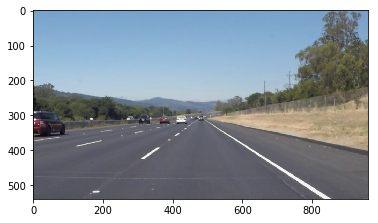

In [6]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [127]:
import math

threshold = 0.1

def load_image(source_folder, file_name):
    s = "";
    sequence = (source_folder, file_name)
    fileFullPath = s.join(sequence)
    img = mpimg.imread(fileFullPath)
    return img

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, 255)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    global avg_pos_slope
    global avg_neg_slope
    global nFrames
    
    if lines is None:
        return;
    
    # lines is an array of <1,4> tuples
    num_line_segments = lines.shape
    slopes = [None]* num_line_segments[0]
    line_index=0
    for line in lines:
        for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            slopes[line_index] = (y2 - y1) / (x2 - x1);
        line_index+=1
    
    imshape = img.shape
    bottom_y = imshape[1]
    
    
    mean_negative_slope = compute_mean_slope(slopes, 1)
    print('avg_neg_slope(before) = ', avg_neg_slope)
    print('mean_negative_slope = ', mean_negative_slope)
    if ~np.isinf(mean_negative_slope) and ~np.isnan(mean_negative_slope):
        if avg_neg_slope != 0:
            avg_neg_slope = (mean_negative_slope + avg_neg_slope*nFrames)/(nFrames+1)
        else:
            avg_neg_slope = mean_negative_slope
    else:
        plt.imshow(img)
    print('avg_neg_slope = ', avg_neg_slope)
    if avg_neg_slope != 0:
        rlp1 = compute_highest_point(lines,1,avg_neg_slope)#[485, 300];
        rlp2 = compute_other_point(avg_neg_slope, rlp1, bottom_y)
        cv2.line(img, (rlp1[0], rlp1[1]), (int(rlp2[0]), int(rlp2[1])), color, 10)
        print('end-points = ', rlp1[0], rlp1[1], int(rlp2[0]), int(rlp2[1]))
    
    mean_positive_slope = compute_mean_slope(slopes, 0)
    print('avg_pos_slope(before) = ', avg_pos_slope)
    print('mean_positive_slope = ',mean_positive_slope)
    print('nFrames = ',nFrames)
    if ~np.isinf(mean_positive_slope) and ~np.isnan(mean_positive_slope):
        if avg_pos_slope != 0:
            avg_pos_slope = (mean_positive_slope + avg_pos_slope*nFrames)/(nFrames+1)
        else:
            avg_pos_slope = mean_positive_slope
    else:
        plt.imshow(img)
    print('avg_pos_slope = ', avg_pos_slope)
    if avg_pos_slope != 0:
        llp1 = compute_highest_point(lines,0,avg_pos_slope)#[485, 310];
        llp2 = compute_other_point(avg_pos_slope, llp1, bottom_y)
        cv2.line(img, (llp1[0], llp1[1]), (int(llp2[0]), int(llp2[1])), color, 10)
        print('end points = ', llp1[0], llp1[1], int(llp2[0]), int(llp2[1]))

def remove_noisy_slopes(slope_candidates):
    global threshold
    mean_slope = np.mean(slope_candidates)
    new_slope_candidates = []
    for slope in slope_candidates:
        if abs(slope - mean_slope) < threshold:
            new_slope_candidates.append(slope)
    return new_slope_candidates
    
def compute_mean_slope(slopes, is_slope_negative):
    num_line_segments = len(slopes)
    if is_slope_negative==1:
        slope_indices =  [i for i in range(num_line_segments) if slopes[i] < 0]
    else:
        slope_indices = [i for i in range(num_line_segments) if slopes[i] > 0]
    slope_candidates = [slopes[i] for i in slope_indices]
    slope_candidates = remove_noisy_slopes(slope_candidates)
    mean_slope = np.mean(slope_candidates)
    return mean_slope

def compute_highest_point(lines, is_slope_negative, mean_slope):
    global threshold
    highest_x = 0
    highest_y = 1000
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1) / (x2 - x1);
            if abs(slope - mean_slope) < threshold:
                if is_slope_negative and slope < 0:
                    if highest_y > y1:
                        highest_x = x1
                        highest_y = y1
                    if highest_y > y2:
                        highest_x = x2
                        highest_y = y2
            
            if abs(slope - mean_slope) < threshold:
                if not is_slope_negative and slope > 0:
                    if highest_y > y1:
                        highest_x = x1
                        highest_y = y1
                    if highest_y > y2:
                        highest_x = x2
                        highest_y = y2
    print('highest = ', [highest_x, highest_y])
    return [highest_x, highest_y]

def compute_other_point(slope, point, bottom_y):
    bias = point[1] - slope*point[0]
    bottom_x = (bottom_y - bias)/ slope;
    print('bottom = ',[bottom_x, bottom_y])
    return [bottom_x, bottom_y]
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [8]:
import os, sys
src_folder = "test_images/"
file_list = os.listdir(src_folder)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [83]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
i = 0
for file in file_list:
    
    img = load_image(src_folder, file)
    
    # Compute GrayScale of the  image
    gray = grayscale(img)
    
    # Compute guassian blur of the image
    kernel_size=5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Compute canny edges pf the image
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Create masked edge image using region of interest
    imshape = image.shape
    vertices = np.array([[(0, imshape[0]), (450, 320), (490, 320), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 60 #minimum number of pixels making up a line
    max_line_gap = 60   # maximum gap in pixels between connectable line segments
    
    # Run hough on edge detected image and draw lines on image
    line_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Create a color binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))
    
    # Draw lines on edge image
    lane_overlayed_image = weighted_img(line_image, img)
    
    
    # save image in src_folder 
    s = "";
    new_file_name = s.join((src_folder, "modified_", file))
    mpimg.imsave(new_file_name, lane_overlayed_image)
    

NameError: name 'file_list' is not defined

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

In [128]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # Compute GrayScale of the  image
    global nFrames
    
    nFrames = nFrames + 1
    
    gray = grayscale(image)
    
    # Compute guassian blur of the image
    kernel_size=5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Compute canny edges pf the image
    low_threshold = 40
    high_threshold = 120
    edges = canny(blur_gray, low_threshold, high_threshold)
    
   # Create masked edge image using region of interest
    imshape = image.shape
    print(imshape)
    #vertices = np.array([[(50, imshape[0]-20), (imshape[1]/2-10, imshape[0]/2+40), (imshape[1]/2 + 10, imshape[0]/2+40), (imshape[1]-50, imshape[0]-20)]], dtype=np.int32)
    vertices = np.array([[(0, imshape[0]), (480, 310), 490, 310), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)
    
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100 #minimum number of pixels making up a line
    max_line_gap = 150   # maximum gap in pixels between connectable line segments
    # Run hough on edge detected image and draw lines on image
    line_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
    
    #plt.imshow(line_image)
    # Create a color binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))
    
    # Draw lines on edge image
    lane_overlayed_image = weighted_img(line_image, image)
    
    
    # save image in src_folder 
    #s = "";
    #new_file_name = s.join((src_folder, "modified_", file))
    #mpimg.imsave(new_file_name, lane_overlayed_image)
    plt.imshow(lane_overlayed_image)
    return lane_overlayed_image

SyntaxError: invalid syntax (<ipython-input-128-94aa8004afa9>, line 25)

Let's try the one with the solid white lane on the right first ...

(540, 960, 3)
avg_neg_slope(before) =  -0.710953193324
mean_negative_slope =  -0.732816817826
avg_neg_slope =  -0.721885005575
highest =  [474, 311]
bottom =  [-425.0351579378023, 960]
end-points =  474 311 -425 960
avg_pos_slope(before) =  0.609346336678
mean_positive_slope =  0.612251115811
nFrames =  1
avg_pos_slope =  0.610798726245
highest =  [486, 310]
bottom =  [1550.1803462760931, 960]
end points =  486 310 1550 960
[MoviePy] >>>> Building video test_videos/modified_solidWhiteRight.mp4
[MoviePy] Writing video test_videos/modified_solidWhiteRight.mp4



  0%|          | 0/222 [00:00<?, ?it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.721885005575
mean_negative_slope =  -0.732816817826
avg_neg_slope =  -0.725528942992
highest =  [474, 311]
bottom =  [-420.51979313691743, 960]
end-points =  474 311 -420 960
avg_pos_slope(before) =  0.610798726245
mean_positive_slope =  0.612251115811
nFrames =  2
avg_pos_slope =  0.6112828561
highest =  [486, 310]
bottom =  [1549.33752617711, 960]
end points =  486 310 1549 960
(540, 960, 3)
avg_neg_slope(before) = 


  1%|          | 2/222 [00:00<00:14, 15.49it/s]

 -0.725528942992
mean_negative_slope =  -0.737307978175
avg_neg_slope =  -0.728473701788
highest =  [476, 310]
bottom =  [-416.27654808234109, 960]
end-points =  476 310 -416 960
avg_pos_slope(before) =  0.6112828561
mean_positive_slope =  0.629831105076
nFrames =  3
avg_pos_slope =  0.615919918344
highest =  [490, 310]
bottom =  [1545.332001192025, 960]
end points =  490 310 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.728473701788
mean_negative_slope =  -0.758970086665
avg_neg_slope =  -0.734572978763
highest =  [464, 313]
bottom =  [-416.78382775437177, 960]
end-points =  464 313 -416 960
avg_pos_slope(before) =  0.615919918344
mean_positive_slope =  0.611723876015
nFrames =  4
avg_pos_slope =  0.615080709878
highest =  [490, 310]
bottom =  [1546.7718830408235, 960]
end points =  490 310 1546 960



  2%|▏         | 4/222 [00:00<00:14, 14.63it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.734572978763
mean_negative_slope =  -0.72724466945
avg_neg_slope =  -0.733351593878
highest =  [470, 310]
bottom =  [-416.34156580071732, 960]
end-points =  470 310 -416 960
avg_pos_slope(before) =  0.615080709878
mean_positive_slope =  0.61638668463
nFrames =  5
avg_pos_slope =  0.615298372337
highest =  [491, 310]
bottom =  [1547.3980488546872, 960]
end points =  491 310 1547 960



  2%|▏         | 5/222 [00:00<00:17, 12.75it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.733351593878
mean_negative_slope =  -0.716330986716
avg_neg_slope =  -0.730920078569
highest =  [475, 311]
bottom =  [-412.9219753694133, 960]
end-points =  475 311 -412 960
avg_pos_slope(before) =  0.615298372337
mean_positive_slope =  0.58543224861
nFrames =  6
avg_pos_slope =  0.611031783233
highest =  [482, 310]
bottom =  [1545.7744514057283, 960]
end points =  482 310 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.730920078569
mean_negative_slope =  -0.713154040803
avg_neg_slope =  -0.728699323848
highest =  [470, 310]
bottom = 


  3%|▎         | 7/222 [00:00<00:16, 13.35it/s]

 [-422.00027875358484, 960]
end-points =  470 310 -422 960
avg_pos_slope(before) =  0.611031783233
mean_positive_slope =  0.588080932622
nFrames =  7
avg_pos_slope =  0.608162926907
highest =  [487, 313]
bottom =  [1550.859652364931, 960]
end points =  487 313 1550 960
(540, 960, 3)
avg_neg_slope(before) =  -0.728699323848
mean_negative_slope =  -0.712708828586
avg_neg_slope =  -0.726922602152
highest =  [474, 310]
bottom =  [-420.18047819049104, 960]
end-points =  474 310 -420 960
avg_pos_slope(before) =  0.608162926907
mean_positive_slope =  0.614113093965
nFrames =  8
avg_pos_slope =  0.60882405658
highest =  [491, 310]
bottom =  [1558.6319258008391, 960]
end points =  491 310 1558 960
(540, 960, 3)



  4%|▍         | 9/222 [00:00<00:14, 14.57it/s]

avg_neg_slope(before) =  -0.726922602152
mean_negative_slope =  -0.713311353659
avg_neg_slope =  -0.725561477303
highest =  [470, 310]
bottom =  [-425.85792566633842, 960]
end-points =  470 310 -425 960
avg_pos_slope(before) =  0.60882405658
mean_positive_slope =  0.614511888502
nFrames =  9
avg_pos_slope =  0.609392839772
highest =  [491, 310]
bottom =  [1557.6354403562659, 960]
end points =  491 310 1557 960
(540, 960, 3)
avg_neg_slope(before) =  -0.725561477303
mean_negative_slope =  -0.716133756521
avg_neg_slope =  -0.724704411777
highest =  [472, 312]
bottom =  [-422.15765858366933, 960]
end-points =  472 312 -422 960
avg_pos_slope(before) =  0.609392839772
mean_positive_slope =  0.609231522183
nFrames =  10
avg_pos_slope =  0.609378174536
highest =  [491, 310]
bottom =  [1557.6611099001236, 960]
end points =  491 310 1557 960
(540, 960, 3)
avg_neg_slope(before) =  -0.724704411777
mean_negative_slope =  -0.710434389857
avg_neg_slope =  -0.723515243284
highest =  [478, 311]
bottom 


  5%|▍         | 11/222 [00:00<00:13, 15.85it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.723515243284
mean_negative_slope =  -0.732518908232
avg_neg_slope =  -0.724207832895
highest =  [473, 310]
bottom =  [-424.53240779152168, 960]
end-points =  473 310 -424 960
avg_pos_slope(before) =  0.607012601697
mean_positive_slope =  0.611190272672
nFrames =  12
avg_pos_slope =  0.607333961003
highest =  [482, 310]
bottom =  [1552.25136372513, 960]
end points =  482 310 1552 960



  6%|▌         | 13/222 [00:00<00:13, 15.72it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.724207832895
mean_negative_slope =  -0.717417775524
avg_neg_slope =  -0.723722828797
highest =  [477, 310]
bottom =  [-421.13389067764325, 960]
end-points =  477 310 -421 960
avg_pos_slope(before) =  0.607333961003
mean_positive_slope =  0.624878501009
nFrames =  13
avg_pos_slope =  0.608587142432
highest =  [482, 310]
bottom =  [1550.0475394247981, 960]
end points =  482 310 1550 960
(540, 960, 3)
avg_neg_slope(before) =  -0.723722828797
mean_negative_slope =  -0.742537637698
avg_neg_slope =  -0.724977149391
highest =  [477, 310]
bottom =  [-419.57998261914145, 960]
end-points =  477 310 -419 960
avg_pos_slope(before) =  0.608587142432
mean_positive_slope =  0.633863554367
nFrames =  14
avg_pos_slope =  0.610272236561
highest =  [482, 310]
bottom =  [1547.0984283062407, 960]
end points =  482 310 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.724977149391
mean_negative_slope =  -0.709176768865
avg_neg_slope =  -0.723989625608
highest =  [4

(540, 960, 3)
avg_neg_slope(before) =  -0.723989625608
mean_negative_slope =  -0.719361959837
avg_neg_slope =  -0.723717409974
highest =  [474, 311]
bottom =  [-422.75886064851636, 960]
end-points =  474 311 -422 960
avg_pos_slope(before) =  0.612251757123
mean_positive_slope =  0.640303245563
nFrames =  16
avg_pos_slope =  0.613901844679
highest =  [487, 310]
bottom =  [1545.80118399106, 960]
end points =  487 310 1545 960



  7%|▋         | 16/222 [00:01<00:12, 16.85it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.723717409974
mean_negative_slope =  -0.71598453632
avg_neg_slope =  -0.723287805882
highest =  [470, 311]
bottom =  [-427.29149962413214, 960]
end-points =  470 311 -427 960
avg_pos_slope(before) =  0.613901844679
mean_positive_slope =  0.643923099243
nFrames =  17
avg_pos_slope =  0.615569692154
highest =  [488, 310]
bottom =  [1543.9324285850976, 960]
end points =  488 310 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.723287805882
mean_negative_slope =  -0.680619758451
avg_neg_slope =  -0.721042119175
highest =  [474, 310]
bottom =  [-427.47299681096052, 960]
end-points =  474 310 -427 960
avg_pos_slope(before) =  0.615569692154
mean_positive_slope =  0.642940435169
nFrames =  18
avg_pos_slope =  0.617010257576
highest =  [490, 310]
bottom =  [1543.4670891102621, 960]
end points =  490 310 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.721042119175
mean_negative_slope =  -0.673136427697
avg_neg_slope =  -0.718646834602
highest =  [47


  9%|▊         | 19/222 [00:01<00:11, 18.03it/s]

end-points =  472 310 -433 960
avg_pos_slope(before) =  0.618050532104
mean_positive_slope =  0.63647061126
nFrames =  20
avg_pos_slope =  0.61892767873
highest =  [487, 310]
bottom =  [1537.2034766539723, 960]
end points =  487 310 1537 960
(540, 960, 3)
avg_neg_slope(before) =  -0.718160094214
mean_negative_slope =  -0.682131712861
avg_neg_slope =  -0.716522440516
highest =  [476, 310]
bottom =  [-431.15930617848113, 960]


 10%|▉         | 22/222 [00:01<00:10, 19.06it/s]


end-points =  476 310 -431 960
avg_pos_slope(before) =  0.61892767873
mean_positive_slope =  0.641591123268
nFrames =  21
avg_pos_slope =  0.6199578353
highest =  [484, 310]
bottom =  [1532.4583998929286, 960]
end points =  484 310 1532 960
(540, 960, 3)
avg_neg_slope(before) =  -0.716522440516
mean_negative_slope =  -0.709206052588
avg_neg_slope =  -0.716204336693
highest =  [476, 310]
bottom =  [-431.56222309554641, 960]
end-points =  476 310 -431 960
avg_pos_slope(before) =  0.6199578353
mean_positive_slope =  0.639948316926
nFrames =  22
avg_pos_slope =  0.620826986675
highest =  [484, 311]
bottom =  [1529.3798142306687, 960]
end points =  484 311 1529 960
(540, 960, 3)
avg_neg_slope(before) =  -0.716204336693
mean_negative_slope =  -0.724816946995
avg_neg_slope =  -0.716563195456
highest =  [471, 310]
bottom =  [-436.1077109765896, 960]
end-points =  471 310 -436 960
avg_pos_slope(before) =  0.620826986675
mean_positive_slope =  0.639839779802
nFrames =  23
avg_pos_slope =  0.621


 13%|█▎        | 28/222 [00:01<00:09, 20.57it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.716242332553
mean_negative_slope =  -0.7115890583
avg_neg_slope =  -0.716076144187
highest =  [477, 310]
bottom =  [-430.72469558854118, 960]
end-points =  477 310 -430 960
avg_pos_slope(before) =  0.623491325022
mean_positive_slope =  0.638647404309
nFrames =  27
avg_pos_slope =  0.624032613568
highest =  [487, 310]
bottom =  [1528.6122264565872, 960]
end points =  487 310 1528 960
(540, 960, 3)
avg_neg_slope(before) =  -0.716076144187
mean_negative_slope =  -0.715013052883
avg_neg_slope =  -0.716039485866
highest =  [471, 310]
bottom =  [-436.77116741552584, 960]
end-points =  471 310 -436 960
avg_pos_slope(before) =  0.624032613568
mean_positive_slope =  0.636666532093
nFrames =  28
avg_pos_slope =  0.624468265931
highest =  [485, 310]
bottom =  [1525.8855589020061, 960]
end points =  485 310 1525 960
(540, 960, 3)
avg_neg_slope(before) =  -0.716039485866
mean_negative_slope =  -0.703428814391
avg_neg_slope =  -0.71561913015
highest =  [470,

(540, 960, 3)
avg_neg_slope(before) =  -0.716250181298
mean_negative_slope =  -0.746600276184
avg_neg_slope =  -0.717198621763
highest =  [477, 310]
bottom =  [-429.30402830659528, 960]
end-points =  477 310 -429 960
avg_pos_slope(before) =  0.625360692438
mean_positive_slope =  0.636277346927
nFrames =  31
avg_pos_slope =  0.625701837891
highest =  [489, 310]
bottom =  [1527.833451714491, 960]
end points =  489 310 1527 960



 14%|█▍        | 31/222 [00:01<00:09, 20.55it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.717198621763
mean_negative_slope =  -0.712855240995
avg_neg_slope =  -0.717067004164
highest =  [474, 311]
bottom =  [-431.07581053240057, 960]
end-points =  474 311 -431 960
avg_pos_slope(before) =  0.625701837891
mean_positive_slope =  0.630928976617
nFrames =  32
avg_pos_slope =  0.625860236034
highest =  [489, 310]
bottom =  [1527.5705347237604, 960]
end points =  489 310 1527 960
(540, 960, 3)
avg_neg_slope(before) =  -0.717067004164
mean_negative_slope =  -0.714820674059
avg_neg_slope =  -0.717000935632
highest =  [474, 310]
bottom =  [-432.55390766999773, 960]
end-points =  474 310 -432 960
avg_pos_slope(before) =  0.625860236034
mean_positive_slope =  0.633799685591
nFrames =  33
avg_pos_slope =  0.626093749256
highest =  [488, 310]
bottom =  [1526.1831806694934, 960]
end points =  488 310 1526 960
(540, 960, 3)
avg_neg_slope(before) =  -0.717000935632
mean_negative_slope =  -0.703405616866
avg_neg_slope =  -0.716612497953
highest =  [4


 15%|█▌        | 34/222 [00:01<00:08, 21.13it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.716654425289
mean_negative_slope =  -0.722283791935
avg_neg_slope =  -0.716806570333
highest =  [471, 310]
bottom =  [-435.79972380552664, 960]
end-points =  471 310 -435 960
avg_pos_slope(before) =  0.626914707897
mean_positive_slope =  0.635049471353
nFrames =  36
avg_pos_slope =  0.627134566369
highest =  [483, 310]
bottom =  [1519.4601711613627, 960]
end points =  483 310 1519 960



 17%|█▋        | 37/222 [00:01<00:08, 20.67it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.716806570333
mean_negative_slope =  -0.720118444355
avg_neg_slope =  -0.716893724913
highest =  [479, 310]
bottom =  [-427.68948187439116, 960]
end-points =  479 310 -427 960
avg_pos_slope(before) =  0.627134566369
mean_positive_slope =  0.63634048729
nFrames =  37
avg_pos_slope =  0.627376827446
highest =  [483, 310]
bottom =  [1519.0599428675841, 960]
end points =  483 310 1519 960
(540, 960, 3)
avg_neg_slope(before) =  -0.716893724913
mean_negative_slope =  -0.706599281955
avg_neg_slope =  -0.716629764837
highest =  [479, 310]
bottom =  [-428.02344766278742, 960]
end-points =  479 310 -428 960
avg_pos_slope(before) =  0.627376827446
mean_positive_slope =  0.634046767169
nFrames =  38
avg_pos_slope =  0.627547851541
highest =  [484, 310]
bottom =  [1519.7775879616734, 960]
end points =  484 310 1519 960
(540, 960, 3)
avg_neg_slope(before) =  -0.716629764837
mean_negative_slope =  -0.716732387487
avg_neg_slope =  -0.716632330403
highest =  [48


 18%|█▊        | 40/222 [00:02<00:09, 19.85it/s]


avg_neg_slope(before) =  -0.716649085516
mean_negative_slope =  -0.71607797302
avg_neg_slope =  -0.716635487599
highest =  [470, 310]
bottom =  [-437.01620453854031, 960]
end-points =  470 310 -437 960
avg_pos_slope(before) =  0.628562615136
mean_positive_slope =  0.633474800175
nFrames =  41
avg_pos_slope =  0.628679571922
highest =  [488, 310]
bottom =  [1521.9130282417943, 960]
end points =  488 310 1521 960
(540, 960, 3)
avg_neg_slope(before) =  -0.716635487599
mean_negative_slope =  -0.717562124855
avg_neg_slope =  -0.716657037303
highest =  [474, 310]
bottom =  [-432.98893078085882, 960]
end-points =  474 310 -432 960
avg_pos_slope(before) =  0.628679571922
mean_positive_slope =  0.638131991199
nFrames =  42
avg_pos_slope =  0.628899395626
highest =  [490, 310]
bottom =  [1523.5516372257318, 960]
end points =  490 310 1523 960
(540, 960, 3)
avg_neg_slope(before) =  -0.716657037303
mean_negative_slope =  -0.706245161769
avg_neg_slope =  -0.716420403768
highest =  [474, 310]
botto


 19%|█▉        | 43/222 [00:02<00:09, 19.45it/s]


avg_neg_slope(before) =  -0.716420403768
mean_negative_slope =  -0.700373535424
avg_neg_slope =  -0.716063806694
highest =  [474, 310]
bottom =  [-433.74033532175577, 960]
end-points =  474 310 -433 960
avg_pos_slope(before) =  0.628858116505
mean_positive_slope =  0.638101247962
nFrames =  44
avg_pos_slope =  0.629063519427
highest =  [490, 310]
bottom =  [1523.2819817503712, 960]
end points =  490 310 1523 960



 20%|██        | 45/222 [00:02<00:09, 17.78it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.716063806694
mean_negative_slope =  -0.696729128292
avg_neg_slope =  -0.715643487598
highest =  [474, 310]
bottom =  [-434.27347871435973, 960]
end-points =  474 310 -434 960
avg_pos_slope(before) =  0.629063519427
mean_positive_slope =  0.65897720044
nFrames =  45
avg_pos_slope =  0.62971381684
highest =  [490, 310]
bottom =  [1522.2149246491961, 960]
end points =  490 310 1522 960
(540, 960, 3)
avg_neg_slope(before) =  -0.715643487598
mean_negative_slope =  -0.719019392327
avg_neg_slope =  -0.715715315358
highest =  [470, 312]
bottom =  [-435.38791904378104, 960]
end-points =  470 312 -435 960
avg_pos_slope(before) =  0.62971381684
mean_positive_slope =  0.65722086664
nFrames =  46
avg_pos_slope =  0.630299073219
highest =  [489, 310]
bottom =  [1520.2564742967702, 960]
end points =  489 310 1520 960
(540, 960, 3)


avg_neg_slope(before) =  -0.715715315358
mean_negative_slope =  -0.721788683126
avg_neg_slope =  -0.715841843853
highest =  [473, 310]
bottom =  [-435.02180059912331, 960]
end-points =  473 310 -435 960
avg_pos_slope(before) =  0.630299073219
mean_positive_slope =  0.659405869974
nFrames =  47
avg_pos_slope =  0.630905464818
highest =  [495, 313]
bottom =  [1520.5102167912096, 960]
end points =  495 313 1520 960
(540, 960, 3)



 21%|██        | 47/222 [00:02<00:10, 16.61it/s]

avg_neg_slope(before) =  -0.715841843853
mean_negative_slope =  -0.713893848232
avg_neg_slope =  -0.715802088841
highest =  [473, 310]
bottom =  [-435.07223132397661, 960]
end-points =  473 310 -435 960
avg_pos_slope(before) =  0.630905464818
mean_positive_slope =  0.644719263066
nFrames =  48
avg_pos_slope =  0.631187379068
highest =  [489, 310]
bottom =  [1518.8051284866972, 960]
end points =  489 310 1518 960
(540, 960, 3)
avg_neg_slope(before) =  -0.715802088841
mean_negative_slope =  -0.731989000807
avg_neg_slope =  -0.71612582708
highest =  [462, 314]
bottom =  [-440.07610949318985, 960]
end-points =  462 314 -440 960
avg_pos_slope(before) =  0.631187379068
mean_positive_slope =  0.656709649762
nFrames =  49
avg_pos_slope =  0.631697824482
highest =  [489, 310]
bottom =  [1517.9729912136986, 960]
end points =  489 310 1517 960
(540, 960, 3)
avg_neg_slope(before) =  -0.71612582708
mean_negative_slope =  -0.734233707086
avg_neg_slope =  -0.716480883551
highest =  [464, 313]
bottom 


 22%|██▏       | 49/222 [00:02<00:10, 16.62it/s]


(540, 960, 3)
avg_neg_slope(before) =  -0.716480883551
mean_negative_slope =  -0.717019844939
avg_neg_slope =  -0.716491248193
highest =  [471, 310]
bottom =  [-436.19879920296387, 960]
end-points =  471 310 -436 960
avg_pos_slope(before) =  0.632259117392
mean_positive_slope =  0.642642155325
nFrames =  51
avg_pos_slope =  0.632458791198
highest =  [488, 310]
bottom =  


 23%|██▎       | 51/222 [00:02<00:12, 14.21it/s]

[1515.7349434395246, 960]
end points =  488 310 1515 960
(540, 960, 3)
avg_neg_slope(before) =  -0.716491248193
mean_negative_slope =  -0.710234166237
avg_neg_slope =  -0.716373190043
highest =  [471, 310]
bottom =  [-436.34830537307823, 960]
end-points =  471 310 -436 960
avg_pos_slope(before) =  0.632458791198
mean_positive_slope =  0.64167141056
nFrames =  52
avg_pos_slope =  0.632632614205
highest =  [487, 310]
bottom =  [1514.4525615735399, 960]
end points =  487 310 1514 960
(540, 960, 3)
avg_neg_slope(before) =  -0.716373190043
mean_negative_slope =  -0.706468124646
avg_neg_slope =  -0.716189762906
highest =  [471, 310]
bottom =  [-436.5806911324305, 960]
end-points =  471 310 -436 960
avg_pos_slope(before) =  0.632632614205
mean_positive_slope =  0.661765229363
nFrames =  53
avg_pos_slope =  0.633172107078
highest =  [494, 313]
bottom =  [1515.8390746639172, 960]
end points =  494 313 1515 960
(540, 960, 3)
avg_neg_slope(before) =  -0.716189762906
mean_negative_slope =  -0.6825


 24%|██▍       | 53/222 [00:03<00:11, 14.16it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.715577444783
mean_negative_slope =  -0.681208422929
avg_neg_slope =  -0.71496371225
highest =  [471, 310]
bottom =  [-438.13704970351677, 960]
end-points =  471 310 -438 960
avg_pos_slope(before) =  0.632813489692
mean_positive_slope =  0.653952200601
nFrames =  55
avg_pos_slope =  0.633190966673
highest =  [491, 310]
bottom =  [1517.5465463220264, 960]
end points =  491 310 1517 960
(540, 960, 3)
avg_neg_slope(before) =  -0.71496371225
mean_negative_slope =  -0.662627779401
avg_neg_slope =  


 25%|██▍       | 55/222 [00:03<00:11, 14.13it/s]

-0.714045537989
highest =  [471, 310]
bottom =  [-439.30608752239391, 960]
end-points =  471 310 -439 960
avg_pos_slope(before) =  0.633190966673
mean_positive_slope =  0.637923995316
nFrames =  56
avg_pos_slope =  0.633274002263
highest =  [491, 310]
bottom =  [1517.4119443992111, 960]
end points =  491 310 1517 960
(540, 960, 3)
avg_neg_slope(before) =  -0.714045537989
mean_negative_slope =  -0.686615218423
avg_neg_slope =  -0.713572601445
highest =  [475, 310]
bottom =  [-435.90941367920726, 960]
end-points =  475 310 -435 960
avg_pos_slope(before) =  0.633274002263
mean_positive_slope =  0.632695879225
nFrames =  57
avg_pos_slope =  0.633264034624
highest =  [485, 310]
bottom =  [1511.4281002248183, 960]
end points =  485 310 1511 960



 26%|██▌       | 57/222 [00:03<00:11, 14.21it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.713572601445
mean_negative_slope =  -0.694972845225
avg_neg_slope =  -0.71325735134
highest =  [474, 310]
bottom =  [-437.31202332375017, 960]
end-points =  474 310 -437 960
avg_pos_slope(before) =  0.633264034624
mean_positive_slope =  0.638226078856
nFrames =  58
avg_pos_slope =  0.633348137069
highest =  [481, 310]
bottom =  [1507.2918006015966, 960]
end points =  481 310 1507 960
(540, 960, 3)
avg_neg_slope(before) =  -0.71325735134
mean_negative_slope =  -0.677224833347
avg_neg_slope =  -0.712656809373
highest =  [473, 310]
bottom =  [-439.07996815697936, 960]
end-points =  473 310 -439 960
avg_pos_slope(before) =  0.633348137069
mean_positive_slope =  0.633390817215
nFrames =  59
avg_pos_slope =  0.633348848405
highest =  [490, 311]
bottom =  [1514.7117392490095, 960]
end points =  490 311 1514 960
(540, 960, 3)
avg_neg_slope(before) =  -0.712656809373
mean_negative_slope =  -0.692521415808
avg_neg_slope =  -0.712326720954
highest =  [477


 27%|██▋       | 59/222 [00:03<00:10, 15.47it/s]

493 313 1514 960
(540, 960, 3)
avg_neg_slope(before) =  -0.712326720954
mean_negative_slope =  -0.686676703796
avg_neg_slope =  -0.711913011
highest =  [473, 310]
bottom =  [-440.03289862198403, 960]
end-points =  473 310 -440 960
avg_pos_slope(before) =  0.633608263176
mean_positive_slope =  0.65734639371
nFrames =  61
avg_pos_slope =  0.633991136249
highest =  [489, 310]
bottom =  [1514.2509267648218, 960]
end points =  489 310 1514 960



 27%|██▋       | 61/222 [00:03<00:09, 16.29it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.711913011
mean_negative_slope =  -0.669877342796
avg_neg_slope =  -0.711245778171
highest =  [473, 310]
bottom =  [-440.88943168309726, 960]
end-points =  473 310 -440 960
avg_pos_slope(before) =  0.633991136249
mean_positive_slope =  0.656030469095
nFrames =  62
avg_pos_slope =  0.634340966929
highest =  [484, 311]
bottom =  [1507.109075142728, 960]
end points =  484 311 1507 960
(540, 960, 3)
avg_neg_slope(before) =  -0.711245778171
mean_negative_slope =  -0.682880138074
avg_neg_slope =  -0.710802565045
highest =  [473, 310]
bottom =  [-441.4592773930521, 960]
end-points =  473 310 -441 960
avg_pos_slope(before) =  0.634340966929
mean_positive_slope =  0.658892111754
nFrames =  63
avg_pos_slope =  0.634724578567
highest =  [492, 312]
bottom =  [1512.9152471501313, 960]
end points =  492 312 1512 960
(540, 960, 3)
avg_neg_slope(before) =  -0.710802565045
mean_negative_slope =  -0.687340812467
avg_neg_slope =  -0.710441615005
highest =  [472, 3


 29%|██▉       | 64/222 [00:03<00:09, 17.40it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.710441615005
mean_negative_slope =  -0.671234134295
avg_neg_slope =  -0.709847562267
highest =  [472, 310]
bottom =  [-443.68955723961972, 960]
end-points =  472 310 -443 960
avg_pos_slope(before) =  0.635100028148
mean_positive_slope =  0.629632812777
nFrames =  65
avg_pos_slope =  0.635017191551
highest =  [483, 311]
bottom =  [1505.0195746428478, 960]
end points =  483 311 1505 960
(540, 960, 3)



 30%|██▉       | 66/222 [00:03<00:08, 17.43it/s]

avg_neg_slope(before) =  -0.709847562267
mean_negative_slope =  -0.673433915812
avg_neg_slope =  -0.709304075007
highest =  [472, 310]
bottom =  [-444.39118243322679, 960]
end-points =  472 310 -444 960
avg_pos_slope(before) =  0.635017191551
mean_positive_slope =  0.662615613812
nFrames =  66
avg_pos_slope =  0.635429108301
highest =  [486, 310]
bottom =  [1508.9307904034131, 960]
end points =  486 310 1508 960
(540, 960, 3)
avg_neg_slope(before) =  -0.709304075007
mean_negative_slope =  -0.65327478412
avg_neg_slope =  -0.708480114846
highest =  [473, 310]
bottom =  [-444.45694251536202, 960]
end-points =  473 310 -444 960
avg_pos_slope(before) =  0.635429108301
mean_positive_slope =  0.658177493326
nFrames =  67
avg_pos_slope =  0.635763643375
highest =  [484, 311]
bottom =  [1504.8196186785942, 960]
end points =  484 311 1504 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708480114846
mean_negative_slope =  -0.688681883756
avg_neg_slope =  -0.708193183961
highest =  [473, 310]
bottom

(540, 960, 3)
avg_neg_slope(before) =  -0.708193183961
mean_negative_slope =  -0.682397989515
avg_neg_slope =  -0.707824681183
highest =  [475, 310]
bottom =  [-443.30649210102843, 960]
end-points =  475 310 -443 960
avg_pos_slope(before) =  0.636075468576
mean_positive_slope =  0.661376814906
nFrames =  69
avg_pos_slope =  0.636436916381
highest =  [485, 310]
bottom =  [1506.3109630661254, 960]
end points =  485 310 1506 960
(540, 960, 3)



 31%|███       | 69/222 [00:03<00:08, 18.10it/s]

avg_neg_slope(before) =  -0.707824681183
mean_negative_slope =  -0.667655479527
avg_neg_slope =  -0.70725891778
highest =  [475, 310]
bottom =  [-444.04108051477982, 960]
end-points =  475 310 -444 960
avg_pos_slope(before) =  0.636436916381
mean_positive_slope =  0.656880647704
nFrames =  70
avg_pos_slope =  0.636724856259
highest =  [485, 310]
bottom =  [1505.8491055604979, 960]
end points =  485 310 1505 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70725891778
mean_negative_slope =  -0.673328568044
avg_neg_slope =  -0.706787662922
highest =  [478, 310]
bottom =  [-441.65385659464175, 960]
end-points =  478 310 -441 960
avg_pos_slope(before) =  0.636724856259
mean_positive_slope =  0.65460049768
nFrames =  71
avg_pos_slope =  0.636973129056
highest =  [483, 310]
bottom =  [1503.4512095555951, 960]
end points =  483 310 1503 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706787662922
mean_negative_slope =  -0.687758620131
avg_neg_slope =  -0.706526991103
highest =  [470, 311]
bottom =


 32%|███▏      | 71/222 [00:04<00:08, 17.45it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.706526991103
mean_negative_slope =  -0.64869636679
avg_neg_slope =  -0.70574549618
highest =  [477, 310]
bottom =  [-444.01189949944711, 960]
end-points =  477 310 -444 960
avg_pos_slope(before) =  0.637240566934
mean_positive_slope =  0.660270511966
nFrames =  73
avg_pos_slope =  0.637551782408
highest =  [491, 310]
bottom =  [1510.5250298652811, 960]
end points =  491 310 1510 960



 33%|███▎      | 73/222 [00:04<00:08, 17.95it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70574549618
mean_negative_slope =  -0.69261978647
avg_neg_slope =  -0.705570486717
highest =  [472, 310]
bottom =  [-449.24034697677945, 960]
end-points =  472 310 -449 960
avg_pos_slope(before) =  0.637551782408
mean_positive_slope =  0.660900006904
nFrames =  74
avg_pos_slope =  0.637863092068
highest =  [482, 310]
bottom =  [1501.0274497508217, 960]
end points =  482 310 1501 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705570486717
mean_negative_slope =  -0.700269230325
avg_neg_slope =  -0.705500733344
highest =  [473, 310]
bottom =  [-448.33143068378502, 960]
end-points =  473 310 -448 960
avg_pos_slope(before) =  0.637863092068
mean_positive_slope =  0.65610006981
nFrames =  75
avg_pos_slope =  0.638103052301
highest =  [482, 310]
bottom =  [1500.6442419541384, 960]
end points =  482 310 1500 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705500733344
mean_negative_slope =  -0.670471374596
avg_neg_slope =  -0.705045806607
highest =  [473,


 34%|███▍      | 76/222 [00:04<00:07, 18.97it/s]

mean_negative_slope =  -0.681243139315
avg_neg_slope =  -0.704740644206
highest =  [474, 310]
bottom =  [-448.32512108445695, 960]
end-points =  474 310 -448 960
avg_pos_slope(before) =  0.63836406227
mean_positive_slope =  0.664647983753
nFrames =  77
avg_pos_slope =  0.638701035623
highest =  [484, 310]
bottom =  [1501.6905371172181, 960]
end points =  484 310 1501 960
(540, 960, 3)



 36%|███▌      | 80/222 [00:04<00:07, 19.18it/s]

avg_neg_slope(before) =  -0.704740644206
mean_negative_slope =  -0.678967806967
avg_neg_slope =  -0.704414405759
highest =  [471, 311]
bottom =  [-450.33266255432744, 960]
end-points =  471 311 -450 960
avg_pos_slope(before) =  0.638701035623
mean_positive_slope =  0.676100617576
nFrames =  78
avg_pos_slope =  0.639174448052
highest =  [485, 310]
bottom =  [1501.9367720826126, 960]
end points =  485 310 1501 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704414405759
mean_negative_slope =  -0.652307332262
avg_neg_slope =  -0.703763067341
highest =  [466, 314]
bottom =  [-451.92256510559162, 960]
end-points =  466 314 -451 960
avg_pos_slope(before) =  0.639174448052
mean_positive_slope =  0.678188553566
nFrames =  79
avg_pos_slope =  0.639662124371
highest =  [485, 310]
bottom =  [1501.1614628018299, 960]
end points =  485 310 1501 960
(540, 960, 3)
avg_neg_slope(before) =  -0.703763067341
mean_negative_slope =  -0.685799504399
avg_neg_slope =  -0.703541294959
highest =  [474, 310]
botto


 37%|███▋      | 82/222 [00:04<00:07, 19.28it/s]

 -0.702872150294
mean_negative_slope =  -0.655730120376
avg_neg_slope =  -0.70230417403
highest =  [469, 311]
bottom =  [-455.10101491500984, 960]
end-points =  469 311 -455 960
avg_pos_slope(before) =  0.640249100062
mean_positive_slope =  0.711848531639
nFrames =  82
avg_pos_slope =  0.641111743816
highest =  [484, 310]
bottom =  [1497.8638174536427, 960]
end points =  484 310 1497 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70230417403
mean_negative_slope =  -0.664227622938
avg_neg_slope =  -0.701850881755
highest =  [474, 310]
bottom =  [-452.1226521148352, 960]
end-points =  474 310 -452 960
avg_pos_slope(before) =  0.641111743816
mean_positive_slope =  0.684981215057
nFrames =  83
avg_pos_slope =  0.641633999426
highest =  [484, 310]
bottom =  [1497.0385867661837, 960]
end points =  484 310 1497 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701850881755
mean_negative_slope =  -0.658972639058
avg_neg_slope =  -0.701346431841
highest =  [473, 310]
bottom =  [-453.78877440629952, 


 39%|███▉      | 87/222 [00:04<00:06, 19.59it/s]


avg_pos_slope =  0.643137445777
highest =  [489, 310]
bottom =  [1499.6704317534029, 960]
end points =  489 310 1499 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70047719639
mean_negative_slope =  -0.660127409471
avg_neg_slope =  -0.700018676084
highest =  [475, 310]
bottom =  [-453.54665483500298, 960]
end-points =  475 310 -453 960
avg_pos_slope(before) =  0.643137445777
mean_positive_slope =  0.671958435594
nFrames =  87
avg_pos_slope =  0.643464957025
highest =  [482, 310]
bottom =  [1492.1560200038098, 960]
end points =  482 310 1492 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700018676084
mean_negative_slope =  -0.66132018316
avg_neg_slope =  -0.699583861557
highest =  [474, 310]
bottom =  [-455.12377731727361, 960]
end-points =  474 310 -455 960
avg_pos_slope(before) =  0.643464957025
mean_positive_slope =  0.684276187139
nFrames =  88
avg_pos_slope =  0.643923510172
highest =  [484, 310]
bottom =  [1493.4366640322237, 960]
end points =  484 310 1493 960
(540, 960, 3)
avg_ne


 42%|████▏     | 93/222 [00:05<00:06, 20.24it/s]

 [484, 310]
bottom =  [1491.3016719957229, 960]
end points =  484 310 1491 960
(540, 960, 3)
avg_neg_slope(before) =  -0.698170248828
mean_negative_slope =  -0.661941167276
avg_neg_slope =  -0.697780688811
highest =  [477, 310]
bottom =  [-454.52477622625366, 960]
end-points =  477 310 -454 960
avg_pos_slope(before) =  0.645288316371
mean_positive_slope =  0.709173377391
nFrames =  92
avg_pos_slope =  0.645975252511
highest =  [487, 310]
bottom =  [1493.2304979535597, 960]
end points =  487 310 1493 960
(540, 960, 3)
avg_neg_slope(before) =  -0.697780688811
mean_negative_slope =  -0.656052833436
avg_neg_slope =  -0.697336775456
highest =  [478, 310]
bottom =  [-454.11776988913022, 960]
end-points =  478 310 -454 960
avg_pos_slope(before) =  0.645975252511
mean_positive_slope =  0.690161859643
nFrames =  93
avg_pos_slope =  0.6464453228
highest =  [487, 310]
bottom =  [1492.4988056604457, 960]
end points =  487 310 1492 960
(540, 960, 3)
avg_neg_slope(before) =  -0.697336775456
mean_neg


 43%|████▎     | 96/222 [00:05<00:06, 20.38it/s]

mean_negative_slope =  -0.662917315312
avg_neg_slope =  -0.696111671433
highest =  [478, 310]
bottom =  [-455.75822684000309, 960]
end-points =  478 310 -455 960
avg_pos_slope(before) =  0.647933163988
mean_positive_slope =  0.679859448189
nFrames =  96
avg_pos_slope =  0.648262300938
highest =  [485, 310]
bottom =  [1487.680549307586, 960]
end points =  485 310 1487 960
(540, 960, 3)
avg_neg_slope(before) =  -0.696111671433
mean_negative_slope =  -0.66480694394
avg_neg_slope =  -0.695792235438
highest =  [470, 310]
bottom =  [-464.18691226206704, 960]
end-points =  470 310 -464 960
avg_pos_slope(before) =  0.648262300938
mean_positive_slope =  0.660688024271
nFrames =  97
avg_pos_slope =  0.648389094033
highest =  [489, 313]
bottom =  [1486.8576227667952, 960]
end points =  489 313 1486 960
(540, 960, 3)
avg_neg_slope(before) =  -0.695792235438
mean_negative_slope =  -0.652627659837
avg_neg_slope =  -0.695356229624
highest =  [470, 310]
bottom =  [-464.77267091051419, 960]
end-points 


 46%|████▌     | 102/222 [00:05<00:05, 20.32it/s]


end points =  505 318 1492 960
(540, 960, 3)
avg_neg_slope(before) =  -0.694736003687
mean_negative_slope =  -0.649038040975
avg_neg_slope =  -0.694287984444
highest =  [475, 310]
bottom =  [-461.21093056973643, 960]
end-points =  475 310 -461 960
avg_pos_slope(before) =  0.649984941003
mean_positive_slope =  0.698870448357
nFrames =  101
avg_pos_slope =  0.650464210683
highest =  [506, 318]
bottom =  [1492.9874306013314, 960]
end points =  506 318 1492 960
(540, 960, 3)
avg_neg_slope(before) =  -0.694287984444
mean_negative_slope =  -0.64992871588
avg_neg_slope =  -0.693857311934
highest =  [470, 310]
bottom =  [-466.79203032142129, 960]
end-points =  470 310 -466 960
avg_pos_slope(before) =  0.650464210683
mean_positive_slope =  0.707553514231
nFrames =  102
avg_pos_slope =  0.651018475766
highest =  [519, 324]
bottom =  [1495.9307994705061, 960]
end points =  519 324 1495 960
(540, 960, 3)
avg_neg_slope(before) =  -0.693857311934
mean_negative_slope =  -0.673899515569
avg_neg_slope


 49%|████▊     | 108/222 [00:05<00:05, 20.18it/s]


end-points =  485 310 -453 960
avg_pos_slope(before) =  0.651818925409
mean_positive_slope =  0.687117182181
nFrames =  105
avg_pos_slope =  0.652151927831
highest =  [487, 310]
bottom =  [1483.7002660894618, 960]
end points =  487 310 1483 960
(540, 960, 3)
avg_neg_slope(before) =  -0.692884681433
mean_negative_slope =  -0.668002275911
avg_neg_slope =  -0.692652135587
highest =  [477, 310]
bottom =  [-461.42199656160477, 960]
end-points =  477 310 -461 960
avg_pos_slope(before) =  0.652151927831
mean_positive_slope =  0.692123922185
nFrames =  106
avg_pos_slope =  0.652525497872
highest =  [489, 311]
bottom =  [1483.5971492558174, 960]
end points =  489 311 1483 960
(540, 960, 3)
avg_neg_slope(before) =  -0.692652135587
mean_negative_slope =  -0.671178042445
avg_neg_slope =  -0.692453301391
highest =  [478, 310]
bottom =  [-460.69145932911886, 960]
end-points =  478 310 -460 960
avg_pos_slope(before) =  0.652525497872
mean_positive_slope =  0.689920384712
nFrames =  107
avg_pos_slope


 50%|█████     | 111/222 [00:06<00:05, 20.07it/s]


avg_neg_slope(before) =  -0.692297172653
mean_negative_slope =  -0.657241550036
avg_neg_slope =  -0.691981356233
highest =  [479, 310]
bottom =  [-460.33166572293624, 960]
end-points =  479 310 -460 960
avg_pos_slope(before) =  0.653603568216
mean_positive_slope =  0.687602134792
nFrames =  110
avg_pos_slope =  0.653909861609
highest =  [493, 311]
bottom =  [1485.4915314828618, 960]
end points =  493 311 1485 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691981356233
mean_negative_slope =  -0.68599687876
avg_neg_slope =  -0.691927923399
highest =  [477, 310]
bottom =  [-462.4042038469496, 960]
end-points =  477 310 -462 960
avg_pos_slope(before) =  0.653909861609
mean_positive_slope =  0.6866217644
nFrames =  111
avg_pos_slope =  0.65420193217
highest =  [493, 311]
bottom =  [1485.0484304405456, 960]
end points =  493 311 1485 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691927923399
mean_negative_slope =  -0.689167850069
avg_neg_slope =  -0.691903497971
highest =  [477, 310]
bottom 


 51%|█████▏    | 114/222 [00:06<00:06, 17.81it/s]

 -0.691872764427
mean_negative_slope =  -0.6839885377
avg_neg_slope =  -0.691804205934
highest =  [479, 310]
bottom =  [-460.57220037775426, 960]
end-points =  479 310 -460 960
avg_pos_slope(before) =  0.654806925128
mean_positive_slope =  0.685531422401
nFrames =  114
avg_pos_slope =  0.655074094669
highest =  [493, 311]
bottom =  [1483.7276219302969, 960]
end points =  493 311 1483 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691804205934
mean_negative_slope =  -0.690342764173
avg_neg_slope =  -0.691791607298
highest =  [484, 310]
bottom =  [-455.58931149604365, 960]
end-points =  484 310 -455 960
avg_pos_slope(before) =  0.655074094669
mean_positive_slope =  0.657904865274
nFrames =  115
avg_pos_slope =  0.655098497864
highest =  [483, 311]
bottom =  [1473.6907161530792, 960]
end points =  483 311 1473 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691791607298
mean_negative_slope =  -0.641692776166
avg_neg_slope =  -0.69136341216
highest =  [479, 310]
bottom =  [-461.17124506051772


 53%|█████▎    | 118/222 [00:06<00:06, 16.51it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.691193977147
mean_negative_slope =  -0.702393901384
avg_neg_slope =  -0.691288094157
highest =  [476, 310]
bottom =  [-464.27367966260482, 960]
end-points =  476 310 -464 960
avg_pos_slope(before) =  0.655255768555
mean_positive_slope =  0.662136430105
nFrames =  118
avg_pos_slope =  0.65531358924
highest =  [490, 311]
bottom =  [1480.3655450709928, 960]
end points =  490 311 1480 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691288094157
mean_negative_slope =  -0.668562856956
avg_neg_slope =  -0.69109871718
highest =  [480, 310]
bottom =  [-460.53133632188207, 960]
end-points =  480 310 -460 960
avg_pos_slope(before) =  0.65531358924
mean_positive_slope =  0.667669192924
nFrames =  119
avg_pos_slope =  0.655416552604
highest =  [487, 310]
bottom =  [1478.7357097827189, 960]
end points =  487 310 1478 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69109871718
mean_negative_slope =  -0.666544528197
avg_neg_slope =  -0.690895789999
highest =  [479


 54%|█████▍    | 120/222 [00:06<00:06, 16.03it/s]

 -0.690895789999
mean_negative_slope =  -0.663183169758
avg_neg_slope =  -0.690668637374
highest =  [476, 310]
bottom =  [-465.11700579251391, 960]
end-points =  476 310 -465 960
avg_pos_slope(before) =  0.655461764131
mean_positive_slope =  0.661162834242
nFrames =  121
avg_pos_slope =  0.655508494214
highest =  [491, 310]
bottom =  [1482.5966089490178, 960]
end points =  491 310 1482 960
(540, 960, 3)
avg_neg_slope(before) =  -0.690668637374
mean_negative_slope =  -0.696477298186
avg_neg_slope =  -0.690715862258
highest =  [476, 310]
bottom =  [-465.05266074925112, 960]
end-points =  476 310 -465 960
avg_pos_slope(before) =  0.655508494214
mean_positive_slope =  0.626602661482
nFrames =  122
avg_pos_slope =  0.655273487444
highest =  [490, 310]
bottom =  [1481.9522343800065, 960]
end points =  490 310 1481 960



 56%|█████▌    | 124/222 [00:07<00:07, 13.23it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.690715862258
mean_negative_slope =  -0.683349207112
avg_neg_slope =  -0.690656453749
highest =  [470, 310]
bottom =  [-471.13360770253661, 960]
end-points =  470 310 -471 960
avg_pos_slope(before) =  0.655273487444
mean_positive_slope =  0.634976797309
nFrames =  123
avg_pos_slope =  0.655109804459
highest =  [490, 310]
bottom =  [1482.2000794001206, 960]
end points =  490 310 1482 960
(540, 960, 3)
avg_neg_slope(before) =  -0.690656453749
mean_negative_slope =  -0.691379283035
avg_neg_slope =  -0.690662236383
highest =  [476, 310]
bottom =  [-465.1257279732277, 960]
end-points =  476 310 -465 960
avg_pos_slope(before) =  0.655109804459
mean_positive_slope =  0.645471565781
nFrames =  124
avg_pos_slope =  0.65503269855
highest =  [490, 310]
bottom =  [1482.3168743168039, 960]
end points =  490 310 1482 960
(540, 960, 3)
avg_neg_slope(before) =  -0.690662236383
mean_negative_slope =  -0.667859790898
avg_neg_slope =  -0.690481264594
highest =  [4


 58%|█████▊    | 128/222 [00:07<00:06, 14.71it/s]


avg_neg_slope(before) =  -0.690481264594
mean_negative_slope =  -0.693475340288
avg_neg_slope =  -0.690504839993
highest =  [476, 310]
bottom =  [-465.34025187504142, 960]
end-points =  476 310 -465 960
avg_pos_slope(before) =  0.654714799777
mean_positive_slope =  0.618761273026
nFrames =  126
avg_pos_slope =  0.654431701141
highest =  [485, 310]
bottom =  [1478.2281686022668, 960]
end points =  485 310 1478 960
(540, 960, 3)
avg_neg_slope(before) =  -0.690504839993
mean_negative_slope =  -0.666499379427
avg_neg_slope =  -0.690317297332
highest =  [480, 310]
bottom =  [-461.59599145467485, 960]
end-points =  480 310 -461 960
avg_pos_slope(before) =  0.654431701141
mean_positive_slope =  0.637490885928
nFrames =  127
avg_pos_slope =  0.654299351023
highest =  [488, 311]
bottom =  [1479.9007240121393, 960]
end points =  488 311 1479 960
(540, 960, 3)
avg_neg_slope(before) =  -0.690317297332
mean_negative_slope =  -0.687549535322
avg_neg_slope =  -0.690295841813
highest =  [480, 310]
bo


 59%|█████▊    | 130/222 [00:07<00:06, 15.09it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.690239426611
mean_negative_slope =  -0.682633607946
avg_neg_slope =  -0.690181366927
highest =  [481, 310]
bottom =  [-460.78143767404708, 960]
end-points =  481 310 -460 960
avg_pos_slope(before) =  0.654051920878
mean_positive_slope =  0.636916210645
nFrames =  130
avg_pos_slope =  0.65392111393
highest =  [486, 310]
bottom =  [1480.0036896708216, 960]
end points =  486 310 1480 960
(540, 960, 3)
avg_neg_slope(before) =  -0.690181366927
mean_negative_slope =  -0.718010163037
avg_neg_slope =  -0.69039219114
highest =  [475, 310]
bottom =  [-466.49384703654289, 960]
end-points =  475 310 -466 960
avg_pos_slope(before) =  0.65392111393
mean_positive_slope =  0.625623354421
nFrames =  131
avg_pos_slope =  0.653706736964
highest =  [485, 310]
bottom =  [1479.3296638165862, 960]
end points =  485 310 1479 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69039219114
mean_negative_slope =  -0.716144922133
avg_neg_slope =  -0.690585820696
highest =  [474


 60%|██████    | 134/222 [00:07<00:05, 15.26it/s]

 0.638750088814
nFrames =  133
avg_pos_slope =  0.653452989776
highest =  [485, 310]
bottom =  [1479.7157793600957, 960]
end points =  485 310 1479 960
(540, 960, 3)
avg_neg_slope(before) =  -0.690776680131
mean_negative_slope =  -0.714094370371
avg_neg_slope =  -0.690949403762
highest =  [475, 310]
bottom =  [-465.73458412531932, 960]
end-points =  475 310 -465 960
avg_pos_slope(before) =  0.653452989776
mean_positive_slope =  0.637340351009
nFrames =  134
avg_pos_slope =  0.653333636896
highest =  [485, 310]
bottom =  [1479.8974969177059, 960]
end points =  485 310 1479 960
(540, 960, 3)
avg_neg_slope(before) =  -0.690949403762
mean_negative_slope =  -0.717104554159
avg_neg_slope =  -0.691141721045
highest =  [481, 310]
bottom =  [-459.47281506536649, 960]
end-points =  481 310 -459 960
avg_pos_slope(before) =  0.653333636896
mean_positive_slope =  0.636493933494
nFrames =  135
avg_pos_slope =  0.653209815547
highest =  [491, 310]
bottom =  [1486.0860880055902, 960]
end points =  491


 62%|██████▏   | 137/222 [00:07<00:05, 15.56it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.691394828644
mean_negative_slope =  -0.708823031886
avg_neg_slope =  -0.691521119972
highest =  [476, 311]
bottom =  [-462.51074284783903, 960]
end-points =  476 311 -462 960
avg_pos_slope(before) =  0.653075229849
mean_positive_slope =  0.636885080009
nFrames =  137
avg_pos_slope =  0.652957909923
highest =  [491, 310]
bottom =  [1486.469983779991, 960]
end points =  491 310 1486 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691521119972
mean_negative_slope =  -0.713763832892
avg_neg_slope =  -0.69168113949
highest =  [477, 311]
bottom =  [-461.2936196279382, 960]
end-points =  477 311 -461 960
avg_pos_slope(before) =  0.652957909923
mean_positive_slope =  0.63586918862
nFrames =  138
avg_pos_slope =  0.652834969482
highest =  [491, 310]
bottom =  [1486.6574484909208, 960]
end points =  491 310 1486 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69168113949
mean_negative_slope =  -0.717075653081
avg_neg_slope =  -0.691862528872
highest =  [473,


 64%|██████▎   | 141/222 [00:08<00:04, 16.82it/s]

 -0.691913142673
highest =  [473, 310]
bottom =  [-466.42427150451886, 960]
end-points =  473 310 -466 960
avg_pos_slope(before) =  0.65270850997
mean_positive_slope =  0.635113696391
nFrames =  140
avg_pos_slope =  0.652583724058
highest =  [490, 310]
bottom =  [1486.0407776612387, 960]
end points =  490 310 1486 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691913142673
mean_negative_slope =  -0.706970935461
avg_neg_slope =  -0.692019183467
highest =  [477, 310]
bottom =  [-462.28031986517021, 960]
end-points =  477 310 -462 960
avg_pos_slope(before) =  0.652583724058
mean_positive_slope =  0.639196434074
nFrames =  141
avg_pos_slope =  0.652489447368
highest =  [489, 311]
bottom =  [1483.6521014519865, 960]
end points =  489 311 1483 960
(540, 960, 3)
avg_neg_slope(before) =  -0.692019183467
mean_negative_slope =  -0.701157728425
avg_neg_slope =  -0.692083089376
highest =  [485, 310]
bottom =  [-454.19358813688694, 960]
end-points =  485 310 -454 960
avg_pos_slope(before) =  0.65248


 65%|██████▌   | 145/222 [00:08<00:04, 15.94it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.692163318646
mean_negative_slope =  -0.728405470487
avg_neg_slope =  -0.692413264521
highest =  [480, 310]
bottom =  [-458.74573655067701, 960]
end-points =  480 310 -458 960
avg_pos_slope(before) =  0.652331697878
mean_positive_slope =  0.641222394072
nFrames =  144
avg_pos_slope =  0.65225508199
highest =  [491, 313]
bottom =  [1482.9432103555091, 960]
end points =  491 313 1482 960
(540, 960, 3)
avg_neg_slope(before) =  -0.692413264521
mean_negative_slope =  -0.711114825228
avg_neg_slope =  -0.692541357402
highest =  [480, 310]
bottom =  [-458.57210555354033, 960]
end-points =  480 310 -458 960
avg_pos_slope(before) =  0.65225508199
mean_positive_slope =  0.633839666676
nFrames =  145
avg_pos_slope =  0.652128949009
highest =  [496, 313]
bottom =  [1488.1350692737381, 960]
end points =  496 313 1488 960
(540, 960, 3)
avg_neg_slope(before) =  -0.692541357402
mean_negative_slope =  -0.742572640443
avg_neg_slope =  -0.692881706267
highest =  [4


 67%|██████▋   | 149/222 [00:08<00:04, 17.03it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.692981015831
mean_negative_slope =  -0.694966572072
avg_neg_slope =  -0.692994341712
highest =  [486, 310]
bottom =  [-451.95859630606532, 960]
end-points =  486 310 -451 960
avg_pos_slope(before) =  0.651884934037
mean_positive_slope =  0.635213388027
nFrames =  148
avg_pos_slope =  0.651773044466
highest =  [496, 313]
bottom =  [1488.6768305210001, 960]
end points =  496 313 1488 960
(540, 960, 3)
avg_neg_slope(before) =  -0.692994341712
mean_negative_slope =  -0.674951861997
avg_neg_slope =  -0.692874058514
highest =  [486, 310]
bottom =  [-452.12142627243588, 960]
end-points =  486 310 -452 960
avg_pos_slope(before) =  0.651773044466
mean_positive_slope =  0.634763074349
nFrames =  149
avg_pos_slope =  0.651659644666
highest =  [511, 320]
bottom =  [1493.1077693530158, 960]
end points =  511 320 1493 960
(540, 960, 3)
avg_neg_slope(before) =  -0.692874058514
mean_negative_slope =  -0.706718400764
avg_neg_slope =  -0.692965742899
highest =  


 68%|██████▊   | 151/222 [00:08<00:04, 17.28it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.693170929572
mean_negative_slope =  -0.750246720604
avg_neg_slope =  -0.693543973958
highest =  [477, 310]
bottom =  [-460.21526594899603, 960]
end-points =  477 310 -460 960
avg_pos_slope(before) =  0.651185663565
mean_positive_slope =  0.602423011462
nFrames =  152
avg_pos_slope =  0.650866953421
highest =  [486, 310]
bottom =  [1484.6680020916936, 960]
end points =  486 310 1484 960
(540, 960, 3)
avg_neg_slope(before) =  -0.693543973958
mean_negative_slope =  -0.723242606346
avg_neg_slope =  -0.69373682222
highest =  [481, 310]
bottom =  [-455.9547343906047, 960]
end-points =  481 310 -455 960
avg_pos_slope(before) =  0.650866953421
mean_positive_slope =  0.634707746389
nFrames =  153
avg_pos_slope =  0.650762023505
highest =  [497, 313]
bottom =  [1491.2190487937669, 960]
end points =  497 313 1491 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69373682222
mean_negative_slope =  -0.711371625095
avg_neg_slope =  -0.693850595142
highest =  [47


 70%|███████   | 156/222 [00:08<00:03, 17.01it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.694071646469
mean_negative_slope =  -0.736283035642
avg_neg_slope =  -0.69434050882
highest =  [477, 310]
bottom =  [-459.14010956125816, 960]
end-points =  477 310 -459 960
avg_pos_slope(before) =  0.650554301894
mean_positive_slope =  0.632372735205
nFrames =  156
avg_pos_slope =  0.650438495737
highest =  [513, 321]
bottom =  [1495.414177802146, 960]
end points =  513 321 1495 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69434050882
mean_negative_slope =  -0.71172392781
avg_neg_slope =  -0.69445053046
highest =  [486, 310]
bottom =  [-449.99179709718686, 960]
end-points =  486 310 -449 960
avg_pos_slope(before) =  0.650438495737
mean_positive_slope =  0.629365233641
nFrames =  157
avg_pos_slope =  0.65030512066
highest =  [517, 323]
bottom =  [1496.5401877712393, 960]
end points =  517 323 1496 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69445053046
mean_negative_slope =  -0.740969778908
avg_neg_slope =  -0.694743104349
highest =  [477, 3


 72%|███████▏  | 160/222 [00:09<00:03, 16.45it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.69518761367
mean_negative_slope =  -0.747782367532
avg_neg_slope =  -0.69551428916
highest =  [478, 310]
bottom =  [-456.5602385614032, 960]
end-points =  478 310 -456 960
avg_pos_slope(before) =  0.64985040987
mean_positive_slope =  0.612155326558
nFrames =  160
avg_pos_slope =  0.649616278918
highest =  [497, 314]
bottom =  [1491.4332076710587, 960]
end points =  497 314 1491 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69551428916
mean_negative_slope =  -0.738210300255
avg_neg_slope =  -0.695777844784
highest =  [480, 310]
bottom =  [-454.20623389061745, 960]
end-points =  480 310 -454 960
avg_pos_slope(before) =  0.649616278918
mean_positive_slope =  0.579340227737
nFrames =  161
avg_pos_slope =  0.649182476133
highest =  [481, 310]
bottom =  [1482.2593129002848, 960]
end points =  481 310 1482 960
(540, 960, 3)
avg_neg_slope(before) =  -0.695777844784
mean_negative_slope =  -0.743357937248
avg_neg_slope =  -0.696069747192
highest =  [478,


 74%|███████▍  | 164/222 [00:09<00:03, 16.43it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.696384213401
mean_negative_slope =  -0.71968481034
avg_neg_slope =  -0.69652542914
highest =  [481, 310]
bottom =  [-452.20354549349082, 960]
end-points =  481 310 -452 960
avg_pos_slope(before) =  0.648464055239
mean_positive_slope =  0.578358522566
nFrames =  164
avg_pos_slope =  0.648039173223
highest =  [490, 312]
bottom =  [1489.93955114956, 960]
end points =  490 312 1489 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69652542914
mean_negative_slope =  -0.767316876186
avg_neg_slope =  -0.69695188364
highest =  [480, 310]
bottom =  [-452.63253211223741, 960]
end-points =  480 310 -452 960
avg_pos_slope(before) =  0.648039173223
mean_positive_slope =  0.587096646184
nFrames =  165
avg_pos_slope =  0.647672049566
highest =  [489, 311]
bottom =  [1491.050343896562, 960]
end points =  489 311 1491 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69695188364
mean_negative_slope =  -0.754464315708
avg_neg_slope =  -0.697296269461
highest =  [478, 31


 77%|███████▋  | 170/222 [00:09<00:02, 18.05it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.697703295924
mean_negative_slope =  -0.762208834791
avg_neg_slope =  -0.698084985503
highest =  [478, 310]
bottom =  [-453.11872264662406, 960]
end-points =  478 310 -453 960
avg_pos_slope(before) =  0.646982154192
mean_positive_slope =  0.586930718771
nFrames =  168
avg_pos_slope =  0.646626820255
highest =  [484, 310]
bottom =  [1489.2165787740087, 960]
end points =  484 310 1489 960
(540, 960, 3)
avg_neg_slope(before) =  -0.698084985503
mean_negative_slope =  -0.762505301452
avg_neg_slope =  -0.698463928538
highest =  [478, 310]
bottom =  [-452.61355560751781, 960]
end-points =  478 310 -452 960
avg_pos_slope(before) =  0.646626820255
mean_positive_slope =  0.585916051792
nFrames =  169
avg_pos_slope =  0.646269698087
highest =  [483, 310]
bottom =  [1488.7720513954337, 960]
end points =  483 310 1488 960
(540, 960, 3)
avg_neg_slope(before) =  -0.698463928538
mean_negative_slope =  -0.7939360751
avg_neg_slope =  -0.699022245184
highest =  [4


 78%|███████▊  | 174/222 [00:09<00:02, 17.95it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.699409438455
mean_negative_slope =  -0.76629302433
avg_neg_slope =  -0.699796048778
highest =  [477, 310]
bottom =  [-451.84205495981178, 960]
end-points =  477 310 -451 960
avg_pos_slope(before) =  0.645588230199
mean_positive_slope =  0.589974330735
nFrames =  172
avg_pos_slope =  0.645266762572
highest =  [483, 310]
bottom =  [1490.33531882067, 960]
end points =  483 310 1490 960
(540, 960, 3)
avg_neg_slope(before) =  -0.699796048778
mean_negative_slope =  -0.782576979596
avg_neg_slope =  -0.700271801254
highest =  [479, 310]
bottom =  [-449.21101583095481, 960]
end-points =  479 310 -449 960
avg_pos_slope(before) =  0.645266762572
mean_positive_slope =  0.58897814901
nFrames =  173
avg_pos_slope =  0.644943264793
highest =  [483, 310]
bottom =  [1490.8405892161134, 960]
end points =  483 310 1490 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700271801254
mean_negative_slope =  -0.760148418764
avg_neg_slope =  -0.700613953354
highest =  [477


 79%|███████▉  | 176/222 [00:10<00:02, 18.06it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70111492333
mean_negative_slope =  -0.781647682081
avg_neg_slope =  -0.701569910668
highest =  [473, 311]
bottom =  [-452.068179423728, 960]
end-points =  473 311 -452 960
avg_pos_slope(before) =  0.644324915199
mean_positive_slope =  0.587529080206
nFrames =  176
avg_pos_slope =  0.644004034775
highest =  [484, 310]
bottom =  [1493.3104466753937, 960]
end points =  484 310 1493 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701569910668
mean_negative_slope =  -0.797460150034
avg_neg_slope =  -0.702108619878
highest =  [477, 310]
bottom =  [-448.78268033959222, 960]
end-points =  477 310 -448 960
avg_pos_slope(before) =  0.644004034775
mean_positive_slope =  0.591956740875
nFrames =  177
avg_pos_slope =  0.643711634248
highest =  [485, 310]
bottom =  [1494.7689173497563, 960]
end points =  485 310 1494 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702108619878
mean_negative_slope =  -0.758845576946
avg_neg_slope =  -0.702425586118
highest =  [48


 81%|████████  | 180/222 [00:10<00:02, 17.75it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.702847859534
mean_negative_slope =  -0.78013955311
avg_neg_slope =  -0.703274885466
highest =  [478, 310]
bottom =  [-446.24742221454835, 960]
end-points =  478 310 -446 960
avg_pos_slope(before) =  0.6431446352
mean_positive_slope =  0.589918030393
nFrames =  180
avg_pos_slope =  0.642850565561
highest =  [485, 310]
bottom =  [1496.1214562488894, 960]
end points =  485 310 1496 960
(540, 960, 3)
avg_neg_slope(before) =  -0.703274885466
mean_negative_slope =  -0.801141326702
avg_neg_slope =  -0.703812613165
highest =  [474, 310]
bottom =  [-449.54127766633917, 960]
end-points =  474 310 -449 960
avg_pos_slope(before) =  0.642850565561
mean_positive_slope =  0.589246345884
nFrames =  181
avg_pos_slope =  0.642556036881
highest =  [486, 310]
bottom =  [1497.5849244139511, 960]
end points =  486 310 1497 960
(540, 960, 3)
avg_neg_slope(before) =  -0.703812613165
mean_negative_slope =  -0.795800177003
avg_neg_slope =  -0.704315277448
highest =  [47


 84%|████████▍ | 186/222 [00:10<00:01, 18.61it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.704803370104
mean_negative_slope =  -0.80481111221
avg_neg_slope =  -0.705343952494
highest =  [474, 310]
bottom =  [-447.53622031002993, 960]
end-points =  474 310 -447 960
avg_pos_slope(before) =  0.641944436713
mean_positive_slope =  0.589560484335
nFrames =  184
avg_pos_slope =  0.641661280213
highest =  [501, 315]
bottom =  [1506.2032433461709, 960]
end points =  501 315 1506 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705343952494
mean_negative_slope =  -0.803742841027
avg_neg_slope =  -0.705872978777
highest =  [474, 313]
bottom =  [-442.59550578259984, 960]
end-points =  474 313 -442 960
avg_pos_slope(before) =  0.641661280213
mean_positive_slope =  0.588822461456
nFrames =  185
avg_pos_slope =  0.641377200542
highest =  [501, 315]
bottom =  [1506.6484693475809, 960]
end points =  501 315 1506 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705872978777
mean_negative_slope =  -0.804380303377
avg_neg_slope =  -0.706399755913
highest =  [


 85%|████████▌ | 189/222 [00:10<00:01, 19.18it/s]

avg_neg_slope(before) =  -0.706888012772
mean_negative_slope =  -0.788046648107
avg_neg_slope =  -0.707317423541
highest =  [473, 310]
bottom =  [-445.96506203156832, 960]
end-points =  473 310 -445 960
avg_pos_slope(before) =  0.640744393326
mean_positive_slope =  0.589682295333
nFrames =  188
avg_pos_slope =  0.640474223495
highest =  [491, 310]
bottom =  [1505.8730052757571, 960]
end points =  491 310 1505 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707317423541
mean_negative_slope =  -0.783975541053
avg_neg_slope =  -0.707720887317
highest =  [481, 310]
bottom =  [-437.44117030965828, 960]
end-points =  481 310 -437 960
avg_pos_slope(before) =  0.640474223495
mean_positive_slope =  0.590051189565
nFrames =  189
avg_pos_slope =  0.640208839106
highest =  [500, 315]
bottom =  [1507.4837468673886, 960]
end points =  500 315 1507 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707720887317
mean_negative_slope =  -0.79624573695
avg_neg_slope =  -0.708184368205
highest =  [471, 311]
bott


 87%|████████▋ | 194/222 [00:11<00:01, 19.49it/s]


bottom =  [-444.83432345752107, 960]
end-points =  472 310 -444 960
avg_pos_slope(before) =  0.639655766151
mean_positive_slope =  0.543043730399
nFrames =  192
avg_pos_slope =  0.639155185655
highest =  [490, 311]
bottom =  [1505.4028545277899, 960]
end points =  490 311 1505 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708961241273
mean_negative_slope =  -0.786215550191
avg_neg_slope =  -0.70935945936
highest =  [476, 310]
bottom =  [-440.31963375295209, 960]
end-points =  476 310 -440 960
avg_pos_slope(before) =  0.639155185655
mean_positive_slope =  0.565475017474
nFrames =  193
avg_pos_slope =  0.638775390973
highest =  [501, 315]
bottom =  [1510.7445974197256, 960]
end points =  501 315 1510 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70935945936
mean_negative_slope =  -0.775140874736
avg_neg_slope =  -0.709696799952
highest =  [479, 310]
bottom =  [-436.88407900981258, 960]
end-points =  479 310 -436 960
avg_pos_slope(before) =  0.638775390973
mean_positive_slope =  0.566315


 90%|████████▉ | 199/222 [00:11<00:01, 19.63it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.710368721497
mean_negative_slope =  -0.772359779868
avg_neg_slope =  -0.710681807651
highest =  [477, 312]
bottom =  [-434.80046122502233, 960]
end-points =  477 312 -434 960
avg_pos_slope(before) =  0.637893446964
mean_positive_slope =  0.585928159769
nFrames =  197
avg_pos_slope =  0.637630996018
highest =  [503, 317]
bottom =  [1511.420236806367, 960]
end points =  503 317 1511 960
(540, 960, 3)
avg_neg_slope(before) =  -0.710681807651
mean_negative_slope =  -0.750975860778
avg_neg_slope =  -0.71088429033
highest =  [484, 310]
bottom =  [-430.35414854736536, 960]
end-points =  484 310 -430 960
avg_pos_slope(before) =  0.637630996018
mean_positive_slope =  0.578359141308
nFrames =  198
avg_pos_slope =  0.637333147502
highest =  [494, 313]
bottom =  [1509.1676600151302, 960]
end points =  494 313 1509 960
(540, 960, 3)
avg_neg_slope(before) =  -0.71088429033
mean_negative_slope =  -0.782495416514
avg_neg_slope =  -0.711242345961
highest =  [46


 91%|█████████▏| 203/222 [00:11<00:00, 19.10it/s]

avg_neg_slope(before) =  -0.711672719008
mean_negative_slope =  -0.820681079512
avg_neg_slope =  -0.712212364357
highest =  [474, 310]
bottom =  [-438.64913743372534, 960]
end-points =  474 310 -438 960
avg_pos_slope(before) =  0.636823279363
mean_positive_slope =  0.589003157532
nFrames =  201
avg_pos_slope =  0.636586546086
highest =  [489, 310]
bottom =  [1510.0709038641494, 960]
end points =  489 310 1510 960
(540, 960, 3)
avg_neg_slope(before) =  -0.712212364357
mean_negative_slope =  -0.808991358244
avg_neg_slope =  -0.712689108169
highest =  [471, 311]
bottom =  [-439.63549668549786, 960]
end-points =  471 311 -439 960
avg_pos_slope(before) =  0.636586546086
mean_positive_slope =  0.56685043358
nFrames =  202
avg_pos_slope =  0.636243018438
highest =  [485, 310]
bottom =  [1506.6222122096856, 960]
end points =  485 310 1506 960
(540, 960, 3)
avg_neg_slope(before) =  -0.712689108169
mean_negative_slope =  -0.78507598438
avg_neg_slope =  -0.713043945798
highest =  [472, 310]
botto


 92%|█████████▏| 205/222 [00:11<00:00, 18.85it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.713361047205
mean_negative_slope =  -0.804316533887
avg_neg_slope =  -0.713802578694
highest =  [478, 311]
bottom =  [-431.2149837673889, 960]
end-points =  478 311 -431 960
avg_pos_slope(before) =  0.635583522212
mean_positive_slope =  0.563597895215
nFrames =  205
avg_pos_slope =  0.63523407742
highest =  [489, 311]
bottom =  [1510.6706298812737, 960]
end points =  489 311 1510 960
(540, 960, 3)
avg_neg_slope(before) =  -0.713802578694
mean_negative_slope =  -0.770904887421
avg_neg_slope =  -0.714078435257
highest =  [478, 310]
bottom =  [-432.26415013586882, 960]
end-points =  478 310 -432 960
avg_pos_slope(before) =  0.63523407742
mean_positive_slope =  0.569027763867
nFrames =  206
avg_pos_slope =  0.634914240157
highest =  [487, 310]
bottom =  [1510.760311061171, 960]
end points =  487 310 1510 960
(540, 960, 3)
avg_neg_slope(before) =  -0.714078435257
mean_negative_slope =  -0.776640007146
avg_neg_slope =  -0.714379212045
highest =  [478


 95%|█████████▍| 210/222 [00:11<00:00, 18.91it/s]


avg_neg_slope(before) =  -0.7147850899
mean_negative_slope =  -0.810523721271
avg_neg_slope =  -0.715240988144
highest =  [470, 317]
bottom =  [-428.99769540360302, 960]
end-points =  470 317 -428 960
avg_pos_slope(before) =  0.634270691799
mean_positive_slope =  0.565949803145
nFrames =  209
avg_pos_slope =  0.633945354234
highest =  [488, 310]
bottom =  [1513.3249679303492, 960]
end points =  488 310 1513 960
(540, 960, 3)
avg_neg_slope(before) =  -0.715240988144
mean_negative_slope =  -0.826859768986
avg_neg_slope =  -0.715769987106
highest =  [483, 310]
bottom =  [-425.11295766721321, 960]
end-points =  483 310 -425 960
avg_pos_slope(before) =  0.633945354234
mean_positive_slope =  0.567642321949
nFrames =  210
avg_pos_slope =  0.633631121854
highest =  [487, 310]
bottom =  [1512.8334503807005, 960]
end points =  487 310 1512 960
(540, 960, 3)
avg_neg_slope(before) =  -0.715769987106
mean_negative_slope =  -0.771532830593
avg_neg_slope =  -0.716033019386
highest =  [479, 310]
bott


 97%|█████████▋| 215/222 [00:12<00:00, 19.27it/s]


avg_neg_slope(before) =  -0.716447124471
mean_negative_slope =  -0.773470791865
avg_neg_slope =  -0.716713590206
highest =  [480, 312]
bottom =  [-424.12684907155239, 960]
end-points =  480 312 -424 960
avg_pos_slope(before) =  0.632971625251
mean_positive_slope =  0.567324163816
nFrames =  213
avg_pos_slope =  0.632664861413
highest =  [489, 311]
bottom =  [1514.8195761828256, 960]
end points =  489 311 1514 960
(540, 960, 3)
avg_neg_slope(before) =  -0.716713590206
mean_negative_slope =  -0.794332091529
avg_neg_slope =  -0.717074606492
highest =  [481, 312]
bottom =  [-422.67166001107319, 960]
end-points =  481 312 -422 960
avg_pos_slope(before) =  0.632664861413
mean_positive_slope =  0.567580546828
nFrames =  214
avg_pos_slope =  0.63236214367
highest =  [483, 310]
bottom =  [1510.8920180568041, 960]
end points =  483 310 1510 960
(540, 960, 3)
avg_neg_slope(before) =  -0.717074606492
mean_negative_slope =  -0.774293103482
avg_neg_slope =  -0.717339506941
highest =  [483, 311]
bot


 99%|█████████▊| 219/222 [00:12<00:00, 19.02it/s]

avg_neg_slope(before) =  -0.717590013045
mean_negative_slope =  -0.814670198088
avg_neg_slope =  -0.718035334995
highest =  [481, 312]
bottom =  [-421.46255082264855, 960]
end-points =  481 312 -421 960
avg_pos_slope(before) =  0.631739031119
mean_positive_slope =  0.56383218742
nFrames =  217
avg_pos_slope =  0.631427531836
highest =  [483, 311]
bottom =  [1510.8297465308085, 960]
end points =  483 311 1510 960
(540, 960, 3)
avg_neg_slope(before) =  -0.718035334995
mean_negative_slope =  -0.782735095053
avg_neg_slope =  -0.718330767689
highest =  [481, 313]
bottom =  [-419.69927267852114, 960]
end-points =  481 313 -419 960
avg_pos_slope(before) =  0.631427531836
mean_positive_slope =  0.565209324276
nFrames =  218
avg_pos_slope =  0.631125165592
highest =  [482, 310]
bottom =  [1511.9066420374029, 960]
end points =  482 310 1511 960
(540, 960, 3)
avg_neg_slope(before) =  -0.718330767689
mean_negative_slope =  -0.796714446136
avg_neg_slope =  -0.718687057136
highest =  [482, 312]
bott


100%|█████████▉| 221/222 [00:12<00:00, 19.04it/s]


 -0.71891322945
mean_negative_slope =  -0.782151231536
avg_neg_slope =  -0.719198085315
highest =  [479, 313]
bottom =  [-420.61307352021146, 960]
end-points =  479 313 -420 960
avg_pos_slope(before) =  0.63055870507
mean_positive_slope =  0.566650683209
nFrames =  221
avg_pos_slope =  0.630270831097
highest =  [481, 310]
bottom =  [1512.3026843843918, 960]
end points =  481 310 1512 960
(540, 960, 3)
avg_neg_slope(before) =  -0.719198085315
mean_negative_slope =  -0.774000773855
avg_neg_slope =  -0.719443837281
highest =  [481, 310]
bottom =  [-422.47566594792568, 960]
end-points =  481 310 -422 960
avg_pos_slope(before) =  0.630270831097
mean_positive_slope =  0.564691798639
nFrames =  222
avg_pos_slope =  0.629976754719
highest =  [486, 310]
bottom =  [1517.7841017645289, 960]
end points =  486 310 1517 960
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/modified_solidWhiteRight.mp4 

CPU times: user 10.1 s, sys: 3.32 s, total: 13.4 s
Wall time: 13.4 s


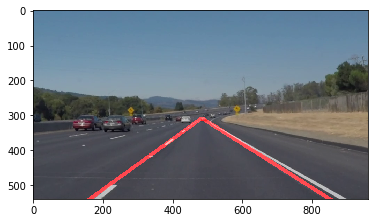

In [130]:
nFrames = 0
white_output = 'test_videos/modified_solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [254]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

(540, 960, 3)
avg_neg_slope(before) =  -0.737822879295
mean_negative_slope =  -0.615656233744
avg_neg_slope =  -0.67673955652
highest =  [467, 314]
bottom =  [-487.57697688360491, 960]
end-points =  467 314 -487 960
avg_pos_slope(before) =  0.613244811917
mean_positive_slope =  0.699813587652
nFrames =  1
avg_pos_slope =  0.656529199785
highest =  [511, 320]
bottom =  [1485.8233592807678, 960]
end points =  511 320 1485 960
[MoviePy] >>>> Building video test_videos/modified_solidYellowLeft.mp4
[MoviePy] Writing video test_videos/modified_solidYellowLeft.mp4



  0%|          | 0/683 [00:00<?, ?it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.67673955652
mean_negative_slope =  -0.615656233744
avg_neg_slope =  -0.656378448928
highest =  [467, 314]
bottom =  [-517.18831552958159, 960]
end-points =  467 314 -517 960
avg_pos_slope(before) =  0.656529199785
mean_positive_slope =  0.699813587652
nFrames =  2
avg_pos_slope =  0.670957329074
highest =  [511, 320]
bottom =  [1464.860956975316, 960]
end points =  511 320 1464 960
(540, 960, 3)



  0%|          | 3/683 [00:00<00:31, 21.70it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
avg_neg_slope(before) = 

 -0.656378448928
mean_negative_slope =  -0.029702970297
avg_neg_slope =  -0.566853380552
highest =  [0, 1000]
bottom =  [70.564984478103241, 960]
end-points =  0 1000 70 960
avg_pos_slope(before) =  0.670957329074
mean_positive_slope =  nan
nFrames =  6



  1%|          | 5/683 [00:00<00:32, 20.59it/s]

avg_pos_slope =  0.670957329074
highest =  [0, 1000]
bottom =  [-59.616309810957262, 960]
end points =  0 1000 -59 960
(540, 960, 3)


(540, 960, 3)



  1%|▏         | 9/683 [00:00<00:42, 15.98it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.566853380552
mean_negative_slope =  nan
avg_neg_slope =  -0.566853380552
highest =  [0, 1000]
bottom =  [70.564984478103241, 960]
end-points =  0 1000 70 960
avg_pos_slope(before) =  0.670957329074
mean_positive_slope =  0.692089203539
nFrames =  9
avg_pos_slope =  0.67307051652
highest =  [530, 331]
bottom =  [1464.523180797989, 960]
end points =  530 331 1464 960
(540, 960, 3)
avg_neg_slope(before) =  -0.566853380552
mean_negative_slope =  nan
avg_neg_slope =  -0.566853380552
highest =  [0, 1000]
bottom =  [70.564984478103241, 960]
end-points =  0 1000 70 960
avg_pos_slope(before) =  0.67307051652
mean_positive_slope =  0.694155058104
nFrames =  10
avg_pos_slope =  0.674987293028
highest =  [530, 331]
bottom =  [1461.8693944271338, 960]
end points =  530 331 1461 960


(540, 960, 3)
avg_neg_slope(before) =  -0.566853380552
mean_negative_slope =  nan
avg_neg_slope =  -0.566853380552
highest =  [0, 1000]
bottom =  [70.564984478103241, 960]
end-points =  0 1000 70 960
avg_pos_slope(before) =  0.674987293028
mean_positive_slope =  0.638079935689
nFrames =  11
avg_pos_slope =  0.671911679916
highest =  [534, 332]
bottom =  [1468.6466489138995, 960]
end points =  534 332 1468 960



  2%|▏         | 11/683 [00:00<00:46, 14.56it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.566853380552
mean_negative_slope =  nan
avg_neg_slope =  -0.566853380552
highest =  [0, 1000]
bottom =  [70.564984478103241, 960]
end-points =  0 1000 70 960
avg_pos_slope(before) =  0.671911679916
mean_positive_slope =  0.635175272086
nFrames =  12
avg_pos_slope =  0.669085802391
highest =  [531, 333]
bottom =  [1468.0995435254883, 960]
end points =  531 333 1468 960
(540, 960, 3)
avg_neg_slope(before) =  -0.566853380552
mean_negative_slope =  nan
avg_neg_slope =  -0.566853380552
highest =  [0, 1000]
bottom =  [70.564984478103241, 960]
end-points =  0 1000 70 960
avg_pos_slope(before) =  0.669085802391
mean_positive_slope =  0.644186731446
nFrames =  13
avg_pos_slope =  0.667307297324
highest =  [532, 333]
bottom =  [1471.597097940959, 960]
end points =  532 333 1471 960
(540, 960, 3)
avg_neg_slope(before) =  -0.566853380552
mean_negative_slope =  nan
avg_neg_slope =  -0.566853380552
highest =  [0, 1000]
bottom =  [70.564984478103241, 960]
end


  2%|▏         | 15/683 [00:00<00:46, 14.33it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.566853380552
mean_negative_slope =  nan
avg_neg_slope =  -0.566853380552
highest =  [0, 1000]
bottom =  [70.564984478103241, 960]
end-points =  0 1000 70 960
avg_pos_slope(before) =  0.66630579107
mean_positive_slope =  0.630063118137
nFrames =  15
avg_pos_slope =  0.664040624012
highest =  [514, 322]
bottom =  [1474.7845919808724, 960]
end points =  514 322 1474 960
(540, 960, 3)
avg_neg_slope(before) =  -0.566853380552
mean_negative_slope =  nan
avg_neg_slope =  -0.566853380552
highest =  [0, 1000]
bottom =  [70.564984478103241, 960]
end-points =  0 1000 70 960
avg_pos_slope(before) =  0.664040624012
mean_positive_slope =  0.638844607657
nFrames =  16
avg_pos_slope =  0.662558505403
highest =  [511, 320]
bottom =  [1476.9524325492116, 960]
end points =  511 320 1476 960


(540, 960, 3)
avg_neg_slope(before) =  -0.566853380552
mean_negative_slope =  nan
avg_neg_slope =  -0.566853380552
highest =  [0, 1000]
bottom =  [70.564984478103241, 960]
end-points =  0 1000 70 960
avg_pos_slope(before) =  0.662558505403
mean_positive_slope =  0.65174623004
nFrames =  17
avg_pos_slope =  0.661957823438
highest =  [511, 320]
bottom =  [1477.8289690660827, 960]
end points =  511 320 1477 960



  2%|▏         | 17/683 [00:01<00:44, 14.94it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.566853380552
mean_negative_slope =  -0.674701419392
avg_neg_slope =  -0.572529593122
highest =  [0, 1000]
bottom =  [69.865384218576068, 960]
end-points =  0 1000 69 960
avg_pos_slope(before) =  0.661957823438
mean_positive_slope =  0.635000564775
nFrames =  18
avg_pos_slope =  0.660539020351
highest =  [513, 321]
bottom =  [1480.391751755659, 960]
end points =  513 321 1480 960
(540, 960, 3)
avg_neg_slope(before) =  -0.572529593122
mean_negative_slope =  nan
avg_neg_slope =  -0.572529593122
highest =  [0, 1000]
bottom =  [69.865384218576068, 960]
end-points =  0 1000 69 960
avg_pos_slope(before) =  0.660539020351
mean_positive_slope =  0.611396071629
nFrames =  19
avg_pos_slope =  0.658081872915
highest =  [512, 321]
bottom =  [1483.0038010467376, 960]
end points =  512 321 1483 960
(540, 960, 3)
avg_neg_slope(before) =  -0.572529593122
mean_negative_slope =  -0.711268925189
avg_neg_slope =  -0.579136227983
highest =  [397, 373]
bottom =  [-61


  3%|▎         | 19/683 [00:01<00:43, 15.38it/s]


mean_positive_slope =  0.648911273153
nFrames =  20
avg_pos_slope =  0.657645177688
highest =  [513, 321]
bottom =  [1484.6485753710101, 960]
end points =  513 321 1484 960
(540, 960, 3)
avg_neg_slope(before) =  -0.579136227983
mean_negative_slope =  -0.710490464637
avg_neg_slope =  -0.585106875103
highest =  [0, 1000]
bottom =  [68.363578864006683, 960]
end-points =  0 1000 68 960
avg_pos_slope(before) =  0.657645177688
mean_positive_slope =  0.642743707074
nFrames =  21
avg_pos_slope =  0.656967838114
highest =  [513, 321]
bottom =  [1485.6503535301706, 960]
end points =  513 321 1485 960



  3%|▎         | 22/683 [00:01<00:39, 16.94it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.585106875103
mean_negative_slope =  -0.714532060774
avg_neg_slope =  -0.590734057089
highest =  [0, 1000]
bottom =  [67.71236484503747, 960]
end-points =  0 1000 67 960
avg_pos_slope(before) =  0.656967838114
mean_positive_slope =  0.633766619737
nFrames =  22
avg_pos_slope =  0.655959089489
highest =  [519, 324]
bottom =  [1488.5726611473765, 960]
end points =  519 324 1488 960
(540, 960, 3)
avg_neg_slope(before) =  -0.590734057089
mean_negative_slope =  -0.7001876954
avg_neg_slope =  -0.595294625352
highest =  [0, 1000]
bottom =  [67.193618582309966, 960]
end-points =  0 1000 67 960
avg_pos_slope(before) =  0.655959089489
mean_positive_slope =  0.646464686839
nFrames =  23
avg_pos_slope =  0.655563489379
highest =  [518, 324]
bottom =  [1488.1577502471159, 960]
end points =  518 324 1488 960
(540, 960, 3)
avg_neg_slope(before) =  -0.595294625352
mean_negative_slope =  -0.689292200826
avg_neg_slope =  -0.599054528371
highest =  [371, 392]
bott


  4%|▍         | 28/683 [00:01<00:34, 19.26it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.606530876408
mean_negative_slope =  -0.696979414819
avg_neg_slope =  -0.609761181352
highest =  [338, 417]
bottom =  [-552.51257542547012, 960]
end-points =  338 417 -552 960
avg_pos_slope(before) =  0.653305633858
mean_positive_slope =  0.633608388124
nFrames =  27
avg_pos_slope =  0.652602160796
highest =  [513, 321]
bottom =  [1492.1570399045399, 960]
end points =  513 321 1492 960
(540, 960, 3)
avg_neg_slope(before) =  -0.609761181352
mean_negative_slope =  -0.774001232258
avg_neg_slope =  -0.615424631383
highest =  [401, 361]
bottom =  [-572.31170943535631, 960]
end-points =  401 361 -572 960
avg_pos_slope(before) =  0.652602160796
mean_positive_slope =  0.639188912717
nFrames =  28
avg_pos_slope =  0.652139635
highest =  [522, 326]
bottom =  [1494.1844310231995, 960]
end points =  522 326 1494 960
(540, 960, 3)
avg_neg_slope(before) =  -0.615424631383
mean_negative_slope =  -0.827246897869
avg_neg_slope =  -0.622485373599
highest =  [396,

(540, 960, 3)
avg_neg_slope(before) =  -0.627553197705
mean_negative_slope =  -0.764832195533
avg_neg_slope =  -0.631843166387
highest =  [390, 368]
bottom =  [-546.94136692938787, 960]
end-points =  390 368 -546 960
avg_pos_slope(before) =  0.65105061147
mean_positive_slope =  0.618146085495
nFrames =  31
avg_pos_slope =  0.650022345034
highest =  [526, 328]
bottom =  [1498.2742684597104, 960]
end points =  526 328 1498 960



  5%|▍         | 31/683 [00:01<00:32, 19.84it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.631843166387
mean_negative_slope =  -0.736490785731
avg_neg_slope =  -0.635014306367
highest =  [447, 326]
bottom =  [-551.40270312443511, 960]
end-points =  447 326 -551 960
avg_pos_slope(before) =  0.650022345034
mean_positive_slope =  0.618367738642
nFrames =  32
avg_pos_slope =  0.649063114537
highest =  [528, 329]
bottom =  [1500.1704806014827, 960]
end points =  528 329 1500 960
(540, 960, 3)
avg_neg_slope(before) =  -0.635014306367
mean_negative_slope =  -0.706608422453
avg_neg_slope =  -0.637120015664
highest =  [423, 347]
bottom =  [-539.14211597325232, 960]
end-points =  423 347 -539 960
avg_pos_slope(before) =  0.649063114537
mean_positive_slope =  0.63533047748
nFrames =  33
avg_pos_slope =  0.648659213447
highest =  [527, 328]
bottom =  [1501.3174642376166, 960]
end points =  527 328 1501 960
(540, 960, 3)
avg_neg_slope(before) =  -0.637120015664
mean_negative_slope =  -0.711419861344
avg_neg_slope =  -0.639242868398
highest =  [44


  5%|▍         | 34/683 [00:01<00:31, 20.43it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.641685876728
mean_negative_slope =  -0.745270026216
avg_neg_slope =  -0.644485448336
highest =  [433, 337]
bottom =  [-533.66263235039139, 960]
end-points =  433 337 -533 960
avg_pos_slope(before) =  0.646507974011
mean_positive_slope =  0.639679725814
nFrames =  36
avg_pos_slope =  0.646323426762
highest =  [531, 330]
bottom =  [1505.7441821133111, 960]
end points =  531 330 1505 960



  5%|▌         | 37/683 [00:02<00:30, 21.27it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.644485448336
mean_negative_slope =  -0.74155875208
avg_neg_slope =  -0.647040008961
highest =  [454, 318]
bottom =  [-538.21066875147847, 960]
end-points =  454 318 -538 960
avg_pos_slope(before) =  0.646323426762
mean_positive_slope =  0.637226209172
nFrames =  37
avg_pos_slope =  0.646084026299
highest =  [532, 331]
bottom =  [1505.5575782655394, 960]
end points =  532 331 1505 960
(540, 960, 3)
avg_neg_slope(before) =  -0.647040008961
mean_negative_slope =  -0.772708250402
avg_neg_slope =  -0.650262271562
highest =  [447, 323]
bottom =  [-532.60473467105544, 960]
end-points =  447 323 -532 960
avg_pos_slope(before) =  0.646084026299
mean_positive_slope =  0.620079681308
nFrames =  38
avg_pos_slope =  0.645417248223
highest =  [533, 331]
bottom =  [1507.5633568550966, 960]
end points =  533 331 1507 960
(540, 960, 3)
avg_neg_slope(before) =  -0.650262271562
mean_negative_slope =  -0.740262360399
avg_neg_slope =  -0.652512273783
highest =  [45


  6%|▋         | 43/683 [00:02<00:29, 21.78it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.657062278403
mean_negative_slope =  -0.731699343199
avg_neg_slope =  -0.658798024096
highest =  [433, 330]
bottom =  [-523.28702114658768, 960]
end-points =  433 330 -523 960
avg_pos_slope(before) =  0.642866776594
mean_positive_slope =  0.613104159718
nFrames =  42
avg_pos_slope =  0.642174622713
highest =  [539, 334]
bottom =  [1513.8127345104238, 960]
end points =  539 334 1513 960
(540, 960, 3)
avg_neg_slope(before) =  -0.658798024096
mean_negative_slope =  -0.729331422648
avg_neg_slope =  -0.660401055881
highest =  [435, 333]
bottom =  [-514.42307317076495, 960]
end-points =  435 333 -514 960
avg_pos_slope(before) =  0.642174622713
mean_positive_slope =  0.612043259909
nFrames =  43
avg_pos_slope =  0.641489819013
highest =  [532, 331]
bottom =  [1512.5299809246119, 960]
end points =  532 331 1512 960
(540, 960, 3)
avg_neg_slope(before) =  -0.660401055881
mean_negative_slope =  -0.725706386195
avg_neg_slope =  -0.661852285444
highest =  [4

[524, 327]
bottom =  [1512.4434265008867, 960]
end points =  524 327 1512 960
(540, 960, 3)
avg_neg_slope(before) =  -0.663446347898
mean_negative_slope =  -0.72818760677



  7%|▋         | 46/683 [00:02<00:31, 20.53it/s]

avg_neg_slope =  -0.664823821491
highest =  [441, 330]
bottom =  [-506.61947396436494, 960]
end-points =  441 330 -506 960
avg_pos_slope(before) =  0.640400839369
mean_positive_slope =  0.605858218976
nFrames =  46
avg_pos_slope =  0.639665889999
highest =  [525, 327]
bottom =  [1514.5791066817562, 960]
end points =  525 327 1514 960
(540, 960, 3)
avg_neg_slope(before) =  -0.664823821491
mean_negative_slope =  -0.734162715619
avg_neg_slope =  -0.666268381785
highest =  [454, 318]
bottom =  [-509.57566643035057, 960]
end-points =  454 318 -509 960
avg_pos_slope(before) =  0.639665889999
mean_positive_slope =  0.635552749311
nFrames =  47
avg_pos_slope =  0.639580199568
highest =  [515, 322]
bottom =  [1512.5293175600807, 960]
end points =  515 322 1512 960
(540, 960, 3)
avg_neg_slope(before) =  -0.666268381785
mean_negative_slope =  -0.737844687405
avg_neg_slope =  -0.667729122716
highest =  [454, 318]
bottom =  [-507.46772420018641, 960]
end-points =  454 318 -507 960
avg_pos_slope(bef


  7%|▋         | 49/683 [00:02<00:37, 16.71it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.669083037956
mean_negative_slope =  -0.739876976575
avg_neg_slope =  -0.670471154399
highest =  [454, 318]
bottom =  [-503.53560132698055, 960]
end-points =  454 318 -503 960
avg_pos_slope(before) =  0.638828492468
mean_positive_slope =  0.609986396471
nFrames =  50
avg_pos_slope =  0.638262961174
highest =  [516, 323]
bottom =  [1514.0212526012308, 960]
end points =  516 323 1514 960
(540, 960, 3)
avg_neg_slope(before) =  -0.670471154399
mean_negative_slope =  -0.724011582549
avg_neg_slope =  -0.671500778017
highest =  [450, 322]
bottom =  [-500.11058942277867, 960]
end-points =  450 322 -500 960
avg_pos_slope(before) =  0.638262961174
mean_positive_slope =  0.613046333097
nFrames =  51
avg_pos_slope =  0.637778026019
highest =  [517, 323]
bottom =  [1515.78009905159, 960]
end points =  517 323 1515 960
(540, 960, 3)



  8%|▊         | 53/683 [00:03<00:45, 13.74it/s]

avg_neg_slope(before) =  -0.671500778017
mean_negative_slope =  -0.737056367103
avg_neg_slope =  -0.672737675925
highest =  [442, 324]
bottom =  [-503.39078568150097, 960]
end-points =  442 324 -503 960
avg_pos_slope(before) =  0.637778026019
mean_positive_slope =  0.611787168697
nFrames =  52
avg_pos_slope =  0.637287632484
highest =  [518, 324]
bottom =  [1515.9795112617833, 960]
end points =  518 324 1515 960
(540, 960, 3)
avg_neg_slope(before) =  -0.672737675925
mean_negative_slope =  -0.737774887437
avg_neg_slope =  -0.67394206873
highest =  [454, 318]
bottom =  [-498.60413288837378, 960]
end-points =  454 318 -498 960
avg_pos_slope(before) =  0.637287632484
mean_positive_slope =  0.611084443564
nFrames =  53
avg_pos_slope =  0.636802388245
highest =  [518, 324]
bottom =  [1516.7399729335357, 960]
end points =  518 324 1516 960
(540, 960, 3)
avg_neg_slope(before) =  -0.67394206873
mean_negative_slope =  -0.73015409368
avg_neg_slope =  -0.674964105548
highest =  [454, 319]
bottom =


  8%|▊         | 55/683 [00:03<00:43, 14.60it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.674964105548
mean_negative_slope =  -0.756907963711
avg_neg_slope =  -0.676427388729
highest =  [457, 317]
bottom =  [-493.5824434577795, 960]
end-points =  457 317 -493 960
avg_pos_slope(before) =  0.636463923024
mean_positive_slope =  0.608280765942
nFrames =  55
avg_pos_slope =  0.635960652362
highest =  [511, 320]
bottom =  [1517.351568486876, 960]
end points =  511 320 1517 960
(540, 960, 3)
avg_neg_slope(before) =  -0.676427388729
mean_negative_slope =  -0.721822075812
avg_neg_slope =  -0.677223786748
highest =  [457, 317]
bottom =  [-492.46458258272872, 960]
end-points =  457 317 -492 960
avg_pos_slope(before) =  0.635960652362
mean_positive_slope =  0.60980900015
nFrames =  56
avg_pos_slope =  0.635501851446
highest =  [511, 320]
bottom =  [1518.0781045628596, 960]
end points =  511 320 1518 960
(540, 960, 3)
avg_neg_slope(before) =  -0.677223786748
mean_negative_slope =  -0.713692693784
avg_neg_slope =  -0.677852561007
highest =  [456,


  9%|▊         | 59/683 [00:03<00:39, 15.79it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.678684323879
mean_negative_slope =  -0.716752050079
avg_neg_slope =  -0.679318785982
highest =  [458, 316]
bottom =  [-490.00852455294864, 960]
end-points =  458 316 -490 960
avg_pos_slope(before) =  0.635729161288
mean_positive_slope =  0.642916000466
nFrames =  59
avg_pos_slope =  0.635848941941
highest =  [509, 319]
bottom =  [1517.1010719994249, 960]
end points =  509 319 1517 960
(540, 960, 3)
avg_neg_slope(before) =  -0.679318785982
mean_negative_slope =  -0.683205346639
avg_neg_slope =  -0.679382500091
highest =  [444, 323]
bottom =  [-493.61614394608984, 960]
end-points =  444 323 -493 960
avg_pos_slope(before) =  0.635848941941
mean_positive_slope =  0.633821495753
nFrames =  60
avg_pos_slope =  0.635815705118
highest =  [507, 318]
bottom =  [1516.7265525723753, 960]
end points =  507 318 1516 960
(540, 960, 3)
avg_neg_slope(before) =  -0.679382500091
mean_negative_slope =  -0.717660788023
avg_neg_slope =  -0.679999891832
highest =  [4


  9%|▉         | 63/683 [00:03<00:41, 14.77it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.680401618297
mean_negative_slope =  -0.714610762961
avg_neg_slope =  -0.680936136183
highest =  [458, 316]
bottom =  [-487.75682766693217, 960]
end-points =  458 316 -487 960
avg_pos_slope(before) =  0.635128437534
mean_positive_slope =  0.624203954519
nFrames =  63
avg_pos_slope =  0.634957742487
highest =  [507, 318]
bottom =  [1518.0909073816542, 960]
end points =  507 318 1518 960
(540, 960, 3)
avg_neg_slope(before) =  -0.680936136183
mean_negative_slope =  -0.710736011159
avg_neg_slope =  -0.681394595798
highest =  [456, 317]
bottom =  [-487.65292000467787, 960]
end-points =  456 317 -487 960
avg_pos_slope(before) =  0.634957742487
mean_positive_slope =  0.60198711502
nFrames =  64
avg_pos_slope =  0.634450502064
highest =  [513, 321]
bottom =  [1520.1707689109646, 960]
end points =  513 321 1520 960
(540, 960, 3)
avg_neg_slope(before) =  -0.681394595798
mean_negative_slope =  -0.710204120928
avg_neg_slope =  -0.681831103754
highest =  [45


 10%|▉         | 67/683 [00:03<00:39, 15.50it/s]

avg_neg_slope(before) =  -0.681831103754
mean_negative_slope =  -0.715874591189
avg_neg_slope =  -0.682339215507
highest =  [458, 316]
bottom =  [-485.81208842205382, 960]
end-points =  458 316 -485 960
avg_pos_slope(before) =  0.634086294494
mean_positive_slope =  0.610174011416
nFrames =  66
avg_pos_slope =  0.633729394747
highest =  [509, 320]
bottom =  [1518.8947678696227, 960]
end points =  509 320 1518 960
(540, 960, 3)
avg_neg_slope(before) =  -0.682339215507
mean_negative_slope =  -0.711651855014
avg_neg_slope =  -0.682770283735
highest =  [457, 317]
bottom =  [-484.7515895426036, 960]
end-points =  457 317 -484 960
avg_pos_slope(before) =  0.633729394747
mean_positive_slope =  0.614488114174
nFrames =  67
avg_pos_slope =  0.633446434738
highest =  [505, 317]
bottom =  [1520.0818833885255, 960]
end points =  505 317 1520 960
(540, 960, 3)
avg_neg_slope(before) =  -0.682770283735
mean_negative_slope =  -0.709050527604
avg_neg_slope =  -0.683151156835
highest =  [458, 316]
bottom


 10%|█         | 71/683 [00:04<00:38, 15.79it/s]

1518 960
(540, 960, 3)
avg_neg_slope(before) =  -0.68346670157
mean_negative_slope =  -0.708788370265
avg_neg_slope =  -0.683823344791
highest =  [462, 314]
bottom =  [-482.68842709335229, 960]
end-points =  462 314 -482 960
avg_pos_slope(before) =  0.633562527408
mean_positive_slope =  0.631895364113
nFrames =  70
avg_pos_slope =  0.633539046235
highest =  [503, 316]
bottom =  [1519.5119321807238, 960]
end points =  503 316 1519 960
(540, 960, 3)
avg_neg_slope(before) =  -0.683823344791
mean_negative_slope =  -0.691257902762
avg_neg_slope =  -0.68392660254
highest =  [453, 323]
bottom =  [-478.38649327872702, 960]
end-points =  453 323 -478 960
avg_pos_slope(before) =  0.633539046235
mean_positive_slope =  0.620999061817
nFrames =  71
avg_pos_slope =  0.633364879784
highest =  [503, 316]
bottom =  [1519.7914586914505, 960]
end points =  503 316 1519 960
(540, 960, 3)
avg_neg_slope(before) =  -0.68392660254
mean_negative_slope =  -0.711204226173
avg_neg_slope =  -0.684300268617
highest


 11%|█         | 75/683 [00:04<00:38, 15.60it/s]

 0.638833962476
nFrames =  73
avg_pos_slope =  0.633374081189
highest =  [502, 316]
bottom =  [1518.7766871528393, 960]
end points =  502 316 1518 960
(540, 960, 3)
avg_neg_slope(before) =  -0.684375365606
mean_negative_slope =  -0.710315065448
avg_neg_slope =  -0.684721228271
highest =  [462, 314]
bottom =  [-481.44964538579683, 960]
end-points =  462 314 -481 960
avg_pos_slope(before) =  0.633374081189
mean_positive_slope =  0.635484471688
nFrames =  74
avg_pos_slope =  0.633402219729
highest =  [501, 315]
bottom =  [1519.3102930643431, 960]
end points =  501 315 1519 960
(540, 960, 3)
avg_neg_slope(before) =  -0.684721228271
mean_negative_slope =  -0.712785129135
avg_neg_slope =  -0.685090490124
highest =  [464, 313]
bottom =  [-480.40078986185495, 960]
end-points =  464 313 -480 960
avg_pos_slope(before) =  0.633402219729
mean_positive_slope =  0.62255454401
nFrames =  75
avg_pos_slope =  0.633259487154
highest =  [501, 315]
bottom =  [1519.5398135902615, 960]
end points =  501 315


 11%|█▏        | 77/683 [00:04<00:39, 15.36it/s]


avg_neg_slope(before) =  -0.685419439358
mean_negative_slope =  -0.715777276765
avg_neg_slope =  -0.685808642402
highest =  [466, 312]
bottom =  [-478.86998258052012, 960]
end-points =  466 312 -478 960
avg_pos_slope(before) =  0.633332035109
mean_positive_slope =  0.636926011175
nFrames =  77
avg_pos_slope =  0.633378111726
highest =  [500, 315]
bottom =  [1518.3490525788877, 960]
end points =  500 315 1518 960
(540, 960, 3)
avg_neg_slope(before) =  -0.685808642402
mean_negative_slope =  -0.713167519937
avg_neg_slope =  -0.686154957308
highest =  [466, 312]
bottom =  [-478.39308948918159, 960]
end-points =  466 312 -478 960
avg_pos_slope(before) =  0.633378111726
mean_positive_slope =  0.629612587728
nFrames =  78
avg_pos_slope =  0.633330446865
highest =  [499, 314]
bottom =  [1519.0046487545574, 960]
end points =  499 314 1519 960
(540, 960, 3)
avg_neg_slope(before) =  -0.686154957308
mean_negative_slope =  -0.710354436588
avg_neg_slope =  -0.686457450799
highest =  [464, 313]
bott


 12%|█▏        | 82/683 [00:04<00:37, 16.18it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.68683645996
mean_negative_slope =  -0.710565757345
avg_neg_slope =  -0.687125841635
highest =  [464, 313]
bottom =  [-477.60335821459716, 960]
end-points =  464 313 -477 960
avg_pos_slope(before) =  0.633944495092
mean_positive_slope =  0.643813674319
nFrames =  81
avg_pos_slope =  0.634064850936
highest =  [501, 315]
bottom =  [1518.2461051075118, 960]
end points =  501 315 1518 960
(540, 960, 3)
avg_neg_slope(before) =  -0.687125841635
mean_negative_slope =  -0.710801667395
avg_neg_slope =  -0.687411092548
highest =  [464, 313]
bottom =  [-477.21262664173048, 960]
end-points =  464 313 -477 960
avg_pos_slope(before) =  0.634064850936
mean_positive_slope =  0.652730425642
nFrames =  82
avg_pos_slope =  0.634289737378
highest =  [501, 315]
bottom =  [1517.8854420792661, 960]
end points =  501 315 1517 960
(540, 960, 3)
avg_neg_slope(before) =  -0.687411092548
mean_negative_slope =  -0.697754810253
avg_neg_slope =  -0.687534232045
highest =  [45


 13%|█▎        | 86/683 [00:05<00:37, 15.98it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.687837394377
mean_negative_slope =  -0.713111170515
avg_neg_slope =  -0.688131275495
highest =  [460, 315]
bottom =  [-477.32115218264391, 960]
end-points =  460 315 -477 960
avg_pos_slope(before) =  0.634737427633
mean_positive_slope =  0.649787781557
nFrames =  85
avg_pos_slope =  0.634912431748
highest =  [501, 315]
bottom =  [1516.8881252710635, 960]
end points =  501 315 1516 960
(540, 960, 3)
avg_neg_slope(before) =  -0.688131275495
mean_negative_slope =  -0.727092755064
avg_neg_slope =  -0.688579108594
highest =  [460, 316]
bottom =  [-475.25927807384545, 960]
end-points =  460 316 -475 960
avg_pos_slope(before) =  0.634912431748
mean_positive_slope =  0.673934702041
nFrames =  86
avg_pos_slope =  0.635360963591
highest =  [501, 315]
bottom =  [1516.1709610153748, 960]
end points =  501 315 1516 960
(540, 960, 3)
avg_neg_slope(before) =  -0.688579108594
mean_negative_slope =  -0.705097239887
avg_neg_slope =  -0.688766814631
highest =  [4


 13%|█▎        | 88/683 [00:05<00:35, 16.58it/s]

 -0.688766814631
mean_negative_slope =  -0.690858412285
avg_neg_slope =  -0.688790315728
highest =  [463, 314]
bottom =  [-474.87613624760388, 960]
end-points =  463 314 -474 960
avg_pos_slope(before) =  0.635723541748
mean_positive_slope =  0.644608171216
nFrames =  88
avg_pos_slope =  0.635823369045
highest =  [499, 314]
bottom =  [1515.0054371234721, 960]
end points =  499 314 1515 960
(540, 960, 3)
avg_neg_slope(before) =  -0.688790315728
mean_negative_slope =  -0.686073582093
avg_neg_slope =  -0.688760129799
highest =  [464, 313]
bottom =  [-475.36912432608881, 960]
end-points =  464 313 -475 960
avg_pos_slope(before) =  0.635823369045
mean_positive_slope =  0.631900190835
nFrames =  89
avg_pos_slope =  0.635779778176
highest =  [503, 317]
bottom =  [1514.3564823414192, 960]
end points =  503 317 1514 960
(540, 960, 3)
avg_neg_slope(before) =  -0.688760129799
mean_negative_slope =  -0.683697076771
avg_neg_slope =  -0.688704491854
highest =  [464, 313]
bottom =  [-475.4450125606468


 13%|█▎        | 92/683 [00:05<00:36, 16.32it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.688798040895
mean_negative_slope =  -0.688402216309
avg_neg_slope =  -0.688793784717
highest =  [468, 311]
bottom =  [-474.22685279752312, 960]
end-points =  468 311 -474 960
avg_pos_slope(before) =  0.635646162434
mean_positive_slope =  0.637382922239
nFrames =  92
avg_pos_slope =  0.63566483727
highest =  [495, 312]
bottom =  [1514.4051361761362, 960]
end points =  495 312 1514 960
(540, 960, 3)
avg_neg_slope(before) =  -0.688793784717
mean_negative_slope =  -0.70053540953
avg_neg_slope =  -0.688918695619
highest =  [471, 310]
bottom =  [-472.50756356830942, 960]
end-points =  471 310 -472 960
avg_pos_slope(before) =  0.63566483727
mean_positive_slope =  0.644195191691
nFrames =  93
avg_pos_slope =  0.635755585722
highest =  [491, 310]
bottom =  [1513.4054882068633, 960]
end points =  491 310 1513 960
(540, 960, 3)
avg_neg_slope(before) =  -0.688918695619
mean_negative_slope =  nan
avg_neg_slope =  -0.688918695619
highest =  [482, 310]
bottom


 14%|█▍        | 96/683 [00:05<00:34, 17.18it/s]

bottom =  [1508.5543531211938, 960]
end points =  490 312 1508 960
(540, 960, 3)
avg_neg_slope(before) =  -0.688918209285
mean_negative_slope =  -0.689375244154
avg_neg_slope =  -0.688922920985
highest =  [470, 313]
bottom =  [-469.1471531753167, 960]
end-points =  470 313 -469 960
avg_pos_slope(before) =  0.6361957985
mean_positive_slope =  0.64281524722
nFrames =  96
avg_pos_slope =  0.63626404024
highest =  [490, 312]
bottom =  [1508.4451092911008, 960]
end points =  490 312 1508 960
(540, 960, 3)
avg_neg_slope(before) =  -0.688922920985
mean_negative_slope =  -0.689328049405
avg_neg_slope =  -0.688927054948
highest =  [468, 315]
bottom =  [-468.23845277571672, 960]
end-points =  468 315 -468 960
avg_pos_slope(before) =  0.63626404024
mean_positive_slope =  0.669230441437
nFrames =  97
avg_pos_slope =  0.636600432089
highest =  [490, 312]
bottom =  [1507.9069434085493, 960]
end points =  490 312 1507 960
(540, 960, 3)
avg_neg_slope(before) =  -0.688927054948
mean_negative_slope =  -


 15%|█▍        | 100/683 [00:06<00:36, 16.13it/s]

 [1510.0315171910636, 960]
end points =  491 311 1510 960
(540, 960, 3)
avg_neg_slope(before) =  -0.688993315892
mean_negative_slope =  -0.693934722842
avg_neg_slope =  -0.689042240713
highest =  [470, 312]
bottom =  [-470.43581323777045, 960]
end-points =  470 312 -470 960
avg_pos_slope(before) =  0.636879222135
mean_positive_slope =  0.602881426202
nFrames =  100
avg_pos_slope =  0.636542610294
highest =  [492, 311]
bottom =  [1511.5703940382855, 960]
end points =  492 311 1511 960
(540, 960, 3)
avg_neg_slope(before) =  -0.689042240713
mean_negative_slope =  -0.68804558774
avg_neg_slope =  -0.689032469605
highest =  [492, 311]
bottom =  [-449.90045988944104, 960]
end-points =  492 311 -449 960
avg_pos_slope(before) =  0.636542610294
mean_positive_slope =  0.64135452776
nFrames =  101
avg_pos_slope =  0.636589785956
highest =  [491, 311]
bottom =  [1510.494836891794, 960]
end points =  491 311 1510 960
(540, 960, 3)
avg_neg_slope(before) =  -0.689032469605
mean_negative_slope =  -0.69


 15%|█▌        | 104/683 [00:06<00:33, 17.08it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.689149048683
mean_negative_slope =  -0.680309224461
avg_neg_slope =  -0.689064859881
highest =  [470, 312]
bottom =  [-470.40494259446547, 960]
end-points =  470 312 -470 960
avg_pos_slope(before) =  0.636965123536
mean_positive_slope =  0.636962523622
nFrames =  104
avg_pos_slope =  0.636965098775
highest =  [491, 311]
bottom =  [1509.8941297543358, 960]
end points =  491 311 1509 960
(540, 960, 3)
avg_neg_slope(before) =  -0.689064859881
mean_negative_slope =  -0.68838643445
avg_neg_slope =  -0.689058459641
highest =  [470, 311]
bottom =  [-471.8649331122142, 960]
end-points =  470 311 -471 960
avg_pos_slope(before) =  0.636965098775
mean_positive_slope =  0.631072021924
nFrames =  105
avg_pos_slope =  0.63690950371
highest =  [492, 311]
bottom =  [1510.9830677975942, 960]
end points =  492 311 1510 960
(540, 960, 3)
avg_neg_slope(before) =  -0.689058459641
mean_negative_slope =  -0.690349180678
avg_neg_slope =  -0.689070522454
highest =  [47


 16%|█▌        | 108/683 [00:06<00:32, 17.70it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.689070522454
mean_negative_slope =  -0.687577749117
avg_neg_slope =  -0.689056827286
highest =  [470, 311]
bottom =  [-471.86716436177204, 960]
end-points =  470 311 -471 960
avg_pos_slope(before) =  0.636909484708
mean_positive_slope =  0.647683021105
nFrames =  108
avg_pos_slope =  0.637008324492
highest =  [491, 311]
bottom =  [1509.8249902666305, 960]
end points =  491 311 1509 960
(540, 960, 3)
avg_neg_slope(before) =  -0.689056827286
mean_negative_slope =  -0.686574761651
avg_neg_slope =  -0.689034263053
highest =  [470, 312]
bottom =  [-470.44670163258127, 960]
end-points =  470 312 -470 960
avg_pos_slope(before) =  0.637008324492
mean_positive_slope =  0.658497295859
nFrames =  109
avg_pos_slope =  0.637203678777
highest =  [492, 312]
bottom =  [1508.9432813757169, 960]
end points =  492 312 1508 960
(540, 960, 3)
avg_neg_slope(before) =  -0.689034263053
mean_negative_slope =  nan
avg_neg_slope =  -0.689034263053
highest =  [466, 312]
b


 16%|█▋        | 112/683 [00:06<00:32, 17.61it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.689049082014
mean_negative_slope =  -0.724110717004
avg_neg_slope =  -0.689359361969
highest =  [471, 310]
bottom =  [-471.90443542099996, 960]
end-points =  471 310 -471 960
avg_pos_slope(before) =  0.637240149188
mean_positive_slope =  0.64601523488
nFrames =  112
avg_pos_slope =  0.637317804813
highest =  [492, 314]
bottom =  [1505.623023115046, 960]
end points =  492 314 1505 960
(540, 960, 3)
avg_neg_slope(before) =  -0.689359361969
mean_negative_slope =  -0.690286431245
avg_neg_slope =  -0.689367494156
highest =  [470, 314]
bottom =  [-467.09089197891552, 960]
end-points =  470 314 -467 960
avg_pos_slope(before) =  0.637317804813
mean_positive_slope =  0.635942910764
nFrames =  113
avg_pos_slope =  0.637305744339
highest =  [487, 310]
bottom =  [1506.9186273989728, 960]
end points =  487 310 1506 960
(540, 960, 3)
avg_neg_slope(before) =  -0.689367494156
mean_negative_slope =  -0.695013583134
avg_neg_slope =  -0.689416590582
highest =  [4


 17%|█▋        | 114/683 [00:06<00:33, 17.15it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.689596837029
mean_negative_slope =  -0.698466657871
avg_neg_slope =  -0.689672647464
highest =  [468, 311]
bottom =  [-473.0261555056432, 960]
end-points =  468 311 -473 960
avg_pos_slope(before) =  0.637240524271
mean_positive_slope =  0.628455028796
nFrames =  116
avg_pos_slope =  0.637165434566
highest =  [488, 310]
bottom =  [1508.1432229963309, 960]
end points =  488 310 1508 960
(540, 960, 3)
avg_neg_slope(before) =  -0.689672647464
mean_negative_slope =  -0.696176494939
avg_neg_slope =  -0.689727764815
highest =  [482, 311]
bottom =  [-458.95095646043495, 960]
end-points =  482 311 -458 960
avg_pos_slope(before) =  0.637165434566
mean_positive_slope =  0.6350045318
nFrames =  117
avg_pos_slope =  0.637147121831
highest =  [491, 310]
bottom = 


 17%|█▋        | 118/683 [00:07<00:48, 11.66it/s]

 [1511.1725437170519, 960]
end points =  491 310 1511 960
(540, 960, 3)
avg_neg_slope(before) =  -0.689727764815
mean_negative_slope =  -0.698444291762
avg_neg_slope =  -0.689801012941
highest =  [471, 310]
bottom =  [-471.30073282881381, 960]
end-points =  471 310 -471 960
avg_pos_slope(before) =  0.637147121831
mean_positive_slope =  0.631341965831
nFrames =  118
avg_pos_slope =  0.637098339007
highest =  [491, 310]
bottom =  [1511.2506586549223, 960]
end points =  491 310 1511 960
(540, 960, 3)
avg_neg_slope(before) =  -0.689801012941
mean_negative_slope =  nan
avg_neg_slope =  -0.689801012941
highest =  [471, 310]
bottom =  [-471.30073282881381, 960]
end-points =  471 310 -471 960
avg_pos_slope(before) =  0.637098339007
mean_positive_slope =  0.646900658702
nFrames =  119
avg_pos_slope =  0.637180025005
highest =  [489, 310]
bottom =  [1509.1198632918608, 960]
end points =  489 310 1509 960



 18%|█▊        | 120/683 [00:07<00:46, 12.15it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.689801012941
mean_negative_slope =  -0.669316879493
avg_neg_slope =  -0.689631722582
highest =  [471, 310]
bottom =  [-471.53204821671045, 960]
end-points =  471 310 -471 960
avg_pos_slope(before) =  0.637180025005
mean_positive_slope =  0.662358013978
nFrames =  120
avg_pos_slope =  0.637388107558
highest =  [490, 310]
bottom =  [1509.7868336298548, 960]
end points =  490 310 1509 960
(540, 960, 3)
avg_neg_slope(before) =  -0.689631722582
mean_negative_slope =  -0.684772796124
avg_neg_slope =  -0.689591895316
highest =  [480, 310]
bottom =  [-462.5864839995163, 960]
end-points =  480 310 -462 960
avg_pos_slope(before) =  0.637388107558
mean_positive_slope =  0.667321847669
nFrames =  121
avg_pos_slope =  0.637633466084
highest =  [488, 310]
bottom =  [1507.3944241859845, 960]
end points =  488 310 1507 960
(540, 960, 3)
avg_neg_slope(before) =  -0.689591895316
mean_negative_slope =  -0.677205048142
avg_neg_slope =  -0.689491189241
highest =  [


 18%|█▊        | 124/683 [00:07<00:43, 12.94it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.689491189241
mean_negative_slope =  -0.714905676356
avg_neg_slope =  -0.689696144782
highest =  [471, 311]
bottom =  [-469.99409560274478, 960]
end-points =  471 311 -469 960
avg_pos_slope(before) =  0.637662773571
mean_positive_slope =  0.657198889744
nFrames =  123
avg_pos_slope =  0.637820322895
highest =  [488, 310]
bottom =  [1507.095780846239, 960]
end points =  488 310 1507 960
(540, 960, 3)
avg_neg_slope(before) =  -0.689696144782
mean_negative_slope =  -0.715682841779
avg_neg_slope =  -0.689904038358
highest =  [471, 310]
bottom =  [-471.16001626383809, 960]
end-points =  471 310 -471 960
avg_pos_slope(before) =  0.637820322895
mean_positive_slope =  0.631786208554
nFrames =  124
avg_pos_slope =  0.63777204998
highest =  [488, 310]
bottom =  [1507.1729161232147, 960]
end points =  488 310 1507 960
(540, 960, 3)
avg_neg_slope(before) =  -0.689904038358
mean_negative_slope =  -0.713666405544
avg_neg_slope =  -0.690092628574
highest =  [4


 18%|█▊        | 126/683 [00:07<00:42, 13.18it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.690092628574
mean_negative_slope =  -0.712414269711
avg_neg_slope =  -0.690268389528
highest =  [471, 312]
bottom =  [-467.76528294065236, 960]
end-points =  471 312 -467 960
avg_pos_slope(before) =  0.63774008903
mean_positive_slope =  0.628598155992
nFrames =  126
avg_pos_slope =  0.637668105306
highest =  [487, 311]
bottom =  [1504.770835016177, 960]
end points =  487 311 1504 960
(540, 960, 3)
avg_neg_slope(before) =  -0.690268389528
mean_negative_slope =  -0.715451702813
avg_neg_slope =  -0.690465134163
highest =  [471, 311]
bottom =  [-468.9460854557671, 960]
end-points =  471 311 -468 960
avg_pos_slope(before) =  0.637668105306
mean_positive_slope =  0.647941613702
nFrames =  127
avg_pos_slope =  0.63774836709
highest =  [482, 310]
bottom =  [1501.2107632764594, 960]
end points =  482 310 1501 960
(540, 960, 3)
avg_neg_slope(before) =  -0.690465134163
mean_negative_slope =  -0.708850592671
avg_neg_slope =  -0.690607657097
highest =  [480


 19%|█▉        | 130/683 [00:08<00:38, 14.41it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.690607657097
mean_negative_slope =  -0.704604363455
avg_neg_slope =  -0.690715324069
highest =  [479, 310]
bottom =  [-462.05339399582527, 960]
end-points =  479 310 -462 960
avg_pos_slope(before) =  0.637719192565
mean_positive_slope =  0.634277624943
nFrames =  129
avg_pos_slope =  0.637692718968
highest =  [484, 310]
bottom =  [1503.2997044903427, 960]
end points =  484 310 1503 960
(540, 960, 3)
avg_neg_slope(before) =  -0.690715324069
mean_negative_slope =  -0.699956649759
avg_neg_slope =  -0.69078586854
highest =  [479, 310]
bottom =  [-461.9572916914675, 960]
end-points =  479 310 -461 960
avg_pos_slope(before) =  0.637692718968
mean_positive_slope =  0.612330303898
nFrames =  130
avg_pos_slope =  0.637499112746
highest =  [485, 310]
bottom =  [1504.6092621992675, 960]
end points =  485 310 1504 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69078586854
mean_negative_slope =  -0.714000028464
avg_neg_slope =  -0.690961733388
highest =  [47


 20%|█▉        | 134/683 [00:08<00:36, 15.21it/s]

avg_neg_slope =  -0.690961733388
highest =  [478, 310]
bottom =  [-462.71779751545438, 960]
end-points =  478 310 -462 960
avg_pos_slope(before) =  0.637297029314
mean_positive_slope =  0.645878467455
nFrames =  132
avg_pos_slope =  0.637361551405
highest =  [485, 310]
bottom =  [1504.8293238224273, 960]
end points =  485 310 1504 960
(540, 960, 3)
avg_neg_slope(before) =  -0.690961733388
mean_negative_slope =  -0.700759873092
avg_neg_slope =  -0.691034853833
highest =  [478, 310]
bottom =  [-462.61825737776684, 960]
end-points =  478 310 -462 960
avg_pos_slope(before) =  0.637361551405
mean_positive_slope =  0.637664367791
nFrames =  133
avg_pos_slope =  0.637363811229
highest =  [485, 310]
bottom =  [1504.8257079369441, 960]
end points =  485 310 1504 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691034853833
mean_negative_slope =  -0.706569573939
avg_neg_slope =  -0.691149925834
highest =  [478, 310]
bottom =  [-462.46165051028044, 960]
end-points =  478 310 -462 960
avg_pos_slope(b


 20%|█▉        | 136/683 [00:08<00:33, 16.33it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.691292772962
mean_negative_slope =  -0.714159001962
avg_neg_slope =  -0.691459679743
highest =  [476, 310]
bottom =  [-464.04035092998248, 960]
end-points =  476 310 -464 960
avg_pos_slope(before) =  0.637129152588
mean_positive_slope =  0.611997412944
nFrames =  136
avg_pos_slope =  0.636945709233
highest =  [483, 310]
bottom =  [1503.4951388755335, 960]
end points =  483 310 1503 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691459679743
mean_negative_slope =  -0.703568937806
avg_neg_slope =  -0.69154742799
highest =  [480, 310]
bottom =  [-459.92107220894843, 960]
end-points =  480 310 -459 960
avg_pos_slope(before) =  0.636945709233
mean_positive_slope =  0.629738595106
nFrames =  137
avg_pos_slope =  0.636893483768
highest =  [484, 310]
bottom =  [1504.5788197958107, 960]
end points =  484 310 1504 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69154742799
mean_negative_slope =  -0.680027355924
avg_neg_slope =  -0.691464549774
highest =  [4


 20%|██        | 140/683 [00:08<00:37, 14.47it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.691394195962
mean_negative_slope =  -0.724757059316
avg_neg_slope =  -0.691630812014
highest =  [479, 310]
bottom =  [-460.8077539474213, 960]
end-points =  479 310 -460 960
avg_pos_slope(before) =  0.636920640523
mean_positive_slope =  0.638561651131
nFrames =  140
avg_pos_slope =  0.636932278897
highest =  [484, 310]
bottom =  [1504.5166570080551, 960]
end points =  484 310 1504 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691630812014
mean_negative_slope =  -0.709845037422
avg_neg_slope =  -0.691759081207
highest =  [482, 310]
bottom =  [-457.63349041339745, 960]
end-points =  482 310 -457 960
avg_pos_slope(before) =  0.636932278897
mean_positive_slope =  0.639243847595
nFrames =  141
avg_pos_slope =  0.636948557549
highest =  [486, 310]
bottom =  [1506.490575409875, 960]
end points =  486 310 1506 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691759081207
mean_negative_slope =  -0.707580952066
avg_neg_slope =  -0.691869723661
highest =  [4


 21%|██        | 145/683 [00:09<00:34, 15.39it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.691869723661
mean_negative_slope =  -0.712362234704
avg_neg_slope =  -0.692012032765
highest =  [479, 310]
bottom =  [-460.2900256409385, 960]
end-points =  479 310 -460 960
avg_pos_slope(before) =  0.636721854003
mean_positive_slope =  0.638644659841
nFrames =  143
avg_pos_slope =  0.636735206822
highest =  [476, 310]
bottom =  [1496.8325109655475, 960]
end points =  476 310 1496 960
(540, 960, 3)
avg_neg_slope(before) =  -0.692012032765
mean_negative_slope =  -0.693325956118
avg_neg_slope =  -0.692021094306
highest =  [477, 310]
bottom =  [-462.27772628395178, 960]
end-points =  477 310 -462 960
avg_pos_slope(before) =  0.636735206822
mean_positive_slope =  0.610282670709
nFrames =  144
avg_pos_slope =  0.636552775538
highest =  [472, 310]
bottom =  [1493.1250739586014, 960]
end points =  472 310 1493 960
(540, 960, 3)
avg_neg_slope(before) =  -0.692021094306
mean_negative_slope =  -0.711520629004
avg_neg_slope =  -0.692154652763
highest =  [


 22%|██▏       | 147/683 [00:09<00:34, 15.62it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.692210224325
mean_negative_slope =  -0.71428056857
avg_neg_slope =  -0.692359348272
highest =  [474, 310]
bottom =  [-464.81883969936155, 960]
end-points =  474 310 -464 960
avg_pos_slope(before) =  0.636409272381
mean_positive_slope =  0.631336573834
nFrames =  147
avg_pos_slope =  0.636374997391
highest =  [485, 311]
bottom =  [1504.8389356289547, 960]
end points =  485 311 1504 960
(540, 960, 3)
avg_neg_slope(before) =  -0.692359348272
mean_negative_slope =  -0.70046701699
avg_neg_slope =  -0.692413762156
highest =  [477, 310]
bottom =  [-461.74506187713126, 960]
end-points =  477 310 -461 960
avg_pos_slope(before) =  0.636374997391
mean_positive_slope =  0.609421909516
nFrames =  148
avg_pos_slope =  0.636194104184
highest =  [474, 310]
bottom =  [1495.7007603898558, 960]
end points =  474 310 1495 960
(540, 960, 3)
avg_neg_slope(before) =  -0.692413762156
mean_negative_slope =  -0.714254568536
avg_neg_slope =  -0.692559367532
highest =  [4


 22%|██▏       | 151/683 [00:09<00:33, 15.93it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.692658398095
mean_negative_slope =  -0.719015561841
avg_neg_slope =  -0.692831800489
highest =  [477, 310]
bottom =  [-461.1786452955119, 960]
end-points =  477 310 -461 960
avg_pos_slope(before) =  0.636047606213
mean_positive_slope =  0.604196547919
nFrames =  151
avg_pos_slope =  0.635838059776
highest =  [473, 310]
bottom =  [1495.2728727949248, 960]
end points =  473 310 1495 960
(540, 960, 3)
avg_neg_slope(before) =  -0.692831800489
mean_negative_slope =  -0.707525900934
avg_neg_slope =  -0.692927840361
highest =  [482, 311]
bottom =  [-454.60546192244669, 960]
end-points =  482 311 -454 960
avg_pos_slope(before) =  0.635838059776
mean_positive_slope =  0.605907031821
nFrames =  152
avg_pos_slope =  0.635642432143
highest =  [483, 310]
bottom =  [1505.5874912234406, 960]
end points =  483 310 1505 960
(540, 960, 3)
avg_neg_slope(before) =  -0.692927840361
mean_negative_slope =  -0.725818529715
avg_neg_slope =  -0.693141416266
highest =  [


 23%|██▎       | 156/683 [00:09<00:29, 17.72it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.693334723545
mean_negative_slope =  -0.723624311234
avg_neg_slope =  -0.693528887569
highest =  [477, 311]
bottom =  [-458.79375226185613, 960]
end-points =  477 311 -458 960
avg_pos_slope(before) =  0.635256611366
mean_positive_slope =  0.618713496967
nFrames =  155
avg_pos_slope =  0.63515056576
highest =  [485, 310]
bottom =  [1508.3793922891525, 960]
end points =  485 310 1508 960
(540, 960, 3)
avg_neg_slope(before) =  -0.693528887569
mean_negative_slope =  -0.69229601495
avg_neg_slope =  -0.693521034877
highest =  [484, 310]
bottom =  [-453.24626552288873, 960]
end-points =  484 310 -453 960
avg_pos_slope(before) =  0.63515056576
mean_positive_slope =  0.630497322992
nFrames =  156
avg_pos_slope =  0.635120927271
highest =  [485, 310]
bottom =  [1508.4271492083976, 960]
end points =  485 310 1508 960
(540, 960, 3)
avg_neg_slope(before) =  -0.693521034877
mean_negative_slope =  -0.722808661633
avg_neg_slope =  -0.693706399603
highest =  [48


 23%|██▎       | 160/683 [00:09<00:28, 18.28it/s]

avg_neg_slope(before) =  -0.693670096043
mean_negative_slope =  -0.688585126051
avg_neg_slope =  -0.69363831498
highest =  [487, 310]
bottom =  [-450.08779627959842, 960]
end-points =  487 310 -450 960
avg_pos_slope(before) =  0.634556035419
mean_positive_slope =  0.616231975066
nFrames =  159
avg_pos_slope =  0.634441510042
highest =  [498, 314]
bottom =  [1516.2183696614209, 960]
end points =  498 314 1516 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69363831498
mean_negative_slope =  -0.703570584553
avg_neg_slope =  -0.693700006096
highest =  [489, 310]
bottom =  [-448.00446055690105, 960]
end-points =  489 310 -448 960
avg_pos_slope(before) =  0.634441510042
mean_positive_slope =  0.58069415064
nFrames =  160
avg_pos_slope =  0.634107675511
highest =  [469, 312]
bottom =  [1490.9084629085005, 960]
end points =  469 312 1490 960
(540, 960, 3)
avg_neg_slope(before) =  -0.693700006096
mean_negative_slope =  -0.68770202244
avg_neg_slope =  -0.693662981505
highest =  [486, 310]
bottom 


 24%|██▍       | 164/683 [00:10<00:28, 18.49it/s]


avg_neg_slope(before) =  -0.693773916839
mean_negative_slope =  -0.678656115859
avg_neg_slope =  -0.693681735126
highest =  [490, 310]
bottom =  [-447.02914043409749, 960]
end-points =  490 310 -447 960
avg_pos_slope(before) =  0.633684775717
mean_positive_slope =  0.600613886094
nFrames =  163
avg_pos_slope =  0.633483123951
highest =  [484, 312]
bottom =  [1506.9159633467257, 960]
end points =  484 312 1506 960
(540, 960, 3)
avg_neg_slope(before) =  -0.693681735126
mean_negative_slope =  -0.680926101122
avg_neg_slope =  -0.693604428253
highest =  [490, 310]
bottom =  [-447.13357862620705, 960]
end-points =  490 310 -447 960
avg_pos_slope(before) =  0.633483123951
mean_positive_slope =  0.608272055799
nFrames =  164
avg_pos_slope =  0.633330329598
highest =  [478, 311]
bottom =  [1502.741702188177, 960]
end points =  478 311 1502 960
(540, 960, 3)
avg_neg_slope(before) =  -0.693604428253
mean_negative_slope =  -0.712719903559
avg_neg_slope =  -0.693719581719
highest =  [490, 310]
bot


 24%|██▍       | 166/683 [00:10<00:30, 16.90it/s]


avg_neg_slope(before) =  -0.693827730629
mean_negative_slope =  -0.722933171193
avg_neg_slope =  -0.694000977299
highest =  [486, 310]
bottom =  [-450.59810470268656, 960]
end-points =  486 310 -450 960
avg_pos_slope(before) =  0.632821432686
mean_positive_slope =  0.579939140214
nFrames =  167
avg_pos_slope =  0.632506657135
highest =  [485, 310]
bottom =  [1512.6571679799918, 960]
end points =  485 310 1512 960
(540, 960, 3)
avg_neg_slope(before) =  -0.694000977299
mean_negative_slope =  -0.759140827745
avg_neg_slope =  -0.694386420201
highest =  [484, 310]
bottom =  [-452.07821393145809, 960]
end-points =  484 310 -452 960
avg_pos_slope(before) =  0.632506657135
mean_positive_slope =  0.580645253058
nFrames =  168
avg_pos_slope =  0.632199784922
highest =  [485, 310]
bottom =  [1513.1559967321512, 960]
end points =  485 310 1513 960
(540, 960, 3)
avg_neg_slope(before) =  -0.694386420201
mean_negative_slope =  -0.717527292438
avg_neg_slope =  -0.694522542979
highest =  [491, 310]
bo


 25%|██▍       | 170/683 [00:10<00:32, 15.75it/s]

485 310 1513 960
(540, 960, 3)
avg_neg_slope(before) =  -0.694522542979
mean_negative_slope =  -0.710688059727
avg_neg_slope =  -0.694617078165
highest =  [491, 310]
bottom =  [-444.76737519553541, 960]
end-points =  491 310 -444 960
avg_pos_slope(before) =  0.63190777621
mean_positive_slope =  0.583848564807
nFrames =  170
avg_pos_slope =  0.63162672819
highest =  [475, 311]
bottom =  [1502.5055994854497, 960]
end points =  475 311 1502 960
(540, 960, 3)
avg_neg_slope(before) =  -0.694617078165
mean_negative_slope =  -0.709290835562
avg_neg_slope =  -0.694702390708
highest =  [485, 310]
bottom =  [-450.65245880038827, 960]
end-points =  485 310 -450 960
avg_pos_slope(before) =  0.63162672819
mean_positive_slope =  0.58444508728
nFrames =  171
avg_pos_slope =  0.631352416324
highest =  [487, 312]
bottom =  [1513.3681317204382, 960]
end points =  487 312 1513 960
(540, 960, 3)
avg_neg_slope(before) =  -0.694702390708
mean_negative_slope =  -0.708414975836
avg_neg_slope =  -0.69478165420


 26%|██▌       | 175/683 [00:10<00:28, 17.56it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.694878943374
mean_negative_slope =  -0.701370759402
avg_neg_slope =  -0.694916039465
highest =  [487, 310]
bottom =  [-448.36479673164405, 960]
end-points =  487 310 -448 960
avg_pos_slope(before) =  0.630611353679
mean_positive_slope =  0.580582624836
nFrames =  174
avg_pos_slope =  0.630325475228
highest =  [487, 311]
bottom =  [1516.6267967986037, 960]
end points =  487 311 1516 960
(540, 960, 3)
avg_neg_slope(before) =  -0.694916039465
mean_negative_slope =  -0.7748862643
avg_neg_slope =  -0.695370415743
highest =  [487, 310]
bottom =  [-447.75360079233553, 960]
end-points =  487 310 -447 960
avg_pos_slope(before) =  0.630325475228
mean_positive_slope =  0.573494159061
nFrames =  175
avg_pos_slope =  0.630002570023
highest =  [483, 310]
bottom =  [1514.7418228569229, 960]
end points =  483 310 1514 960
(540, 960, 3)
avg_neg_slope(before) =  -0.695370415743
mean_negative_slope =  -0.740462267257
avg_neg_slope =  -0.695625171966
highest =  [4


 26%|██▋       | 180/683 [00:11<00:27, 18.44it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.695936148008
mean_negative_slope =  -0.740676063687
avg_neg_slope =  -0.696186091671
highest =  [483, 310]
bottom =  [-450.65841084280214, 960]
end-points =  483 310 -450 960
avg_pos_slope(before) =  0.629479024087
mean_positive_slope =  0.590524304121
nFrames =  178
avg_pos_slope =  0.629261399954
highest =  [487, 310]
bottom =  [1519.9570509933717, 960]
end points =  487 310 1519 960
(540, 960, 3)
avg_neg_slope(before) =  -0.696186091671
mean_negative_slope =  -0.764838572162
avg_neg_slope =  -0.69656749434
highest =  [483, 310]
bottom =  [-450.14719001625974, 960]
end-points =  483 310 -450 960
avg_pos_slope(before) =  0.629261399954
mean_positive_slope =  0.569661962356
nFrames =  179
avg_pos_slope =  0.628930291967
highest =  [491, 310]
bottom =  [1524.5008637717081, 960]
end points =  491 310 1524 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69656749434
mean_negative_slope =  -0.764961647806
avg_neg_slope =  -0.696945362591
highest =  [4


 27%|██▋       | 184/683 [00:11<00:26, 19.05it/s]

avg_neg_slope(before) =  -0.697322886616
mean_negative_slope =  -0.766440850608
avg_neg_slope =  -0.697700580409
highest =  [485, 310]
bottom =  [-446.63173179449319, 960]
end-points =  485 310 -446 960
avg_pos_slope(before) =  0.628336970957
mean_positive_slope =  0.54991396483
nFrames =  182
avg_pos_slope =  0.62790842994
highest =  [483, 310]
bottom =  [1518.1827894105083, 960]
end points =  483 310 1518 960
(540, 960, 3)
avg_neg_slope(before) =  -0.697700580409
mean_negative_slope =  -0.766721402089
avg_neg_slope =  -0.69807569357
highest =  [485, 310]
bottom =  [-446.13111656421825, 960]
end-points =  485 310 -446 960
avg_pos_slope(before) =  0.62790842994
mean_positive_slope =  0.512448638126
nFrames =  183
avg_pos_slope =  0.627280931072
highest =  [485, 311]
bottom =  [1519.6241498065647, 960]
end points =  485 311 1519 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69807569357
mean_negative_slope =  -0.766256398204
avg_neg_slope =  -0.698444237919
highest =  [482, 310]
bottom =


 27%|██▋       | 186/683 [00:11<00:25, 19.24it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.698804029932
mean_negative_slope =  -0.777978713827
avg_neg_slope =  -0.699227423964
highest =  [486, 310]
bottom =  [-443.59740668543793, 960]
end-points =  486 310 -443 960
avg_pos_slope(before) =  0.62647476819
mean_positive_slope =  0.55075103173
nFrames =  186
avg_pos_slope =  0.626069828422
highest =  [482, 310]
bottom =  [1520.2228475024158, 960]
end points =  482 310 1520 960
(540, 960, 3)
avg_neg_slope(before) =  -0.699227423964
mean_negative_slope =  -0.768760634101
avg_neg_slope =  -0.699597281464
highest =  [486, 310]
bottom =  [-443.10595455628703, 960]
end-points =  486 310 -443 960
avg_pos_slope(before) =  0.626069828422
mean_positive_slope =  0.546011018992
nFrames =  187
avg_pos_slope =  0.625643983691
highest =  [484, 312]
bottom =  [1519.7328079409701, 960]
end points =  484 312 1519 960
(540, 960, 3)
avg_neg_slope(before) =  -0.699597281464
mean_negative_slope =  -0.746954368725
avg_neg_slope =  -0.699847848064
highest =  [4


 28%|██▊       | 191/683 [00:11<00:25, 19.40it/s]

 -0.700243296935
mean_negative_slope =  -0.765290667685
avg_neg_slope =  -0.700583859085
highest =  [485, 310]
bottom =  [-442.79756708756639, 960]
end-points =  485 310 -442 960
avg_pos_slope(before) =  0.625002085277
mean_positive_slope =  0.566747691193
nFrames =  190
avg_pos_slope =  0.624697088449
highest =  [473, 311]
bottom =  [1511.9035133993011, 960]
end points =  473 311 1511 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700583859085
mean_negative_slope =  -0.765870568389
avg_neg_slope =  -0.700923894029
highest =  [484, 310]
bottom =  [-443.34747029856408, 960]
end-points =  484 310 -443 960
avg_pos_slope(before) =  0.624697088449
mean_positive_slope =  0.580171637507
nFrames =  191
avg_pos_slope =  0.624465185059
highest =  [484, 311]
bottom =  [1523.2893239340419, 960]
end points =  484 311 1523 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700923894029
mean_negative_slope =  -0.772411672851
avg_neg_slope =  -0.701294297028
highest =  [485, 310]
bottom =  [-441.85767266918


 28%|██▊       | 194/683 [00:11<00:29, 16.69it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.700195665269
mean_negative_slope =  -0.772157687792
avg_neg_slope =  -0.700562818445
highest =  [484, 310]
bottom =  [-443.82543247582646, 960]
end-points =  484 310 -443 960
avg_pos_slope(before) =  0.623686154159
mean_positive_slope =  0.580891152174
nFrames =  195
avg_pos_slope =  0.623467812312
highest =  [491, 310]
bottom =  [1533.5558259208285, 960]
end points =  491 310 1533 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700562818445
mean_negative_slope =  -0.765545095931
avg_neg_slope =  -0.700892677721
highest =  [484, 310]
bottom =  [-443.38877243402834, 960]
end-points =  484 310 -443 960
avg_pos_slope(before) =  0.623467812312
mean_positive_slope =  0.565531979938
nFrames =  196
avg_pos_slope =  0.623173721792
highest =  [490, 310]
bottom =  [1533.0478328426568, 960]
end points =  490 310 1533 960



 29%|██▉       | 198/683 [00:12<00:30, 15.86it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.700892677721
mean_negative_slope =  -0.789760498809
avg_neg_slope =  -0.701341505101
highest =  [472, 311]
bottom =  [-453.36944595476206, 960]
end-points =  472 311 -453 960
avg_pos_slope(before) =  0.623173721792
mean_positive_slope =  0.565842280021
nFrames =  197
avg_pos_slope =  0.622884169056
highest =  [477, 311]
bottom =  [1518.9272671248734, 960]
end points =  477 311 1518 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701341505101
mean_negative_slope =  -0.769251087642
avg_neg_slope =  -0.701682759284
highest =  [483, 310]
bottom =  [-443.34455015408577, 960]
end-points =  483 310 -443 960
avg_pos_slope(before) =  0.622884169056
mean_positive_slope =  0.577278653124
nFrames =  198
avg_pos_slope =  0.622654995609
highest =  [471, 310]
bottom =  [1514.9167831039588, 960]
end points =  471 310 1514 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701682759284
mean_negative_slope =  -0.782045427506
avg_neg_slope =  -0.702084572625
highest =  


 30%|██▉       | 203/683 [00:12<00:27, 17.52it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.702395501597
mean_negative_slope =  -0.753741696299
avg_neg_slope =  -0.70264969068
highest =  [483, 310]
bottom =  [-442.0697874370627, 960]
end-points =  483 310 -442 960
avg_pos_slope(before) =  0.622252234541
mean_positive_slope =  0.589576482979
nFrames =  201
avg_pos_slope =  0.622090473395
highest =  [490, 310]
bottom =  [1534.8640958164194, 960]
end points =  490 310 1534 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70264969068
mean_negative_slope =  -0.768889837766
avg_neg_slope =  -0.702975996823
highest =  [483, 310]
bottom =  [-441.64039019452969, 960]
end-points =  483 310 -441 960
avg_pos_slope(before) =  0.622090473395
mean_positive_slope =  0.573573928007
nFrames =  202
avg_pos_slope =  0.621851475635
highest =  [470, 310]
bottom =  [1515.2656710940319, 960]
end points =  470 310 1515 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702975996823
mean_negative_slope =  -0.773955308839
avg_neg_slope =  -0.703323934627
highest =  [47


 30%|███       | 205/683 [00:12<00:32, 14.80it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.703655407858
mean_negative_slope =  -0.772899183236
avg_neg_slope =  -0.70399154269
highest =  [480, 310]
bottom =  [-443.30654643367075, 960]
end-points =  480 310 -443 960
avg_pos_slope(before) =  0.621408714885
mean_positive_slope =  0.579885525836
nFrames =  205
avg_pos_slope =  0.621207146006
highest =  [491, 310]
bottom =  [1537.3498434929572, 960]
end points =  491 310 1537 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70399154269
mean_negative_slope =  -0.743841044807
avg_neg_slope =  -0.704184052362
highest =  [482, 310]
bottom =  [-441.0541331052641, 960]
end-points =  482 310 -441 960
avg_pos_slope(before) =  0.621207146006
mean_positive_slope =  0.562893964224
nFrames =  206
avg_pos_slope =  0.620925439814
highest =  [489, 310]
bottom =  [1535.8245594752666, 960]
end points =  489 310 1535 960
(540, 960, 3)



 30%|███       | 207/683 [00:12<00:35, 13.37it/s]

avg_neg_slope(before) =  -0.704184052362
mean_negative_slope =  -0.749191299628
avg_neg_slope =  -0.704400433359
highest =  [473, 315]
bottom =  [-442.67234978022702, 960]
end-points =  473 315 -442 960
avg_pos_slope(before) =  0.620925439814
mean_positive_slope =  0.57723229384
nFrames =  207
avg_pos_slope =  0.620715376612
highest =  [469, 311]
bottom =  [1514.5677826807644, 960]
end points =  469 311 1514 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704400433359
mean_negative_slope =  -0.740039518327
avg_neg_slope =  -0.704570955297
highest =  [483, 310]
bottom =  [-439.54725391905538, 960]
end-points =  483 310 -439 960
avg_pos_slope(before) =  0.620715376612
mean_positive_slope =  0.580994919842
nFrames =  208
avg_pos_slope =  0.62052532658
highest =  [488, 311]
bottom =  [1533.888011658461, 960]
end points =  488 311 1533 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704570955297
mean_negative_slope =  -0.752772950097
avg_neg_slope =  -0.704800488605
highest =  [475, 312]
bottom


 31%|███       | 209/683 [00:12<00:35, 13.53it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.704800488605
mean_negative_slope =  -0.761479191072
avg_neg_slope =  -0.705069108048
highest =  [475, 312]
bottom =  [-444.0588448753287, 960]
end-points =  475 312 -444 960
avg_pos_slope(before) =  0.620330795922
mean_positive_slope =  0.597793896118
nFrames =  210
avg_pos_slope =  0.620223985971
highest =  [488, 310]
bottom =  [1536.0084851645768, 960]
end points =  488 310 1536 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705069108048
mean_negative_slope =  -0.727010303104
avg_neg_slope =  -0.705172604251
highest =  [483, 310]
bottom =  [-438.76014224231471, 960]
end-points =  483 310 -438 960
avg_pos_slope(before) =  0.620223985971
mean_positive_slope =  0.571910022081
nFrames =  211
avg_pos_slope =  0.619996089915
highest =  [472, 314]
bottom =  [1513.9420549714359, 960]
end points =  472 314 1513 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705172604251
mean_negative_slope =  -0.740285933785
avg_neg_slope =  -0.705337455564
highest =  [


 31%|███▏      | 215/683 [00:13<00:30, 15.23it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.705337455564
mean_negative_slope =  -0.741883617294
avg_neg_slope =  -0.70550823202
highest =  [475, 313]
bottom =  [-442.06938436035301, 960]
end-points =  475 313 -442 960
avg_pos_slope(before) =  0.619886751252
mean_positive_slope =  0.579901872734
nFrames =  213
avg_pos_slope =  0.619699906025
highest =  [482, 313]
bottom =  [1526.0537326369376, 960]
end points =  482 313 1526 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70550823202
mean_negative_slope =  -0.740846525518
avg_neg_slope =  -0.705672596176
highest =  [490, 310]
bottom =  [-431.10704528167287, 960]
end-points =  490 310 -431 960
avg_pos_slope(before) =  0.619699906025
mean_positive_slope =  0.587289417868
nFrames =  214
avg_pos_slope =  0.619549159568
highest =  [488, 310]
bottom =  [1537.1499987715524, 960]
end points =  488 310 1537 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705672596176
mean_negative_slope =  -0.745673971797
avg_neg_slope =  -0.70585778773
highest =  [47


 32%|███▏      | 217/683 [00:13<00:29, 15.82it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.705928599741
mean_negative_slope =  -0.736296116284
avg_neg_slope =  -0.706067900276
highest =  [488, 310]
bottom =  [-432.59134786650435, 960]
end-points =  488 310 -432 960
avg_pos_slope(before) =  0.619278469557
mean_positive_slope =  0.588510148901
nFrames =  217
avg_pos_slope =  0.619137330471
highest =  [478, 312]
bottom =  [1524.6175565714002, 960]
end points =  478 312 1524 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706067900276
mean_negative_slope =  -0.765336666896
avg_neg_slope =  -0.706338533913
highest =  [478, 311]
bottom =  [-440.82287152664651, 960]
end-points =  478 311 -440 960
avg_pos_slope(before) =  0.619137330471
mean_positive_slope =  0.588353349276
nFrames =  218
avg_pos_slope =  0.618996764347
highest =  [486, 310]
bottom =  [1536.0862644824845, 960]
end points =  486 310 1536 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706338533913
mean_negative_slope =  nan
avg_neg_slope =  -0.706338533913
highest =  [478, 311]
b


 32%|███▏      | 221/683 [00:13<00:29, 15.66it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.706529434093
mean_negative_slope =  -0.71077714608
avg_neg_slope =  -0.706548567931
highest =  [487, 310]
bottom =  [-432.96506610106906, 960]
end-points =  487 310 -432 960
avg_pos_slope(before) =  0.618725464726
mean_positive_slope =  0.589328887327
nFrames =  221
avg_pos_slope =  0.618593047711
highest =  [468, 311]
bottom =  [1517.1550178286682, 960]
end points =  468 311 1517 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706548567931
mean_negative_slope =  -0.703663901166
avg_neg_slope =  -0.706535632205
highest =  [479, 310]
bottom =  [-440.98190943483831, 960]
end-points =  479 310 -440 960
avg_pos_slope(before) =  0.618593047711
mean_positive_slope =  0.597436390279
nFrames =  222
avg_pos_slope =  0.618498174808
highest =  [473, 311]
bottom =  [1522.315950207432, 960]
end points =  473 311 1522 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706535632205
mean_negative_slope =  -0.737283585832
avg_neg_slope =  -0.706672899855
highest =  [4


 33%|███▎      | 225/683 [00:13<00:30, 14.88it/s]


highest =  [475, 312]
bottom =  [-441.80957703088404, 960]
end-points =  475 312 -441 960
avg_pos_slope(before) =  0.618432032452
mean_positive_slope =  0.613094346538
nFrames =  224
avg_pos_slope =  0.618408309403
highest =  [479, 311]
bottom =  [1528.4684339319899, 960]
end points =  479 311 1528 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706798899395
mean_negative_slope =  -0.714320209929
avg_neg_slope =  -0.70683217953
highest =  [480, 310]
bottom =  [-439.59593638243138, 960]
end-points =  480 310 -439 960
avg_pos_slope(before) =  0.618408309403
mean_positive_slope =  0.61226979574
nFrames =  225
avg_pos_slope =  0.618381147838
highest =  [491, 311]
bottom =  [1540.5145304293692, 960]
end points =  491 311 1540 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70683217953
mean_negative_slope =  -0.741904468591
avg_neg_slope =  -0.706986683006
highest =  [476, 312]
bottom =  [-440.56606210019226, 960]
end-points =  476 312 -440 960
avg_pos_slope(before) =  0.618381147838
mean_posit


 33%|███▎      | 227/683 [00:14<00:32, 14.10it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707153748729
mean_negative_slope =  -0.731096906724
avg_neg_slope =  -0.707258304004
highest =  [476, 310]
bottom =  [-443.04187808062835, 960]
end-points =  476 310 -443 960
avg_pos_slope(before) =  0.618140102238
mean_positive_slope =  0.610519609996
nFrames =  228
avg_pos_slope =  0.618106824979
highest =  [481, 310]
bottom =  [1532.5981602723198, 960]
end points =  481 310 1532 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707258304004
mean_negative_slope =  -0.740152179486
avg_neg_slope =  -0.707401320854
highest =  [475, 310]
bottom =  [-443.85607340303585, 960]
end-points =  475 310 -443 960
avg_pos_slope(before) =  0.618106824979
mean_positive_slope =  0.61189370699
nFrames =  229
avg_pos_slope =  0.618079811423
highest =  [487, 310]
bottom =  [1538.6441210135813, 960]
end points =  487 310 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707401320854
mean_negative_slope =  -0.714657270312
avg_neg_slope =  -0.707432731891
highest =  [


 34%|███▍      | 231/683 [00:14<00:34, 13.29it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707432731891
mean_negative_slope =  -0.709900847315
avg_neg_slope =  -0.707443370319
highest =  [476, 310]
bottom =  [-442.80145785630441, 960]
end-points =  476 310 -442 960
avg_pos_slope(before) =  0.618027033787
mean_positive_slope =  0.570519008251
nFrames =  231
avg_pos_slope =  0.617822257815
highest =  [474, 310]
bottom =  [1526.082523375771, 960]
end points =  474 310 1526 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707443370319
mean_negative_slope =  nan
avg_neg_slope =  -0.707443370319
highest =  [474, 310]
bottom =  [-444.80145785630447, 960]
end-points =  474 310 -444 960
avg_pos_slope(before) =  0.617822257815
mean_positive_slope =  0.553398058252
nFrames =  232
avg_pos_slope =  0.617545759105
highest =  [488, 310]
bottom =  [1540.5535807133658, 960]
end points =  488 310 1540 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707443370319
mean_negative_slope =  -0.706800169212
avg_neg_slope =  -0.707440621596
highest =  [476, 310]
bo


 34%|███▍      | 233/683 [00:14<00:40, 11.13it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707440621596
mean_negative_slope =  -0.709217160089
avg_neg_slope =  -0.707448181335
highest =  [476, 310]
bottom =  [-442.79520952851539, 960]
end-points =  476 310 -442 960
avg_pos_slope(before) =  0.61757107945
mean_positive_slope =  0.587089527331
nFrames =  234
avg_pos_slope =  0.617441370717
highest =  [481, 312]
bottom =  [1530.4923578688049, 960]
end points =  481 312 1530 960
(540, 960, 3)


avg_neg_slope(before) =  -0.707448181335
mean_negative_slope =  -0.712772861503
avg_neg_slope =  -0.707470743539
highest =  [475, 311]
bottom =  [-442.35242188765574, 960]
end-points =  475 311 -442 960
avg_pos_slope(before) =  0.617441370717
mean_positive_slope =  0.619049390842
nFrames =  235
avg_pos_slope =  0.617448184362
highest =  [488, 310]
bottom =  [1540.7199147432798, 960]
end points =  488 310 1540 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707470743539
mean_negative_slope =  -0.692502844498
avg_neg_slope =  -0.707407587847
highest =  [477, 312]
bottom =  [-439.02070875787058, 960]
end-points =  477 312 -439 960
avg_pos_slope(before) =  0.617448184362
mean_positive_slope =  0.577416000376
nFrames =  236
avg_pos_slope =  0.617279272193
highest =  [476, 311]
bottom =  [1527.3879685186396, 960]
end points =  476 311 1527 960



 34%|███▍      | 235/683 [00:14<00:46,  9.55it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707407587847
mean_negative_slope =  -0.717978805202
avg_neg_slope =  -0.707452004726
highest =  [475, 311]
bottom =  [-442.37672049013901, 960]
end-points =  475 311 -442 960
avg_pos_slope(before) =  0.617279272193
mean_positive_slope =  0.592489721325
nFrames =  237
avg_pos_slope =  0.617175114417
highest =  [476, 310]
bottom =  [1529.1856920615935, 960]
end points =  476 310 1529 960
(540, 960, 3)



 35%|███▍      | 237/683 [00:15<00:57,  7.71it/s]

avg_neg_slope(before) =  -0.707452004726
mean_negative_slope =  -0.70375022464
avg_neg_slope =  -0.707436516107
highest =  [474, 310]
bottom =  [-444.81035994183526, 960]
end-points =  474 310 -444 960
avg_pos_slope(before) =  0.617175114417
mean_positive_slope =  0.600763618904
nFrames =  238
avg_pos_slope =  0.617106447071
highest =  [481, 310]
bottom =  [1534.3028832947459, 960]
end points =  481 310 1534 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707436516107
mean_negative_slope =  -0.714620526517
avg_neg_slope =  -0.707466449483
highest =  [473, 310]
bottom =  [-445.77148446350168, 960]
end-points =  473 310 -445 960
avg_pos_slope(before) =  0.617106447071
mean_positive_slope =  0.596935555021
nFrames =  239
avg_pos_slope =  0.617022401688
highest =  [487, 310]
bottom =  [1540.4463549816244, 960]
end points =  487 310 1540 960
(540, 960, 3)



 35%|███▌      | 241/683 [00:15<00:44,  9.88it/s]

avg_neg_slope(before) =  -0.707466449483
mean_negative_slope =  -0.70847507286
avg_neg_slope =  -0.707470634643
highest =  [475, 310]
bottom =  [-443.76604931923305, 960]
end-points =  475 310 -443 960
avg_pos_slope(before) =  0.617022401688
mean_positive_slope =  0.60595884167
nFrames =  240
avg_pos_slope =  0.6169764948
highest =  [487, 310]
bottom =  [1540.5247379415641, 960]
end points =  487 310 1540 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707470634643
mean_negative_slope =  -0.711748677003
avg_neg_slope =  -0.707488312504
highest =  [476, 310]
bottom =  [-442.74309230606468, 960]
end-points =  476 310 -442 960
avg_pos_slope(before) =  0.6169764948
mean_positive_slope =  0.605625017924
nFrames =  241
avg_pos_slope =  0.616929587871
highest =  [488, 310]
bottom =  [1541.6048404545627, 960]
end points =  488 310 1541 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707488312504
mean_negative_slope =  -0.71292720738
avg_neg_slope =  -0.707510694787
highest =  [473, 311]
bottom =  


 36%|███▌      | 245/683 [00:15<00:33, 13.05it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707510694787
mean_negative_slope =  -0.720072810584
avg_neg_slope =  -0.707562178868
highest =  [481, 311]
bottom =  [-436.2338762341754, 960]
end-points =  481 311 -436 960
avg_pos_slope(before) =  0.616842122435
mean_positive_slope =  0.588790601111
nFrames =  243
avg_pos_slope =  0.616727157184
highest =  [483, 310]
bottom =  [1536.9506691550368, 960]
end points =  483 310 1536 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707562178868
mean_negative_slope =  -0.681758885004
avg_neg_slope =  -0.707456859301
highest =  [476, 311]
bottom =  [-441.37042544311191, 960]
end-points =  476 311 -441 960
avg_pos_slope(before) =  0.616727157184
mean_positive_slope =  0.637854648707
nFrames =  244
avg_pos_slope =  0.616813391843
highest =  [485, 310]
bottom =  [1538.8033197653335, 960]
end points =  485 310 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707456859301
mean_negative_slope =  -0.700890312544
avg_neg_slope =  -0.707430166022
highest =  [


 36%|███▌      | 247/683 [00:15<00:31, 13.85it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707448095097
mean_negative_slope =  -0.712668006047
avg_neg_slope =  -0.707469143125
highest =  [476, 313]
bottom =  [-438.52751867306199, 960]
end-points =  476 313 -438 960
avg_pos_slope(before) =  0.616574247106
mean_positive_slope =  0.57334009078
nFrames =  247
avg_pos_slope =  0.61639991583
highest =  [474, 312]
bottom =  [1525.2655556212899, 960]
end points =  474 312 1525 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707469143125
mean_negative_slope =  -0.695346843955
avg_neg_slope =  -0.707420459193
highest =  [488, 310]
bottom =  [-430.83121494921869, 960]
end-points =  488 310 -430 960
avg_pos_slope(before) =  0.61639991583
mean_positive_slope =  0.589064618153
nFrames =  248
avg_pos_slope =  0.616290135518
highest =  [486, 311]
bottom =  [1539.0754308673133, 960]
end points =  486 311 1539 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707420459193
mean_negative_slope =  -0.69967667766
avg_neg_slope =  -0.707389484067
highest =  [481


 37%|███▋      | 251/683 [00:16<00:30, 14.30it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707389484067
mean_negative_slope =  -0.744155487937
avg_neg_slope =  -0.70753596217
highest =  [468, 313]
bottom =  [-446.44115153660249, 960]
end-points =  468 313 -446 960
avg_pos_slope(before) =  0.616158659563
mean_positive_slope =  0.613063285638
nFrames =  250
avg_pos_slope =  0.616146327396
highest =  [487, 311]
bottom =  [1540.3212179369473, 960]
end points =  487 311 1540 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70753596217
mean_negative_slope =  -0.710820087067
avg_neg_slope =  -0.707548994411
highest =  [474, 312]
bottom =  [-441.83763826718746, 960]
end-points =  474 312 -441 960
avg_pos_slope(before) =  0.616146327396
mean_positive_slope =  0.582733217117
nFrames =  251
avg_pos_slope =  0.616013735688
highest =  [475, 312]
bottom =  [1526.9245959277787, 960]
end points =  475 312 1526 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707548994411
mean_negative_slope =  -0.708078080736
avg_neg_slope =  -0.707551085662
highest =  [4


 37%|███▋      | 255/683 [00:16<00:28, 15.11it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707651495193
mean_negative_slope =  -0.700764811255
avg_neg_slope =  -0.70762448859
highest =  [480, 312]
bottom =  [-435.73993049846996, 960]
end-points =  480 312 -435 960
avg_pos_slope(before) =  0.615915222144
mean_positive_slope =  0.60792105622
nFrames =  254
avg_pos_slope =  0.615883872474
highest =  [469, 311]
bottom =  [1522.7700839496017, 960]
end points =  469 311 1522 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70762448859
mean_negative_slope =  -0.711660541533
avg_neg_slope =  -0.707640254421
highest =  [488, 310]
bottom =  [-430.5458231619661, 960]
end-points =  488 310 -430 960
avg_pos_slope(before) =  0.615883872474
mean_positive_slope =  0.608789964409
nFrames =  255
avg_pos_slope =  0.615856161895
highest =  [474, 313]
bottom =  [1524.5699870058115, 960]
end points =  474 313 1524 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707640254421
mean_negative_slope =  -0.726186417353
avg_neg_slope =  -0.707712418479
highest =  [474


 38%|███▊      | 259/683 [00:16<00:26, 16.30it/s]

 0.615861527018
mean_positive_slope =  0.624281396276
nFrames =  257
avg_pos_slope =  0.61589416217
highest =  [480, 312]
bottom =  [1532.1288231030076, 960]
end points =  480 312 1532 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707684930962
mean_negative_slope =  -0.738814457283
avg_neg_slope =  -0.707805122183
highest =  [488, 310]
bottom =  [-430.33186795155342, 960]
end-points =  488 310 -430 960
avg_pos_slope(before) =  0.61589416217
mean_positive_slope =  0.587971068099
nFrames =  258
avg_pos_slope =  0.615786350996
highest =  [485, 313]
bottom =  [1535.6890887618215, 960]
end points =  485 313 1535 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707805122183
mean_negative_slope =  -0.721311009965
avg_neg_slope =  -0.707857067905
highest =  [474, 312]
bottom =  [-441.43904748683099, 960]
end-points =  474 312 -441 960
avg_pos_slope(before) =  0.615786350996
mean_positive_slope =  0.604509757324
nFrames =  259
avg_pos_slope =  0.615742979482
highest =  [485, 312]
bottom =  [1537.3


 39%|███▊      | 263/683 [00:16<00:24, 17.27it/s]

311 1539 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708056503309
mean_negative_slope =  -0.742828815758
avg_neg_slope =  -0.708188717424
highest =  [475, 312]
bottom =  [-440.01034125013535, 960]
end-points =  475 312 -440 960
avg_pos_slope(before) =  0.615556100208
mean_positive_slope =  0.60411390084
nFrames =  262
avg_pos_slope =  0.615512593747
highest =  [485, 311]
bottom =  [1539.4057206843302, 960]
end points =  485 311 1539 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708188717424
mean_negative_slope =  -0.718037098009
avg_neg_slope =  -0.708226021896
highest =  [474, 313]
bottom =  [-439.550166185112, 960]
end-points =  474 313 -439 960
avg_pos_slope(before) =  0.615512593747
mean_positive_slope =  0.605892698207
nFrames =  263
avg_pos_slope =  0.615476154749
highest =  [489, 310]
bottom =  [1545.0929046315973, 960]
end points =  489 310 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708226021896
mean_negative_slope =  -0.71184744762
avg_neg_slope =  -0.708239687654
hi


 39%|███▉      | 267/683 [00:17<00:25, 16.47it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.708267626057
mean_negative_slope =  -0.718665737301
avg_neg_slope =  -0.708306570294
highest =  [474, 311]
bottom =  [-442.26991364841967, 960]
end-points =  474 311 -442 960
avg_pos_slope(before) =  0.61536384847
mean_positive_slope =  0.600412159329
nFrames =  266
avg_pos_slope =  0.615307849634
highest =  [486, 310]
bottom =  [1542.3817776521364, 960]
end points =  486 310 1542 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708306570294
mean_negative_slope =  -0.703852261099
avg_neg_slope =  -0.708289949737
highest =  [472, 312]
bottom =  [-442.87956343334815, 960]
end-points =  472 312 -442 960
avg_pos_slope(before) =  0.615307849634
mean_positive_slope =  0.605766142567
nFrames =  267
avg_pos_slope =  0.61527224625
highest =  [487, 310]
bottom =  [1543.4429063100922, 960]
end points =  487 310 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708289949737
mean_negative_slope =  -0.713168516225
avg_neg_slope =  -0.708308085672
highest =  [4


 39%|███▉      | 269/683 [00:17<00:25, 15.94it/s]

avg_neg_slope =  -0.708308085672
highest =  [474, 311]
bottom =  [-442.26795334967187, 960]
end-points =  474 311 -442 960
avg_pos_slope(before) =  0.615149796052
mean_positive_slope =  0.580704622662
nFrames =  269
avg_pos_slope =  0.615022221335
highest =  [486, 312]
bottom =  [1539.6204669044077, 960]
end points =  486 312 1539 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708308085672
mean_negative_slope =  -0.728871310079
avg_neg_slope =  -0.708383964729
highest =  [470, 310]
bottom =  [-447.58147045085553, 960]
end-points =  470 310 -447 960
avg_pos_slope(before) =  0.615022221335
mean_positive_slope =  0.599588331853
nFrames =  270
avg_pos_slope =  0.614965269714
highest =  [488, 310]
bottom =  [1544.9702583409444, 960]
end points =  488 310 1544 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708383964729
mean_negative_slope =  -0.709370147844
avg_neg_slope =  -0.708387590402
highest =  [475, 311]
bottom =  [-441.16511750487706, 960]
end-points =  475 311 -441


 40%|████      | 274/683 [00:17<00:27, 15.07it/s]

 960
avg_pos_slope(before) =  0.614965269714
mean_positive_slope =  0.56774062696
nFrames =  271
avg_pos_slope =  0.614791649704
highest =  [488, 310]
bottom =  [1545.268751638702, 960]
end points =  488 310 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708387590402
mean_negative_slope =  -0.711891849027
avg_neg_slope =  -0.708400426515
highest =  [477, 312]
bottom =  [-437.7368857303706, 960]
end-points =  477 312 -437 960
avg_pos_slope(before) =  0.614791649704
mean_positive_slope =  0.582167925761
nFrames =  272
avg_pos_slope =  0.614672148883
highest =  [488, 310]
bottom =  [1545.4742993983198, 960]
end points =  488 310 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708400426515
mean_negative_slope =  -0.707464989363
avg_neg_slope =  -0.70839701251
highest =  [487, 310]
bottom =  [-430.56456975528386, 960]
end-points =  487 310 -430 960
avg_pos_slope(before) =  0.614672148883
mean_positive_slope =  0.572432363957
nFrames =  273
avg_pos_slope =  0.614517989084
highest =  [


 40%|████      | 276/683 [00:17<00:27, 15.01it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.708416654864
mean_negative_slope =  -0.716466096326
avg_neg_slope =  -0.708445714219
highest =  [489, 310]
bottom =  [-428.50149228640083, 960]
end-points =  489 310 -428 960
avg_pos_slope(before) =  0.6141134032
mean_positive_slope =  0.564597877231
nFrames =  276
avg_pos_slope =  0.613934646789
highest =  [490, 310]
bottom =  [1548.7446129649679, 960]
end points =  490 310 1548 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708445714219
mean_negative_slope =  -0.715276552173
avg_neg_slope =  -0.708470285579
highest =  [487, 310]
bottom =  [-430.46967124956774, 960]
end-points =  487 310 -430 960
avg_pos_slope(before) =  0.613934646789
mean_positive_slope =  0.589453384918
nFrames =  277
avg_pos_slope =  0.613846584696
highest =  [489, 310]
bottom =  [1547.8964998842041, 960]
end points =  489 310 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708470285579
mean_negative_slope =  -0.658658956694
avg_neg_slope =  -0.70829175035
highest =  [47


 41%|████      | 280/683 [00:18<00:26, 15.40it/s]


mean_negative_slope =  -0.611086829837
avg_neg_slope =  -0.707944589919
highest =  [476, 310]
bottom =  [-442.15095313328811, 960]
end-points =  476 310 -442 960
avg_pos_slope(before) =  0.613665878847
mean_positive_slope =  0.572450467899
nFrames =  279
avg_pos_slope =  0.613518680951
highest =  [472, 310]
bottom =  [1531.4624421100737, 960]
end points =  472 310 1531 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707944589919
mean_negative_slope =  -0.700711812609
avg_neg_slope =  -0.707918850498
highest =  [477, 311]
bottom =  [-439.77174515576604, 960]
end-points =  477 311 -439 960
avg_pos_slope(before) =  0.613518680951
mean_positive_slope =  0.586292554035
nFrames =  280
avg_pos_slope =  0.613421790819
highest =  [487, 310]
bottom =  [1546.6297844783014, 960]
end points =  487 310 1546 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707918850498
mean_negative_slope =  -0.70115552719
avg_neg_slope =  -0.707894867082
highest =  [488, 310]
bottom =  [-430.21544444736071, 960]
end-poi


 41%|████▏     | 282/683 [00:18<00:26, 15.06it/s]

 -0.707894867082
highest =  [476, 313]
bottom =  [-437.97752701144998, 960]
end-points =  476 313 -437 960
avg_pos_slope(before) =  0.61331170673
mean_positive_slope =  0.580746926929
nFrames =  282
avg_pos_slope =  0.613196636836
highest =  [489, 310]
bottom =  [1549.0188601057969, 960]
end points =  489 310 1549 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707894867082
mean_negative_slope =  -0.700654434148
avg_neg_slope =  -0.7078693726
highest =  [486, 311]
bottom =  [-430.83582468906832, 960]
end-points =  486 311 -430 960
avg_pos_slope(before) =  0.613196636836
mean_positive_slope =  0.574093942457
nFrames =  283
avg_pos_slope =  0.613058951293
highest =  [488, 311]
bottom =  [1546.6257628755395, 960]
end points =  488 311 1546 960
(540, 960, 3)
avg_neg_slope(before) =  -0.7078693726
mean_negative_slope =  -0.609788359788
avg_neg_slope =  -0.707525228696
highest =  [486, 312]
bottom =  [-429.86840118012339, 960]
end-points =  486 312 -429 960
avg_pos_slope(before) =  0.613058951


 42%|████▏     | 286/683 [00:18<00:24, 16.22it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707493575743
mean_negative_slope =  -0.717208654123
avg_neg_slope =  -0.70752742619
highest =  [485, 310]
bottom =  [-433.69230214838905, 960]
end-points =  485 310 -433 960
avg_pos_slope(before) =  0.61272827107
mean_positive_slope =  0.585248980676
nFrames =  286
avg_pos_slope =  0.612632524414
highest =  [489, 310]
bottom =  [1549.9949261544436, 960]
end points =  489 310 1549 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70752742619
mean_negative_slope =  -0.714551921541
avg_neg_slope =  -0.707551816799
highest =  [486, 310]
bottom =  [-432.66063313974547, 960]
end-points =  486 310 -432 960
avg_pos_slope(before) =  0.612632524414
mean_positive_slope =  0.593754321718
nFrames =  287
avg_pos_slope =  0.612566975099
highest =  [473, 311]
bottom =  [1532.4759861082375, 960]
end points =  473 311 1532 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707551816799
mean_negative_slope =  -0.732518690088
avg_neg_slope =  -0.707638207364
highest =  [47


 42%|████▏     | 290/683 [00:18<00:23, 16.86it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707643177155
mean_negative_slope =  -0.700419215308
avg_neg_slope =  -0.707618352544
highest =  [487, 312]
bottom =  [-428.74787125089557, 960]
end-points =  487 312 -428 960
avg_pos_slope(before) =  0.612429331301
mean_positive_slope =  0.511111111111
nFrames =  290
avg_pos_slope =  0.612081158723
highest =  [469, 314]
bottom =  [1524.4155944734146, 960]
end points =  469 314 1524 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707618352544
mean_negative_slope =  -0.743370707872
avg_neg_slope =  -0.707740792117
highest =  [485, 312]
bottom =  [-430.58944633089681, 960]
end-points =  485 312 -430 960
avg_pos_slope(before) =  0.612081158723
mean_positive_slope =  0.539423537223
nFrames =  291
avg_pos_slope =  0.611832331252
highest =  [474, 314]
bottom =  [1529.8448238222027, 960]
end points =  474 314 1529 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707740792117
mean_negative_slope =  -0.755542398142
avg_neg_slope =  -0.70790393753
highest =  [


 43%|████▎     | 294/683 [00:18<00:22, 16.99it/s]

avg_pos_slope(before) =  0.611832331252
mean_positive_slope =  0.580754426424
nFrames =  293
avg_pos_slope =  0.611726624093
highest =  [473, 312]
bottom =  [1532.2967094747146, 960]
end points =  473 312 1532 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707895515908
mean_negative_slope =  -0.714475285659
avg_neg_slope =  -0.707917820212
highest =  [486, 310]
bottom =  [-432.18567274535769, 960]
end-points =  486 310 -432 960
avg_pos_slope(before) =  0.611726624093
mean_positive_slope =  0.579579753291
nFrames =  294
avg_pos_slope =  0.61161765165
highest =  [473, 311]
bottom =  [1534.1204536843636, 960]
end points =  473 311 1534 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707917820212
mean_negative_slope =  -0.700455876057
avg_neg_slope =  -0.707892610941
highest =  [482, 310]
bottom =  [-436.21837091299716, 960]
end-points =  482 310 -436 960
avg_pos_slope(before) =  0.61161765165
mean_positive_slope =  0.586638028581
nFrames =  295
avg_pos_slope =  0.611533261031
highest =  [474


 44%|████▍     | 300/683 [00:19<00:20, 18.45it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.708010559949
mean_negative_slope =  -0.683515753223
avg_neg_slope =  -0.707928637519
highest =  [478, 310]
bottom =  [-440.17164266466239, 960]
end-points =  478 310 -440 960
avg_pos_slope(before) =  0.611412040192
mean_positive_slope =  0.606900970379
nFrames =  298
avg_pos_slope =  0.611396953002
highest =  [477, 310]
bottom =  [1540.1390896012265, 960]
end points =  477 310 1540 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707928637519
mean_negative_slope =  -0.715507738395
avg_neg_slope =  -0.707953901188
highest =  [481, 310]
bottom =  [-437.13887727561064, 960]
end-points =  481 310 -437 960
avg_pos_slope(before) =  0.611396953002
mean_positive_slope =  0.61876418555
nFrames =  299
avg_pos_slope =  0.611421510444
highest =  [477, 310]
bottom =  [1540.0963891467957, 960]
end points =  477 310 1540 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707953901188
mean_negative_slope =  -0.714140801461
avg_neg_slope =  -0.707974455674
highest =  [


 45%|████▍     | 304/683 [00:19<00:20, 18.56it/s]


avg_neg_slope(before) =  -0.708137367499
mean_negative_slope =  -0.733063327338
avg_neg_slope =  -0.708219631393
highest =  [482, 310]
bottom =  [-435.79438353248531, 960]
end-points =  482 310 -435 960
avg_pos_slope(before) =  0.611296946776
mean_positive_slope =  0.608069002156
nFrames =  302
avg_pos_slope =  0.611286293493
highest =  [477, 310]
bottom =  [1540.3315468037176, 960]
end points =  477 310 1540 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708219631393
mean_negative_slope =  -0.720077369551
avg_neg_slope =  -0.708258637111
highest =  [482, 310]
bottom =  [-435.74383811491151, 960]
end-points =  482 310 -435 960
avg_pos_slope(before) =  0.611286293493
mean_positive_slope =  0.617054571895
nFrames =  303
avg_pos_slope =  0.611305268093
highest =  [478, 310]
bottom =  [1541.2985415413243, 960]
end points =  478 310 1541 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708258637111
mean_negative_slope =  -0.76721602779
avg_neg_slope =  -0.708451940031
highest =  [480, 310]
bot


 45%|████▍     | 306/683 [00:19<00:23, 15.81it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.708561407549
mean_negative_slope =  -0.740339084986
avg_neg_slope =  -0.708664917899
highest =  [478, 310]
bottom =  [-439.21769143982294, 960]
end-points =  478 310 -439 960
avg_pos_slope(before) =  0.611194920283
mean_positive_slope =  0.614437334757
nFrames =  306
avg_pos_slope =  0.611205481894
highest =  [471, 310]
bottom =  [1534.472137039269, 960]
end points =  471 310 1534 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708664917899
mean_negative_slope =  nan
avg_neg_slope =  -0.708664917899
highest =  [475, 310]
bottom =  [-442.21769143982306, 960]
end-points =  475 310 -442 960
avg_pos_slope(before) =  0.611205481894
mean_positive_slope =  0.612293906452
nFrames =  307
avg_pos_slope =  0.61120901574
highest =  [486, 314]
bottom =  [1542.9215822476754, 960]
end points =  486 314 1542 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708664917899



 45%|████▌     | 308/683 [00:19<00:27, 13.87it/s]

mean_negative_slope =  -0.725220294929
avg_neg_slope =  -0.708718495171
highest =  [477, 310]
bottom =  [-440.14835217180843, 960]
end-points =  477 310 -440 960
avg_pos_slope(before) =  0.61120901574
mean_positive_slope =  0.598387796208
nFrames =  308
avg_pos_slope =  0.61116752312
highest =  [491, 312]
bottom =  [1551.265762637011, 960]
end points =  491 312 1551 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708718495171
mean_negative_slope =  -0.720804836925
avg_neg_slope =  -0.70875748337
highest =  [476, 310]
bottom =  [-441.0979005526101, 960]
end-points =  476 310 -441 960
avg_pos_slope(before) =  0.61116752312
mean_positive_slope =  0.588802614451
nFrames =  309
avg_pos_slope =  0.611095378254
highest =  [473, 310]
bottom =  [1536.6637473149813, 960]
end points =  473 310 1536 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70875748337
mean_negative_slope =  -0.730487386109
avg_neg_slope =  -0.70882735444
highest =  [475, 310]
bottom =  [-442.00749967980107, 960]
end-points =  4


 46%|████▌     | 312/683 [00:20<00:27, 13.54it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.708913740748
mean_negative_slope =  -0.711599987706
avg_neg_slope =  -0.708922323007
highest =  [475, 310]
bottom =  [-441.88465563205631, 960]
end-points =  475 310 -441 960
avg_pos_slope(before) =  0.611081229344
mean_positive_slope =  0.614020898641
nFrames =  312
avg_pos_slope =  0.611090621259
highest =  [489, 313]
bottom =  [1547.7627718250417, 960]
end points =  489 313 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708922323007
mean_negative_slope =  -0.712135604591
avg_neg_slope =  -0.708932556388
highest =  [474, 310]
bottom =  [-442.87142048044313, 960]
end-points =  474 310 -442 960
avg_pos_slope(before) =  0.611090621259
mean_positive_slope =  0.614224967328
nFrames =  313
avg_pos_slope =  0.611100603252
highest =  [471, 310]
bottom =  [1534.6546528354845, 960]
end points =  471 310 1534 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708932556388
mean_negative_slope =  -0.712738864773
avg_neg_slope =  -0.708944639906
highest =  


 46%|████▋     | 316/683 [00:20<00:27, 13.57it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.708944639906
mean_negative_slope =  -0.701313408708
avg_neg_slope =  -0.708920490441
highest =  [479, 310]
bottom =  [-437.88702578772177, 960]
end-points =  479 310 -437 960
avg_pos_slope(before) =  0.6110857365
mean_positive_slope =  0.602633527506
nFrames =  315
avg_pos_slope =  0.611058989003
highest =  [470, 310]
bottom =  [1533.7270896884511, 960]
end points =  470 310 1533 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708920490441
mean_negative_slope =  -0.712995502947
avg_neg_slope =  -0.70893334537
highest =  [473, 311]
bottom =  [-442.45983023504226, 960]
end-points =  473 311 -442 960
avg_pos_slope(before) =  0.611058989003
mean_positive_slope =  0.585106219426
nFrames =  316
avg_pos_slope =  0.610977119067
highest =  [476, 311]
bottom =  [1538.232904876598, 960]
end points =  476 311 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70893334537
mean_negative_slope =  -0.709916015128
avg_neg_slope =  -0.708936435526
highest =  [479,


 47%|████▋     | 318/683 [00:20<00:28, 12.76it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.708936435526
mean_negative_slope =  -0.69574359969
avg_neg_slope =  -0.708895078674
highest =  [480, 310]
bottom =  [-436.91989344307797, 960]
end-points =  480 310 -436 960
avg_pos_slope(before) =  0.610902549092
mean_positive_slope =  0.605137754381
nFrames =  318
avg_pos_slope =  0.610884477635
highest =  [479, 310]
bottom =  [1543.0309646049857, 960]
end points =  479 310 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708895078674
mean_negative_slope =  nan
avg_neg_slope =  -0.708895078674
highest =  [480, 310]
bottom =  [-436.91989344307797, 960]
end-points =  480 310 -436 960
avg_pos_slope(before) =  0.610884477635
mean_positive_slope =  0.585545534729
nFrames =  319
avg_pos_slope =  0.610805293438
highest =  [472, 310]
bottom =  [1536.1689045311389, 960]
end points =  472 310 1536 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708895078674
mean_negative_slope =  -0.706531225526
avg_neg_slope =  -0.708887714645
highest =  [480, 310]
bo


 47%|████▋     | 320/683 [00:20<00:27, 13.38it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.708887714645
mean_negative_slope =  -0.717004134247
avg_neg_slope =  -0.708912920917
highest =  [480, 310]
bottom =  [-436.89681598521429, 960]
end-points =  480 310 -436 960
avg_pos_slope(before) =  0.610750499008
mean_positive_slope =  0.592980253216
nFrames =  321
avg_pos_slope =  0.610695311909
highest =  [468, 311]
bottom =  [1530.7230753922802, 960]
end points =  468 311 1530 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708912920917
mean_negative_slope =  -0.733695809134
avg_neg_slope =  -0.708989648126
highest =  [474, 311]
bottom =  [-441.38713113207677, 960]
end-points =  474 311 -441 960
avg_pos_slope(before) =  0.610695311909
mean_positive_slope =  0.601633130945
nFrames =  322
avg_pos_slope =  0.610667255622
highest =  [470, 311]
bottom =  [1532.771900778278, 960]
end points =  470 311 1532 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708989648126
mean_negative_slope =  -0.734446261274
avg_neg_slope =  -0.709068217919
highest =  [


 47%|████▋     | 324/683 [00:21<00:31, 11.29it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709068217919
mean_negative_slope =  -0.707832642632
avg_neg_slope =  -0.709064416149
highest =  [480, 310]
bottom =  [-436.70091630053531, 960]
end-points =  480 310 -436 960
avg_pos_slope(before) =  0.61061622411
mean_positive_slope =  0.587149956017
nFrames =  324
avg_pos_slope =  0.610544020208
highest =  [474, 311]
bottom =  [1536.9864162437825, 960]
end points =  474 311 1536 960
(540, 960, 3)
avg_neg_slope(before) =  -0.709064416149
mean_negative_slope =  -0.7096086852
avg_neg_slope =  -0.709066085686
highest =  [480, 310]
bottom =  [-436.69875787539445, 960]
end-points =  480 310 -436 960
avg_pos_slope(before) =  0.610544020208
mean_positive_slope =  0.590434261197
nFrames =  325
avg_pos_slope =  0.610482333831
highest =  [480, 311]
bottom =  [1543.0938260368894, 960]
end points =  480 311 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.709066085686
mean_negative_slope =  -0.700785913179
avg_neg_slope =  -0.709040764058
highest =  [48


 48%|████▊     | 328/683 [00:21<00:25, 13.78it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709040764058
mean_negative_slope =  -0.752572545854
avg_neg_slope =  -0.709173482905
highest =  [472, 310]
bottom =  [-444.55993303330843, 960]
end-points =  472 310 -444 960
avg_pos_slope(before) =  0.610435714854
mean_positive_slope =  0.576642273792
nFrames =  327
avg_pos_slope =  0.610332686071
highest =  [477, 310]
bottom =  [1541.9929371874666, 960]
end points =  477 310 1541 960
(540, 960, 3)
avg_neg_slope(before) =  -0.709173482905
mean_negative_slope =  -0.724182620422
avg_neg_slope =  -0.709219103383
highest =  [473, 310]
bottom =  [-443.50097536737479, 960]
end-points =  473 310 -443 960
avg_pos_slope(before) =  0.610332686071
mean_positive_slope =  0.617275738054
nFrames =  328
avg_pos_slope =  0.610353789572
highest =  [476, 310]
bottom =  [1540.9561141507343, 960]
end points =  476 310 1540 960
(540, 960, 3)
avg_neg_slope(before) =  -0.709219103383
mean_negative_slope =  -0.71569653829
avg_neg_slope =  -0.709238731974
highest =  [


 48%|████▊     | 330/683 [00:21<00:27, 12.61it/s]

highest =  [474, 310]
bottom =  [1538.8556160737194, 960]
end points =  474 310 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.709249719861
mean_negative_slope =  -0.708635627443
avg_neg_slope =  -0.709247870185
highest =  [469, 312]
bottom =  [-444.64391384161354, 960]
end-points =  469 312 -444 960
avg_pos_slope(before) =  0.610411393046
mean_positive_slope =  0.605442472509
nFrames =  331
avg_pos_slope =  0.610396426417
highest =  [479, 310]
bottom =  [1543.8817258235829, 960]
end points =  479 310 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.709247870185
mean_negative_slope =  -0.712932233303
avg_neg_slope =  -0.709258934339
highest =  [468, 311]
bottom =  [-447.03958368172437, 960]
end-points =  468 311 -447 960
avg_pos_slope(before) =  0.610396426417
mean_positive_slope =  0.617352887865
nFrames =  332
avg_pos_slope =  0.610417316692
highest =  [480, 310]
bottom =  [1544.8452824411954, 960]
end points =  480 310 1544 960



 49%|████▊     | 332/683 [00:21<00:30, 11.45it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709258934339
mean_negative_slope =  -0.712151232372
avg_neg_slope =  -0.709267593914
highest =  [473, 311]
bottom =  [-442.02841179973774, 960]
end-points =  473 311 -442 960
avg_pos_slope(before) =  0.610417316692
mean_positive_slope =  0.603429987861
nFrames =  333
avg_pos_slope =  0.610396396546
highest =  [479, 310]
bottom =  [1543.8817779367723, 960]
end points =  479 310 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.709267593914
mean_negative_slope =  -0.715764465707
avg_neg_slope =  -0.709286987561
highest =  [466, 312]
bottom =  [-447.59352612441307, 960]
end-points =  466 312 -447 960
avg_pos_slope(before) =  0.610396396546
mean_positive_slope =  0.598495310581
nFrames =  334
avg_pos_slope =  0.610360870916
highest =  [489, 310]
bottom =  [1553.9437586396114, 960]
end points =  489 310 1553 960



 49%|████▉     | 334/683 [00:22<00:37,  9.35it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709286987561
mean_negative_slope =  -0.688121444299
avg_neg_slope =  -0.709223994873
highest =  [481, 311]
bottom =  [-434.08466252116716, 960]
end-points =  481 311 -434 960
avg_pos_slope(before) =  0.610360870916
mean_positive_slope =  0.61324253582
nFrames =  335
avg_pos_slope =  0.6103694473
highest =  [481, 310]
bottom =  [1545.9287949708475, 960]
end points =  481 310 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.709223994873
mean_negative_slope =  -0.682748154298
avg_neg_slope =  -0.709145431548
highest =  [481, 310]
bottom =  [-435.59618899542062, 960]
end-points =  481 310 -435 960
avg_pos_slope(before) =  0.6103694473
mean_positive_slope =  0.609645524877
nFrames =  336
avg_pos_slope =  0.610367299162
highest =  [475, 310]
bottom =  [1539.9325429005805, 960]
end points =  475 310 1539


 49%|████▉     | 336/683 [00:22<00:37,  9.28it/s]

 960
(540, 960, 3)
avg_neg_slope(before) =  -0.709145431548
mean_negative_slope =  -0.682222278156
avg_neg_slope =  -0.709065777248
highest =  [476, 310]
bottom =  [-440.69915663274816, 960]
end-points =  476 310 -440 960
avg_pos_slope(before) =  0.610367299162
mean_positive_slope =  0.59469318043
nFrames =  337
avg_pos_slope =  0.61032092603
highest =  [472, 310]
bottom =  [1537.0134581300006, 960]
end points =  472 310 1537 960
(540, 960, 3)
avg_neg_slope(before) =  -0.709065777248
mean_negative_slope =  -0.688674529411
avg_neg_slope =  -0.709005626074
highest =  [477, 310]
bottom =  [-439.77692827241401, 960]
end-points =  477 310 -439 960
avg_pos_slope(before) =  0.61032092603
mean_positive_slope =  0.617865278196
nFrames =  338
avg_pos_slope =  0.610343180756
highest =  [472, 310]
bottom =  [1536.9746249233601, 960]
end points =  472 310 1536 960



 49%|████▉     | 338/683 [00:22<00:37,  9.19it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709005626074
mean_negative_slope =  -0.68366693351
avg_neg_slope =  -0.708931100508
highest =  [476, 310]
bottom =  [-440.87330339230982, 960]
end-points =  476 310 -440 960
avg_pos_slope(before) =  0.610343180756
mean_positive_slope =  0.617740138208
nFrames =  339
avg_pos_slope =  0.610364936513
highest =  [474, 310]
bottom =  [1538.9366651258838, 960]
end points =  474 310 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708931100508
mean_negative_slope =  -0.689189626052
avg_neg_slope =  -0.708873207621
highest =  [478, 310]
bottom =  [-438.9481834159115, 960]
end-points =  478 310 -438 960
avg_pos_slope(before) =  0.610364936513
mean_positive_slope =  0.617328052895
nFrames =  340
avg_pos_slope =  0.610385356209
highest =  [474, 310]
bottom =  [1538.9010389712225, 960]
end points =  474 310 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708873207621
mean_negative_slope =  -0.727864877881
avg_neg_slope =  -0.70892873882
highest =  [47


 50%|█████     | 342/683 [00:22<00:35,  9.61it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70892873882
mean_negative_slope =  -0.684339737627
avg_neg_slope =  -0.70885705077
highest =  [482, 310]
bottom =  [-434.96908324999072, 960]
end-points =  482 310 -434 960
avg_pos_slope(before) =  0.610399432955
mean_positive_slope =  0.592016925475
nFrames =  342
avg_pos_slope =  0.610345839639
highest =  [473, 310]
bottom =  [1537.9699855156111, 960]
end points =  473 310 1537 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70885705077
mean_negative_slope =  -0.705146394659
avg_neg_slope =  -0.708846263979
highest =  [471, 311]
bottom =  [-444.57229399336495, 960]
end-points =  471 311 -444 960
avg_pos_slope(before) =  0.610345839639
mean_positive_slope =  0.610055028565
nFrames =  343
avg_pos_slope =  0.610344994258
highest =  [481, 310]
bottom =  [1545.9714605918878, 960]
end points =  481 310 1545 960



 50%|█████     | 344/683 [00:22<00:31, 10.79it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.708846263979
mean_negative_slope =  -0.671073632688
avg_neg_slope =  -0.708736778091
highest =  [482, 310]
bottom =  [-435.12469296497858, 960]
end-points =  482 310 -435 960
avg_pos_slope(before) =  0.610344994258
mean_positive_slope =  0.601714492025
nFrames =  344
avg_pos_slope =  0.61031997831
highest =  [481, 310]
bottom =  [1546.0151119094928, 960]
end points =  481 310 1546 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708736778091
mean_negative_slope =  -0.681560219386
avg_neg_slope =  -0.708658233124
highest =  [481, 310]
bottom =  [-436.22634355718873, 960]
end-points =  481 310 -436 960
avg_pos_slope(before) =  0.61031997831
mean_positive_slope =  0.596543762184
nFrames =  345
avg_pos_slope =  0.610280162656
highest =  [471, 310]
bottom =  [1536.084595198166, 960]
end points =  471 310 1536 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708658233124
mean_negative_slope =  -0.687178656972
avg_neg_slope =  -0.708596332328
highest =  [47


 51%|█████     | 348/683 [00:23<00:26, 12.68it/s]

-0.708596332328
mean_negative_slope =  -0.684290471811
avg_neg_slope =  -0.708526487901
highest =  [482, 310]
bottom =  [-435.39689496333972, 960]
end-points =  482 310 -435 960
avg_pos_slope(before) =  0.61029681306
mean_positive_slope =  0.600926939061
nFrames =  347
avg_pos_slope =  0.610269888135
highest =  [471, 310]
bottom =  [1536.1025269931536, 960]
end points =  471 310 1536 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708526487901
mean_negative_slope =  -0.686593454474
avg_neg_slope =  -0.708463642533
highest =  [482, 310]
bottom =  [-435.47827408005378, 960]
end-points =  482 310 -435 960
avg_pos_slope(before) =  0.610269888135
mean_positive_slope =  0.60064389064
nFrames =  348
avg_pos_slope =  0.61024230648
highest =  [473, 310]
bottom =  [1538.1506673626748, 960]
end points =  473 310 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708463642533
mean_negative_slope =  -0.684788629265
avg_neg_slope =  -0.708395999638
highest =  [482, 310]
bottom =  [-435.5658816987293, 


 51%|█████     | 350/683 [00:23<00:26, 12.70it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.708334769688
mean_negative_slope =  -0.681603511786
avg_neg_slope =  -0.708258828615
highest =  [482, 310]
bottom =  [-435.74358996874474, 960]
end-points =  482 310 -435 960
avg_pos_slope(before) =  0.61028193523
mean_positive_slope =  0.593810798987
nFrames =  351
avg_pos_slope =  0.610235142229
highest =  [481, 311]
bottom =  [1544.524459816407, 960]
end points =  481 311 1544 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708258828615
mean_negative_slope =  -0.696385782275
avg_neg_slope =  -0.708225193923
highest =  [482, 310]
bottom =  [-435.7871750083807, 960]
end-points =  482 310 -435 960
avg_pos_slope(before) =  0.610235142229
mean_positive_slope =  0.633154983427
nFrames =  352
avg_pos_slope =  0.610300070958
highest =  [482, 311]
bottom =  [1545.4113133589426, 960]
end points =  482 311 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708225193923
mean_negative_slope =  -0.679823503432
avg_neg_slope =  -0.708144963159
highest =  [47


 52%|█████▏    | 354/683 [00:23<00:24, 13.70it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.708144963159
mean_negative_slope =  -0.689603919636
avg_neg_slope =  -0.708092734867
highest =  [481, 310]
bottom =  [-436.95886046221955, 960]
end-points =  481 310 -436 960
avg_pos_slope(before) =  0.610282370703
mean_positive_slope =  0.628761869718
nFrames =  354
avg_pos_slope =  0.61033442563
highest =  [491, 311]
bottom =  [1554.351455769315, 960]
end points =  491 311 1554 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708092734867
mean_negative_slope =  -0.6922104831
avg_neg_slope =  -0.7080481218
highest =  [481, 311]
bottom =  [-435.60436631055723, 960]
end-points =  481 311 -435 960
avg_pos_slope(before) =  0.61033442563
mean_positive_slope =  0.607055034987
nFrames =  355
avg_pos_slope =  0.610325213859
highest =  [481, 310]
bottom =  [1546.0059758967382, 960]
end points =  481 310 1546 960
(540, 960, 3)
avg_neg_slope(before) =  -0.7080481218
mean_negative_slope =  -0.683184937974
avg_neg_slope =  -0.707978477028
highest =  [478, 311


 52%|█████▏    | 358/683 [00:23<00:21, 14.82it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707918219763
mean_negative_slope =  -0.686310622835
avg_neg_slope =  -0.707858031471
highest =  [480, 310]
bottom =  [-438.26322666597207, 960]
end-points =  480 310 -438 960
avg_pos_slope(before) =  0.610328387915
mean_positive_slope =  0.605232371668
nFrames =  358
avg_pos_slope =  0.610314192883
highest =  [481, 310]
bottom =  [1546.0252076379775, 960]
end points =  481 310 1546 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707858031471
mean_negative_slope =  -0.686685366334
avg_neg_slope =  -0.707799218512
highest =  [477, 311]
bottom =  [-439.9266976079852, 960]
end-points =  477 311 -439 960
avg_pos_slope(before) =  0.610314192883
mean_positive_slope =  0.627278718588
nFrames =  359
avg_pos_slope =  0.610361316566
highest =  [479, 310]
bottom =  [1543.9429810807044, 960]
end points =  479 310 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707799218512
mean_negative_slope =  -0.669266127156
avg_neg_slope =  -0.707692478647
highest =  [


 53%|█████▎    | 362/683 [00:24<00:21, 15.22it/s]

 960
avg_pos_slope(before) =  0.61039840722
mean_positive_slope =  0.606497018878
nFrames =  361
avg_pos_slope =  0.610387629904
highest =  [480, 310]
bottom =  [1544.8970722129059, 960]
end points =  480 310 1544 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707771164928
mean_negative_slope =  -0.683288455162
avg_neg_slope =  -0.707703719447
highest =  [480, 310]
bottom =  [-438.46345036615122, 960]
end-points =  480 310 -438 960
avg_pos_slope(before) =  0.610387629904
mean_positive_slope =  0.618686220718
nFrames =  362
avg_pos_slope =  0.610410491036
highest =  [489, 311]
bottom =  [1552.2189477912623, 960]
end points =  489 311 1552 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707703719447
mean_negative_slope =  -0.684241580466
avg_neg_slope =  -0.707639263021
highest =  [479, 310]
bottom =  [-439.54711004178671, 960]
end-points =  479 310 -439 960
avg_pos_slope(before) =  0.610410491036
mean_positive_slope =  0.629557374555
nFrames =  363
avg_pos_slope =  0.610463092364
highest =


 54%|█████▎    | 367/683 [00:24<00:19, 16.49it/s]


highest =  [490, 310]
bottom =  [1554.913782125667, 960]
end points =  490 310 1554 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707554671602
mean_negative_slope =  -0.681399023256
avg_neg_slope =  -0.707483402806
highest =  [480, 310]
bottom =  [-438.74946807576572, 960]
end-points =  480 310 -438 960
avg_pos_slope(before) =  0.610378052111
mean_positive_slope =  0.580152707738
nFrames =  366
avg_pos_slope =  0.610295694224
highest =  [466, 312]
bottom =  [1527.7803896249234, 960]
end points =  466 312 1527 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707483402806
mean_negative_slope =  -0.721443712694
avg_neg_slope =  -0.70752133843
highest =  [479, 310]
bottom =  [-439.70020689717256, 960]
end-points =  479 310 -439 960
avg_pos_slope(before) =  0.610295694224
mean_positive_slope =  0.581712089746
nFrames =  367
avg_pos_slope =  0.610218021386
highest =  [475, 310]
bottom =  [1540.1930575951965, 960]
end points =  475 310 1540 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70752133


 54%|█████▍    | 371/683 [00:24<00:18, 17.03it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707551907916
mean_negative_slope =  -0.713232513297
avg_neg_slope =  -0.707567219521
highest =  [478, 310]
bottom =  [-440.6406352179514, 960]
end-points =  478 310 -440 960
avg_pos_slope(before) =  0.610102008124
mean_positive_slope =  0.604124068936
nFrames =  370
avg_pos_slope =  0.610085895081
highest =  [480, 310]
bottom =  [1545.4237464611303, 960]
end points =  480 310 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707567219521
mean_negative_slope =  -0.706820223379
avg_neg_slope =  -0.707565211467
highest =  [480, 310]
bottom =  [-438.64324229939791, 960]
end-points =  480 310 -438 960
avg_pos_slope(before) =  0.610085895081
mean_positive_slope =  0.570442318517
nFrames =  371
avg_pos_slope =  0.609979326327
highest =  [476, 310]
bottom =  [1541.6098853620056, 960]
end points =  476 310 1541 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707565211467
mean_negative_slope =  -0.712700906314
avg_neg_slope =  -0.707578980086
highest =  [


 55%|█████▍    | 373/683 [00:24<00:18, 17.18it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707608036475
mean_negative_slope =  -0.7261970937
avg_neg_slope =  -0.707657607294
highest =  [472, 310]
bottom =  [-446.52329898023356, 960]
end-points =  472 310 -446 960
avg_pos_slope(before) =  0.609970631259
mean_positive_slope =  0.600041861026
nFrames =  374
avg_pos_slope =  0.609944154539
highest =  [475, 310]
bottom =  [1540.671332634789, 960]
end points =  475 310 1540 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707657607294
mean_negative_slope =  -0.720820110264
avg_neg_slope =  -0.707692613951
highest =  [472, 310]
bottom =  [-446.47786339239502, 960]
end-points =  472 310 -446 960
avg_pos_slope(before) =  0.609944154539
mean_positive_slope =  0.57809477601
nFrames =  375
avg_pos_slope =  0.609859448745
highest =  [473, 310]
bottom =  [1538.8193479463739, 960]
end points =  473 310 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707692613951
mean_negative_slope =  -0.714911331473
avg_neg_slope =  -0.707711761743
highest =  [476


 55%|█████▌    | 377/683 [00:25<00:37,  8.11it/s]


bottom =  [-442.45301313006394, 960]
end-points =  476 310 -442 960
avg_pos_slope(before) =  0.609859448745
mean_positive_slope =  0.601077821664
nFrames =  376
avg_pos_slope =  0.609836155304
highest =  [479, 310]
bottom =  [1544.8600582246754, 960]
end points =  479 310 1544 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707711761743
mean_negative_slope =  -0.74341966996
avg_neg_slope =  -0.707806227108
highest =  [473, 310]
bottom =  [-445.33043438407356, 960]
end-points =  473 310 -445 960
avg_pos_slope(before) =  0.609836155304
mean_positive_slope =  0.582842850196
nFrames =  377
avg_pos_slope =  0.609764744444
highest =  [472, 311]
bottom =  [1536.3449066437711, 960]
end points =  472 311 1536 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707806227108
mean_negative_slope =  -0.704249725899
avg_neg_slope =  -0.7077968432
highest =  [473, 310]
bottom =  [-445.34260952808569, 960]
end-points =  473 310 -445 960
avg_pos_slope(before) =  0.609764744444
mean_positive_slope =  0.5978962


 56%|█████▌    | 381/683 [00:25<00:27, 11.01it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707766327085
mean_negative_slope =  -0.700050215812
avg_neg_slope =  -0.707746074825
highest =  [473, 310]
bottom =  [-445.40848451318436, 960]
end-points =  473 310 -445 960
avg_pos_slope(before) =  0.609725363961
mean_positive_slope =  0.596604992966
nFrames =  380
avg_pos_slope =  0.609690927292
highest =  [471, 311]
bottom =  [1535.4737701485685, 960]
end points =  471 311 1535 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707746074825
mean_negative_slope =  -0.693204308979
avg_neg_slope =  -0.707708007375
highest =  [473, 310]
bottom =  [-445.45788549292496, 960]
end-points =  473 310 -445 960
avg_pos_slope(before) =  0.609690927292
mean_positive_slope =  0.575864558107
nFrames =  381
avg_pos_slope =  0.609602376587
highest =  [470, 311]
bottom =  [1534.6283953699799, 960]
end points =  470 311 1534 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707708007375
mean_negative_slope =  -0.688174353746
avg_neg_slope =  -0.707657005668
highest =  


 56%|█████▋    | 385/683 [00:26<00:22, 13.44it/s]

 -0.707657005668
mean_negative_slope =  -0.695683495981
avg_neg_slope =  -0.707625824654
highest =  [476, 310]
bottom =  [-442.56455396926322, 960]
end-points =  476 310 -442 960
avg_pos_slope(before) =  0.60958706386
mean_positive_slope =  0.621282863482
nFrames =  383
avg_pos_slope =  0.609617521671
highest =  [472, 310]
bottom =  [1538.2423189839767, 960]
end points =  472 310 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707625824654
mean_negative_slope =  -0.708721801701
avg_neg_slope =  -0.707628671347
highest =  [476, 310]
bottom =  [-442.56085870934794, 960]
end-points =  476 310 -442 960
avg_pos_slope(before) =  0.609617521671
mean_positive_slope =  0.604228274059
nFrames =  384
avg_pos_slope =  0.609603523625
highest =  [476, 311]
bottom =  [1540.6263921511002, 960]
end points =  476 311 1540 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707628671347
mean_negative_slope =  -0.694362601251
avg_neg_slope =  -0.70759430329
highest =  [471, 310]
bottom =  [-447.6054734723930


 57%|█████▋    | 389/683 [00:26<00:18, 15.49it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.7076389517
mean_negative_slope =  -0.666504970251
avg_neg_slope =  -0.707533208817
highest =  [478, 310]
bottom =  [-440.68479373097898, 960]
end-points =  478 310 -440 960
avg_pos_slope(before) =  0.609582024534
mean_positive_slope =  0.610237133391
nFrames =  388
avg_pos_slope =  0.609583708618
highest =  [474, 310]
bottom =  [1540.3014624740904, 960]
end points =  474 310 1540 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707533208817
mean_negative_slope =  -0.7212532241
avg_neg_slope =  -0.707568388344
highest =  [474, 310]
bottom =  [-444.63911772784468, 960]
end-points =  474 310 -444 960
avg_pos_slope(before) =  0.609583708618
mean_positive_slope =  0.606693996684
nFrames =  389
avg_pos_slope =  0.6095762991
highest =  [477, 310]
bottom =  [1543.3144235745413, 960]
end points =  477 310 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707568388344
mean_negative_slope =  -0.691880387968
avg_neg_slope =  -0.70752826558
highest =  [478, 3


 58%|█████▊    | 393/683 [00:26<00:17, 16.79it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707470324074
mean_negative_slope =  -0.689263480128
avg_neg_slope =  -0.707423996227
highest =  [473, 310]
bottom =  [-445.82662090441488, 960]
end-points =  473 310 -445 960
avg_pos_slope(before) =  0.609619619908
mean_positive_slope =  0.618840605613
nFrames =  392
avg_pos_slope =  0.609643082976
highest =  [482, 314]
bottom =  [1541.6363971632632, 960]
end points =  482 314 1541 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707423996227
mean_negative_slope =  -0.704690848113
avg_neg_slope =  -0.707417059303
highest =  [473, 310]
bottom =  [-445.83563090847224, 960]
end-points =  473 310 -445 960
avg_pos_slope(before) =  0.609643082976
mean_positive_slope =  0.613654005383
nFrames =  393
avg_pos_slope =  0.609653262982
highest =  [475, 310]
bottom =  [1541.1798098491743, 960]
end points =  475 310 1541 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707417059303
mean_negative_slope =  -0.691908271365
avg_neg_slope =  -0.707377796549
highest =  


 58%|█████▊    | 397/683 [00:26<00:16, 17.48it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707336715573
mean_negative_slope =  -0.691280535529
avg_neg_slope =  -0.707296271795
highest =  [471, 310]
bottom =  [-447.99254374761807, 960]
end-points =  471 310 -447 960
avg_pos_slope(before) =  0.609721019334
mean_positive_slope =  0.609156327727
nFrames =  396
avg_pos_slope =  0.609719596937
highest =  [476, 310]
bottom =  [1542.0638156707157, 960]
end points =  476 310 1542 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707296271795
mean_negative_slope =  -0.687664071042
avg_neg_slope =  -0.707246944657
highest =  [473, 310]
bottom =  [-446.05663914170168, 960]
end-points =  473 310 -446 960
avg_pos_slope(before) =  0.609719596937
mean_positive_slope =  0.636510820676
nFrames =  397
avg_pos_slope =  0.60978691157
highest =  [479, 310]
bottom =  [1544.9461324396998, 960]
end points =  479 310 1544 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707246944657
mean_negative_slope =  -0.690526192652
avg_neg_slope =  -0.707205038011
highest =  [


 59%|█████▊    | 401/683 [00:26<00:15, 17.65it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707048569361
mean_negative_slope =  -0.688304439279
avg_neg_slope =  -0.707001825894
highest =  [471, 310]
bottom =  [-448.37527767743507, 960]
end-points =  471 310 -448 960
avg_pos_slope(before) =  0.609925386134
mean_positive_slope =  0.629527336265
nFrames =  400
avg_pos_slope =  0.609974268803
highest =  [480, 310]
bottom =  [1545.6187207302453, 960]
end points =  480 310 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707001825894
mean_negative_slope =  -0.685560968755
avg_neg_slope =  -0.706948490429
highest =  [472, 310]
bottom =  [-447.4446396027912, 960]
end-points =  472 310 -447 960
avg_pos_slope(before) =  0.609974268803
mean_positive_slope =  0.618229328429
nFrames =  401
avg_pos_slope =  0.609994803777
highest =  [480, 310]
bottom =  [1545.5828475510052, 960]
end points =  480 310 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706948490429
mean_negative_slope =  -0.653455428361
avg_neg_slope =  -0.706815753302
highest =  [


 59%|█████▉    | 405/683 [00:27<00:15, 18.22it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.706707449569
mean_negative_slope =  -0.659146077451
avg_neg_slope =  -0.706590014082
highest =  [484, 310]
bottom =  [-435.91110409941348, 960]
end-points =  484 310 -435 960
avg_pos_slope(before) =  0.610112788271
mean_positive_slope =  0.652152877681
nFrames =  404
avg_pos_slope =  0.610216590961
highest =  [472, 310]
bottom =  [1537.1955545433752, 960]
end points =  472 310 1537 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706590014082
mean_negative_slope =  -0.661152875088
avg_neg_slope =  -0.706478099947
highest =  [484, 310]
bottom =  [-436.05682844092814, 960]
end-points =  484 310 -436 960
avg_pos_slope(before) =  0.610216590961
mean_positive_slope =  0.609401382435
nFrames =  405
avg_pos_slope =  0.610214583058
highest =  [476, 310]
bottom =  [1541.199059554835, 960]
end points =  476 310 1541 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706478099947
mean_negative_slope =  -0.673487282239
avg_neg_slope =  -0.706397041427
highest =  [


 60%|█████▉    | 409/683 [00:27<00:15, 17.89it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.706343604165
mean_negative_slope =  -0.668633713951
avg_neg_slope =  -0.706251403945
highest =  [485, 310]
bottom =  [-435.35215274554292, 960]
end-points =  485 310 -435 960
avg_pos_slope(before) =  0.610393312457
mean_positive_slope =  0.634801139074
nFrames =  408
avg_pos_slope =  0.610452989294
highest =  [473, 310]
bottom =  [1537.7830568434988, 960]
end points =  473 310 1537 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706251403945
mean_negative_slope =  -0.681264756117
avg_neg_slope =  -0.706190460901
highest =  [485, 310]
bottom =  [-435.43157758114904, 960]
end-points =  485 310 -435 960
avg_pos_slope(before) =  0.610452989294
mean_positive_slope =  0.598301096159
nFrames =  409
avg_pos_slope =  0.610423350531
highest =  [475, 310]
bottom =  [1539.8347567881908, 960]
end points =  475 310 1539 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706190460901
mean_negative_slope =  -0.688312927045
avg_neg_slope =  -0.706146963252
highest =  


 60%|██████    | 411/683 [00:27<00:16, 16.69it/s]

 -0.706146963252
mean_negative_slope =  -0.683612315546
avg_neg_slope =  -0.706092267505
highest =  [474, 310]
bottom =  [-446.55957827833925, 960]
end-points =  474 310 -446 960
avg_pos_slope(before) =  0.610459234281
mean_positive_slope =  0.642157412045
nFrames =  411
avg_pos_slope =  0.610536171606
highest =  [484, 310]
bottom =  [1548.6379858059681, 960]
end points =  484 310 1548 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706092267505
mean_negative_slope =  -0.688274180762
avg_neg_slope =  -0.706049124438
highest =  [475, 310]
bottom =  [-445.61582898717671, 960]
end-points =  475 310 -445 960
avg_pos_slope(before) =  0.610536171606
mean_positive_slope =  0.650711377905
nFrames =  412
avg_pos_slope =  0.610633448134
highest =  [470, 310]
bottom =  [1534.4683844063725, 960]
end points =  470 310 1534 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706049124438
mean_negative_slope =  -0.682970349956
avg_neg_slope =  -0.705993378606
highest =  [479, 310]
bottom =  [-441.68852158879


 61%|██████    | 415/683 [00:27<00:20, 13.09it/s]

[-449.76535088064031, 960]
end-points =  471 310 -449 960
avg_pos_slope(before) =  0.610652763883
mean_positive_slope =  0.641920083514
nFrames =  414
avg_pos_slope =  0.610728106821
highest =  [481, 310]
bottom =  [1545.3033990738625, 960]
end points =  481 310 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705934470034
mean_negative_slope =  -0.686176783411
avg_neg_slope =  -0.705886975595
highest =  [475, 312]
bottom =  [-442.9939882774969, 960]
end-points =  475 312 -442 960
avg_pos_slope(before) =  0.610728106821
mean_positive_slope =  0.638733539436
nFrames =  415
avg_pos_slope =  0.610795427573
highest =  [482, 310]
bottom =  [1546.1860935057612, 960]
end points =  482 310 1546 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705886975595
mean_negative_slope =  -0.686297495587
avg_neg_slope =  -0.705839998425
highest =  [480, 310]
bottom =  [-440.88858870318239, 960]
end-points =  480 310 -440 960
avg_pos_slope(before) =  0.610795427573
mean_positive_slope =  0.637977746869
nFr


 61%|██████    | 417/683 [00:28<00:25, 10.47it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.705839998425
mean_negative_slope =  -0.684683161359
avg_neg_slope =  -0.705789383982
highest =  [480, 310]
bottom =  [-440.95462860659165, 960]
end-points =  480 310 -440 960
avg_pos_slope(before) =  0.610860612991
mean_positive_slope =  0.634934877113
nFrames =  417
avg_pos_slope =  0.610918206924
highest =  [483, 310]
bottom =  [1546.9722185930091, 960]
end points =  483 310 1546 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705789383982
mean_negative_slope =  -0.683990039506
avg_neg_slope =  -0.705737356907
highest =  [472, 311]
bottom =  [-447.60556380927687, 960]
end-points =  472 311 -447 960
avg_pos_slope(before) =  0.610918206924
mean_positive_slope =  0.608474061954
nFrames =  418
avg_pos_slope =  0.610912373643
highest =  [482, 311]
bottom =  [1544.3454819391727, 960]
end points =  482 311 1544 960



 61%|██████▏   | 419/683 [00:28<00:25, 10.54it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.705737356907
mean_negative_slope =  -0.674749634059
avg_neg_slope =  -0.705663576615
highest =  [485, 310]
bottom =  [-436.1188185709878, 960]
end-points =  485 310 -436 960
avg_pos_slope(before) =  0.610912373643
mean_positive_slope =  0.623658857625
nFrames =  419
avg_pos_slope =  0.610942722414
highest =  [472, 310]
bottom =  [1535.9295242467908, 960]
end points =  472 310 1535 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705663576615
mean_negative_slope =  -0.690690278817
avg_neg_slope =  -0.705628010587
highest =  [486, 310]
bottom =  [-435.16524606142571, 960]
end-points =  486 310 -435 960
avg_pos_slope(before) =  0.610942722414
mean_positive_slope =  0.630897755496
nFrames =  420
avg_pos_slope =  0.610990121542
highest =  [476, 310]
bottom =  [1539.8469871804523, 960]
end points =  476 310 1539 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705628010587
mean_negative_slope =  -0.682847036823
avg_neg_slope =  -0.705574027237
highest =  [


 62%|██████▏   | 421/683 [00:28<00:23, 11.24it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.705574027237
mean_negative_slope =  -0.714158752603
avg_neg_slope =  -0.705594322096
highest =  [476, 310]
bottom =  [-445.20922695278136, 960]
end-points =  476 310 -445 960
avg_pos_slope(before) =  0.61106315755
mean_positive_slope =  0.633204515813
nFrames =  422
avg_pos_slope =  0.611115501186
highest =  [478, 310]
bottom =  [1541.6287227838639, 960]
end points =  478 310 1541 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705594322096
mean_negative_slope =  -0.68267499136
avg_neg_slope =  -0.70554026707
highest =  [480, 310]
bottom =  [-441.27980547311915, 960]
end-points =  480 310 -441 960
avg_pos_slope(before) =  0.611115501186
mean_positive_slope =  0.615349109108
nFrames =  423
avg_pos_slope =  0.61112548611
highest =  [482, 311]
bottom =  [1543.9750194523929, 960]
end points =  482 311 1543 960



 62%|██████▏   | 423/683 [00:28<00:26,  9.78it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70554026707
mean_negative_slope =  -0.683899206146
avg_neg_slope =  -0.705489346927
highest =  [481, 310]
bottom =  [-440.34630073625289, 960]
end-points =  481 310 -440 960
avg_pos_slope(before) =  0.61112548611
mean_positive_slope =  0.645839459017
nFrames =  424
avg_pos_slope =  0.611207166047
highest =  [485, 310]
bottom =  [1548.4692066917526, 960]
end points =  485 310 1548 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705489346927
mean_negative_slope =  -0.676134622758
avg_neg_slope =  -0.705420439124
highest =  [482, 310]
bottom =  [-439.43630089227605, 960]
end-points =  482 310 -439 960
avg_pos_slope(before) =  0.611207166047
mean_positive_slope =  0.636925185892
nFrames =  425
avg_pos_slope =  0.611267536985
highest =  [484, 310]
bottom =  [1547.3641747208087, 960]
end points =  484 310 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705420439124



 63%|██████▎   | 427/683 [00:29<00:26,  9.74it/s]

mean_negative_slope =  -0.686081651401
avg_neg_slope =  -0.705375149223
highest =  [481, 310]
bottom =  [-440.49546339450279, 960]
end-points =  481 310 -440 960
avg_pos_slope(before) =  0.611267536985
mean_positive_slope =  0.607350568768
nFrames =  426
avg_pos_slope =  0.611258363758
highest =  [481, 311]
bottom =  [1542.7441633196775, 960]
end points =  481 311 1542 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705375149223
mean_negative_slope =  -0.692434179201
avg_neg_slope =  -0.705344913312
highest =  [481, 310]
bottom =  [-440.5349649979554, 960]
end-points =  481 310 -440 960
avg_pos_slope(before) =  0.611258363758
mean_positive_slope =  0.616861328786
nFrames =  427
avg_pos_slope =  0.611271454797
highest =  [473, 310]
bottom =  [1536.3573593182421, 960]
end points =  473 310 1536 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705344913312
mean_negative_slope =  -0.685833203402
avg_neg_slope =  -0.70529943147
highest =  [481, 311]
bottom =  [-439.17655344927408, 960]
end-point


 63%|██████▎   | 429/683 [00:29<00:26,  9.53it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70529943147
mean_negative_slope =  -0.675667592249
avg_neg_slope =  -0.705230520216
highest =  [476, 310]
bottom =  [-445.68444411724522, 960]
end-points =  476 310 -445 960
avg_pos_slope(before) =  0.611275657893
mean_positive_slope =  0.632929154804
nFrames =  429
avg_pos_slope =  0.611326014863
highest =  [473, 310]
bottom =  [1536.2624560331292, 960]
end points =  473 310 1536 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705230520216
mean_negative_slope =  -0.692242489203
avg_neg_slope =  -0.705200385573
highest =  [473, 311]
bottom =  [-447.30579290198227, 960]
end-points =  473 311 -447 960
avg_pos_slope(before) =  0.611326014863
mean_positive_slope =  0.633408348568
nFrames =  430
avg_pos_slope =  0.611377249976
highest =  [480, 310]
bottom =  [1543.1733516837423, 960]
end points =  480 310 1543 960
(540, 960, 3)
avg_neg_slope(before) =  


 63%|██████▎   | 430/683 [00:29<00:26,  9.54it/s]

-0.705200385573
mean_negative_slope =  -0.684013392857
avg_neg_slope =  -0.705151341609
highest =  [476, 310]
bottom =  [-445.78793635556207, 960]
end-points =  476 310 -445 960
avg_pos_slope(before) =  0.611377249976
mean_positive_slope =  0.626289959745
nFrames =  431
avg_pos_slope =  0.611411770137
highest =  [487, 310]
bottom =  [1550.1133251719887, 960]
end points =  487 310 1550 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705151341609
mean_negative_slope =  -0.686176647379
avg_neg_slope =  -0.705107520144
highest =  [481, 310]
bottom =  [-440.8452242108047, 960]
end-points =  481 310 -440 960
avg_pos_slope(before) =  0.611411770137
mean_positive_slope =  0.628562145102
nFrames =  432
avg_pos_slope =  0.611451378394
highest =  [482, 311]
bottom =  [1543.4090063956285, 960]
end points =  482 311 1543 960



 63%|██████▎   | 432/683 [00:29<00:35,  7.05it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.705107520144
mean_negative_slope =  -0.679606706158
avg_neg_slope =  -0.705048762508
highest =  [475, 310]
bottom =  [-446.92204931699928, 960]
end-points =  475 310 -446 960
avg_pos_slope(before) =  0.611451378394
mean_positive_slope =  0.630806061379
nFrames =  433
avg_pos_slope =  0.611495974437
highest =  [485, 310]
bottom =  [1547.9669321994661, 960]
end points =  485 310 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705048762508
mean_negative_slope =  -0.68332335926
avg_neg_slope =  -0.704998819052
highest =  [475, 310]
bottom =  [-446.9873600264998, 960]
end-points =  475 310 -446 960
avg_pos_slope(before) =  0.611495974437
mean_positive_slope =  0.645828301985
nFrames =  434
avg_pos_slope =  0.611574899328
highest =  [485, 310]
bottom =  [1547.8297543178007, 960]
end points =  485 310 1547 960



 64%|██████▎   | 434/683 [00:30<00:37,  6.70it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.704998819052
mean_negative_slope =  -0.70792686852
avg_neg_slope =  -0.705005534762
highest =  [472, 310]
bottom =  [-449.97857740106986, 960]
end-points =  472 310 -449 960
avg_pos_slope(before) =  0.611574899328
mean_positive_slope =  nan
nFrames =  435
avg_pos_slope =  0.611574899328
highest =  [485, 310]
bottom =  [1547.8297543178007, 960]
end points =  485 310 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705005534762
mean_negative_slope =  -0.674276627765
avg_neg_slope =  -0.704935216897
highest =  [481, 310]
bottom =  [-441.07054551894561, 960]
end-points =  481 310 -441 960
avg_pos_slope(before) =  0.611574899328
mean_positive_slope =  0.600980872062
nFrames =  436
avg_pos_slope =  0.611550656703
highest =  [472, 310]
bottom =  [1534.8718862053775, 960]
end points =  472 310 1534 960



 64%|██████▍   | 436/683 [00:30<00:36,  6.70it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.704935216897
mean_negative_slope =  -0.710867127174
avg_neg_slope =  -0.704948760071
highest =  [482, 311]
bottom =  [-438.6342882768281, 960]
end-points =  482 311 -438 960
avg_pos_slope(before) =  0.611550656703
mean_positive_slope =  0.638333225791
nFrames =  437
avg_pos_slope =  0.611611804121
highest =  [485, 310]
bottom =  [1547.7656229333491, 960]
end points =  485 310 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704948760071
mean_negative_slope =  -0.687055250468
avg_neg_slope =  -0.704908000368
highest =  [481, 310]
bottom =  [-441.10614670316272, 960]
end-points =  481 310 -441 960
avg_pos_slope(before) =  0.611611804121
mean_positive_slope =  0.658062779983
nFrames =  438
avg_pos_slope =  0.611717615
highest =  [484, 310]
bottom =  [1546.5817927444996, 960]
end points =  484 310 1546 960



 64%|██████▍   | 438/683 [00:30<00:36,  6.73it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.704908000368
mean_negative_slope =  -0.688127142363
avg_neg_slope =  -0.704869862055
highest =  [461, 317]
bottom =  [-451.22512780663158, 960]
end-points =  461 317 -451 960
avg_pos_slope(before) =  0.611717615
mean_positive_slope =  0.620797315622
nFrames =  439
avg_pos_slope =  0.611738250683
highest =  [480, 310]
bottom =  [1542.5459488173628, 960]
end points =  480 310 1542 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704869862055
mean_negative_slope =  -0.674946123719
avg_neg_slope =  -0.704802007773
highest =  [480, 310]
bottom =  [-442.24481887324765, 960]
end-points =  480 310 -442 960
avg_pos_slope(before) =  0.611738250683
mean_positive_slope =  0.600227914072
nFrames =  440
avg_pos_slope =  0.611712150147
highest =  [484, 310]
bottom =  [1546.5912855322692, 960]
end points =  484 310 1546 960



 65%|██████▍   | 441/683 [00:31<00:31,  7.64it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.704802007773
mean_negative_slope =  -0.686613442303
avg_neg_slope =  -0.704760857172
highest =  [458, 317]
bottom =  [-454.36622104684744, 960]
end-points =  458 317 -454 960
avg_pos_slope(before) =  0.611712150147
mean_positive_slope =  0.633619392691
nFrames =  441
avg_pos_slope =  0.611761714044
highest =  [483, 310]
bottom =  [1545.5051961873678, 960]
end points =  483 310 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704760857172
mean_negative_slope =  -0.684594873021
avg_neg_slope =  -0.704715335763
highest =  [470, 310]
bottom =  [-452.35824454695182, 960]
end-points =  470 310 -452 960
avg_pos_slope(before) =  0.611761714044
mean_positive_slope =  0.63935975404
nFrames =  442
avg_pos_slope =  0.611824012102
highest =  [481, 310]
bottom =  [1543.3970081958012, 960]
end points =  481 310 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704715335763
mean_negative_slope =  -0.703466339335
avg_neg_slope =  -0.704712522708
highest =  [


 65%|██████▍   | 443/683 [00:31<00:28,  8.32it/s]

 -452 960
avg_pos_slope(before) =  0.611824012102
mean_positive_slope =  0.592876592635
nFrames =  443
avg_pos_slope =  0.611781337734
highest =  [482, 310]
bottom =  [1544.4711149366815, 960]
end points =  482 310 1544 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704712522708
mean_negative_slope =  -0.717165310943
avg_neg_slope =  -0.704740506502
highest =  [479, 310]
bottom =  [-443.32530130300592, 960]
end-points =  479 310 -443 960
avg_pos_slope(before) =  0.611781337734
mean_positive_slope =  0.632703166222
nFrames =  444
avg_pos_slope =  0.611828353079
highest =  [479, 313]
bottom =  [1536.4861343770474, 960]
end points =  479 313 1536 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704740506502
mean_negative_slope =  -0.705045391859
avg_neg_slope =  -0.704741190102
highest =  [465, 313]
bottom =  [-453.0675247699761, 960]
end-points =  465 313 -453 960
avg_pos_slope(before) =  0.611828353079
mean_positive_slope =  0.610729328343
nFrames =  445
avg_pos_slope =  0.611825888898
high


 65%|██████▌   | 446/683 [00:31<00:27,  8.56it/s]

avg_neg_slope(before) =  -0.704741190102
mean_negative_slope =  -0.677821350374
avg_neg_slope =  -0.704680966746
highest =  [478, 310]
bottom =  [-444.4032302178627, 960]
end-points =  478 310 -444 960
avg_pos_slope(before) =  0.611825888898
mean_positive_slope =  0.643750912245
nFrames =  446
avg_pos_slope =  0.611897309532
highest =  [484, 310]
bottom =  [1546.2697466950328, 960]
end points =  484 310 1546 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704680966746
mean_negative_slope =  -0.68032657645
avg_neg_slope =  -0.704626604268
highest =  [478, 310]
bottom =  [-444.4743943284991, 960]
end-points =  478 310 -444 960
avg_pos_slope(before) =  0.611897309532
mean_positive_slope =  0.621033064855
nFrames =  447
avg_pos_slope =  0.611917701843
highest =  [470, 310]
bottom =  [1532.2343462891249, 960]
end points =  470 310 1532 960



 65%|██████▌   | 447/683 [00:31<00:28,  8.31it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.704626604268
mean_negative_slope =  -0.697866923303
avg_neg_slope =  -0.704611549299
highest =  [477, 311]
bottom =  [-444.07488252968193, 960]
end-points =  477 311 -444 960
avg_pos_slope(before) =  0.611917701843
mean_positive_slope =  0.629474831445
nFrames =  448
avg_pos_slope =  0.611956804582
highest =  [477, 310]
bottom =  [1539.1664717731546, 960]
end points =  477 310 1539 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704611549299
mean_negative_slope =  -0.681725541313
avg_neg_slope =  -0.704560691504
highest =  [470, 310]
bottom =  [-452.56069326346733, 960]
end-points =  470 310 -452 960
avg_pos_slope(before) =  0.611956804582
mean_positive_slope =  0.620022120851
nFrames =  449
avg_pos_slope =  0.611974727507
highest =  [484, 310]
bottom =  [1546.1353640669029, 960]
end points =  484 310 1546 960



 66%|██████▌   | 449/683 [00:32<00:27,  8.42it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.704560691504
mean_negative_slope =  -0.670837273848
avg_neg_slope =  -0.704485916742
highest =  [470, 310]
bottom =  [-452.65861467625666, 960]
end-points =  470 310 -452 960
avg_pos_slope(before) =  0.611974727507
mean_positive_slope =  0.639188507741
nFrames =  450
avg_pos_slope =  0.612035068483
highest =  [481, 310]
bottom =  [1543.0306473799858, 960]
end points =  481 310 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704485916742
mean_negative_slope =  -0.685581610894
avg_neg_slope =  -0.704444093056
highest =  [468, 311]
bottom =  [-453.29383495030203, 960]
end-points =  468 311 -453 960
avg_pos_slope(before) =  0.612035068483
mean_positive_slope =  0.639610055548
nFrames =  451
avg_pos_slope =  0.612096075091
highest =  [481, 310]
bottom =  [1542.9247965330171, 960]
end points =  481 310 1542 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704444093056
mean_negative_slope =  -0.688485335305
avg_neg_slope =  


 66%|██████▋   | 453/683 [00:32<00:21, 10.63it/s]

-0.704408864011
highest =  [463, 314]
bottom =  [-454.08102070434069, 960]
end-points =  463 314 -454 960
avg_pos_slope(before) =  0.612096075091
mean_positive_slope =  0.615342760778
nFrames =  452
avg_pos_slope =  0.612103242168
highest =  [480, 312]
bottom =  [1538.644939871552, 960]
end points =  480 312 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704408864011
mean_negative_slope =  -0.685760141618
avg_neg_slope =  -0.70436778753
highest =  [468, 311]
bottom =  [-453.39364049607519, 960]
end-points =  468 311 -453 960
avg_pos_slope(before) =  0.612103242168
mean_positive_slope =  0.641203531097
nFrames =  453
avg_pos_slope =  0.612167339721
highest =  [482, 310]
bottom =  [1543.8011740003599, 960]
end points =  482 310 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70436778753
mean_negative_slope =  -0.671491445056
avg_neg_slope =  -0.704295531832
highest =  [468, 311]
bottom =  [-453.4881689111815, 960]
end-points =  468 311 -453 960
avg_pos_slope(before) =  0.612167339


 67%|██████▋   | 457/683 [00:32<00:17, 13.16it/s]

468 312 -452 960
avg_pos_slope(before) =  0.612234166721
mean_positive_slope =  0.600337491683
nFrames =  456
avg_pos_slope =  0.61220813461
highest =  [481, 312]
bottom =  [1539.4635573538194, 960]
end points =  481 312 1539 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70419147645
mean_negative_slope =  -0.687178696811
avg_neg_slope =  -0.704154330643
highest =  [470, 311]
bottom =  [-451.67295116612092, 960]
end-points =  470 311 -451 960
avg_pos_slope(before) =  0.61220813461
mean_positive_slope =  0.613413766687
nFrames =  457
avg_pos_slope =  0.612210766994
highest =  [481, 312]
bottom =  [1539.4590061711906, 960]
end points =  481 312 1539 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704154330643
mean_negative_slope =  -0.663314635727
avg_neg_slope =  -0.704065355273
highest =  [479, 310]
bottom =  [-444.20974911238778, 960]
end-points =  479 310 -444 960
avg_pos_slope(before) =  0.612210766994
mean_positive_slope =  0.64033968442
nFrames =  458
avg_pos_slope =  0.612272050039



 67%|██████▋   | 461/683 [00:32<00:14, 15.50it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.703881547856
mean_negative_slope =  -0.662192789304
avg_neg_slope =  -0.703791312448
highest =  [479, 310]
bottom =  [-444.56922926320971, 960]
end-points =  479 310 -444 960
avg_pos_slope(before) =  0.61238019893
mean_positive_slope =  0.635221740307
nFrames =  461
avg_pos_slope =  0.612429639496
highest =  [487, 310]
bottom =  [1548.3464112134395, 960]
end points =  487 310 1548 960
(540, 960, 3)
avg_neg_slope(before) =  -0.703791312448
mean_negative_slope =  -0.667379372354
avg_neg_slope =  -0.703712668949
highest =  [477, 310]
bottom =  [-446.67244286028728, 960]
end-points =  477 310 -446 960
avg_pos_slope(before) =  0.612429639496
mean_positive_slope =  0.632977653082
nFrames =  462
avg_pos_slope =  0.612474019655
highest =  [488, 310]
bottom =  [1549.2695055474023, 960]
end points =  488 310 1549 960
(540, 960, 3)
avg_neg_slope(before) =  -0.703712668949
mean_negative_slope =  -0.673315009454
avg_neg_slope =  -0.703647156752
highest =  [


 68%|██████▊   | 465/683 [00:33<00:14, 15.21it/s]


end-points =  477 310 -446 960
avg_pos_slope(before) =  0.612507517891
mean_positive_slope =  0.611521635112
nFrames =  464
avg_pos_slope =  0.612505397713
highest =  [483, 310]
bottom =  [1544.2151377384928, 960]
end points =  483 310 1544 960
(540, 960, 3)
avg_neg_slope(before) =  -0.703570551795
mean_negative_slope =  -0.683310153618
avg_neg_slope =  -0.703527074546
highest =  [471, 310]
bottom =  [-452.91611285087879, 960]
end-points =  471 310 -452 960
avg_pos_slope(before) =  0.612505397713
mean_positive_slope =  0.608613854232
nFrames =  465
avg_pos_slope =  0.612497046762
highest =  [474, 310]
bottom =  [1535.229606634924, 960]
end points =  474 310 1535 960
(540, 960, 3)
avg_neg_slope(before) =  -0.703527074546
mean_negative_slope =  -0.686458739983
avg_neg_slope =  -0.70349052565
highest =  [471, 310]
bottom =  [-452.96411365963223, 960]
end-points =  471 310 -452 960
avg_pos_slope(before) =  0.612497046762
mean_positive_slope =  0.633438345932
nFrames =  466
avg_pos_slope =


 69%|██████▉   | 470/683 [00:33<00:12, 16.92it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70337801761
mean_negative_slope =  -0.662115450485
avg_neg_slope =  -0.703290224914
highest =  [478, 310]
bottom =  [-446.22726347309003, 960]
end-points =  478 310 -446 960
avg_pos_slope(before) =  0.612503501057
mean_positive_slope =  0.609478966596
nFrames =  469
avg_pos_slope =  0.612497065877
highest =  [483, 310]
bottom =  [1544.2295735144387, 960]
end points =  483 310 1544 960
(540, 960, 3)
avg_neg_slope(before) =  -0.703290224914
mean_negative_slope =  -0.66851366798
avg_neg_slope =  -0.703216389337
highest =  [475, 310]
bottom =  [-449.32430451854947, 960]
end-points =  475 310 -449 960
avg_pos_slope(before) =  0.612497065877
mean_positive_slope =  0.623042785677
nFrames =  470
avg_pos_slope =  0.612519455941
highest =  [483, 310]
bottom =  [1544.1907812816969, 960]
end points =  483 310 1544 960
(540, 960, 3)
avg_neg_slope(before) =  -0.703216389337
mean_negative_slope =  -0.664229971722
avg_neg_slope =  -0.703133790995
highest =  [4


 70%|██████▉   | 475/683 [00:33<00:11, 17.61it/s]


avg_neg_slope(before) =  -0.703116008585
mean_negative_slope =  -0.694049265211
avg_neg_slope =  -0.703096880435
highest =  [480, 310]
bottom =  [-444.48141655541264, 960]
end-points =  480 310 -444 960
avg_pos_slope(before) =  0.612542833324
mean_positive_slope =  0.618765023269
nFrames =  473
avg_pos_slope =  0.612555960307
highest =  [485, 310]
bottom =  [1546.1275411874251, 960]
end points =  485 310 1546 960
(540, 960, 3)
avg_neg_slope(before) =  -0.703096880435
mean_negative_slope =  -0.654986046725
avg_neg_slope =  -0.702995594469
highest =  [485, 310]
bottom =  [-439.61461368180818, 960]
end-points =  485 310 -439 960
avg_pos_slope(before) =  0.612555960307
mean_positive_slope =  0.6181320027
nFrames =  474
avg_pos_slope =  0.612567699343
highest =  [479, 310]
bottom =  [1540.1072061043394, 960]
end points =  479 310 1540 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702995594469
mean_negative_slope =  -0.659234817248
avg_neg_slope =  -0.702903660063
highest =  [482, 310]
bott


 70%|███████   | 479/683 [00:33<00:11, 18.46it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.702900484421
mean_negative_slope =  -0.689077343164
avg_neg_slope =  -0.702871565715
highest =  [481, 310]
bottom =  [-443.77777122565971, 960]
end-points =  481 310 -443 960
avg_pos_slope(before) =  0.612605578841
mean_positive_slope =  0.612209260776
nFrames =  477
avg_pos_slope =  0.612604749724
highest =  [478, 310]
bottom =  [1539.0430302626955, 960]
end points =  478 310 1539 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702871565715
mean_negative_slope =  -0.687928378209
avg_neg_slope =  -0.702840369082
highest =  [481, 310]
bottom =  [-443.81881888680931, 960]
end-points =  481 310 -443 960
avg_pos_slope(before) =  0.612604749724
mean_positive_slope =  0.643397796422
nFrames =  478
avg_pos_slope =  0.612669035834
highest =  [480, 314]
bottom =  [1534.4028867414204, 960]
end points =  480 314 1534 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702840369082
mean_negative_slope =  -0.685334028874
avg_neg_slope =  -0.702803897539
highest =  


 70%|███████   | 481/683 [00:33<00:10, 18.62it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.702769680402
mean_negative_slope =  -0.681637384913
avg_neg_slope =  -0.702725837465
highest =  [477, 310]
bottom =  [-447.9695476471876, 960]
end-points =  477 310 -447 960
avg_pos_slope(before) =  0.612705073703
mean_positive_slope =  0.624107029043
nFrames =  481
avg_pos_slope =  0.612728729212
highest =  [478, 310]
bottom =  [1538.8283388897198, 960]
end points =  478 310 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702725837465
mean_negative_slope =  -0.658433040398
avg_neg_slope =  -0.702634133951
highest =  [486, 310]
bottom =  [-439.09026902036129, 960]
end-points =  486 310 -439 960
avg_pos_slope(before) =  0.612728729212
mean_positive_slope =  0.617605483635
nFrames =  482
avg_pos_slope =  0.612738826012
highest =  [480, 310]
bottom =  [1540.810858405104, 960]
end points =  480 310 1540 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702634133951
mean_negative_slope =  -0.675942770266
avg_neg_slope =  -0.702578986506
highest =  [4


 71%|███████   | 486/683 [00:34<00:10, 19.06it/s]

avg_neg_slope(before) =  -0.702546496176
mean_negative_slope =  -0.690254009496
avg_neg_slope =  -0.702521202993
highest =  [483, 310]
bottom =  [-442.23897816937051, 960]
end-points =  483 310 -442 960
avg_pos_slope(before) =  0.612782181798
mean_positive_slope =  0.632819073581
nFrames =  485
avg_pos_slope =  0.61282340997
highest =  [483, 311]
bottom =  [1542.0326502568655, 960]
end points =  483 311 1542 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702521202993
mean_negative_slope =  -0.693178425319
avg_neg_slope =  -0.702502018645
highest =  [484, 310]
bottom =  [-441.26424515287658, 960]
end-points =  484 310 -441 960
avg_pos_slope(before) =  0.61282340997
mean_positive_slope =  0.645106953573
nFrames =  486
avg_pos_slope =  0.612889700614
highest =  [483, 310]
bottom =  [1543.5497193848344, 960]
end points =  483 310 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702502018645
mean_negative_slope =  -0.684000612464
avg_neg_slope =  -0.702464105927
highest =  [481, 310]
botto


 72%|███████▏  | 491/683 [00:34<00:10, 19.15it/s]

avg_neg_slope(before) =  -0.702422057789
mean_negative_slope =  -0.687050523442
avg_neg_slope =  -0.702390687311
highest =  [480, 310]
bottom =  [-445.41090271065605, 960]
end-points =  480 310 -445 960
avg_pos_slope(before) =  0.612977788738
mean_positive_slope =  0.630748047021
nFrames =  489
avg_pos_slope =  0.613014054571
highest =  [484, 310]
bottom =  [1544.334579857104, 960]
end points =  484 310 1544 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702390687311
mean_negative_slope =  -0.688006840188
avg_neg_slope =  -0.702361392307
highest =  [475, 310]
bottom =  [-450.44950095465532, 960]
end-points =  475 310 -450 960
avg_pos_slope(before) =  0.613014054571
mean_positive_slope =  0.633357709515
nFrames =  490
avg_pos_slope =  0.613055487677
highest =  [473, 310]
bottom =  [1533.2629175757861, 960]
end points =  473 310 1533 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702361392307
mean_negative_slope =  -0.686816412555
avg_neg_slope =  -0.702329796819
highest =  [481, 310]
bott


 73%|███████▎  | 496/683 [00:34<00:09, 19.56it/s]

 -0.689931578201
avg_neg_slope =  -0.702268968456
highest =  [478, 310]
bottom =  [-447.57129703370202, 960]
end-points =  478 310 -447 960
avg_pos_slope(before) =  0.613190807866
mean_positive_slope =  0.63489376814
nFrames =  493
avg_pos_slope =  0.613234740984
highest =  [484, 310]
bottom =  [1543.9529944396454, 960]
end points =  484 310 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702268968456
mean_negative_slope =  -0.686004942242
avg_neg_slope =  -0.702236111837
highest =  [480, 310]
bottom =  [-445.6146031847145, 960]
end-points =  480 310 -445 960
avg_pos_slope(before) =  0.613234740984
mean_positive_slope =  0.623118730435
nFrames =  494
avg_pos_slope =  0.613254708639
highest =  [484, 310]
bottom =  [1543.9184822281679, 960]
end points =  484 310 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702236111837
mean_negative_slope =  -0.681891340575
avg_neg_slope =  -0.702195094153
highest =  [478, 310]
bottom =  [-447.66867158765888, 960]
end-points =  478 310 -447 960



 73%|███████▎  | 500/683 [00:34<00:09, 18.62it/s]


avg_neg_slope(before) =  -0.702174013376
mean_negative_slope =  -0.686254514631
avg_neg_slope =  -0.702142110573
highest =  [478, 310]
bottom =  [-447.73852246140586, 960]
end-points =  478 310 -447 960
avg_pos_slope(before) =  0.613364895845
mean_positive_slope =  0.633887901936
nFrames =  498
avg_pos_slope =  0.613406024114
highest =  [484, 310]
bottom =  [1543.6570207132277, 960]
end points =  484 310 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702142110573
mean_negative_slope =  -0.68493433287
avg_neg_slope =  -0.702107695018
highest =  [480, 311]
bottom =  [-444.35961691535124, 960]
end-points =  480 311 -444 960
avg_pos_slope(before) =  0.613406024114
mean_positive_slope =  0.63249053226
nFrames =  499
avg_pos_slope =  0.61344419313
highest =  [487, 310]
bottom =  [1546.5910879575806, 960]
end points =  487 310 1546 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702107695018
mean_negative_slope =  -0.692752003521
avg_neg_slope =  -0.702089020983
highest =  [475, 311]
botto


 74%|███████▎  | 503/683 [00:35<00:09, 19.13it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.702114487245
mean_negative_slope =  -0.688361288506
avg_neg_slope =  -0.702087144902
highest =  [477, 311]
bottom =  [-447.3866729548181, 960]
end-points =  477 311 -447 960
avg_pos_slope(before) =  0.613509589362
mean_positive_slope =  0.638896755257
nFrames =  502
avg_pos_slope =  0.613560060864
highest =  [485, 310]
bottom =  [1544.3909895050524, 960]
end points =  485 310 1544 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702087144902
mean_negative_slope =  -0.689048324374
avg_neg_slope =  -0.702061274226
highest =  [476, 310]
bottom =  [-449.84511332944203, 960]
end-points =  476 310 -449 960
avg_pos_slope(before) =  0.613560060864
mean_positive_slope =  0.612446284155
nFrames =  503
avg_pos_slope =  0.61355785099
highest =  [486, 311]
bottom =  [1543.7649669917109, 960]
end points =  486 311 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702061274226
mean_negative_slope =  -0.687858851845
avg_neg_slope =  -0.702033150617
highest =  [4


 74%|███████▍  | 507/683 [00:35<00:09, 18.07it/s]

 [489, 310]
bottom =  [-437.1231591512028, 960]
end-points =  489 310 -437 960
avg_pos_slope(before) =  0.613548128279
mean_positive_slope =  0.620740259467
nFrames =  506
avg_pos_slope =  0.613562313943
highest =  [474, 310]
bottom =  [1533.3870992879372, 960]
end points =  474 310 1533 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701850497504
mean_negative_slope =  -0.697048559653
avg_neg_slope =  -0.70184104487
highest =  [475, 311]
bottom =  [-449.71080844246933, 960]
end-points =  475 311 -449 960
avg_pos_slope(before) =  0.613562313943
mean_positive_slope =  0.608625870235
nFrames =  507
avg_pos_slope =  0.613552596534
highest =  [474, 310]
bottom =  [1533.4038777966712, 960]
end points =  474 310 1533 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70184104487
mean_negative_slope =  -0.69596772805
avg_neg_slope =  -0.701829505937
highest =  [474, 311]
bottom =  [-450.72601181570093, 960]
end-points =  474 311 -450 960
avg_pos_slope(before) =  0.613552596534
mean_positive_slope = 


 75%|███████▍  | 511/683 [00:35<00:09, 18.68it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.701806696785
mean_negative_slope =  -0.69351768974
avg_neg_slope =  -0.701790475636
highest =  [487, 310]
bottom =  [-439.2023674674985, 960]
end-points =  487 310 -439 960
avg_pos_slope(before) =  0.613515996875
mean_positive_slope =  0.619825701444
nFrames =  510
avg_pos_slope =  0.613528344634
highest =  [488, 310]
bottom =  [1547.4457545198629, 960]
end points =  488 310 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701790475636
mean_negative_slope =  -0.698847319082
avg_neg_slope =  -0.701784727283
highest =  [486, 310]
bottom =  [-440.2099540358866, 960]
end-points =  486 310 -440 960
avg_pos_slope(before) =  0.613528344634
mean_positive_slope =  0.60465946508
nFrames =  511
avg_pos_slope =  0.613511022604
highest =  [482, 314]
bottom =  [1534.9558169282629, 960]
end points =  482 314 1534 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701784727283
mean_negative_slope =  -0.719864605817
avg_neg_slope =  -0.701819970711
highest =  [486


 75%|███████▌  | 514/683 [00:35<00:08, 19.05it/s]

avg_neg_slope(before) =  -0.701786528219
mean_negative_slope =  -0.675063987914
avg_neg_slope =  -0.701734639791
highest =  [474, 314]
bottom =  [-446.5759034387637, 960]
end-points =  474 314 -446 960
avg_pos_slope(before) =  0.613462828343
mean_positive_slope =  0.603256965161
nFrames =  514
avg_pos_slope =  0.613443011133
highest =  [466, 312]
bottom =  [1522.3328430505153, 960]
end points =  466 312 1522 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701734639791
mean_negative_slope =  -0.645391071824
avg_neg_slope =  -0.70162544683
highest =  [488, 310]
bottom =  [-438.42021884581118, 960]
end-points =  488 310 -438 960
avg_pos_slope(before) =  0.613443011133
mean_positive_slope =  0.636479945071
nFrames =  515
avg_pos_slope =  0.613487656354
highest =  [489, 310]
bottom =  [1548.5160200333723, 960]
end points =  489 310 1548 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70162544683
mean_negative_slope =  -0.674898783265
avg_neg_slope =  -0.701573751156
highest =  [487, 310]
bottom


 76%|███████▌  | 518/683 [00:35<00:09, 18.02it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.701545785847
mean_negative_slope =  -0.698410357193
avg_neg_slope =  -0.701539744559
highest =  [471, 312]
bottom =  [-452.68252123378784, 960]
end-points =  471 312 -452 960
avg_pos_slope(before) =  0.613510031005
mean_positive_slope =  0.655829939858
nFrames =  518
avg_pos_slope =  0.613591572255
highest =  [484, 311]
bottom =  [1541.7068352080084, 960]
end points =  484 311 1541 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701539744559
mean_negative_slope =  -0.694489223677
avg_neg_slope =  -0.701526185865
highest =  [486, 311]
bottom =  [-439.12583717703302, 960]
end-points =  486 311 -439 960
avg_pos_slope(before) =  0.613591572255
mean_positive_slope =  0.641088161198
nFrames =  519
avg_pos_slope =  0.613644450311
highest =  [484, 311]
bottom =  [1541.6156920698691, 960]
end points =  484 311 1541 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701526185865
mean_negative_slope =  -0.677363456026
avg_neg_slope =  -0.701479808265
highest =  


 76%|███████▋  | 522/683 [00:36<00:09, 17.46it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.701407044871
mean_negative_slope =  -0.680596458078
avg_neg_slope =  -0.701367254074
highest =  [471, 311]
bottom =  [-454.3354732915206, 960]
end-points =  471 311 -454 960
avg_pos_slope(before) =  0.613714670167
mean_positive_slope =  0.641590239253
nFrames =  522
avg_pos_slope =  0.613767969534
highest =  [482, 311]
bottom =  [1539.4028496351154, 960]
end points =  482 311 1539 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701367254074
mean_negative_slope =  -0.701762959081
avg_neg_slope =  -0.701368009237
highest =  [476, 312]
bottom =  [-447.90869196528791, 960]
end-points =  476 312 -447 960
avg_pos_slope(before) =  0.613767969534
mean_positive_slope =  0.634220897538
nFrames =  523
avg_pos_slope =  0.613807001839
highest =  [486, 310]
bottom =  [1544.964785432883, 960]
end points =  486 310 1544 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701368009237
mean_negative_slope =  -0.715481796684
avg_neg_slope =  -0.701394892641
highest =  [4


 77%|███████▋  | 526/683 [00:36<00:08, 17.71it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70127820972
mean_negative_slope =  -0.654305153841
avg_neg_slope =  -0.701189076787
highest =  [486, 311]
bottom =  [-439.57060782275056, 960]
end-points =  486 311 -439 960
avg_pos_slope(before) =  0.613907248148
mean_positive_slope =  0.64411585542
nFrames =  526
avg_pos_slope =  0.613964569983
highest =  [486, 310]
bottom =  [1544.6930122329115, 960]
end points =  486 310 1544 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701189076787
mean_negative_slope =  -0.664137445523
avg_neg_slope =  -0.701118903242
highest =  [488, 310]
bottom =  [-439.08953787142542, 960]
end-points =  488 310 -439 960
avg_pos_slope(before) =  0.613964569983
mean_positive_slope =  0.631701486327
nFrames =  527
avg_pos_slope =  0.613998162628
highest =  [484, 311]
bottom =  [1541.0064203811421, 960]
end points =  484 311 1541 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701118903242
mean_negative_slope =  -0.679347977924
avg_neg_slope =  -0.701077748374
highest =  [4


 78%|███████▊  | 530/683 [00:36<00:08, 17.66it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.701000914202
mean_negative_slope =  -0.657168473455
avg_neg_slope =  -0.700918367233
highest =  [487, 310]
bottom =  [-440.35478250670678, 960]
end-points =  487 310 -440 960
avg_pos_slope(before) =  0.614018705022
mean_positive_slope =  0.653389915825
nFrames =  530
avg_pos_slope =  0.614092850428
highest =  [482, 311]
bottom =  [1538.8434391430796, 960]
end points =  482 311 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700918367233
mean_negative_slope =  -0.682612672571
avg_neg_slope =  -0.700883958032
highest =  [483, 311]
bottom =  [-442.9735403591767, 960]
end-points =  483 311 -442 960
avg_pos_slope(before) =  0.614092850428
mean_positive_slope =  0.633737570678
nFrames =  531
avg_pos_slope =  0.614129776594
highest =  [482, 311]
bottom =  [1538.7798936554107, 960]
end points =  482 311 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700883958032
mean_negative_slope =  -0.673120994466
avg_neg_slope =  -0.70083186992
highest =  [4


 78%|███████▊  | 535/683 [00:36<00:07, 18.70it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.700834057321
mean_negative_slope =  -0.676982612146
avg_neg_slope =  -0.70078947518
highest =  [484, 310]
bottom =  [-443.52534537264444, 960]
end-points =  484 310 -443 960
avg_pos_slope(before) =  0.614183653828
mean_positive_slope =  0.641539925252
nFrames =  534
avg_pos_slope =  0.614234787046
highest =  [482, 310]
bottom =  [1540.2272670133168, 960]
end points =  482 310 1540 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70078947518
mean_negative_slope =  -0.638944227058
avg_neg_slope =  -0.700674092255
highest =  [472, 311]
bottom =  [-454.25088778679446, 960]
end-points =  472 311 -454 960
avg_pos_slope(before) =  0.614234787046
mean_positive_slope =  0.632189361405
nFrames =  535
avg_pos_slope =  0.614268284386
highest =  [493, 312]
bottom =  [1547.9136533195394, 960]
end points =  493 312 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700674092255
mean_negative_slope =  -0.698829991946
avg_neg_slope =  -0.700670658176
highest =  [4


 79%|███████▉  | 539/683 [00:37<00:07, 19.14it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.700645305589
mean_negative_slope =  -0.705428433569
avg_neg_slope =  -0.700654179666
highest =  [481, 310]
bottom =  [-446.70444944678223, 960]
end-points =  481 310 -446 960
avg_pos_slope(before) =  0.614338372731
mean_positive_slope =  0.644847489793
nFrames =  538
avg_pos_slope =  0.614394975917
highest =  [491, 310]
bottom =  [1548.9513594324603, 960]
end points =  491 310 1548 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700654179666
mean_negative_slope =  -0.682344818341
avg_neg_slope =  -0.700620273442
highest =  [491, 310]
bottom =  [-436.74934531504073, 960]
end-points =  491 310 -436 960
avg_pos_slope(before) =  0.614394975917
mean_positive_slope =  0.620881817877
nFrames =  539
avg_pos_slope =  0.614406988587
highest =  [491, 314]
bottom =  [1542.4203321241687, 960]
end points =  491 314 1542 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700620273442
mean_negative_slope =  -0.675585284281
avg_neg_slope =  -0.700573998046
highest =  


 80%|███████▉  | 543/683 [00:37<00:07, 18.69it/s]


avg_neg_slope(before) =  -0.70055160375
mean_negative_slope =  -0.682961280642
avg_neg_slope =  -0.700519209048
highest =  [481, 311]
bottom =  [-445.45567975456123, 960]
end-points =  481 311 -445 960
avg_pos_slope(before) =  0.614471239219
mean_positive_slope =  0.649163996087
nFrames =  542
avg_pos_slope =  0.614535130115
highest =  [486, 310]
bottom =  [1543.7100773363386, 960]
end points =  486 310 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700519209048
mean_negative_slope =  -0.689263804803
avg_neg_slope =  -0.700498518967
highest =  [476, 313]
bottom =  [-447.62793422334386, 960]
end-points =  476 313 -447 960
avg_pos_slope(before) =  0.614535130115
mean_positive_slope =  0.640771996669
nFrames =  543
avg_pos_slope =  0.614583359649
highest =  [490, 310]
bottom =  [1547.6270733573838, 960]
end points =  490 310 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700498518967
mean_negative_slope =  -0.687255283016
avg_neg_slope =  -0.700474219451
highest =  [486, 310]
bot


 80%|████████  | 547/683 [00:37<00:07, 18.82it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70045829737
mean_negative_slope =  -0.703895697978
avg_neg_slope =  -0.700464581467
highest =  [481, 310]
bottom =  [-446.95555578136958, 960]
end-points =  481 310 -446 960
avg_pos_slope(before) =  0.614691611569
mean_positive_slope =  0.642335346315
nFrames =  546
avg_pos_slope =  0.614742148562
highest =  [489, 310]
bottom =  [1546.3538865373803, 960]
end points =  489 310 1546 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700464581467
mean_negative_slope =  -0.717736605383
avg_neg_slope =  -0.700496099758
highest =  [474, 316]
bottom =  [-445.3484449408096, 960]
end-points =  474 316 -445 960
avg_pos_slope(before) =  0.614742148562
mean_positive_slope =  0.635986845013
nFrames =  547
avg_pos_slope =  0.614780916256
highest =  [488, 310]
bottom =  [1545.2872104726098, 960]
end points =  488 310 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700496099758
mean_negative_slope =  -0.693599399048
avg_neg_slope =  -0.700483537462
highest =  [4


 81%|████████  | 550/683 [00:37<00:06, 19.04it/s]

avg_neg_slope(before) =  -0.700485770496
mean_negative_slope =  -0.670235709301
avg_neg_slope =  -0.700430870204
highest =  [480, 310]
bottom =  [-448.0002176530125, 960]
end-points =  480 310 -448 960
avg_pos_slope(before) =  0.614843294486
mean_positive_slope =  0.634294728051
nFrames =  550
avg_pos_slope =  0.614878596544
highest =  [492, 312]
bottom =  [1545.8665740563024, 960]
end points =  492 312 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700430870204
mean_negative_slope =  -0.699279740705
avg_neg_slope =  -0.700428784824
highest =  [480, 310]
bottom =  [-448.00298057866229, 960]
end-points =  480 310 -448 960
avg_pos_slope(before) =  0.614878596544
mean_positive_slope =  0.636616058984
nFrames =  551
avg_pos_slope =  0.614917976005
highest =  [483, 310]
bottom =  [1540.0515505553376, 960]
end points =  483 310 1540 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700428784824
mean_negative_slope =  -0.68238637185
avg_neg_slope =  -0.700396158399
highest =  [481, 310]
botto


 81%|████████▏ | 555/683 [00:37<00:06, 19.37it/s]

 -0.70043541275
mean_negative_slope =  -0.722641655013
avg_neg_slope =  -0.700475423998
highest =  [485, 310]
bottom =  [-442.9411921267457, 960]
end-points =  485 310 -442 960
avg_pos_slope(before) =  0.614878801164
mean_positive_slope =  0.616938911222
nFrames =  554
avg_pos_slope =  0.614882513074
highest =  [485, 312]
bottom =  [1538.8598613907182, 960]
end points =  485 312 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700475423998
mean_negative_slope =  -0.712484767489
avg_neg_slope =  -0.700497023536
highest =  [476, 310]
bottom =  [-451.91257944036158, 960]
end-points =  476 310 -451 960
avg_pos_slope(before) =  0.614882513074
mean_positive_slope =  0.637786266444
nFrames =  555
avg_pos_slope =  0.614923706875
highest =  [485, 310]
bottom =  [1542.041699210087, 960]
end points =  485 310 1542 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700497023536
mean_negative_slope =  -0.709644219425
avg_neg_slope =  -0.700513445791
highest =  [485, 310]
bottom =  [-442.89082622942163


 82%|████████▏ | 560/683 [00:38<00:06, 19.34it/s]

 -0.700535544167
mean_negative_slope =  -0.71544140223
avg_neg_slope =  -0.700562209387
highest =  [481, 310]
bottom =  [-446.82623911291074, 960]
end-points =  481 310 -446 960
avg_pos_slope(before) =  0.615013097307
mean_positive_slope =  0.611795117614
nFrames =  558
avg_pos_slope =  0.615007340635
highest =  [482, 310]
bottom =  [1538.8979539807431, 960]
end points =  482 310 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700562209387
mean_negative_slope =  -0.718483172972
avg_neg_slope =  -0.700594211108
highest =  [474, 310]
bottom =  [-453.78385789468217, 960]
end-points =  474 310 -453 960
avg_pos_slope(before) =  0.615007340635
mean_positive_slope =  0.630214492496
nFrames =  559
avg_pos_slope =  0.615034496263
highest =  [484, 310]
bottom =  [1540.8512887478369, 960]
end points =  484 310 1540 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700594211108
mean_negative_slope =  -0.715579105611
avg_neg_slope =  -0.700620922149
highest =  [474, 310]
bottom =  [-453.748486308257


 82%|████████▏ | 562/683 [00:38<00:06, 17.53it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.700606583705
mean_negative_slope =  -0.752163434425
avg_neg_slope =  -0.700698158928
highest =  [483, 310]
bottom =  [-444.64622215418899, 960]
end-points =  483 310 -444 960
avg_pos_slope(before) =  0.61499715525
mean_positive_slope =  0.600893234542
nFrames =  562
avg_pos_slope =  0.614972103881
highest =  [483, 312]
bottom =  [1536.7063322223003, 960]
end points =  483 312 1536 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700698158928
mean_negative_slope =  -0.707693985005
avg_neg_slope =  -0.700710562875
highest =  [479, 310]
bottom =  [-448.62980100238508, 960]
end-points =  479 310 -448 960
avg_pos_slope(before) =  0.614972103881
mean_positive_slope =  0.612355758428
nFrames =  563
avg_pos_slope =  0.614967464971
highest =  [492, 313]
bottom =  [1544.0881784053222, 960]
end points =  492 313 1544 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700710562875
mean_negative_slope =  -0.700814865115
avg_neg_slope =  -0.700710747481
highest =  [


 83%|████████▎ | 568/683 [00:38<00:06, 18.33it/s]

avg_neg_slope =  -0.700730650122
highest =  [479, 310]
bottom =  [-448.60320943076772, 960]
end-points =  479 310 -448 960
avg_pos_slope(before) =  0.614955094536
mean_positive_slope =  0.618393323278
nFrames =  565
avg_pos_slope =  0.614961169146
highest =  [493, 312]
bottom =  [1546.725068365525, 960]
end points =  493 312 1546 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700730650122
mean_negative_slope =  -0.715670503481
avg_neg_slope =  -0.70075699907
highest =  [479, 310]
bottom =  [-448.5683309086757, 960]
end-points =  479 310 -448 960
avg_pos_slope(before) =  0.614961169146
mean_positive_slope =  0.613900874713
nFrames =  566
avg_pos_slope =  0.614959299138
highest =  [490, 312]
bottom =  [1543.7282726005333, 960]
end points =  490 312 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70075699907
mean_negative_slope =  -0.688784023324
avg_neg_slope =  -0.700735919887
highest =  [482, 310]
bottom =  [-445.59623354890692, 960]
end-points =  482 310 -445 960
avg_pos_slope(befor


 84%|████████▎ | 572/683 [00:38<00:05, 18.78it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70082679089
mean_negative_slope =  -0.73623165908
avg_neg_slope =  -0.700888795913
highest =  [481, 310]
bottom =  [-446.39390869123952, 960]
end-points =  481 310 -446 960
avg_pos_slope(before) =  0.614818401028
mean_positive_slope =  0.613058748628
nFrames =  570
avg_pos_slope =  0.614815319325
highest =  [492, 312]
bottom =  [1545.9750387337144, 960]
end points =  492 312 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700888795913
mean_negative_slope =  -0.740251000361
avg_neg_slope =  -0.700957610956
highest =  [482, 310]
bottom =  [-445.30286374006761, 960]
end-points =  482 310 -445 960
avg_pos_slope(before) =  0.614815319325
mean_positive_slope =  0.614423342752
nFrames =  571
avg_pos_slope =  0.614814634052
highest =  [491, 313]
bottom =  [1543.3497069942766, 960]
end points =  491 313 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700957610956
mean_negative_slope =  -0.705919223798
avg_neg_slope =  -0.700966269966
highest =  [4


 84%|████████▍ | 574/683 [00:38<00:05, 18.51it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.701092026008
mean_negative_slope =  -0.751215690794
avg_neg_slope =  -0.701179197599
highest =  [477, 310]
bottom =  [-450.0098174989335, 960]
end-points =  477 310 -450 960
avg_pos_slope(before) =  0.614685687857
mean_positive_slope =  0.591830238206
nFrames =  574
avg_pos_slope =  0.614645939249
highest =  [475, 310]
bottom =  [1532.5193920487416, 960]
end points =  475 310 1532 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701179197599
mean_negative_slope =  -0.743283054804
avg_neg_slope =  -0.701252294573
highest =  [481, 312]
bottom =  [-443.0611474855574, 960]
end-points =  481 312 -443 960
avg_pos_slope(before) =  0.614645939249
mean_positive_slope =  0.584271152546
nFrames =  575
avg_pos_slope =  0.614593205244
highest =  [476, 311]
bottom =  [1531.9830379866403, 960]
end points =  476 311 1531 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701252294573
mean_negative_slope =  -0.742624818734
avg_neg_slope =  -0.701323997388
highest =  [4


 85%|████████▍ | 579/683 [00:39<00:05, 19.25it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.701323997388
mean_negative_slope =  -0.753617060671
avg_neg_slope =  -0.701414313559
highest =  [481, 310]
bottom =  [-445.69908131985119, 960]
end-points =  481 310 -445 960
avg_pos_slope(before) =  0.614547858738
mean_positive_slope =  0.602877748075
nFrames =  578
avg_pos_slope =  0.614527703107
highest =  [493, 311]
bottom =  [1549.0955945825733, 960]
end points =  493 311 1549 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701414313559
mean_negative_slope =  -0.734970012808
avg_neg_slope =  -0.701472168213
highest =  [480, 311]
bottom =  [-445.19707753076062, 960]
end-points =  480 311 -445 960
avg_pos_slope(before) =  0.614527703107
mean_positive_slope =  0.582834317245
nFrames =  579
avg_pos_slope =  0.614473059338
highest =  [492, 311]
bottom =  [1548.1895108943572, 960]
end points =  492 311 1548 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701472168213
mean_negative_slope =  -0.760490351165
avg_neg_slope =  -0.701573748562
highest =  


 85%|████████▌ | 583/683 [00:39<00:05, 18.78it/s]

mean_positive_slope =  0.571263205212
nFrames =  582
avg_pos_slope =  0.614282373546
highest =  [491, 311]
bottom =  [1547.5173736860258, 960]
end points =  491 311 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701808698515
mean_negative_slope =  -0.772541359146
avg_neg_slope =  -0.701929816085
highest =  [479, 311]
bottom =  [-445.59386270296511, 960]
end-points =  479 311 -445 960
avg_pos_slope(before) =  0.614282373546
mean_positive_slope =  0.584785118954
nFrames =  583
avg_pos_slope =  0.614231864548
highest =  [491, 310]
bottom =  [1549.2323020286876, 960]
end points =  491 310 1549 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701929816085
mean_negative_slope =  -0.783974749663
avg_neg_slope =  -0.702070063834
highest =  [475, 310]
bottom =  [-450.83352215605407, 960]
end-points =  475 310 -450 960
avg_pos_slope(before) =  0.614231864548
mean_positive_slope =  0.59213585411
nFrames =  584
avg_pos_slope =  0.61419409359
highest =  [490, 310]
bottom =  [1548.297379905966, 960


 86%|████████▌ | 588/683 [00:39<00:04, 19.01it/s]

avg_neg_slope(before) =  -0.702376403612
mean_negative_slope =  -0.783454031512
avg_neg_slope =  -0.702514290734
highest =  [479, 310]
bottom =  [-446.24808188665236, 960]
end-points =  479 310 -446 960
avg_pos_slope(before) =  0.614085753039
mean_positive_slope =  0.572134885592
nFrames =  587
avg_pos_slope =  0.614014408026
highest =  [490, 310]
bottom =  [1548.6070807187739, 960]
end points =  490 310 1548 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702514290734
mean_negative_slope =  -0.733088730928
avg_neg_slope =  -0.702566199801
highest =  [479, 310]
bottom =  [-446.17971998101928, 960]
end-points =  479 310 -446 960
avg_pos_slope(before) =  0.614014408026
mean_positive_slope =  0.555406894355
nFrames =  588
avg_pos_slope =  0.613914904608
highest =  [490, 311]
bottom =  [1547.1497696654158, 960]
end points =  490 311 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702566199801
mean_negative_slope =  -0.753228508132
avg_neg_slope =  -0.70265206812
highest =  [473, 310]
bott


 87%|████████▋ | 592/683 [00:39<00:04, 18.49it/s]

avg_neg_slope(before) =  -0.702724800552
mean_negative_slope =  -0.742954433736
avg_neg_slope =  -0.702792756014
highest =  [478, 311]
bottom =  [-445.4585792849154, 960]
end-points =  478 311 -445 960
avg_pos_slope(before) =  0.61382637957
mean_positive_slope =  0.592275804912
nFrames =  591
avg_pos_slope =  0.613789976572
highest =  [490, 311]
bottom =  [1547.3649371475417, 960]
end points =  490 311 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702792756014
mean_negative_slope =  -0.759548885847
avg_neg_slope =  -0.702888466182
highest =  [478, 312]
bottom =  [-443.91013393624979, 960]
end-points =  478 312 -443 960
avg_pos_slope(before) =  0.613789976572
mean_positive_slope =  0.577513536543
nFrames =  592
avg_pos_slope =  0.613728802137
highest =  [479, 310]
bottom =  [1538.0997159277508, 960]
end points =  479 310 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702888466182
mean_negative_slope =  -0.771642047659
avg_neg_slope =  -0.703004212952
highest =  [478, 314]
botto


 87%|████████▋ | 596/683 [00:40<00:04, 18.10it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.703051078459
mean_negative_slope =  -0.777173699792
avg_neg_slope =  -0.703175445273
highest =  [485, 310]
bottom =  [-439.3781255010561, 960]
end-points =  485 310 -439 960
avg_pos_slope(before) =  0.613644675448
mean_positive_slope =  0.585322337725
nFrames =  595
avg_pos_slope =  0.613597154747
highest =  [480, 310]
bottom =  [1539.3269459801279, 960]
end points =  480 310 1539 960
(540, 960, 3)
avg_neg_slope(before) =  -0.703175445273
mean_negative_slope =  -0.756317407074
avg_neg_slope =  -0.703264460285
highest =  [486, 311]
bottom =  [-436.83918305409503, 960]
end-points =  486 311 -436 960
avg_pos_slope(before) =  0.613597154747
mean_positive_slope =  0.589563135937
nFrames =  596
avg_pos_slope =  0.613556896759
highest =  [478, 311]
bottom =  [1535.7666120752781, 960]
end points =  478 311 1535 960
(540, 960, 3)
avg_neg_slope(before) =  -0.703264460285
mean_negative_slope =  -0.777993827924
avg_neg_slope =  -0.703389425782
highest =  [


 88%|████████▊ | 600/683 [00:40<00:04, 17.83it/s]

highest =  [479, 310]
bottom =  [1538.5425202382528, 960]
end points =  479 310 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.703495491944
mean_negative_slope =  -0.759335782736
avg_neg_slope =  -0.703588559096
highest =  [487, 310]
bottom =  [-436.83537451978799, 960]
end-points =  487 310 -436 960
avg_pos_slope(before) =  0.613472312422
mean_positive_slope =  0.585921207829
nFrames =  599
avg_pos_slope =  0.613426393914
highest =  [478, 310]
bottom =  [1537.6218331139451, 960]
end points =  478 310 1537 960
(540, 960, 3)
avg_neg_slope(before) =  -0.703588559096
mean_negative_slope =  -0.831671133337
avg_neg_slope =  -0.70380167486
highest =  [491, 312]
bottom =  [-429.7139214737897, 960]
end-points =  491 312 -429 960
avg_pos_slope(before) =  0.613426393914
mean_positive_slope =  0.586577477954
nFrames =  600
avg_pos_slope =  0.613381720177
highest =  [478, 310]
bottom =  [1537.699007352395, 960]
end points =  478 310 1537 960
(540, 960, 3)
avg_neg_slope(before) =  -0.7038016748


 89%|████████▊ | 605/683 [00:40<00:04, 18.66it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.703983013931
mean_negative_slope =  -0.772108216773
avg_neg_slope =  -0.704095804002
highest =  [477, 310]
bottom =  [-446.16982476706505, 960]
end-points =  477 310 -446 960
avg_pos_slope(before) =  0.613293634416
mean_positive_slope =  0.550332721571
nFrames =  603
avg_pos_slope =  0.613189394494
highest =  [487, 311]
bottom =  [1545.4005624167578, 960]
end points =  487 311 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704095804002
mean_negative_slope =  -0.773099873957
avg_neg_slope =  -0.704209860316
highest =  [477, 310]
bottom =  [-446.020304924588, 960]
end-points =  477 310 -446 960
avg_pos_slope(before) =  0.613189394494
mean_positive_slope =  0.561359914943
nFrames =  604
avg_pos_slope =  0.613103725932
highest =  [487, 310]
bottom =  [1547.1794973787664, 960]
end points =  487 310 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704209860316
mean_negative_slope =  -0.768438239412
avg_neg_slope =  -0.70431584774
highest =  [47


 89%|████████▉ | 609/683 [00:40<00:03, 19.19it/s]

avg_neg_slope(before) =  -0.704408275418
mean_negative_slope =  -0.745650339585
avg_neg_slope =  -0.704476107761
highest =  [488, 310]
bottom =  [-434.67146158583472, 960]
end-points =  488 310 -434 960
avg_pos_slope(before) =  0.612948308752
mean_positive_slope =  0.55590537309
nFrames =  607
avg_pos_slope =  0.612854488134
highest =  [476, 310]
bottom =  [1536.6106548704001, 960]
end points =  476 310 1536 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704476107761
mean_negative_slope =  -0.766518764501
avg_neg_slope =  -0.704577984044
highest =  [488, 311]
bottom =  [-433.11876143864561, 960]
end-points =  488 311 -433 960
avg_pos_slope(before) =  0.612854488134
mean_positive_slope =  0.587050270762
nFrames =  608
avg_pos_slope =  0.612812116677
highest =  [487, 310]
bottom =  [1547.6839883075763, 960]
end points =  487 310 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704577984044
mean_negative_slope =  -0.767956762532
avg_neg_slope =  -0.704681883681
highest =  [491, 310]
bott


 90%|████████▉ | 613/683 [00:40<00:03, 18.80it/s]

avg_neg_slope(before) =  -0.704793762797
mean_negative_slope =  -0.793978963276
avg_neg_slope =  -0.704939490249
highest =  [476, 314]
bottom =  [-440.39071003346299, 960]
end-points =  476 314 -440 960
avg_pos_slope(before) =  0.612688203265
mean_positive_slope =  0.57476185241
nFrames =  611
avg_pos_slope =  0.612626232103
highest =  [471, 311]
bottom =  [1530.3735070272687, 960]
end points =  471 311 1530 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704939490249
mean_negative_slope =  -0.803756844629
avg_neg_slope =  -0.705100693111
highest =  [476, 315]
bottom =  [-438.76296407272054, 960]
end-points =  476 315 -438 960
avg_pos_slope(before) =  0.612626232103
mean_positive_slope =  0.561805398672
nFrames =  612
avg_pos_slope =  0.612543326992
highest =  [475, 310]
bottom =  [1536.1494262658393, 960]
end points =  475 310 1536 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705100693111
mean_negative_slope =  -0.754657784166
avg_neg_slope =  -0.705181404986
highest =  [486, 311]
bott


 90%|█████████ | 615/683 [00:41<00:03, 17.04it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.705313748364
mean_negative_slope =  -0.767490208611
avg_neg_slope =  -0.705414684177
highest =  [482, 311]
bottom =  [-438.02621232305268, 960]
end-points =  482 311 -438 960
avg_pos_slope(before) =  0.612439396522
mean_positive_slope =  0.580416617835
nFrames =  615
avg_pos_slope =  0.612387411492
highest =  [487, 310]
bottom =  [1548.4195977944989, 960]
end points =  487 310 1548 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705414684177
mean_negative_slope =  -0.802825451688
avg_neg_slope =  -0.705572562244
highest =  [477, 311]
bottom =  [-442.82034836515425, 960]
end-points =  477 311 -442 960
avg_pos_slope(before) =  0.612387411492
mean_positive_slope =  0.572258866623
nFrames =  616
avg_pos_slope =  0.612322373332
highest =  [475, 310]
bottom =  [1536.5323370653336, 960]
end points =  475 310 1536 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705572562244
mean_negative_slope =  -0.789301208266
avg_neg_slope =  -0.70570804549
highest =  [


 91%|█████████ | 620/683 [00:41<00:03, 18.18it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.705885002696
mean_negative_slope =  -0.777813607651
avg_neg_slope =  -0.706001016575
highest =  [479, 310]
bottom =  [-441.67856099313849, 960]
end-points =  479 310 -441 960
avg_pos_slope(before) =  0.612168993608
mean_positive_slope =  0.567117279496
nFrames =  619
avg_pos_slope =  0.612096329553
highest =  [484, 310]
bottom =  [1545.9243550672795, 960]
end points =  484 310 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706001016575
mean_negative_slope =  -0.723241204905
avg_neg_slope =  -0.706028778553
highest =  [484, 312]
bottom =  [-433.80961298496442, 960]
end-points =  484 312 -433 960
avg_pos_slope(before) =  0.612096329553
mean_positive_slope =  0.560328482346
nFrames =  620
avg_pos_slope =  0.612012967481
highest =  [479, 310]
bottom =  [1541.0689994132279, 960]
end points =  479 310 1541 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706028778553
mean_negative_slope =  -0.781709117138
avg_neg_slope =  -0.706150451123
highest =  


 91%|█████████▏| 624/683 [00:41<00:03, 17.19it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.706235622373
mean_negative_slope =  -0.762099523549
avg_neg_slope =  -0.706325147855
highest =  [483, 311]
bottom =  [-435.84028477603857, 960]
end-points =  483 311 -435 960
avg_pos_slope(before) =  0.611857335133
mean_positive_slope =  0.562525176411
nFrames =  623
avg_pos_slope =  0.611778277186
highest =  [483, 310]
bottom =  [1545.4764301699947, 960]
end points =  483 310 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706325147855
mean_negative_slope =  -0.821328885269
avg_neg_slope =  -0.706509153835
highest =  [474, 312]
bottom =  [-443.18556862609097, 960]
end-points =  474 312 -443 960
avg_pos_slope(before) =  0.611778277186
mean_positive_slope =  0.561627780368
nFrames =  624
avg_pos_slope =  0.611698036391
highest =  [483, 310]
bottom =  [1545.6158027823897, 960]
end points =  483 310 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706509153835
mean_negative_slope =  -0.795316991351
avg_neg_slope =  -0.70665101939
highest =  [


 92%|█████████▏| 626/683 [00:41<00:03, 16.83it/s]

avg_neg_slope =  -0.70665101939
highest =  [475, 311]
bottom =  [-443.41656233624485, 960]
end-points =  475 311 -443 960
avg_pos_slope(before) =  0.611617364488
mean_positive_slope =  0.562985057369
nFrames =  626
avg_pos_slope =  0.611539801
highest =  [485, 310]
bottom =  [1547.8907536963186, 960]
end points =  485 310 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70665101939
mean_negative_slope =  -0.782218739115
avg_neg_slope =  -0.706771350154
highest =  [468, 316]
bottom =  [-443.18577437999596, 960]
end-points =  468 316 -443 960
avg_pos_slope(before) =  0.611539801
mean_positive_slope =  0.533173488252
nFrames =  627
avg_pos_slope =  0.611415013878
highest =  [484, 310]
bottom =  [1547.1076850365159, 960]
end points =  484 310 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706771350154
mean_negative_slope =  nan
avg_neg_slope =  -0.706771350154
highest =  [472, 312]
bottom =  [-444.84531335130021, 960]
end-points =  472 312 -444 960
avg_pos_slope(before) =  0.61141501


 92%|█████████▏| 630/683 [00:41<00:03, 16.68it/s]

0.556237760411
nFrames =  629
avg_pos_slope =  0.611252790372
highest =  [481, 310]
bottom =  [1544.3898286238441, 960]
end points =  481 310 1544 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706771350154
mean_negative_slope =  nan
avg_neg_slope =  -0.706771350154
highest =  [473, 314]
bottom =  [-441.01554386564806, 960]
end-points =  473 314 -441 960
avg_pos_slope(before) =  0.611252790372
mean_positive_slope =  0.524926294198
nFrames =  630
avg_pos_slope =  0.611115981345
highest =  [481, 310]
bottom =  [1544.6278870815656, 960]
end points =  481 310 1544 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706771350154
mean_negative_slope =  -0.817636538772
avg_neg_slope =  -0.706946769757
highest =  [473, 314]
bottom =  [-440.78874285316897, 960]
end-points =  473 314 -440 960
avg_pos_slope(before) =  0.611115981345
mean_positive_slope =  0.537681943068
nFrames =  631
avg_pos_slope =  0.610999788247
highest =  [481, 312]
bottom =  [1541.5568323673062, 960]
end points =  481 312 1541 960


 93%|█████████▎| 635/683 [00:42<00:02, 16.90it/s]

 -0.707128049618
mean_negative_slope =  -0.820928173617
avg_neg_slope =  -0.707307545082
highest =  [474, 311]
bottom =  [-443.56408441052264, 960]
end-points =  474 311 -443 960
avg_pos_slope(before) =  0.61090334621
mean_positive_slope =  0.568726605895
nFrames =  633
avg_pos_slope =  0.610836821383
highest =  [486, 311]
bottom =  [1548.4768797182392, 960]
end points =  486 311 1548 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707307545082
mean_negative_slope =  -0.80241010467
avg_neg_slope =  -0.707457312893
highest =  [478, 310]
bottom =  [-440.78335011105412, 960]
end-points =  478 310 -440 960
avg_pos_slope(before) =  0.610836821383
mean_positive_slope =  0.551812577264
nFrames =  634
avg_pos_slope =  0.610743869817
highest =  [486, 310]
bottom =  [1550.2759299316288, 960]
end points =  486 310 1550 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707457312893
mean_negative_slope =  -0.816113001369
avg_neg_slope =  -0.70762815517
highest =  [471, 314]
bottom =  [-441.90884241987339


 94%|█████████▎| 640/683 [00:42<00:02, 18.27it/s]

end-points =  470 314 -442 960
avg_pos_slope(before) =  0.610565724279
mean_positive_slope =  0.562525260827
nFrames =  637
avg_pos_slope =  0.610490425747
highest =  [483, 310]
bottom =  [1547.7177622891993, 960]
end points =  483 310 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707981650673
mean_negative_slope =  -0.808873597464
avg_neg_slope =  -0.708139541044
highest =  [471, 313]
bottom =  [-442.66173261040854, 960]
end-points =  471 313 -442 960
avg_pos_slope(before) =  0.610490425747
mean_positive_slope =  0.571093515567
nFrames =  638
avg_pos_slope =  0.61042877174
highest =  [483, 310]
bottom =  [1547.8253000051777, 960]
end points =  483 310 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708139541044
mean_negative_slope =  -0.781231426022
avg_neg_slope =  -0.708253747114
highest =  [475, 310]
bottom =  [-442.75017449406135, 960]
end-points =  475 310 -442 960
avg_pos_slope(before) =  0.61042877174
mean_positive_slope =  0.552776571221
nFrames =  639
avg_pos_slope = 


 94%|█████████▍| 644/683 [00:42<00:02, 18.48it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.708514646028
mean_negative_slope =  -0.79658591526
avg_neg_slope =  -0.708651615343
highest =  [472, 310]
bottom =  [-445.23490912463518, 960]
end-points =  472 310 -445 960
avg_pos_slope(before) =  0.610225409589
mean_positive_slope =  0.60050417962
nFrames =  642
avg_pos_slope =  0.610210291036
highest =  [480, 310]
bottom =  [1545.2065518212712, 960]
end points =  480 310 1545 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708651615343
mean_negative_slope =  -0.786970474164
avg_neg_slope =  -0.708773228478
highest =  [474, 313]
bottom =  [-438.84486208611548, 960]
end-points =  474 313 -438 960
avg_pos_slope(before) =  0.610210291036
mean_positive_slope =  0.574175605999
nFrames =  643
avg_pos_slope =  0.610154336556
highest =  [488, 310]
bottom =  [1553.3042370707083, 960]
end points =  488 310 1553 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708773228478
mean_negative_slope =  -0.775824898401
avg_neg_slope =  -0.708877184555
highest =  [4


 95%|█████████▍| 648/683 [00:42<00:01, 18.31it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709005171263
mean_negative_slope =  -0.78753061527
avg_neg_slope =  -0.709126539801
highest =  [472, 312]
bottom =  [-441.80023681259314, 960]
end-points =  472 312 -441 960
avg_pos_slope(before) =  0.61006507137
mean_positive_slope =  0.589775202182
nFrames =  646
avg_pos_slope =  0.610033711449
highest =  [487, 310]
bottom =  [1552.5148851632237, 960]
end points =  487 310 1552 960
(540, 960, 3)
avg_neg_slope(before) =  -0.709126539801
mean_negative_slope =  -0.79360969317
avg_neg_slope =  -0.709256915037
highest =  [476, 310]
bottom =  [-440.4521151911739, 960]
end-points =  476 310 -440 960
avg_pos_slope(before) =  0.610033711449
mean_positive_slope =  0.594161889151
nFrames =  647
avg_pos_slope =  0.610009217896
highest =  [486, 310]
bottom =  [1551.5576685252945, 960]
end points =  486 310 1551 960
(540, 960, 3)
avg_neg_slope(before) =  -0.709256915037
mean_negative_slope =  -0.794101099502
avg_neg_slope =  -0.709387645676
highest =  [472


 95%|█████████▌| 652/683 [00:43<00:01, 18.68it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709510964751
mean_negative_slope =  -0.790197712215
avg_neg_slope =  -0.709634907527
highest =  [474, 311]
bottom =  [-440.55478460284638, 960]
end-points =  474 311 -440 960
avg_pos_slope(before) =  0.609908001065
mean_positive_slope =  0.596668550397
nFrames =  650
avg_pos_slope =  0.609887663967
highest =  [473, 310]
bottom =  [1538.7700399639937, 960]
end points =  473 310 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.709634907527
mean_negative_slope =  -0.735416009452
avg_neg_slope =  -0.709674449094
highest =  [473, 312]
bottom =  [-440.09473072750944, 960]
end-points =  473 312 -440 960
avg_pos_slope(before) =  0.609887663967
mean_positive_slope =  0.57166184998
nFrames =  651
avg_pos_slope =  0.609829035418
highest =  [473, 310]
bottom =  [1538.872502371401, 960]
end points =  473 310 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.709674449094
mean_negative_slope =  -0.776810014835
avg_neg_slope =  -0.709777260068
highest =  [4


 96%|█████████▌| 656/683 [00:43<00:01, 18.37it/s]


avg_neg_slope(before) =  -0.709869991512
mean_negative_slope =  -0.778341877058
avg_neg_slope =  -0.709974528742
highest =  [471, 310]
bottom =  [-444.52580224522472, 960]
end-points =  471 310 -444 960
avg_pos_slope(before) =  0.609801853148
mean_positive_slope =  0.579589524472
nFrames =  654
avg_pos_slope =  0.609755727455
highest =  [483, 310]
bottom =  [1549.0006470336102, 960]
end points =  483 310 1549 960
(540, 960, 3)
avg_neg_slope(before) =  -0.709974528742
mean_negative_slope =  -0.764345863276
avg_neg_slope =  -0.710057411874
highest =  [471, 310]
bottom =  [-444.41893532915844, 960]
end-points =  471 310 -444 960
avg_pos_slope(before) =  0.609755727455
mean_positive_slope =  0.587705330669
nFrames =  655
avg_pos_slope =  0.609722114046
highest =  [482, 310]
bottom =  [1548.0594146520089, 960]
end points =  482 310 1548 960
(540, 960, 3)
avg_neg_slope(before) =  -0.710057411874
mean_negative_slope =  -0.770185667497
avg_neg_slope =  -0.710148931289
highest =  [470, 310]
bo


 96%|█████████▋| 659/683 [00:43<00:01, 18.89it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.710210854377
mean_negative_slope =  -0.755535018259
avg_neg_slope =  -0.710279631561
highest =  [473, 312]
bottom =  [-439.31674288093194, 960]
end-points =  473 312 -439 960
avg_pos_slope(before) =  0.609714614818
mean_positive_slope =  0.60382294454
nFrames =  658
avg_pos_slope =  0.609705674499
highest =  [489, 310]
bottom =  [1555.0881589040425, 960]
end points =  489 310 1555 960
(540, 960, 3)
avg_neg_slope(before) =  -0.710279631561
mean_negative_slope =  -0.742732583714
avg_neg_slope =  -0.7103288027
highest =  [479, 310]
bottom =  [-436.06918701471881, 960]
end-points =  479 310 -436 960
avg_pos_slope(before) =  0.609705674499
mean_positive_slope =  0.58321492055
nFrames =  659
avg_pos_slope =  0.609665536993
highest =  [479, 311]
bottom =  [1543.5181015167336, 960]
end points =  479 311 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.7103288027
mean_negative_slope =  -0.73656145937
avg_neg_slope =  -0.710368489019
highest =  [478, 3


 97%|█████████▋| 663/683 [00:43<00:01, 17.79it/s]


avg_neg_slope(before) =  -0.710388950126
mean_negative_slope =  -0.730797759784
avg_neg_slope =  -0.710419732644
highest =  [480, 310]
bottom =  [-434.9520630298282, 960]
end-points =  480 310 -434 960
avg_pos_slope(before) =  0.609614949646
mean_positive_slope =  0.592824600557
nFrames =  662
avg_pos_slope =  0.609589624836
highest =  [477, 310]
bottom =  [1543.2911137558804, 960]
end points =  477 310 1543 960
(540, 960, 3)
avg_neg_slope(before) =  -0.710419732644
mean_negative_slope =  -0.74038105093
avg_neg_slope =  -0.710464855112
highest =  [480, 310]
bottom =  [-434.89395333693301, 960]
end-points =  480 310 -434 960
avg_pos_slope(before) =  0.609589624836
mean_positive_slope =  0.574615025278
nFrames =  663
avg_pos_slope =  0.609536952246
highest =  [482, 310]
bottom =  [1548.3832563472758, 960]
end points =  482 310 1548 960
(540, 960, 3)
avg_neg_slope(before) =  -0.710464855112
mean_negative_slope =  -0.738355155891
avg_neg_slope =  -0.710506795414
highest =  [479, 310]
bott


 98%|█████████▊| 668/683 [00:44<00:00, 18.48it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.710546016375
mean_negative_slope =  -0.726834059298
avg_neg_slope =  -0.710570436229
highest =  [475, 310]
bottom =  [-439.75801251918443, 960]
end-points =  475 310 -439 960
avg_pos_slope(before) =  0.609529142598
mean_positive_slope =  0.605174375813
nFrames =  666
avg_pos_slope =  0.609522613713
highest =  [485, 312]
bottom =  [1548.127085725268, 960]
end points =  485 312 1548 960
(540, 960, 3)
avg_neg_slope(before) =  -0.710570436229
mean_negative_slope =  -0.728142782543
avg_neg_slope =  -0.710596742137
highest =  [474, 310]
bottom =  [-440.72414867155123, 960]
end-points =  474 310 -440 960
avg_pos_slope(before) =  0.609522613713
mean_positive_slope =  0.617107919056
nFrames =  667
avg_pos_slope =  0.60953396896
highest =  [494, 313]
bottom =  [1555.4666826587584, 960]
end points =  494 313 1555 960
(540, 960, 3)
avg_neg_slope(before) =  -0.710596742137
mean_negative_slope =  -0.736826356858
avg_neg_slope =  -0.710635949334
highest =  [4


 98%|█████████▊| 670/683 [00:44<00:00, 18.43it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.710679413165
mean_negative_slope =  -0.707675765708
avg_neg_slope =  -0.710674936791
highest =  [476, 310]
bottom =  [-438.62350274433669, 960]
end-points =  476 310 -438 960
avg_pos_slope(before) =  0.609551515998
mean_positive_slope =  0.614119838848
nFrames =  670
avg_pos_slope =  0.609558324228
highest =  [490, 310]
bottom =  [1556.3458674323035, 960]
end points =  490 310 1556 960
(540, 960, 3)
avg_neg_slope(before) =  -0.710674936791
mean_negative_slope =  -0.715853587742
avg_neg_slope =  -0.710682643116
highest =  [483, 310]
bottom =  [-431.61358497473373, 960]
end-points =  483 310 -431 960
avg_pos_slope(before) =  0.609558324228
mean_positive_slope =  0.612668276299
nFrames =  671
avg_pos_slope =  0.609562952133
highest =  [489, 310]
bottom =  [1555.3377715544095, 960]
end points =  489 310 1555 960
(540, 960, 3)
avg_neg_slope(before) =  -0.710682643116
mean_negative_slope =  -0.719815831062
avg_neg_slope =  -0.710696213975
highest =  


 99%|█████████▊| 674/683 [00:44<00:00, 18.69it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.710718812238
mean_negative_slope =  -0.728273873416
avg_neg_slope =  -0.710744819736
highest =  [481, 310]
bottom =  [-433.53357372596872, 960]
end-points =  481 310 -433 960
avg_pos_slope(before) =  0.609562338682
mean_positive_slope =  0.602232925265
nFrames =  674
avg_pos_slope =  0.609551480292
highest =  [488, 310]
bottom =  [1554.3578401757677, 960]
end points =  488 310 1554 960
(540, 960, 3)
avg_neg_slope(before) =  -0.710744819736
mean_negative_slope =  -0.715551515352
avg_neg_slope =  -0.710751930232
highest =  [479, 312]
bottom =  [-432.7105032531303, 960]
end-points =  479 312 -432 960
avg_pos_slope(before) =  0.609551480292
mean_positive_slope =  0.605229310317
nFrames =  675
avg_pos_slope =  0.609545086549
highest =  [489, 310]
bottom =  [1555.3690255952936, 960]
end points =  489 310 1555 960
(540, 960, 3)
avg_neg_slope(before) =  -0.710751930232
mean_negative_slope =  nan
avg_neg_slope =  -0.710751930232
highest =  [479, 310]
bo


 99%|█████████▉| 679/683 [00:44<00:00, 18.61it/s]

 677
avg_pos_slope =  0.609562922989
highest =  [478, 310]
bottom =  [1544.3378225387692, 960]
end points =  478 310 1544 960
(540, 960, 3)
avg_neg_slope(before) =  -0.710754546636
mean_negative_slope =  -0.746557256622
avg_neg_slope =  -0.710807275222
highest =  [477, 311]
bottom =  [-436.04636660806489, 960]
end-points =  477 311 -436 960
avg_pos_slope(before) =  0.609562922989
mean_positive_slope =  0.599778460784
nFrames =  678
avg_pos_slope =  0.609548512882
highest =  [488, 312]
bottom =  [1551.0819144089967, 960]
end points =  488 312 1551 960
(540, 960, 3)
avg_neg_slope(before) =  -0.710807275222
mean_negative_slope =  -0.725621017304
avg_neg_slope =  -0.710829060137
highest =  [480, 312]
bottom =  [-431.61157631244402, 960]
end-points =  480 312 -431 960
avg_pos_slope(before) =  0.609548512882
mean_positive_slope =  0.589996690715
nFrames =  679
avg_pos_slope =  0.609519760203
highest =  [470, 311]
bottom =  [1534.7726987297413, 960]
end points =  470 311 1534 960
(540, 960, 3


100%|██████████| 683/683 [00:44<00:00, 15.25it/s]

-0.71091358479
highest =  [472, 314]
bottom =  [-436.68990805743783, 960]
end-points =  472 314 -436 960
avg_pos_slope(before) =  0.609464267367
mean_positive_slope =  0.582536760067
nFrames =  682
avg_pos_slope =  0.609424842027
highest =  [487, 310]
bottom =  [1553.5794289549897, 960]
end points =  487 310 1553 960
(540, 960, 3)
avg_neg_slope(before) =  -0.71091358479
mean_negative_slope =  -0.724479507517
avg_neg_slope =  -0.710933418011
highest =  [472, 314]
bottom =  [-436.66455793782086, 960]
end-points =  472 314 -436 960
avg_pos_slope(before) =  0.609424842027
mean_positive_slope =  0.582536760067
nFrames =  683
avg_pos_slope =  0.609385531966
highest =  [487, 310]
bottom =  [1553.6482315447829, 960]
end points =  487 310 1553 960
(540, 960, 3)
avg_neg_slope(before) =  -0.710933418011
mean_negative_slope =  -0.724479507517
avg_neg_slope =  -0.710953193324
highest =  [472, 314]
bottom =  [-436.63928324133065, 960]
end-points =  472 314 -436 960
avg_pos_slope(before) =  0.6093855

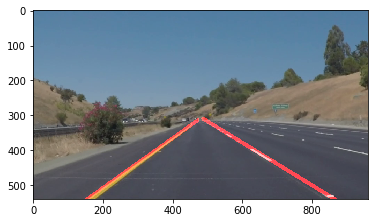

In [129]:
nFrames = 0
yellow_output = 'test_videos/modified_solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [194]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

(720, 1280, 3)
avg_neg_slope(before) =  0
mean_negative_slope =  -0.506797474333
avg_neg_slope =  -0.506797474333
highest =  [639, 400]
bottom =  [-1097.393815218124, 1280]
end-points =  639 400 -1097 1280
avg_pos_slope(before) =  0
mean_positive_slope =  0.487613843352
nFrames =  1
avg_pos_slope =  0.487613843352
highest =  [641, 401]
bottom =  [2443.6559581621218, 1280]
end points =  641 401 2443 1280
[MoviePy] >>>> Building video test_videos/modified_challenge.mp4
[MoviePy] Writing video test_videos/modified_challenge.mp4



  0%|          | 0/251 [00:00<?, ?it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.506797474333
mean_negative_slope =  -0.506797474333
avg_neg_slope =  -0.506797474333
highest =  [639, 400]
bottom =  [-1097.393815218124, 1280]
end-points =  639 400 -1097 1280
avg_pos_slope(before) =  0.487613843352
mean_positive_slope =  0.487613843352
nFrames =  2
avg_pos_slope =  0.487613843352
highest =  [641, 401]
bottom =  [2443.6559581621218, 1280]
end points =  641 401 2443 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.506797474333
mean_negative_slope =  -0.509339328952
avg_neg_slope =  -0.507432937988
highest =  [684, 419]
bottom =  [-1012.77593932779, 1280]
end-points =  684 419 -1012 1280
avg_pos_slope(before) =  0.487613843352
mean_positive_slope =  0.445299145299
nFrames =  3
avg_pos_slope =  0.477035168838
highest =  [619, 408]
bottom =  [2446.9574693062327, 1280]
end points =  619 408 2446 1280



  1%|          | 3/251 [00:00<00:25,  9.77it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.507432937988
mean_negative_slope =  -0.347855412063
avg_neg_slope =  -0.475517432803
highest =  [643, 406]
bottom =  [-1194.997809772344, 1280]
end-points =  643 406 -1194 1280
avg_pos_slope(before) =  0.477035168838
mean_positive_slope =  0.46712858524
nFrames =  4
avg_pos_slope =  0.475053852119
highest =  [628, 408]
bottom =  [2463.5813685349863, 1280]
end points =  628 408 2463 1280



  2%|▏         | 4/251 [00:00<00:26,  9.37it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.475517432803
mean_negative_slope =  -0.571775361886
avg_neg_slope =  -0.491560420983
highest =  [683, 417]
bottom =  [-1072.6336172748906, 1280]
end-points =  683 417 -1072 1280
avg_pos_slope(before) =  0.475053852119
mean_positive_slope =  0.306243124312
nFrames =  5
avg_pos_slope =  0.446918730818
highest =  [625, 412]
bottom =  [2567.1875615099802, 1280]
end points =  625 412 2567 1280


(720, 1280, 3)
avg_neg_slope(before) =  -0.491560420983
mean_negative_slope =  -0.550505357201
avg_neg_slope =  -0.499981126157
highest =  [454, 563]
bottom =  [-980.05413222434674, 1280]
end-points =  454 563 -980 1280
avg_pos_slope(before) =  0.446918730818
mean_positive_slope =  0.365396249244
nFrames =  6
avg_pos_slope =  0.435272662021
highest =  [624, 407]
bottom =  [2629.6393984076822, 1280]
end points =  624 407 2629 1280



  2%|▏         | 5/251 [00:00<00:27,  8.79it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.499981126157
mean_negative_slope =  -0.423828494245
avg_neg_slope =  -0.490462047168
highest =  [644, 409]
bottom =  [-1131.8764516618974, 1280]
end-points =  644 409 -1131 1280
avg_pos_slope(before) =  0.435272662021
mean_positive_slope =  0.366256920672
nFrames =  7
avg_pos_slope =  0.426645694353
highest =  [623, 408]
bottom =  [2666.850463140795, 1280]
end points =  623 408 2666 1280



  2%|▏         | 6/251 [00:00<00:29,  8.35it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.490462047168
mean_negative_slope =  -0.446043165468
avg_neg_slope =  -0.485526615868
highest =  [645, 402]
bottom =  [-1163.345765823801, 1280]
end-points =  645 402 -1163 1280
avg_pos_slope(before) =  0.426645694353
mean_positive_slope =  nan
nFrames =  8
avg_pos_slope =  0.426645694353
highest =  [614, 408]
bottom =  [2657.8504631407945, 1280]
end points =  614 408 2657 1280



  3%|▎         | 7/251 [00:00<00:30,  8.01it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.485526615868
mean_negative_slope =  -0.4
avg_neg_slope =  -0.476973954281
highest =  [636, 402]
bottom =  [-1204.7713715161492, 1280]
end-points =  636 402 -1204 1280
avg_pos_slope(before) =  0.426645694353
mean_positive_slope =  0.490797546012
nFrames =  9
avg_pos_slope =  0.433060879519
highest =  [614, 408]
bottom =  [2627.5737057778924, 1280]
end points =  614 408 2627 1280



  4%|▎         | 9/251 [00:01<00:28,  8.54it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.476973954281
mean_negative_slope =  nan
avg_neg_slope =  -0.476973954281
highest =  [0, 1000]
bottom =  [-587.03415036961485, 1280]
end-points =  0 1000 -587 1280
avg_pos_slope(before) =  0.433060879519
mean_positive_slope =  0.348258087214
nFrames =  10
avg_pos_slope =  0.425351534764
highest =  [613, 410]
bottom =  [2658.3670173850282, 1280]
end points =  613 410 2658 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.476973954281
mean_negative_slope =  -0.464163614164
avg_neg_slope =  -0.475906425938
highest =  [644, 400]
bottom =  [-1205.1030001646361, 1280]
end-points =  644 400 -1205 1280
avg_pos_slope(before) =  0.425351534764
mean_positive_slope =  0.301369534536
nFrames =  11
avg_pos_slope =  0.415019701412
highest =  [617, 409]
bottom =  [2715.6955487598248, 1280]
end points =  617 409 2715 1280



  4%|▍         | 11/251 [00:01<00:26,  9.04it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.475906425938
mean_negative_slope =  -0.507609953704
avg_neg_slope =  -0.478345158843
highest =  [681, 423]
bottom =  [-1110.5933383174722, 1280]
end-points =  681 423 -1110 1280
avg_pos_slope(before) =  0.415019701412
mean_positive_slope =  0.347750765889
nFrames =  12
avg_pos_slope =  0.40984516791
highest =  [608, 412]
bottom =  [2725.8729626772206, 1280]
end points =  608 412 2725 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.478345158843
mean_negative_slope =  -0.554455445545
avg_neg_slope =  -0.483781607893
highest =  [646, 438]
bottom =  [-1094.4547553316934, 1280]
end-points =  646 438 -1094 1280
avg_pos_slope(before) =  0.40984516791
mean_positive_slope =  0.234866859516
nFrames =  13
avg_pos_slope =  0.39734671731
highest =  [614, 408]
bottom =  [2808.5569499172711, 1280]
end points =  614 408 2808 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.483781607893
mean_negative_slope =  -0.528049710973
avg_neg_slope =  -0.486732814765
hig


  5%|▌         | 13/251 [00:01<00:24,  9.68it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.486732814765
mean_negative_slope =  -0.424242424242
avg_neg_slope =  -0.482827165358
highest =  [683, 422]
bottom =  [-1094.0334015163394, 1280]
end-points =  683 422 -1094 1280
avg_pos_slope(before) =  0.395090603786
mean_positive_slope =  0.342368742369
nFrames =  15
avg_pos_slope =  0.391795487448
highest =  [612, 410]
bottom =  [2832.546248931742, 1280]
end points =  612 410 2832 1280
(720, 1280, 3)



  6%|▌         | 15/251 [00:01<00:24,  9.62it/s]

avg_neg_slope(before) =  -0.482827165358
mean_negative_slope =  -0.378868457901
avg_neg_slope =  -0.476711947272
highest =  [689, 421]
bottom =  [-1112.9267293713674, 1280]
end-points =  689 421 -1112 1280
avg_pos_slope(before) =  0.391795487448
mean_positive_slope =  0.343837535014
nFrames =  16
avg_pos_slope =  0.388974431422
highest =  [610, 410]
bottom =  [2846.6508688486665, 1280]
end points =  610 410 2846 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.476711947272
mean_negative_slope =  nan
avg_neg_slope =  -0.476711947272
highest =  [0, 1000]
bottom =  [-587.35679187890901, 1280]
end-points =  0 1000 -587 1280
avg_pos_slope(before) =  0.388974431422
mean_positive_slope =  0.278346965131
nFrames =  17
avg_pos_slope =  0.382828461073
highest =  [616, 407]
bottom =  [2896.3947166158287, 1280]
end points =  616 407 2896 1280



  6%|▋         | 16/251 [00:01<00:27,  8.63it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.476711947272
mean_negative_slope =  -0.422018348624
avg_neg_slope =  -0.473833336817
highest =  [679, 415]
bottom =  [-1146.5363917850773, 1280]
end-points =  679 415 -1146 1280
avg_pos_slope(before) =  0.382828461073
mean_positive_slope =  0.32836610873
nFrames =  18
avg_pos_slope =  0.379962021476
highest =  [619, 411]
bottom =  [2906.0706830784102, 1280]
end points =  619 411 2906 1280



  7%|▋         | 17/251 [00:01<00:26,  8.96it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.473833336817
mean_negative_slope =  -0.382352941176
avg_neg_slope =  -0.469259317035
highest =  [689, 426]
bottom =  [-1130.8892786964543, 1280]
end-points =  689 426 -1130 1280
avg_pos_slope(before) =  0.379962021476
mean_positive_slope =  0.35954942449
nFrames =  19
avg_pos_slope =  0.378941391626
highest =  [621, 405]
bottom =  [2930.064196563023, 1280]
end points =  621 405 2930 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.469259317035
mean_negative_slope =  -0.499922867247
avg_neg_slope =  -0.470719486092
highest =  [684, 418]
bottom =  [-1147.2392528203943, 1280]
end-points =  684 418 -1147 1280
avg_pos_slope(before) =  0.378941391626
mean_positive_slope =  0.340268266744
nFrames =  20
avg_pos_slope =  0.377099814251
highest =  [615, 410]
bottom =  [2922.081486444697, 1280]
end points =  615 410 2922 1280



  8%|▊         | 19/251 [00:02<00:23,  9.69it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.470719486092
mean_negative_slope =  -0.498298702477
avg_neg_slope =  -0.471973086837
highest =  [633, 412]
bottom =  [-1206.0879145601209, 1280]
end-points =  633 412 -1206 1280
avg_pos_slope(before) =  0.377099814251
mean_positive_slope =  0.314502192948
nFrames =  21
avg_pos_slope =  


  8%|▊         | 20/251 [00:02<00:23,  9.74it/s]

0.374254467828
highest =  [613, 409]
bottom =  [2940.2935258588695, 1280]
end points =  613 409 2940 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.471973086837
mean_negative_slope =  -0.3859273879
avg_neg_slope =  -0.468231969492
highest =  [686, 419]
bottom =  [-1152.832151794127, 1280]
end-points =  686 419 -1152 1280
avg_pos_slope(before) =  0.374254467828
mean_positive_slope =  0.530775023338
nFrames =  22
avg_pos_slope =  0.381059709372
highest =  [618, 408]
bottom =  [2906.3552854147706, 1280]
end points =  618 408 2906 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.468231969492
mean_negative_slope = 


  9%|▉         | 22/251 [00:02<00:22, 10.22it/s]

 -0.389952394456
avg_neg_slope =  -0.464970320532
highest =  [660, 431]
bottom =  [-1165.9229944571248, 1280]
end-points =  660 431 -1165 1280
avg_pos_slope(before) =  0.381059709372
mean_positive_slope =  0.406011852194
nFrames =  23
avg_pos_slope =  0.38209938199
highest =  [619, 407]
bottom =  [2903.745909439378, 1280]
end points =  619 407 2903 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.464970320532
mean_negative_slope =  -0.487017074257
avg_neg_slope =  -0.465852190681
highest =  [687, 420]
bottom =  [-1159.079115228139, 1280]
end-points =  687 420 -1159 1280
avg_pos_slope(before) =  0.38209938199
mean_positive_slope =  0.527301122492
nFrames =  24
avg_pos_slope =  0.38790745161
highest =  [645, 403]
bottom =  [2905.8485512737311, 1280]
end points =  645 403 2905 1280



 10%|▉         | 24/251 [00:02<00:20, 10.91it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.465852190681
mean_negative_slope =  -0.490176448505
avg_neg_slope =  -0.466787739059
highest =  [681, 424]
bottom =  [-1152.8099490903987, 1280]
end-points =  681 424 -1152 1280
avg_pos_slope(before) =  0.38790745161
mean_positive_slope =  0.406629908017
nFrames =  25
avg_pos_slope =  0.388627546087
highest =  [615, 408]
bottom =  [2858.7935982157937, 1280]
end points =  615 408 2858 1280


(720, 1280, 3)
avg_neg_slope(before) =  -0.466787739059
mean_negative_slope =  -0.579021791519
avg_neg_slope =  -0.470944555817
highest =  [436, 601]
bottom =  [-1005.7833089125445, 1280]
end-points =  436 601 -1005 1280
avg_pos_slope(before) =  0.388627546087
mean_positive_slope =  0.362111801242
nFrames =  26
avg_pos_slope =  0.387645481463
highest =  [611, 413]
bottom =  [2847.5796622417129, 1280]
end points =  611 413 2847 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.470944555817
mean_negative_slope =  -0.51938746989
avg_neg_slope =  -0.472674659891
highest =  [684, 423]
bottom =  [-1129.0864053465232, 1280]
end-points =  684 423 -1129 1280
avg_pos_slope(before) =  0.387645481463
mean_positive_slope =  nan
nFrames =  27



 10%|█         | 26/251 [00:02<00:21, 10.59it/s]

avg_pos_slope =  0.387645481463
highest =  [636, 426]
bottom =  [2839.0438656913761, 1280]
end points =  636 426 2839 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.472674659891
mean_negative_slope =  -0.426490441476
avg_neg_slope =  -0.471082100635
highest =  [682, 419]
bottom =  [-1145.7068876932899, 1280]
end-points =  682 419 -1145 1280
avg_pos_slope(before) =  0.387645481463
mean_positive_slope =  0.333801222749
nFrames =  28
avg_pos_slope =  0.385788782887
highest =  [622, 411]
bottom =  [2874.5279078821241, 1280]
end points =  622 411 2874 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.471082100635
mean_negative_slope =  -0.500172725421
avg_neg_slope =  -0.472051788128
highest =  [681, 419]
bottom =  [-1142.9524172004951, 1280]
end-points =  681 419 -1142 1280
avg_pos_slope(before) =  0.385788782887
mean_positive_slope =  0.654153954283
nFrames =  29
avg_pos_slope =  0.3947342886
highest =  [621, 414]
bottom =  [2814.8808586196542, 1280]
end points =  621 414 2814 1280



 11%|█         | 28/251 [00:02<00:20, 10.93it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.472051788128
mean_negative_slope =  -0.443548387097
avg_neg_slope =  -0.471132323579
highest =  [690, 422]
bottom =  [-1131.1444154005987, 1280]
end-points =  690 422 -1131 1280
avg_pos_slope(before) =  0.3947342886
mean_positive_slope =  0.338508278522
nFrames =  30
avg_pos_slope =  0.392920546339
highest =  [602, 417]
bottom =  [2798.3727986239487, 1280]
end points =  602 417 2798 1280



 12%|█▏        | 30/251 [00:02<00:19, 11.35it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.471132323579
mean_negative_slope =  -0.467967967968
avg_neg_slope =  -0.471033437466
highest =  [660, 416]
bottom =  [-1174.2646854294062, 1280]
end-points =  660 416 -1174 1280
avg_pos_slope(before) =  0.392920546339
mean_positive_slope =  0.207718698625
nFrames =  31
avg_pos_slope =  0.387132988598
highest =  [627, 402]
bottom =  [2894.9544907274521, 1280]
end points =  627 402 2894 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.471033437466
mean_negative_slope =  -0.467041601504
avg_neg_slope =  -0.47091247274
highest =  [683, 417]
bottom =  [-1149.6123217317991, 1280]
end-points =  683 417 -1149 1280
avg_pos_slope(before) =  0.387132988598
mean_positive_slope =  0.342642244532
nFrames =  32
avg_pos_slope =  0.385784784233
highest =  [635, 403]
bottom =  [2908.2882058700434, 1280]
end points =  635 403 2908 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.47091247274
mean_negative_slope =  -0.579960880196
avg_neg_slope =  -0.474119778841
hi


 13%|█▎        | 32/251 [00:03<00:18, 11.62it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.474119778841
mean_negative_slope =  -0.788419695372
avg_neg_slope =  -0.483099776457
highest =  [680, 416]
bottom =  [-1108.4504239214111, 1280]
end-points =  680 416 -1108 1280
avg_pos_slope(before) =  0.38516223842
mean_positive_slope =  0.222075405215
nFrames =  34
avg_pos_slope =  0.380502614614
highest =  [633, 409]
bottom =  [2922.0775688455005, 1280]
end points =  633 409 2922 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.483099776457
mean_negative_slope =  -0.502579710954
avg_neg_slope =  -0.483640885748
highest =  [681, 419]
bottom =  [-1099.2465121785315, 1280]
end-points =  681 419 -1099 1280
avg_pos_slope(before) =  0.380502614614
mean_positive_slope =  0.301949152542
nFrames =  35
avg_pos_slope =  0.378320574001
highest =  [587, 422]
bottom =  [2854.9178954669624, 1280]
end points =  587 422 2854 1280



 14%|█▎        | 34/251 [00:03<00:18, 11.73it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.483640885748
mean_negative_slope =  -0.55487804878
avg_neg_slope =  -0.485566214479
highest =  [678, 420]
bottom =  [-1093.1281682216525, 1280]
end-points =  678 420 -1093 1280
avg_pos_slope(before) =  0.378320574001
mean_positive_slope =  0.37347181651
nFrames =  36
avg_pos_slope =  0.378189526501
highest =  [606, 414]
bottom =  [2895.8571729679134, 1280]
end points =  606 414 2895 1280



 14%|█▍        | 36/251 [00:03<00:18, 11.79it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.485566214479
mean_negative_slope =  -0.479412342187
avg_neg_slope =  -0.485404270471
highest =  [657, 408]
bottom =  [-1139.4407259000889, 1280]
end-points =  657 408 -1139 1280
avg_pos_slope(before) =  0.378189526501
mean_positive_slope =  0.318802264902
nFrames =  37
avg_pos_slope =  0.376626703827
highest =  [616, 420]
bottom =  [2899.4281033718357, 1280]
end points =  616 420 2899 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.485404270471
mean_negative_slope =  -0.51712932988
avg_neg_slope =  -0.486217733533
highest =  [686, 419]
bottom =  [-1084.8115945176862, 1280]
end-points =  686 419 -1084 1280
avg_pos_slope(before) =  0.376626703827
mean_positive_slope =  0.272926399511
nFrames =  38
avg_pos_slope =  0.373967721666
highest =  [632, 402]
bottom =  [2979.7962110998728, 1280]
end points =  632 402 2979 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.486217733533
mean_negative_slope =  -0.466848223284
avg_neg_slope =  -0.485733495777
h


 15%|█▌        | 38/251 [00:03<00:17, 12.01it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.485733495777
mean_negative_slope =  -0.362831858407
avg_neg_slope =  -0.482735894865
highest =  [686, 419]
bottom =  [-1097.5839620763093, 1280]
end-points =  686 419 -1097 1280
avg_pos_slope(before) =  0.373608622581
mean_positive_slope =  0.316193430367
nFrames =  40
avg_pos_slope =  0.372208252039
highest =  [631, 401]
bottom =  [2992.5811717884339, 1280]
end points =  631 401 2992 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.482735894865
mean_negative_slope =  -0.440798215403
avg_neg_slope =  -0.481737378687
highest =  [647, 408]
bottom =  [-1163.1148853672796, 1280]
end-points =  647 408


 16%|█▌        | 40/251 [00:03<00:18, 11.34it/s]

 -1163 1280
avg_pos_slope(before) =  0.372208252039
mean_positive_slope =  0.305323244391
nFrames =  41
avg_pos_slope =  0.370615751857
highest =  [648, 409]
bottom =  [2998.1429597516762, 1280]
end points =  648 409 2998 1280
(720, 1280, 3)


avg_neg_slope(before) =  -0.481737378687
mean_negative_slope =  -0.421052631579
avg_neg_slope =  -0.480326105499
highest =  [679, 420]
bottom =  [-1111.4502590104867, 1280]
end-points =  679 420 -1111 1280
avg_pos_slope(before) =  0.370615751857
mean_positive_slope =  0.413936385229
nFrames =  42
avg_pos_slope =  0.371623208447
highest =  [628, 401]
bottom =  [2993.2989910749402, 1280]
end points =  628 401 2993 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.480326105499
mean_negative_slope =  -0.490171095741
avg_neg_slope =  -0.480549855277
highest = 


 17%|█▋        | 42/251 [00:04<00:37,  5.58it/s]

 [674, 419]
bottom =  [-1117.6975534275819, 1280]
end-points =  674 419 -1117 1280
avg_pos_slope(before) =  0.371623208447
mean_positive_slope =  0.353505291005
nFrames =  43
avg_pos_slope =  0.371211437596
highest =  [622, 419]
bottom =  [2941.4328428443064, 1280]
end points =  622 419 2941 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.480549855277
mean_negative_slope =  -0.447192513369
avg_neg_slope =  -0.479808581012
highest =  [689, 421]
bottom =  [-1101.2972851951251, 1280]
end-points =  689 421 -1101 1280
avg_pos_slope(before) =  0.371211437596
mean_positive_slope =  0.42438017515
nFrames =  44
avg_pos_slope =  0.372392965097
highest =  [610, 410]
bottom =  [2946.2417702293305, 1280]
end points =  610 410 2946 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.479808581012
mean_negative_slope =  -0.423076923077
avg_neg_slope =  -0.478575284101
highest =  [688, 421]
bottom =  [-1106.9109127394352, 1280]
end-points =  688 421 -1106 1280
avg_pos_slope(before) =  0.372392965097
mean_p


 18%|█▊        | 46/251 [00:05<00:28,  7.12it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.478575284101
mean_negative_slope =  -0.41379776496
avg_neg_slope =  -0.477197039013
highest =  [642, 401]
bottom =  [-1200.0064001622986, 1280]
end-points =  642 401 -1200 1280
avg_pos_slope(before) =  0.37029959657
mean_positive_slope =  0.312004917006
nFrames =  46
avg_pos_slope =  0.369059284239
highest =  [593, 420]
bottom =  [2923.2489240246482, 1280]
end points =  593 420 2923 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.477197039013
mean_negative_slope =  -0.42
avg_neg_slope =  -0.476005434033
highest =  [682, 429]
bottom =  [-1105.7947165208604, 1280]
end-points =  682 429 -1105 1280
avg_pos_slope(before) =  0.369059284239
mean_positive_slope =  0.345220812865
nFrames =  47
avg_pos_slope =  0.368562649419
highest =  [613, 416]
bottom =  [2957.2418849602768, 1280]
end points =  613 416 2957 1280



 19%|█▉        | 48/251 [00:05<00:25,  7.98it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.476005434033
mean_negative_slope =  -0.288343558282
avg_neg_slope =  -0.472175599834
highest =  [638, 408]
bottom =  [-1208.770566513741, 1280]
end-points =  638 408 -1208 1280
avg_pos_slope(before) =  0.368562649419
mean_positive_slope =  0.260612772241
nFrames =  48
avg_pos_slope =  0.366359590701
highest =  [635, 407]
bottom =  [3017.9047257350499, 1280]
end points =  635 407 3017 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.472175599834
mean_negative_slope =  -0.237629092507
avg_neg_slope =  -0.467484669688
highest =  [687, 420]
bottom =  [-1152.632517948384, 1280]
end-points =  687 420 -1152 1280
avg_pos_slope(before) =  0.366359590701
mean_positive_slope =  0.346269030461
nFrames =  49
avg_pos_slope =  0.365957779496
highest =  [611, 417]
bottom =  [2969.1955306096665, 1280]
end points =  611 417 2969 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.467484669688
mean_negative_slope =  -0.516307477163
avg_neg_slope =  -0.468441979638
hi


 20%|█▉        | 50/251 [00:05<00:22,  8.88it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.468441979638
mean_negative_slope =  -0.536368025756
avg_neg_slope =  -0.469748249756
highest =  [636, 402]
bottom =  [-1233.0862615372807, 1280]
end-points =  636 402 -1233 1280
avg_pos_slope(before) =  0.365515629238
mean_positive_slope =  0.216117106175
nFrames =  51
avg_pos_slope =  0.362642580718
highest =  [613, 427]
bottom =  [2965.1782751261294, 1280]
end points =  613 427 2965 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.469748249756
mean_negative_slope =  -0.574271790588
avg_neg_slope =  -0.471720392036
highest =  [685, 419]
bottom =  [-1140.2337921713149, 1280]
end-points =  685 419 -1140 1280
avg_pos_slope(before) =  0.362642580718
mean_positive_slope =  0.446676294678
nFrames =  52
avg_pos_slope =  0.364228122491
highest =  [631, 407]
bottom =  [3027.8495184567523, 1280]
end points =  631 407 3027 1280
(720, 1280, 3)



 21%|██        | 52/251 [00:05<00:21,  9.13it/s]

avg_neg_slope(before) =  -0.471720392036
mean_negative_slope =  -0.405729300179
avg_neg_slope =  -0.470498334779
highest =  [684, 419]
bottom =  [-1145.9745957742846, 1280]
end-points =  684 419 -1145 1280
avg_pos_slope(before) =  0.364228122491
mean_positive_slope =  0.284914890239
nFrames =  53
avg_pos_slope =  0.36275935893
highest =  [633, 411]
bottom =  [3028.527444315378, 1280]
end points =  633 411 3028 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.470498334779
mean_negative_slope =  -0.391935953785
avg_neg_slope =  -0.469069927852
highest =  [684, 421]
bottom =  [-1147.2834590219602, 1280]
end-points =  684 421 -1147 1280
avg_pos_slope(before) =  0.36275935893
mean_positive_slope =  0.368760014119
nFrames =  54
avg_pos_slope =  0.362868461752
highest =  [628, 406]
bottom =  [3036.586284352627, 1280]
end points =  628 406 3036 1280
(720, 1280, 3)
avg_neg_slope(before) = 


 22%|██▏       | 54/251 [00:05<00:20,  9.40it/s]

 -0.469069927852
mean_negative_slope =  -0.393852092191
avg_neg_slope =  -0.467726752215
highest =  [659, 438]
bottom =  [-1141.1963668150581, 1280]
end-points =  659 438 -1141 1280
avg_pos_slope(before) =  0.362868461752
mean_positive_slope =  0.2869383964
nFrames =  55
avg_pos_slope =  0.361512567728
highest =  [606, 412]
bottom =  [3007.0230279280509, 1280]
end points =  606 412 3007 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.467726752215
mean_negative_slope =  -0.364916773367
avg_neg_slope =  -0.465923068376
highest =  [659, 406]
bottom =  [-1216.8461628586513, 1280]
end-points =  659 406 -1216 1280
avg_pos_slope(before) =  0.361512567728
mean_positive_slope =  0.197125646399
nFrames =  56
avg_pos_slope =  0.358628586652
highest =  [625, 406]
bottom =  [3062.0617193667608, 1280]
end points =  625 406 3062 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.465923068376
mean_negative_slope =  -0.429672293926
avg_neg_slope =  -0.465298055023
highest =  [658, 405]
bottom =  [-1222.51


 23%|██▎       | 58/251 [00:06<00:19, 10.11it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.465298055023
mean_negative_slope =  -0.530925564617
avg_neg_slope =  -0.466410385694
highest =  [638, 411]
bottom =  [-1225.1660585912737, 1280]
end-points =  638 411 -1225 1280
avg_pos_slope(before) =  0.360155680157
mean_positive_slope =  0.405263157895
nFrames =  58
avg_pos_slope =  0.360920213677
highest =  [602, 420]
bottom =  [2984.7981016559597, 1280]
end points =  602 420 2984 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.466410385694
mean_negative_slope =  -0.415734568112
avg_neg_slope =  -0.465565788735
highest =  [654, 402]
bottom =  [-1231.8774017448304, 1280]
end-points =  654 402 -1231 1280
avg_pos_slope(before) =  0.360920213677
mean_positive_slope =  0.739053092501
nFrames =  59
avg_pos_slope =  0.367222428325
highest =  [620, 413]
bottom =  [2980.9669048692317, 1280]
end points =  620 413 2980 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.465565788735
mean_negative_slope =  -0.429699233301
avg_neg_slope =  -0.464977812416



 24%|██▍       | 60/251 [00:06<00:18, 10.20it/s]


highest =  [619, 407]
bottom =  [2996.5851709452286, 1280]
end points =  619 407 2996 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.464977812416
mean_negative_slope =  -0.334630305026
avg_neg_slope =  -0.462875433265
highest =  [651, 401]
bottom =  [-1247.9990326353661, 1280]
end-points =  651 401 -1247 1280
avg_pos_slope(before) =  0.367179275287
mean_positive_slope =  0.3912499617
nFrames =  61
avg_pos_slope =  0.367567512164
highest =  [617, 407]
bottom =  [2992.0738874053991, 1280]
end points =  617 407 2992 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.462875433265
mean_negative_slope =  -0.522050045734
avg_neg_slope =  -0.463814712828
highest =  [650, 400]
bottom =  [-1247.3093687246667, 1280]
end-points =  650 400 -1247 1280
avg_pos_slope(before) =  0.367567512164
mean_positive_slope =  0.320975376434
nFrames =  62
avg_pos_slope =  0.366827954454
highest =  [623, 408]
bottom =  [3000.1361735427736, 1280]
end points =  623 408 3000 1280
(720, 1280, 3)
avg_neg_slope(before) =


 25%|██▍       | 62/251 [00:06<00:18, 10.41it/s]

 -0.463814712828
mean_negative_slope =  -0.509316770186
avg_neg_slope =  -0.464525682474
highest =  [680, 427]
bottom =  [-1156.2816786738042, 1280]
end-points =  680 427 -1156 1280
avg_pos_slope(before) =  0.366827954454
mean_positive_slope =  0.376399973397
nFrames =  63
avg_pos_slope =  0.36697751725
highest =  [616, 408]
bottom =  [2992.1673645126994, 1280]
end points =  616 408 2992 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.464525682474
mean_negative_slope =  -0.531796519661
avg_neg_slope =  -0.46556061843
highest =  [646, 400]
bottom =  [-1244.1942414431555, 1280]
end-points =  646 400 -1244 1280
avg_pos_slope(before) =  0.36697751725
mean_positive_slope =  0.400076556893
nFrames =  64
avg_pos_slope =  0.367486733245
highest =  [651, 411]
bottom =  [3015.7112164486198, 1280]
end points =  651 411 3015 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.46556061843
mean_negative_slope =  -0.564909075153
avg_neg_slope =  -0.467065898078
highest =  [672, 441]
bottom =  [-1124.3203


 26%|██▋       | 66/251 [00:06<00:17, 10.70it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.467065898078
mean_negative_slope =  -0.435712675048
avg_neg_slope =  -0.466597939525
highest =  [644, 406]
bottom =  [-1229.1330037366733, 1280]
end-points =  644 406 -1229 1280
avg_pos_slope(before) =  0.366393188488
mean_positive_slope =  0.392343484682
nFrames =  66
avg_pos_slope =  0.366780506341
highest =  [612, 410]
bottom =  [2983.9908363674372, 1280]
end points =  612 410 2983 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.466597939525
mean_negative_slope =  -0.448885833663
avg_neg_slope =  -0.46633746738
highest =  [642, 400]
bottom =  [-1245.0454586115784, 1280]
end-points =  642 400 -1245 1280
avg_pos_slope(before) =  0.366780506341
mean_positive_slope =  0.304129771066
nFrames =  67
avg_pos_slope =  0.365859171999
highest =  [610, 411]
bottom =  [2985.2308716265134, 1280]
end points =  610 411 2985 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.46633746738
mean_negative_slope =  


 27%|██▋       | 68/251 [00:07<00:16, 10.78it/s]

-0.391674114914
avg_neg_slope =  -0.465255389808
highest =  [641, 410]
bottom =  [-1228.9407230055365, 1280]
end-points =  641 410 -1228 1280
avg_pos_slope(before) =  0.365859171999
mean_positive_slope =  0.280092142272
nFrames =  68
avg_pos_slope =  0.364616171568
highest =  [607, 412]
bottom =  [2987.5855792587517, 1280]
end points =  607 412 2987 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.465255389808
mean_negative_slope =  -0.554913294798
avg_neg_slope =  -0.466536217022
highest =  [638, 429]
bottom =  [-1186.0813230571121, 1280]
end-points =  638 429 -1186 1280
avg_pos_slope(before) =  0.364616171568
mean_positive_slope =  0.237773677831
nFrames =  69
avg_pos_slope =  0.362804135943
highest =  [617, 415]
bottom =  [3001.2065574875214, 1280]
end points =  617 415 3001 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.466536217022
mean_negative_slope =  -0.415131463045
avg_neg_slope =  -0.465812206403
highest =  [660, 414]
bottom =  [-1199.1183058243951, 1280]
end-points =  660 4


 29%|██▊       | 72/251 [00:07<00:16, 10.79it/s]


mean_positive_slope =  0.355032828992
nFrames =  71
avg_pos_slope =  0.362055385389
highest =  [610, 410]
bottom =  [3012.9472702492494, 1280]
end points =  610 410 3012 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.466345393545
mean_negative_slope =  -0.486811437409
avg_neg_slope =  -0.466625750311
highest =  [656, 411]
bottom =  [-1206.306140244754, 1280]
end-points =  656 411 -1206 1280
avg_pos_slope(before) =  0.362055385389
mean_positive_slope =  0.28782914256
nFrames =  72
avg_pos_slope =  0.361038587542
highest =  [612, 421]
bottom =  [2991.2470656603709, 1280]
end points =  612 421 2991 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.466625750311
mean_negative_slope =  -0.492524380656
avg_neg_slope =  -0.466975731802
highest =  [632, 400]
bottom =  [-1252.4662368307943, 1280]
end-points =  632 400 -1252 1280
avg_pos_slope(before) =  0.361038587542
mean_positive_slope =  0.349958949097
nFrames =  73
avg_pos_slope =  0.360888862698
highest =  [618, 409]
bottom =  [3031.4853968


 29%|██▉       | 74/251 [00:07<00:16, 10.73it/s]

avg_neg_slope(before) =  -0.466975731802
mean_negative_slope =  -0.478762454918
avg_neg_slope =  -0.46713288811
highest =  [637, 401]
bottom =  [-1244.6915322665866, 1280]
end-points =  637 401 -1244 1280
avg_pos_slope(before) =  0.360888862698
mean_positive_slope =  0.277222777223
nFrames =  74
avg_pos_slope =  0.359773314892
highest =  [624, 419]
bottom =  [3017.1736022678615, 1280]
end points =  624 419 3017 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.46713288811
mean_negative_slope =  -0.245486550582
avg_neg_slope =  -0.464216488932
highest =  [652, 402]
bottom =  [-1239.3589261333518, 1280]
end-points =  652 402 -1239 1280
avg_pos_slope(before) =  0.359773314892
mean_positive_slope =  0.178343949045
nFrames =  75
avg_pos_slope =  0.357386086394
highest =  [609, 414]
bottom =  [3032.1497334935348, 1280]
end points =  609 414 3032 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.464216488932
mean_negative_slope =  -0.518504977629
avg_neg_slope =  -0.46492153424
highest =  [652, 4


 30%|███       | 76/251 [00:07<00:17, 10.01it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.46492153424
mean_negative_slope =  -0.418918672089
avg_neg_slope =  -0.464331753956
highest =  [630, 404]
bottom =  [-1256.5821528184429, 1280]
end-points =  630 404 -1256 1280
avg_pos_slope(before) =  0.356721593008
mean_positive_slope =  nan
nFrames =  77
avg_pos_slope =  0.356721593008
highest =  [0, 1000]
bottom =  [784.92585110616642, 1280]
end points =  0 1000 784 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.464331753956
mean_negative_slope =  -0.326157103431
avg_neg_slope =  -0.462582707747
highest =  [650, 400]
bottom =  [-1252.3625078564578, 1280]
end-points =  650 400 -1252 1280
avg_pos_slope(before) =  0.356721593008
mean_positive_slope =  0.322834645669
nFrames =  78
avg_pos_slope =  0.356292644308
highest =  [626, 431]
bottom =  [3008.8726569681835, 1280]
end points =  626 431 3008 1280



 31%|███       | 78/251 [00:08<00:16, 10.21it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.462582707747
mean_negative_slope =  -0.4617927323
avg_neg_slope =  -0.462572833054
highest =  [650, 400]
bottom =  [-1252.403118209166, 1280]
end-points =  650 400 -1252 1280
avg_pos_slope(before) =  0.356292644308
mean_positive_slope =  0.275478072868
nFrames =  79
avg_pos_slope =  0.355282462165
highest =  [616, 407]
bottom =  [3073.1998141439376, 1280]
end points =  616 407 3073 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.462572833054
mean_negative_slope =  -0.460738807041
avg_neg_slope =  -0.462550190757
highest =  [634, 400]
bottom =  [-1268.4962427527071, 1280]
end-points =  634 400 -1268 1280
avg_pos_slope(before) =  0.355282462165
mean_positive_slope =  0.313159746657
nFrames =  80
avg_pos_slope =  0.35476242864
highest =  [620, 419]
bottom =  [3046.9762818475388, 1280]
end points =  620 419 3046 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.462550190757
mean_negative_slope =  -0.407709485012
avg_neg_slope =  -0.461881401663
high


 32%|███▏      | 80/251 [00:08<00:16, 10.30it/s]

403 -1262 1280
avg_pos_slope(before) =  0.35476242864
mean_positive_slope =  0.203478082711
nFrames =  81
avg_pos_slope =  0.352917497592
highest =  [584, 426]
bottom =  [3003.8290133718606, 1280]
end points =  584 426 3003 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.461881401663
mean_negative_slope =  -0.448154728475
avg_neg_slope =  -0.461716020058
highest =  [640, 403]
bottom =  [-1259.4359344295872, 1280]
end-points =  640 403 -1259 1280
avg_pos_slope(before) =  0.352917497592
mean_positive_slope =  0.335270849939
nFrames =  82
avg_pos_slope =  0.352704887379
highest =  [619, 408]
bottom =  [3091.3218509357457, 1280]
end points =  619 408 3091 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.461716020058
mean_negative_slope =  -0.396353439425
avg_neg_slope =  -0.460937894098
highest =  [617, 409]
bottom =  [-1272.6255030284754, 1280]
end-points =  617 409 -1272 1280
avg_pos_slope(before) =  0.352704887379
mean_positive_slope =  nan
nFrames =  83



 33%|███▎      | 82/251 [00:08<00:17,  9.88it/s]

avg_pos_slope =  0.352704887379
highest =  [614, 409]
bottom =  [3083.4866194553147, 1280]
end points =  614 409 3083 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.460937894098
mean_negative_slope =  -0.421382968641
avg_neg_slope =  -0.460472542034
highest =  [630, 403]
bottom =  [-1274.5652453592777, 1280]
end-points =  630 403 -1274 1280
avg_pos_slope(before) =  0.352704887379
mean_positive_slope =  0.252646584236
nFrames =  84
avg_pos_slope =  0.351527730872
highest =  [612, 410]
bottom =  [3086.9114325695732, 1280]
end points =  612 410 3086 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.460472542034
mean_negative_slope =  -0.25150130859
avg_neg_slope =  -0.458042643971
highest =  [638, 415]
bottom =  [-1250.4704544136891, 1280]
end-points =  638 415 -1250 1280
avg_pos_slope(before) =  0.351527730872
mean_positive_slope =  0.31259858241
nFrames =  85
avg_pos_slope =  0.351075066355
highest =  [611, 423]
bottom =  [3052.0733832455239, 1280]
end points =  611 423 3052 1280



 34%|███▍      | 86/251 [00:08<00:15, 10.34it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.458042643971
mean_negative_slope =  -0.300240354789
avg_neg_slope =  -0.456228824555
highest =  [628, 403]
bottom =  [-1294.2809976023891, 1280]
end-points =  628 403 -1294 1280
avg_pos_slope(before) =  0.351075066355
mean_positive_slope =  0.1610542603
nFrames =  86
avg_pos_slope =  0.348890919159
highest =  [348, 548]
bottom =  [2446.0769627505883, 1280]
end points =  348 548 2446 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.456228824555
mean_negative_slope =  -0.305010877768
avg_neg_slope =  -0.454510438796
highest =  [634, 400]
bottom =  [-1302.1491505707838, 1280]
end-points =  634 400 -1302 1280
avg_pos_slope(before) =  0.348890919159
mean_positive_slope =  0.195405957516
nFrames =  87
avg_pos_slope =  0.347146771867
highest =  [632, 404]
bottom =  [3155.4283334615957, 1280]
end points =  632 404 3155 1280
(720, 1280, 3)
avg_neg_slope(before) = 


 35%|███▌      | 88/251 [00:09<00:15, 10.31it/s]

 -0.454510438796
mean_negative_slope =  -0.481664562675
avg_neg_slope =  -0.454815541311
highest =  [632, 401]
bottom =  [-1300.6516360143728, 1280]
end-points =  632 401 -1300 1280
avg_pos_slope(before) =  0.347146771867
mean_positive_slope =  0.176350164743
nFrames =  88
avg_pos_slope =  0.345227708866
highest =  [610, 411]
bottom =  [3127.179176765354, 1280]
end points =  610 411 3127 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.454815541311
mean_negative_slope =  -0.369079639163
avg_neg_slope =  -0.453862920176
highest =  [630, 402]
bottom =  [-1304.5048052371305, 1280]
end-points =  630 402 -1304 1280
avg_pos_slope(before) =  0.345227708866
mean_positive_slope =  0.149079672352
nFrames =  89
avg_pos_slope =  0.343048286238
highest =  [608, 411]
bottom =  [3141.1710865824234, 1280]
end points =  608 411 3141 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.453862920176
mean_negative_slope =  -0.360121419625
avg_neg_slope =  -0.452832793797
highest =  [627, 404]
bottom =  [-1307.4


 36%|███▌      | 90/251 [00:09<00:16,  9.95it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.452832793797
mean_negative_slope =  nan
avg_neg_slope =  -0.452832793797
highest =  [626, 410]
bottom =  [-1295.2389471747572, 1280]
end-points =  626 410 -1295 1280
avg_pos_slope(before) =  0.341036447029
mean_positive_slope =  0.237925841057
nFrames =  91
avg_pos_slope =  0.339915679573
highest =  [411, 530]
bottom =  [2617.4295502435248, 1280]
end points =  411 530 2617 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.452832793797
mean_negative_slope =  -0.259306809549
avg_neg_slope =  -0.450751869235
highest =  [649, 410]
bottom =  [-1281.1084684948842, 1280]
end-points =  649 410 -1281 1280
avg_pos_slope(before) =  0.339915679573
mean_positive_slope =  0.150249659097
nFrames =  92
avg_pos_slope =  0.337876259998
highest =  [604, 417]
bottom =  [3158.1895130668313, 1280]
end points =  604 417 3158 1280



 37%|███▋      | 92/251 [00:09<00:15, 10.11it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.450751869235
mean_negative_slope =  -0.397700710938
avg_neg_slope =  -0.45018749521
highest =  [623, 410]
bottom =  [-1309.5281338466448, 1280]
end-points =  623 410 -1309 1280
avg_pos_slope(before) =  0.337876259998
mean_positive_slope =  0.344790686029
nFrames =  93
avg_pos_slope =  0.337949817721
highest =  [644, 416]
bottom =  [3200.5925906565358, 1280]
end points =  644 416 3200 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.45018749521
mean_negative_slope =  -0.260553272988
avg_neg_slope =  -0.448191345503
highest =  [619, 406]
bottom =  [-1331.0599660610974, 1280]
end-points =  619 406 -1331 1280
avg_pos_slope(before) =  0.337949817721
mean_positive_slope =  0.165872099239
nFrames =  94
avg_pos_slope =  0.336138473316
highest =  [603, 414]
bottom =  [3179.3191920769013, 1280]
end points =  603 414 3179 1280



 37%|███▋      | 94/251 [00:09<00:15,  9.97it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.448191345503
mean_negative_slope =  -0.191532787304
avg_neg_slope =  -0.445517818855
highest =  [715, 447]
bottom =  [-1154.7344185718634, 1280]
end-points =  715 447 -1154 1280
avg_pos_slope(before) =  0.336138473316
mean_positive_slope =  0.130480669974
nFrames =  95
avg_pos_slope =  0.333996204531
highest =  [612, 429]
bottom =  [3159.9331455096958, 1280]
end points =  612 429 3159 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.445517818855
mean_negative_slope =  -0.190243938036
avg_neg_slope =  -0.442886129362
highest =  [610, 424]
bottom =  [-1322.7767190029958, 1280]
end-points =  610 424 -1322 1280
avg_pos_slope(before) =  0.333996204531
mean_positive_slope =  0.306154012878
nFrames =  96
avg_pos_slope =  0.333709171628
highest =  [610, 411]
bottom =  [3214.0638792191235, 1280]
end points =  610 411 3214 1280
(720, 1280, 3)



 39%|███▊      | 97/251 [00:09<00:16,  9.56it/s]

avg_neg_slope(before) =  -0.442886129362
mean_negative_slope =  -0.27768062514
avg_neg_slope =  -0.441200358911
highest =  [646, 412]
bottom =  [-1321.3601402844695, 1280]
end-points =  646 412 -1321 1280
avg_pos_slope(before) =  0.333709171628
mean_positive_slope =  nan
nFrames =  97
avg_pos_slope =  0.333709171628
highest =  [583, 424]
bottom =  [3148.1078027751091, 1280]
end points =  583 424 3148 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.441200358911
mean_negative_slope =  -0.121835483958
avg_neg_slope =  -0.437974451083
highest =  [713, 441]
bottom =  [-1202.636854902561, 1280]
end-points =  713 441 -1202 1280
avg_pos_slope(before) =  0.333709171628
mean_positive_slope =  0.252799866761
nFrames =  98
avg_pos_slope =  0.332891905922
highest =  [609, 429]
bottom =  [3165.3853757360539, 1280]
end points =  609 429 3165 1280



 39%|███▉      | 98/251 [00:10<00:15,  9.61it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.437974451083
mean_negative_slope =  -0.192071415181
avg_neg_slope =  -0.435515420724
highest =  [613, 409]
bottom =  [-1386.9291840284513, 1280]
end-points =  613 409 -1386 1280
avg_pos_slope(before) =  0.332891905922
mean_positive_slope =  0.202457843284
nFrames =  99
avg_pos_slope =  0.331587565296
highest =  [609, 411]
bottom =  [3229.7255366320878, 1280]
end points =  609 411 3229 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.435515420724
mean_negative_slope =  -0.159808616836
avg_neg_slope =  -0.432785650388
highest =  [378, 544]
bottom =  [-1322.6109129072643, 1280]
end-points =  378 544 -1322 1280
avg_pos_slope(before) =  0.331587565296
mean_positive_slope =  0.206559563931
nFrames =  100
avg_pos_slope =  0.330349664292
highest =  [586, 424]
bottom =  [3177.1937941103397, 1280]
end points =  586 424 3177 1280
(720, 1280, 3)



 40%|███▉      | 100/251 [00:10<00:15,  9.89it/s]

avg_neg_slope(before) =  -0.432785650388
mean_negative_slope =  -0.288969839638
avg_neg_slope =  -0.431375691459
highest =  [660, 406]
bottom =  [-1366.07614963933, 1280]
end-points =  660 406 -1366 1280
avg_pos_slope(before) =  0.330349664292
mean_positive_slope =  0.26958910591
nFrames =  101
avg_pos_slope =  0.329753972543
highest =  [606, 412]
bottom =  [3238.265483583391, 1280]
end points =  606 412 3238 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.431375691459
mean_negative_slope =  -0.319037946851
avg_neg_slope =  -0.430285033745
highest =  [697, 503]
bottom =  [-1108.7797484561613, 1280]
end-points =  697 503 -1108 1280
avg_pos_slope(before) =  0.329753972543
mean_positive_slope =  0.141531891689
nFrames =  102
avg_pos_slope =  0.3279265737
highest =  [585, 423]
bottom =  [3198.3899132679221, 1280]
end points =  585 423 3198 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.430285033745
mean_negative_slope =  -0.239678560725
avg_neg_slope =  -0.428452279196
highest =  [632, 40


 41%|████▏     | 104/251 [00:10<00:14, 10.21it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.428452279196
mean_negative_slope =  -0.26727222058
avg_neg_slope =  -0.426917231019
highest =  [722, 485]
bottom =  [-1140.1876612994549, 1280]
end-points =  722 485 -1140 1280
avg_pos_slope(before) =  0.326206855158
mean_positive_slope =  0.248322147651
nFrames =  104
avg_pos_slope =  0.325465096038
highest =  [597, 431]
bottom =  [3205.5746531166374, 1280]
end points =  597 431 3205 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.426917231019
mean_negative_slope =  -0.183757897071
avg_neg_slope =  -0.424623275039
highest =  [629, 404]
bottom =  [-1434.0051424302096, 1280]
end-points =  629 404 -1434 1280
avg_pos_slope(before) =  0.325465096038
mean_positive_slope =  0.26353656584
nFrames =  105
avg_pos_slope =  0.324880864621
highest =  [604, 418]
bottom =  [3257.2803063190158, 1280]
end points =  604 418 3257 1280
(720, 1280, 3)
avg_neg_slope(before) = 


 42%|████▏     | 106/251 [00:10<00:14, 10.28it/s]

 -0.424623275039
mean_negative_slope =  -0.239504545571
avg_neg_slope =  -0.422893193455
highest =  [0, 1000]
bottom =  [-662.10571447750817, 1280]
end-points =  0 1000 -662 1280
avg_pos_slope(before) =  0.324880864621
mean_positive_slope =  0.347369322382
nFrames =  106
avg_pos_slope =  0.325091037124
highest =  [581, 435]
bottom =  [3180.2719069581008, 1280]
end points =  581 435 3180 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.422893193455
mean_negative_slope =  -0.318717620536
avg_neg_slope =  -0.421928604817
highest =  [779, 523]
bottom =  [-1015.1424007720587, 1280]
end-points =  779 523 -1015 1280
avg_pos_slope(before) =  0.325091037124
mean_positive_slope =  0.323084541613
nFrames =  107
avg_pos_slope =  0.325072458462
highest =  [746, 507]
bottom =  [3123.9313807692342, 1280]
end points =  746 507 3123 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.421928604817
mean_negative_slope =  -0.268242340371
avg_neg_slope =  -0.420518639088
highest =  [769, 520]
bottom =  [-1038.2


 43%|████▎     | 108/251 [00:11<00:14, 10.19it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.420518639088
mean_negative_slope =  -0.252621694219
avg_neg_slope =  -0.418992303225
highest =  [808, 546]
bottom =  [-943.82215603938107, 1280]
end-points =  808 546 -943 1280
avg_pos_slope(before) =  0.325037016657
mean_positive_slope =  0.356032674578
nFrames =  109
avg_pos_slope =  0.325318795365
highest =  [617, 416]
bottom =  [3272.8563855190982, 1280]
end points =  617 416 3272 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.418992303225
mean_negative_slope =  nan
avg_neg_slope =  -0.418992303225
highest =  [676, 413]
bottom =  [-1393.2504213707678, 1280]
end-points =  676 413 -1393 1280
avg_pos_slope(before) =  0.325318795365
mean_positive_slope =  0.456283642603
nFrames =  110
avg_pos_slope =  0.326498658854
highest =  [717, 567]
bottom =  [2900.7761983556602, 1280]
end points =  717 567 2900 1280



 44%|████▍     | 110/251 [00:11<00:14,  9.70it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.418992303225
mean_negative_slope =  -0.675518870341
avg_neg_slope =  -0.421282719003
highest =  [826, 567]
bottom =  [-866.45014769943032, 1280]
end-points =  826 567 -866 1280
avg_pos_slope(before) =  0.326498658854
mean_positive_slope =  0.429581857188
nFrames =  111
avg_pos_slope =  0.327419044553
highest =  [535, 552]
bottom =  [2758.4503829592213, 1280]
end points =  535 552 2758 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.421282719003
mean_negative_slope =  -0.2445842352
avg_neg_slope =  -0.419719015607
highest =  [731, 460]
bottom =  [-1222.6879900827944, 1280]
end-points =  731 460 -1222 1280
avg_pos_slope(before) =  0.327419044553
mean_positive_slope =  0.254532311541
nFrames =  112
avg_pos_slope =  0.326774029217
highest =  [454, 551]
bottom =  [2684.8994437139836, 1280]
end points =  454 551 2684 1280
(720, 1280, 3)



 45%|████▍     | 112/251 [00:11<00:14,  9.41it/s]

avg_neg_slope(before) =  -0.419719015607
mean_negative_slope =  nan
avg_neg_slope =  -0.419719015607
highest =  [672, 411]
bottom =  [-1398.432760221888, 1280]
end-points =  672 411 -1398 1280
avg_pos_slope(before) =  0.326774029217
mean_positive_slope =  0.463967595921
nFrames =  113
avg_pos_slope =  0.327977481556
highest =  [608, 411]
bottom =  [3257.5721470765525, 1280]
end points =  608 411 3257 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.419719015607
mean_negative_slope =  -0.250686605869
avg_neg_slope =  -0.418249168565
highest =  [520, 627]
bottom =  [-1041.2702883302429, 1280]
end-points =  520 627 -1041 1280
avg_pos_slope(before) =  0.327977481556
mean_positive_slope =  0.255298802361
nFrames =  114
avg_pos_slope =  0.327345493042
highest =  [358, 607]
bottom =  [2413.9317733281432, 1280]
end points =  358 607 2413 1280
(720, 1280, 3)



 45%|████▌     | 114/251 [00:11<00:13,  9.98it/s]

avg_neg_slope(before) =  -0.418249168565
mean_negative_slope =  -0.362485532407
avg_neg_slope =  -0.417768447564
highest =  [658, 411]
bottom =  [-1422.0996462682276, 1280]
end-points =  658 411 -1422 1280
avg_pos_slope(before) =  0.327345493042
mean_positive_slope =  0.230124686829
nFrames =  115
avg_pos_slope =  0.326507382643
highest =  [613, 412]
bottom =  [3271.4391231008408, 1280]
end points =  613 412 3271 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.417768447564
mean_negative_slope =  -0.498493408663
avg_neg_slope =  -0.418458404497
highest =  [657, 412]
bottom =  [-1417.2802406952924, 1280]
end-points =  657 412 -1417 1280
avg_pos_slope(before) =  0.326507382643
mean_positive_slope =  0.347666958076
nFrames =  116
avg_pos_slope =  0.326688233715
highest =  [869, 542]
bottom =  [3128.0345284463283, 1280]
end points =  869 542 3128 1280
(720, 1280, 3)



 47%|████▋     | 117/251 [00:11<00:13,  9.79it/s]

avg_neg_slope(before) =  -0.418458404497
mean_negative_slope =  -0.379829742558
avg_neg_slope =  -0.418131042955
highest =  [668, 414]
bottom =  [-1403.1210387072488, 1280]
end-points =  668 414 -1403 1280
avg_pos_slope(before) =  0.326688233715
mean_positive_slope =  0.439023195131
nFrames =  117
avg_pos_slope =  0.327640224914
highest =  [614, 412]
bottom =  [3263.2473573064563, 1280]
end points =  614 412 3263 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.418131042955
mean_negative_slope =  -0.339386608965
avg_neg_slope =  -0.417469325022
highest =  [676, 413]
bottom =  [-1400.7992952640557, 1280]
end-points =  676 413 -1400 1280
avg_pos_slope(before) =  0.327640224914
mean_positive_slope =  0.400580551524
nFrames =  118
avg_pos_slope =  0.328253168835
highest =  [620, 411]
bottom =  [3267.3468727952163, 1280]
end points =  620 411 3267 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.417469325022
mean_negative_slope =  -0.352358291169
avg_neg_slope =  -0.416926733073
highest =  [6


 47%|████▋     | 119/251 [00:12<00:13,  9.99it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.416926733073
mean_negative_slope =  -0.127674772535
avg_neg_slope =  -0.414536221003
highest =  [678, 415]
bottom =  [-1408.6692852745789, 1280]
end-points =  678 415 -1408 1280
avg_pos_slope(before) =  0.328687459913
mean_positive_slope =  0.27638406382
nFrames =  120
avg_pos_slope =  0.328255200441
highest =  [609, 415]
bottom =  [3244.1448471759691, 1280]
end points =  609 415 3244 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.414536221003
mean_negative_slope =  -0.303199076304
avg_neg_slope =  -0.413623621456
highest =  [675, 414]
bottom =  [-1418.6908703418333, 1280]
end-points =  675 414 -1418 1280
avg_pos_slope(before) =  0.328255200441
mean_positive_slope =  0.238119375574
nFrames =  121
avg_pos_slope =  0.327516382204
highest =  [1034, 635]
bottom =  [3003.3671371775736, 1280]
end points =  1034 635 3003 1280



 48%|████▊     | 121/251 [00:12<00:13,  9.69it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.413623621456
mean_negative_slope =  -0.157553500961
avg_neg_slope =  -0.411541750558
highest =  [642, 411]
bottom =  [-1469.571909344809, 1280]
end-points =  642 411 -1469 1280
avg_pos_slope(before) =  0.327516382204
mean_positive_slope =  0.383041923359
nFrames =  122
avg_pos_slope =  0.327967809368
highest =  [628, 406]
bottom =  [3292.8956849892311, 1280]
end points =  628 406 3292 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.411541750558
mean_negative_slope =  nan
avg_neg_slope =  -0.411541750558
highest =  [668, 409]
bottom =  [-1448.4316835895611, 1280]
end-points =  668 409 -1448 1280
avg_pos_slope(before) =  0.327967809368
mean_positive_slope =  0.273968626816
nFrames =  123
avg_pos_slope =  0.327532332089
highest =  [625, 409]
bottom =  [3284.2794501964677, 1280]
end points =  625 409 3284 1280



 49%|████▉     | 124/251 [00:12<00:14,  8.96it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.411541750558
mean_negative_slope =  -0.161856725146
avg_neg_slope =  -0.409544270354
highest =  [634, 407]
bottom =  [-1497.6376841135111, 1280]
end-points =  634 407 -1497 1280
avg_pos_slope(before) =  0.327532332089
mean_positive_slope =  nan
nFrames =  124
avg_pos_slope =  0.327532332089
highest =  [626, 406]
bottom =  [3294.4388512878445, 1280]
end points =  626 406 3294 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.409544270354
mean_negative_slope =  -0.073022438514
avg_neg_slope =  -0.406873462165
highest =  [660, 412]
bottom =  [-1473.3413965637355, 1280]
end-points =  660 412 -1473 1280
avg_pos_slope(before) =  0.327532332089
mean_positive_slope =  0.312483713624
nFrames =  125
avg_pos_slope =  0.327412898609
highest =  [623, 404]
bottom =  [3298.5207376390567, 1280]
end points =  623 404 3298 1280



 50%|█████     | 126/251 [00:12<00:14,  8.84it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.406873462165
mean_negative_slope =  -0.0619742645783
avg_neg_slope =  -0.404157720452
highest =  [0, 1000]
bottom =  [-692.7988402324371, 1280]
end-points =  0 1000 -692 1280
avg_pos_slope(before) =  0.327412898609
mean_positive_slope =  0.385338345865
nFrames =  126
avg_pos_slope =  0.327869004493
highest =  [622, 405]
bottom =  [3290.7487624889081, 1280]
end points =  622 405 3290 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.404157720452
mean_negative_slope =  -0.161361564991
avg_neg_slope =  -0.402260875487
highest =  [440, 586]
bottom =  [-1285.2485694994255, 1280]
end-points =  440 586 -1285 1280
avg_pos_slope(before) =  0.327869004493
mean_positive_slope =  0.400772200772
nFrames =  127
avg_pos_slope =  0.328438560714
highest =  [627, 438]
bottom =  [3190.6453836873989, 1280]
end points =  627 438 3190 1280


(720, 1280, 3)
avg_neg_slope(before) =  -0.402260875487
mean_negative_slope =  -0.101984838373
avg_neg_slope =  -0.399933154269
highest =  [629, 410]
bottom =  [-1546.3635344123193, 1280]
end-points =  629 410 -1546 1280
avg_pos_slope(before) =  0.328438560714
mean_positive_slope =  0.217818549556
nFrames =  128
avg_pos_slope =  0.327581041248
highest =  [635, 435]
bottom =  [3214.5143601138161, 1280]
end points =  635 435 3214 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.399933154269
mean_negative_slope =  -0.0955708790243
avg_neg_slope =  -0.397591905998
highest =  [659, 408]
bottom =  [-1534.203601091197, 1280]
end-points =  659 408 -1534 1280
avg_pos_slope(before) =  0.327581041248
mean_positive_slope =  nan
nFrames =  129
avg_pos_slope =  0.327581041248
highest =  [0, 1000]
bottom =  [854.75032051108701, 1280]
end points =  0 1000 854 1280



 51%|█████▏    | 129/251 [00:13<00:14,  8.62it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.397591905998
mean_negative_slope =  -0.118313033795
avg_neg_slope =  -0.39546000621
highest =  [689, 421]
bottom =  [-1483.1539131898171, 1280]
end-points =  689 421 -1483 1280
avg_pos_slope(before) =  0.327581041248
mean_positive_slope =  nan
nFrames =  130
avg_pos_slope =  0.327581041248
highest =  [0, 1000]
bottom =  [854.75032051108701, 1280]
end points =  0 1000 854 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.39546000621
mean_negative_slope =  -0.189658553642
avg_neg_slope =  -0.393900904297
highest =  [0, 1000]
bottom =  [-710.83868289085683, 1280]
end-points =  0 1000 -710 1280
avg_pos_slope(before) =  0.327581041248
mean_positive_slope =  nan
nFrames =  131
avg_pos_slope =  0.327581041248
highest =  [0, 1000]
bottom =  [854.75032051108701, 1280]
end points =  0 1000 854 1280



 52%|█████▏    | 131/251 [00:13<00:16,  7.24it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.393900904297
mean_negative_slope =  -0.244441433913
avg_neg_slope =  -0.392777148881
highest =  [647, 400]
bottom =  [-1593.4562040026956, 1280]
end-points =  647 400 -1593 1280
avg_pos_slope(before) =  0.327581041248
mean_positive_slope =  0.341784338896
nFrames =  132
avg_pos_slope =  0.32768783296
highest =  [613, 409]
bottom =  [3271.0175166513973, 1280]
end points =  613 409 3271 1280
(720, 1280, 3)



 53%|█████▎    | 132/251 [00:13<00:17,  6.86it/s]

avg_neg_slope(before) =  -0.392777148881
mean_negative_slope =  -0.262931645736
avg_neg_slope =  -0.391808152588
highest =  [669, 410]
bottom =  [-1551.4744701006975, 1280]
end-points =  669 410 -1551 1280
avg_pos_slope(before) =  0.32768783296
mean_positive_slope =  0.318168316832
nFrames =  133
avg_pos_slope =  0.327616791794
highest =  [617, 410]
bottom =  [3272.5415405751119, 1280]
end points =  617 410 3272 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.391808152588
mean_negative_slope =  -0.162254755406
avg_neg_slope =  -0.390107757054
highest =  [662, 407]
bottom =  [-1575.8432220707095, 1280]
end-points =  662 407 -1575 1280
avg_pos_slope(before) =  0.327616791794
mean_positive_slope =  0.264705882353
nFrames =  134
avg_pos_slope =  0.327150785058
highest =  [614, 410]
bottom =  [3273.3242007543304, 1280]
end points =  614 410 3273 1280



 54%|█████▍    | 135/251 [00:14<00:14,  8.15it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.390107757054
mean_negative_slope =  -0.333011944935
avg_neg_slope =  -0.389687934906
highest =  [688, 420]
bottom =  [-1518.8940887476663, 1280]
end-points =  688 420 -1518 1280
avg_pos_slope(before) =  0.327150785058
mean_positive_slope =  0.326995916551
nFrames =  135
avg_pos_slope =  0.327149646319
highest =  [611, 413]
bottom =  [3261.1633419318064, 1280]
end points =  611 413 3261 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.389687934906
mean_negative_slope =  -0.292395891377
avg_neg_slope =  -0.388977774004
highest =  [662, 406]
bottom =  [-1584.9150126573079, 1280]
end-points =  662 406 -1584 1280
avg_pos_slope(before) =  0.327149646319
mean_positive_slope =  0.307907804399
nFrames =  136
avg_pos_slope =  0.327009194918
highest =  [613, 409]
bottom =  [3276.5336667479305, 1280]
end points =  613 409 3276 1280



 54%|█████▍    | 136/251 [00:14<00:14,  8.10it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.388977774004
mean_negative_slope =  -0.212464963961
avg_neg_slope =  -0.387698695671
highest =  [641, 400]
bottom =  [-1628.803870446432, 1280]
end-points =  641 400 -1628 1280
avg_pos_slope(before) =  0.327009194918
mean_positive_slope =  0.224299065421
nFrames =  137
avg_pos_slope =  0.326264918617
highest =  [0, 1000]
bottom =  [858.19830457626074, 1280]
end points =  0 1000 858 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.387698695671
mean_negative_slope =  -0.294177899129
avg_neg_slope =  -0.387025884185
highest =  [654, 411]
bottom =  [-1591.3278592226577, 1280]
end-points =  654 411 -1591 1280
avg_pos_slope(before) =  0.326264918617
mean_positive_slope =  0.285107782713
nFrames =  138
avg_pos_slope =  0.325968824114
highest =  [608, 415]
bottom =  [3261.628003691214, 1280]
end points =  608 415 3261 1280



 55%|█████▌    | 139/251 [00:14<00:12,  8.83it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.387025884185
mean_negative_slope =  -0.259469381931
avg_neg_slope =  -0.386114766311
highest =  [638, 404]
bottom =  [-1630.7555007765773, 1280]
end-points =  638 404 -1630 1280
avg_pos_slope(before) =  0.325968824114
mean_positive_slope =  0.125190268403
nFrames =  139
avg_pos_slope =  0.324534691574
highest =  [564, 456]
bottom =  [3103.0197762983121, 1280]
end points =  564 456 3103 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.386114766311
mean_negative_slope =  -0.237717128836
avg_neg_slope =  -0.385062300797
highest =  [647, 413]
bottom =  [-1604.5837001042655, 1280]
end-points =  647 413 -1604 1280
avg_pos_slope(before) =  0.324534691574
mean_positive_slope =  0.324158675861
nFrames =  140
avg_pos_slope =  0.324532024795
highest =  [612, 414]
bottom =  [3280.4577602040054, 1280]
end points =  612 414 3280 1280



 56%|█████▌    | 140/251 [00:14<00:12,  9.12it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.385062300797
mean_negative_slope =  -0.310500050841
avg_neg_slope =  -0.38453721453
highest =  [647, 405]
bottom =  [-1628.4624700480906, 1280]
end-points =  647 405 -1628 1280
avg_pos_slope(before) =  0.324532024795
mean_positive_slope =  0.283711933549
nFrames =  141
avg_pos_slope =  0.324244559364
highest =  [576, 467]
bottom =  [3083.3666666742652, 1280]
end points =  576 467 3083 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.38453721453
mean_negative_slope =  -0.337146854097
avg_neg_slope =  -0.384205813408
highest =  [675, 413]
bottom =  [-1581.6030230233653, 1280]
end-points =  675 413 -1581 1280
avg_pos_slope(before) =  0.324244559364
mean_positive_slope =  nan
nFrames =  142
avg_pos_slope =  0.324244559364
highest =  [0, 1000]
bottom =  [863.54571545977149, 1280]
end points =  0 1000 863 1280



 57%|█████▋    | 142/251 [00:14<00:13,  8.19it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.384205813408
mean_negative_slope =  nan
avg_neg_slope =  -0.384205813408
highest =  [644, 406]
bottom =  [-1630.822424593335, 1280]
end-points =  644 406 -1630 1280
avg_pos_slope(before) =  0.324244559364
mean_positive_slope =  0.331901486323
nFrames =  143
avg_pos_slope =  0.324297732468
highest =  [607, 418]
bottom =  [3265.0512710959065, 1280]
end points =  607 418 3265 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.384205813408
mean_negative_slope =  -0.853646752764
avg_neg_slope =  -0.387443337128
highest =  [640, 407]
bottom =  [-1613.2327087403626, 1280]
end-points =  640 407 -1613 1280
avg_pos_slope(before) =  0.324297732468
mean_positive_slope =  0.438706304944
nFrames =  144
avg_pos_slope =  0.325086757106
highest =  [606, 414]
bottom =  [3269.9042688482614, 1280]
end points =  606 414 3269 1280



 58%|█████▊    | 145/251 [00:15<00:11,  8.85it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.387443337128
mean_negative_slope =  -0.534088337853
avg_neg_slope =  -0.388447754941
highest =  [645, 412]
bottom =  [-1589.534732043312, 1280]
end-points =  645 412 -1589 1280
avg_pos_slope(before) =  0.325086757106
mean_positive_slope =  0.444682626204
nFrames =  145
avg_pos_slope =  0.325905906894
highest =  [537, 484]
bottom =  [2979.4227458347691, 1280]
end points =  537 484 2979 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.388447754941
mean_negative_slope =  -0.508006799377
avg_neg_slope =  -0.389261081774
highest =  [651, 412]
bottom =  [-1578.8658680296587, 1280]
end-points =  651 412 -1578 1280
avg_pos_slope(before) =  0.325905906894
mean_positive_slope =  0.412812909108
nFrames =  146
avg_pos_slope =  0.326497110991
highest =  [604, 415]
bottom =  [3253.3343153178921, 1280]
end points =  604 415 3253 1280



 59%|█████▊    | 147/251 [00:15<00:11,  8.88it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.389261081774
mean_negative_slope =  -0.462844555094
avg_neg_slope =  -0.389758267404
highest =  [640, 404]
bottom =  [-1607.5469368066756, 1280]
end-points =  640 404 -1607 1280
avg_pos_slope(before) =  0.326497110991
mean_positive_slope =  0.261630886924
nFrames =  147
avg_pos_slope =  0.326058825693
highest =  [602, 418]
bottom =  [3245.6947325926699, 1280]
end points =  602 418 3245 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.389758267404
mean_negative_slope =  -0.352955051452
avg_neg_slope =  -0.389511265955
highest =  [649, 414]
bottom =  [-1574.2989792386963, 1280]
end-points =  649 414 -1574 1280
avg_pos_slope(before) =  0.326058825693
mean_positive_slope =  0.233633833647
nFrames =  148
avg_pos_slope =  0.325438523733
highest =  [607, 419]
bottom =  [3252.6609688483859, 1280]
end points =  607 419 3252 1280



 59%|█████▉    | 149/251 [00:15<00:11,  8.94it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.389511265955
mean_negative_slope =  -0.331521739065
avg_neg_slope =  -0.389124669109
highest =  [672, 414]
bottom =  [-1553.5078352716655, 1280]
end-points =  672 414 -1553 1280
avg_pos_slope(before) =  0.325438523733
mean_positive_slope =  0.404612122487
nFrames =  149
avg_pos_slope =  0.325966347725
highest =  [603, 418]
bottom =  [3247.4447594573962, 1280]
end points =  603 418 3247 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.389124669109
mean_negative_slope =  -0.364754578549
avg_neg_slope =  -0.388963277781
highest =  [638, 414]
bottom =  [-1588.4312583452559, 1280]
end-points =  638 414 -1588 1280
avg_pos_slope(before) =  0.325966347725
mean_positive_slope =  0.472125090862
nFrames =  150
avg_pos_slope =  0.326934286421
highest =  [621, 406]
bottom =  [3294.3201022380913, 1280]
end points =  621 406 3294 1280



 60%|██████    | 151/251 [00:15<00:10,  9.15it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.388963277781
mean_negative_slope =  -0.273259064037
avg_neg_slope =  -0.388202065848
highest =  [643, 413]
bottom =  [-1590.372968031706, 1280]
end-points =  643 413 -1590 1280
avg_pos_slope(before) =  0.326934286421
mean_positive_slope =  0.452795501738
nFrames =  151
avg_pos_slope =  0.327762320732
highest =  [594, 420]
bottom =  [3217.8525468049311, 1280]
end points =  594 420 3217 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.388202065848
mean_negative_slope =  -0.377026014245
avg_neg_slope =  -0.38812901976
highest =  [657, 413]
bottom =  [-1576.7932900176568, 1280]
end-points =  657 413 -1576 1280
avg_pos_slope(before) =  0.327762320732
mean_positive_slope =  0.266528057349
nFrames =  152
avg_pos_slope =  0.327362096789
highest =  [620, 405]
bottom =  [3292.8812180266905, 1280]
end points =  620 405 3292 1280



 61%|██████    | 153/251 [00:16<00:10,  9.44it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.38812901976
mean_negative_slope =  -0.459153824371
avg_neg_slope =  -0.388590219789
highest =  [637, 413]
bottom =  [-1594.1421025204561, 1280]
end-points =  637 413 -1594 1280
avg_pos_slope(before) =  0.327362096789
mean_positive_slope =  0.303703703704
nFrames =  153
avg_pos_slope =  0.327208470859
highest =  [331, 555]
bottom =  [2546.7128087048441, 1280]
end points =  331 555 2546 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.388590219789
mean_negative_slope =  -0.393484614149
avg_neg_slope =  -0.388621796527
highest =  [634, 411]
bottom =  [-1602.1072069692332, 1280]
end-points =  634 411 -1602 1280
avg_pos_slope(before) =  0.327208470859
mean_positive_slope =  0.213293038325
nFrames =  154
avg_pos_slope =  0.326473532585
highest =  [317, 623]
bottom =  [2329.4142830135452, 1280]
end points =  317 623 2329 1280
(720, 1280, 3)


 61%|██████▏   | 154/251 [00:16<00:11,  8.66it/s]


avg_neg_slope(before) =  -0.388621796527
mean_negative_slope =  -0.331348568342
avg_neg_slope =  -0.388254660449
highest =  [625, 413]
bottom =  [-1608.0704259852473, 1280]
end-points =  625 413 -1608 1280
avg_pos_slope(before) =  0.326473532585
mean_positive_slope =  nan
nFrames =  155
avg_pos_slope =  0.326473532585
highest =  [345, 574]
bottom =  [2507.5030194940077, 1280]
end points =  345 574 2507 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.388254660449
mean_negative_slope =  -0.699661957212
avg_neg_slope =  -0.390238146416
highest =  [676, 416]
bottom =  [-1538.0326565598207, 1280]
end-points =  676 416 -1538 1280
avg_pos_slope(before) =  0.326473532585
mean_positive_slope =  0.271646479112
nFrames =  156
avg_pos_slope =  0.326124315684
highest =  [621, 410]
bottom =  [3288.6943673319661, 1280]
end points =  621 410 3288 1280



 62%|██████▏   | 156/251 [00:16<00:10,  8.74it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.390238146416
mean_negative_slope =  -0.22860338941
avg_neg_slope =  -0.389215141625
highest =  [693, 423]
bottom =  [-1508.8670610366123, 1280]
end-points =  693 423 -1508 1280
avg_pos_slope(before) =  0.326124315684
mean_positive_slope =  nan
nFrames =  157
avg_pos_slope =  0.326124315684
highest =  [0, 1000]
bottom =  [858.56830212982823, 1280]
end points =  0 1000 858 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.389215141625
mean_negative_slope =  -0.361148436017
avg_neg_slope =  -0.389038621464
highest =  [703, 427]
bottom =  [-1489.5843680788364, 1280]
end-points =  703 427 -1489 1280
avg_pos_slope(before) =  0.326124315684
mean_positive_slope =  0.329555231362
nFrames =  158
avg_pos_slope =  0.32614589377
highest =  [616, 407]
bottom =  [3292.7162079182144, 1280]
end points =  616 407 3292 1280



 63%|██████▎   | 159/251 [00:16<00:10,  9.06it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.389038621464
mean_negative_slope =  -0.370596451504
avg_neg_slope =  -0.388923357901
highest =  [684, 420]
bottom =  [-1527.232579705762, 1280]
end-points =  684 420 -1527 1280
avg_pos_slope(before) =  0.32614589377
mean_positive_slope =  0.26875053571
nFrames =  159
avg_pos_slope =  0.325787172782
highest =  [616, 409]
bottom =  [3289.5245361628226, 1280]
end points =  616 409 3289 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.388923357901
mean_negative_slope =  -0.433662417972
avg_neg_slope =  -0.389201240262
highest =  [628, 408]
bottom =  [-1612.4861798820157, 1280]
end-points =  628 408 -1612 1280
avg_pos_slope(before) =  0.325787172782
mean_positive_slope =  0.308287675657
nFrames =  160
avg_pos_slope =  0.325678480253
highest =  [621, 415]
bottom =  [3276.993725244296, 1280]
end points =  621 415 3276 1280



 64%|██████▍   | 161/251 [00:16<00:09,  9.38it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.389201240262
mean_negative_slope =  -0.341636843567
avg_neg_slope =  -0.388907632875
highest =  [682, 419]
bottom =  [-1531.8932929524055, 1280]
end-points =  682 419 -1531 1280
avg_pos_slope(before) =  0.325678480253
mean_positive_slope =  0.389964929965
nFrames =  161
avg_pos_slope =  0.32607531019
highest =  [614, 408]
bottom =  [3288.2288445338504, 1280]
end points =  614 408 3288 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.388907632875
mean_negative_slope =  -0.467321223445
avg_neg_slope =  -0.389388697848
highest =  [545, 484]
bottom =  [-1499.22985155838, 1280]
end-points =  545 484 -1499 1280
avg_pos_slope(before) =  0.32607531019
mean_positive_slope =  0.33935840708
nFrames =  162
avg_pos_slope =  0.326156801582
highest =  [620, 408]
bottom =  [3293.5606793142106, 1280]
end points =  620 408 3293 1280
(720, 1280, 3)



 65%|██████▍   | 162/251 [00:17<00:09,  9.37it/s]

avg_neg_slope(before) =  -0.389388697848
mean_negative_slope =  -0.348236395963
avg_neg_slope =  -0.389137769178
highest =  [679, 421]
bottom =  [-1528.4444272395933, 1280]
end-points =  679 421 -1528 1280
avg_pos_slope(before) =  0.326156801582
mean_positive_slope =  0.30633968478
nFrames =  163
avg_pos_slope =  0.326035965504
highest =  [618, 408]
bottom =  [3292.551559527205, 1280]
end points =  618 408 3292 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.389137769178
mean_negative_slope =  -0.552068000893
avg_neg_slope =  -0.390125225128
highest =  [0, 1000]
bottom =  [-717.71826573998146, 1280]
end-points =  0 1000 -717 1280
avg_pos_slope(before) =  0.326035965504
mean_positive_slope =  0.486456830207
nFrames =  164
avg_pos_slope =  0.327008213169
highest =  [610, 410]
bottom =  [3270.4836360835043, 1280]
end points =  610 410 3270 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.390125225128
mean_negative_slope =  -0.496689683162
avg_neg_slope =  -0.390767179694
highest = 


 66%|██████▌   | 166/251 [00:17<00:09,  9.36it/s]

 [685, 423]
bottom =  [-1508.1217475094459, 1280]
end-points =  685 423 -1508 1280
avg_pos_slope(before) =  0.327008213169
mean_positive_slope =  0.624047608642
nFrames =  165
avg_pos_slope =  0.328797607117
highest =  [613, 414]
bottom =  [3246.8391194288474, 1280]
end points =  613 414 3246 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.390767179694
mean_negative_slope =  -0.529011987214
avg_neg_slope =  -0.391594992913
highest =  [648, 400]
bottom =  [-1599.2197447020471, 1280]
end-points =  648 400 -1599 1280
avg_pos_slope(before) =  0.328797607117
mean_positive_slope =  0.477104805392
nFrames =  166
avg_pos_slope =  0.329685674173
highest =  [604, 414]
bottom =  [3230.7444048725447, 1280]
end points =  604 414 3230 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.391594992913
mean_negative_slope =  -0.485428247439
avg_neg_slope =  -0.39215352419
highest =  [692, 424]
bottom =  [-1490.8185830249809, 1280]
end-points =  692 424 -1490 1280
avg_pos_slope(before) =  0.329685674173
mean


 67%|██████▋   | 167/251 [00:17<00:09,  9.04it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.39215352419
mean_negative_slope =  -0.405660377358
avg_neg_slope =  -0.392233446398
highest =  [689, 430]
bottom =  [-1478.0767952255446, 1280]
end-points =  689 430 -1478 1280
avg_pos_slope(before) =  0.329685674173
mean_positive_slope =  nan
nFrames =  168
avg_pos_slope =  0.329685674173
highest =  [0, 1000]
bottom =  [849.29380296109991, 1280]
end points =  0 1000 849 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.392233446398
mean_negative_slope =  -0.290392156863
avg_neg_slope =  -0.391634379989
highest =  [689, 430]
bottom =  [-1481.3916801798341, 1280]
end-points =  689 430 -1481 1280
avg_pos_slope(before) =  0.329685674173
mean_positive_slope =  0.352958667856
nFrames =  169
avg_pos_slope =  0.329822574136
highest =  [609, 415]
bottom =  [3231.6221848729342, 1280]
end points =  609 415 3231 1280



 68%|██████▊   | 170/251 [00:17<00:09,  8.93it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.391634379989
mean_negative_slope =  -0.241234501348
avg_neg_slope =  -0.390754848535
highest =  [694, 426]
bottom =  [-1491.5135085396491, 1280]
end-points =  694 426 -1491 1280
avg_pos_slope(before) =  0.329822574136
mean_positive_slope =  0.43723163581
nFrames =  170
avg_pos_slope =  0.330450697303
highest =  [614, 419]
bottom =  [3219.5324047620538, 1280]
end points =  614 419 3219 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.390754848535
mean_negative_slope =  -0.443714821764
avg_neg_slope =  -0.391062755356
highest =  [672, 437]
bottom =  [-1483.6642468622988, 1280]
end-points =  672 437 -1483 1280
avg_pos_slope(before) =  0.330450697303
mean_positive_slope =  0.286363636364
nFrames =  171
avg_pos_slope =  0.330194377182
highest =  [593, 421]
bottom =  [3194.4979641147647, 1280]
end points =  593 421 3194 1280



 69%|██████▊   | 172/251 [00:18<00:08,  8.92it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.391062755356
mean_negative_slope =  -0.306336065959
avg_neg_slope =  -0.390573005706
highest =  [702, 427]
bottom =  [-1481.970698276594, 1280]
end-points =  702 427 -1481 1280
avg_pos_slope(before) =  0.330194377182
mean_positive_slope =  0.447986615383
nFrames =  172
avg_pos_slope =  0.330875257171
highest =  [574, 429]
bottom =  [3145.9662669117351, 1280]
end points =  574 429 3145 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.390573005706
mean_negative_slope =  nan
avg_neg_slope =  -0.390573005706
highest =  [0, 1000]
bottom =  [-716.89542264647866, 1280]
end-points =  0 1000 -716 1280
avg_pos_slope(before) =  0.330875257171
mean_positive_slope =  0.466666666667
nFrames =  173
avg_pos_slope =  0.331655667571
highest =  [585, 423]
bottom =  [3169.0052916256664, 1280]
end points =  585 423 3169 1280


(720, 1280, 3)
avg_neg_slope(before) =  -0.390573005706
mean_negative_slope =  -0.403131613728
avg_neg_slope =  -0.390644769181
highest =  [668, 409]
bottom =  [-1561.6471595590635, 1280]
end-points =  668 409 -1561 1280
avg_pos_slope(before) =  0.331655667571
mean_positive_slope =  0.425528933726
nFrames =  174
avg_pos_slope =  0.332192086234
highest =  [610, 415]
bottom =  [3213.9151317706696, 1280]
end points =  610 415 3213 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.390644769181
mean_negative_slope =  -0.499171607953
avg_neg_slope =  -0.391261398946
highest =  [684, 423]
bottom =  [-1506.3515202572812, 1280]
end-points =  684 423 -1506 1280
avg_pos_slope(before) =  0.332192086234
mean_positive_slope =  nan
nFrames =  175
avg_pos_slope =  0.332192086234
highest =  [0, 1000]
bottom =  [842.88582300091036, 1280]
end points =  0 1000 842 1280



 70%|██████▉   | 175/251 [00:18<00:09,  8.41it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.391261398946
mean_negative_slope =  -0.55610290093
avg_neg_slope =  -0.392192706867
highest =  [675, 428]
bottom =  [-1497.4014370534917, 1280]
end-points =  675 428 -1497 1280
avg_pos_slope(before) =  0.332192086234
mean_positive_slope =  nan
nFrames =  176
avg_pos_slope =  0.332192086234
highest =  [0, 1000]
bottom =  [842.88582300091036, 1280]
end points =  0 1000 842 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.392192706867
mean_negative_slope =  -0.453562648064
avg_neg_slope =  -0.392537481818
highest =  [659, 405]
bottom =  [-1570.0864962711191, 1280]
end-points =  659 405 -1570 1280
avg_pos_slope(before) =  0.332192086234
mean_positive_slope =  0.338461538462
nFrames =  177
avg_pos_slope =  0.332227307876
highest =  [608, 414]
bottom =  [3214.649060657945, 1280]
end points =  608 414 3214 1280



 71%|███████   | 177/251 [00:18<00:08,  8.58it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.392537481818
mean_negative_slope =  -0.486687645852
avg_neg_slope =  -0.393063460388
highest =  [696, 424]
bottom =  [-1481.7653897305138, 1280]
end-points =  696 424 -1481 1280
avg_pos_slope(before) =  0.332227307876
mean_positive_slope =  nan
nFrames =  178
avg_pos_slope =  0.332227307876
highest =  [0, 1000]
bottom =  [842.79646303028233, 1280]
end points =  0 1000 842 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.393063460388
mean_negative_slope =  -0.275844020436
avg_neg_slope =  -0.392412241277
highest =  [0, 1000]
bottom =  [-713.53533490426355, 1280]
end-points =  0 1000 -713 1280
avg_pos_slope(before) =  0.332227307876
mean_positive_slope =  0.52891726523
nFrames =  179
avg_pos_slope =  0.333320029861
highest =  [0, 1000]
bottom =  [840.03352608745979, 1280]
end points =  0 1000 840 1280



 71%|███████▏  | 179/251 [00:18<00:08,  8.67it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.392412241277
mean_negative_slope =  nan
avg_neg_slope =  -0.392412241277
highest =  [0, 1000]
bottom =  [-713.53533490426355, 1280]
end-points =  0 1000 -713 1280
avg_pos_slope(before) =  0.333320029861
mean_positive_slope =  0.4453125
nFrames =  180
avg_pos_slope =  0.33393877279
highest =  [0, 1000]
bottom =  [838.47705871471783, 1280]
end points =  0 1000 838 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.392412241277
mean_negative_slope =  -0.407341490545
avg_neg_slope =  -0.392494270119
highest =  [648, 406]
bottom =  [-1578.7840998929262, 1280]
end-points =  648 406 -1578 1280
avg_pos_slope(before) =  0.33393877279
mean_positive_slope =  0.46875
nFrames =  181
avg_pos_slope =  0.334679493819
highest =  [0, 1000]
bottom =  [836.62132031161877, 1280]
end points =  0 1000 836 1280



 73%|███████▎  | 182/251 [00:19<00:07,  9.25it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.392494270119
mean_negative_slope =  -0.479393921347
avg_neg_slope =  -0.392969131601
highest =  [641, 402]
bottom =  [-1593.2721842367719, 1280]
end-points =  641 402 -1593 1280
avg_pos_slope(before) =  0.334679493819
mean_positive_slope =  0.532110091743
nFrames =  182
avg_pos_slope =  0.335758349545
highest =  [0, 1000]
bottom =  [833.93309616637566, 1280]
end points =  0 1000 833 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.392969131601
mean_negative_slope =  -0.449894525034
avg_neg_slope =  -0.393278508739
highest =  [655, 403]
bottom =  [-1574.9718405953377, 1280]
end-points =  655 403 -1574 1280
avg_pos_slope(before) =  0.335758349545
mean_positive_slope =  0.327102803738
nFrames =  183
avg_pos_slope =  0.335711308535
highest =  [622, 416]
bottom =  [3195.6398448095861, 1280]
end points =  622 416 3195 1280



 73%|███████▎  | 183/251 [00:19<00:08,  8.30it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.393278508739
mean_negative_slope =  -0.449665588937
avg_neg_slope =  -0.393583303767
highest =  [646, 412]
bottom =  [-1559.3781034191152, 1280]
end-points =  646 412 -1559 1280
avg_pos_slope(before) =  0.335711308535
mean_positive_slope =  nan
nFrames =  184
avg_pos_slope =  0.335711308535
highest =  [0, 1000]
bottom =  [834.04994970681025, 1280]
end points =  0 1000 834 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.393583303767
mean_negative_slope =  -0.462852437996
avg_neg_slope =  -0.393955718468
highest =  [650, 400]
bottom =  [-1583.7535889137005, 1280]
end-points =  650 400 -1583 1280
avg_pos_slope(before) =  0.335711308535
mean_positive_slope =  0.487201466514
nFrames =  185
avg_pos_slope =  0.33652577175
highest =  [627, 412]
bottom =  [3206.297257042826, 1280]
end points =  627 412 3206 1280



 74%|███████▍  | 186/251 [00:19<00:07,  8.77it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.393955718468
mean_negative_slope =  -0.465332845227
avg_neg_slope =  -0.394337414333
highest =  [662, 406]
bottom =  [-1554.3760481090264, 1280]
end-points =  662 406 -1554 1280
avg_pos_slope(before) =  0.33652577175
mean_positive_slope =  0.600894851325
nFrames =  186
avg_pos_slope =  0.337939510144
highest =  [0, 1000]
bottom =  [828.55064766124451, 1280]
end points =  0 1000 828 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.394337414333
mean_negative_slope =  -0.502091713596
avg_neg_slope =  -0.394910575499
highest =  [661, 415]
bottom =  [-1529.3692979284087, 1280]
end-points =  661 415 -1529 1280
avg_pos_slope(before) =  0.337939510144
mean_positive_slope =  0.432056010669
nFrames =  187
avg_pos_slope =  0.338440129827
highest =  [622, 412]
bottom =  [3186.7076794423378, 1280]
end points =  622 412 3186 1280



 75%|███████▍  | 188/251 [00:19<00:07,  8.90it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.394910575499
mean_negative_slope =  -0.505695539662
avg_neg_slope =  -0.39549673933
highest =  [647, 402]
bottom =  [-1572.9930181129234, 1280]
end-points =  647 402 -1572 1280
avg_pos_slope(before) =  0.338440129827
mean_positive_slope =  0.414987554818
nFrames =  188
avg_pos_slope =  0.338845142658
highest =  [609, 412]
bottom =  [3170.6421507206883, 1280]
end points =  609 412 3170 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.39549673933
mean_negative_slope =  -0.432241269941
avg_neg_slope =  -0.395690131597
highest =  [645, 400]
bottom =  [-1578.9624638824077, 1280]
end-points =  645 400 -1578 1280
avg_pos_slope(before) =  0.338845142658
mean_positive_slope =  0.481820939118
nFrames =  189
avg_pos_slope =  0.33959764685
highest =  [605, 413]
bottom =  [3158.0212239159582, 1280]
end points =  605 413 3158 1280



 76%|███████▌  | 190/251 [00:20<00:06,  8.88it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.395690131597
mean_negative_slope =  -0.495534081857
avg_neg_slope =  -0.396212874792
highest =  [629, 407]
bottom =  [-1574.3610100593935, 1280]
end-points =  629 407 -1574 1280
avg_pos_slope(before) =  0.33959764685
mean_positive_slope =  0.447404547405
nFrames =  190
avg_pos_slope =  0.340162080884
highest =  [617, 407]
bottom =  [3183.423622910685, 1280]
end points =  617 407 3183 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.396212874792
mean_negative_slope =  nan
avg_neg_slope =  -0.396212874792
highest =  [630, 404]
bottom =  [-1580.9326973791851, 1280]
end-points =  630 404 -1580 1280
avg_pos_slope(before) =  0.340162080884
mean_positive_slope =  0.416097060834
nFrames =  191
avg_pos_slope =  0.340557575572
highest =  [622, 432]
bottom =  [3112.0341699249457, 1280]
end points =  622 432 3112 1280



 76%|███████▌  | 191/251 [00:20<00:06,  8.70it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.396212874792
mean_negative_slope =  -0.486764705882
avg_neg_slope =  -0.396682055264
highest =  [624, 407]
bottom =  [-1576.7549583237405, 1280]
end-points =  624 407 -1576 1280
avg_pos_slope(before) =  0.340557575572
mean_positive_slope =  0.345864661654
nFrames =  192
avg_pos_slope =  0.340585073427
highest =  [617, 407]
bottom =  [3180.2362311595189, 1280]
end points =  617 407 3180 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.396682055264
mean_negative_slope =  -0.50495049505
avg_neg_slope =  -0.397240140005
highest =  [0, 1000]
bottom =  [-704.86331012887285, 1280]
end-points =  0 1000 -704 1280
avg_pos_slope(before) =  0.340585073427
mean_positive_slope =  0.326894946555
nFrames =  193
avg_pos_slope =  0.340514505763
highest =  [616, 407]
bottom =  [3179.7674320064443, 1280]
end points =  616 407 3179 1280
(720, 1280, 3)



 77%|███████▋  | 194/251 [00:20<00:06,  9.20it/s]

avg_neg_slope(before) =  -0.397240140005
mean_negative_slope =  -0.466499117452
avg_neg_slope =  -0.397595314248
highest =  [680, 424]
bottom =  [-1472.9428776550585, 1280]
end-points =  680 424 -1472 1280
avg_pos_slope(before) =  0.340514505763
mean_positive_slope =  0.343873169264
nFrames =  194
avg_pos_slope =  0.340531729678
highest =  [623, 404]
bottom =  [3195.4475097468012, 1280]
end points =  623 404 3195 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.397595314248
mean_negative_slope =  -0.523898106206
avg_neg_slope =  -0.398239716248
highest =  [658, 404]
bottom =  [-1541.6801530819655, 1280]
end-points =  658 404 -1541 1280
avg_pos_slope(before) =  0.340531729678
mean_positive_slope =  0.51525980591
nFrames =  195
avg_pos_slope =  0.341423199455
highest =  [609, 412]
bottom =  [3151.2994142936914, 1280]
end points =  609 412 3151 1280
(720, 1280, 3)


 78%|███████▊  | 195/251 [00:20<00:06,  8.50it/s]


avg_neg_slope(before) =  -0.398239716248
mean_negative_slope =  -0.519068875269
avg_neg_slope =  -0.398853062233
highest =  [657, 404]
bottom =  [-1539.29754149475, 1280]
end-points =  657 404 -1539 1280
avg_pos_slope(before) =  0.341423199455
mean_positive_slope =  nan
nFrames =  196
avg_pos_slope =  0.341423199455
highest =  [0, 1000]
bottom =  [820.09658525602947, 1280]
end points =  0 1000 820 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.398853062233
mean_negative_slope =  -0.481808046186
avg_neg_slope =  -0.399272026798
highest =  [679, 423]
bottom =  [-1467.4063156938114, 1280]
end-points =  679 423 -1467 1280
avg_pos_slope(before) =  0.341423199455
mean_positive_slope =  0.466628959276
nFrames =  197
avg_pos_slope =  0.342055551777
highest =  [625, 406]
bottom =  [3180.1405187239352, 1280]
end points =  625 406 3180 1280



 79%|███████▉  | 198/251 [00:21<00:05,  9.03it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.399272026798
mean_negative_slope =  -0.485714285714
avg_neg_slope =  -0.399706410009
highest =  [632, 448]
bottom =  [-1449.5277893120467, 1280]
end-points =  632 448 -1449 1280
avg_pos_slope(before) =  0.342055551777
mean_positive_slope =  0.476906572412
nFrames =  198
avg_pos_slope =  0.342733195097
highest =  [621, 407]
bottom =  [3168.170838685131, 1280]
end points =  621 407 3168 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.399706410009
mean_negative_slope =  -0.575111913579
avg_neg_slope =  -0.400583437527
highest =  [548, 503]
bottom =  [-1391.6708081517252, 1280]
end-points =  548 503 -1391 1280
avg_pos_slope(before) =  0.342733195097
mean_positive_slope =  0.334957971322
nFrames =  199
avg_pos_slope =  0.342694318978
highest =  [619, 408]
bottom =  [3163.5417437927358, 1280]
end points =  619 408 3163 1280



 79%|███████▉  | 199/251 [00:21<00:06,  8.46it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.400583437527
mean_negative_slope =  nan
avg_neg_slope =  -0.400583437527
highest =  [0, 1000]
bottom =  [-698.98047140602716, 1280]
end-points =  0 1000 -698 1280
avg_pos_slope(before) =  0.342694318978
mean_positive_slope =  0.328582585834
nFrames =  200
avg_pos_slope =  0.34262411135
highest =  [619, 408]
bottom =  [3164.0631497101881, 1280]
end points =  619 408 3164 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.400583437527
mean_negative_slope =  -0.54072338178
avg_neg_slope =  -0.401277199627
highest =  [0, 1000]
bottom =  [-697.77201460774404, 1280]
end-points =  0 1000 -697 1280
avg_pos_slope(before) =  0.34262411135
mean_positive_slope =  0.357988721805
nFrames =  201
avg_pos_slope =  0.342700173778
highest =  [611, 410]
bottom =  [3149.6622668090436, 1280]
end points =  611 410 3149 1280



 80%|████████  | 201/251 [00:21<00:05,  8.98it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.401277199627
mean_negative_slope =  -0.532120905953
avg_neg_slope =  -0.401921749905
highest =  [668, 409]
bottom =  [-1499.0884947298234, 1280]
end-points =  668 409 -1499 1280
avg_pos_slope(before) =  0.342700173778
mean_positive_slope =  0.303506512094
nFrames =  202
avg_pos_slope =  0.342507101553
highest =  [607, 413]
bottom =  [3138.3343754569432, 1280]
end points =  607 413 3138 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.401921749905
mean_negative_slope =  -0.55737704918
avg_neg_slope =  -0.402683785685
highest =  [0, 1000]
bottom =  [-695.33467686915355, 1280]
end-points =  0 1000 -695 1280
avg_pos_slope(before) =  0.342507101553
mean_positive_slope =  nan
nFrames =  203
avg_pos_slope =  0.342507101553
highest =  [0, 1000]
bottom =  [817.50129772542573, 1280]
end points =  0 1000 817 1280



 81%|████████▏ | 204/251 [00:21<00:05,  8.94it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.402683785685
mean_negative_slope =  -0.578231292517
avg_neg_slope =  -0.403540114987
highest =  [643, 406]
bottom =  [-1522.8317662622799, 1280]
end-points =  643 406 -1522 1280
avg_pos_slope(before) =  0.342507101553
mean_positive_slope =  0.283333333333
nFrames =  204
avg_pos_slope =  0.342218449025
highest =  [616, 410]
bottom =  [3158.2358218198324, 1280]
end points =  616 410 3158 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.403540114987
mean_negative_slope =  -0.466633223191
avg_neg_slope =  -0.403846392211
highest =  [674, 412]
bottom =  [-1475.332064716931, 1280]
end-points =  674 412 -1475 1280
avg_pos_slope(before) =  0.342218449025
mean_positive_slope =  0.509433962264
nFrames =  205
avg_pos_slope =  0.343030174818
highest =  [616, 409]
bottom =  [3155.1352246564697, 1280]
end points =  616 409 3155 1280
(720, 1280, 3)



 82%|████████▏ | 205/251 [00:21<00:05,  8.49it/s]

avg_neg_slope(before) =  -0.403846392211
mean_negative_slope =  nan
avg_neg_slope =  -0.403846392211
highest =  [0, 1000]
bottom =  [-693.33292410223567, 1280]
end-points =  0 1000 -693 1280
avg_pos_slope(before) =  0.343030174818
mean_positive_slope =  0.404781018642
nFrames =  206
avg_pos_slope =  0.343328488073
highest =  [619, 406]
bottom =  [3164.6669934541842, 1280]
end points =  619 406 3164 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.403846392211
mean_negative_slope =  -0.485494652406
avg_neg_slope =  -0.404238931924
highest =  [676, 425]
bottom =  [-1439.0857388501513, 1280]
end-points =  676 425 -1439 1280
avg_pos_slope(before) =  0.343328488073
mean_positive_slope =  0.271844660194
nFrames =  207
avg_pos_slope =  0.342984815824
highest =  [613, 410]
bottom =  [3149.5554387907882, 1280]
end points =  613 410 3149 1280



 83%|████████▎ | 208/251 [00:22<00:04,  9.33it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.404238931924
mean_negative_slope =  -0.51755432806
avg_neg_slope =  -0.404781110853
highest =  [673, 426]
bottom =  [-1436.782243052493, 1280]
end-points =  673 426 -1436 1280
avg_pos_slope(before) =  0.342984815824
mean_positive_slope =  0.38731130578
nFrames =  208
avg_pos_slope =  0.343196904292
highest =  [611, 411]
bottom =  [3143.0741216823822, 1280]
end points =  611 411 3143 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.404781110853
mean_negative_slope =  -0.569151395173
avg_neg_slope =  -0.405563826492
highest =  [665, 414]
bottom =  [-1470.2989182739238, 1280]
end-points =  665 414 -1470 1280
avg_pos_slope(before) =  0.343196904292
mean_positive_slope =  0.530842845613
nFrames =  209
avg_pos_slope =  0.344090456394
highest =  [368, 629]
bottom =  [2259.9443649286536, 1280]
end points =  368 629 2259 1280
(720, 1280, 3)



 84%|████████▎ | 210/251 [00:22<00:04,  9.17it/s]

avg_neg_slope(before) =  -0.405563826492
mean_negative_slope =  -0.517305755999
avg_neg_slope =  -0.406093409097
highest =  [499, 629]
bottom =  [-1104.0794527009318, 1280]
end-points =  499 629 -1104 1280
avg_pos_slope(before) =  0.344090456394
mean_positive_slope =  0.475203147313
nFrames =  210
avg_pos_slope =  0.344711843555
highest =  [618, 411]
bottom =  [3138.9461648869733, 1280]
end points =  618 411 3138 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.406093409097
mean_negative_slope =  nan
avg_neg_slope =  -0.406093409097
highest =  [647, 402]
bottom =  [-1515.0641466534839, 1280]
end-points =  647 402 -1515 1280
avg_pos_slope(before) =  0.344711843555
mean_positive_slope =  0.247634022162
nFrames =  211
avg_pos_slope =  0.344253929303
highest =  [612, 410]
bottom =  [3139.2042697150355, 1280]
end points =  612 410 3139 1280
(720, 1280, 3)



 84%|████████▍ | 211/251 [00:22<00:04,  8.51it/s]

avg_neg_slope(before) =  -0.406093409097
mean_negative_slope =  nan
avg_neg_slope =  -0.406093409097
highest =  [639, 411]
bottom =  [-1500.9017579064664, 1280]
end-points =  639 411 -1500 1280
avg_pos_slope(before) =  0.344253929303
mean_positive_slope =  0.356418732782
nFrames =  212
avg_pos_slope =  0.344311041056
highest =  [605, 417]
bottom =  [3111.4546212425566, 1280]
end points =  605 417 3111 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.406093409097
mean_negative_slope =  -0.551032351702
avg_neg_slope =  -0.406770693875
highest =  [663, 407]
bottom =  [-1483.1723107024966, 1280]
end-points =  663 407 -1483 1280
avg_pos_slope(before) =  0.344311041056
mean_positive_slope =  0.54192407652
nFrames =  213
avg_pos_slope =  0.345234466456
highest =  [0, 1000]
bottom =  [811.04300759636851, 1280]
end points =  0 1000 811 1280



 85%|████████▍ | 213/251 [00:22<00:04,  9.13it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.406770693875
mean_negative_slope =  -0.448139449178
avg_neg_slope =  -0.40696310669
highest =  [639, 400]
bottom =  [-1523.3581733400422, 1280]
end-points =  639 400 -1523 1280
avg_pos_slope(before) =  0.345234466456
mean_positive_slope =  0.298002968179
nFrames =  214
avg_pos_slope =  0.345014785068
highest =  [612, 409]
bottom =  [3136.5294917662591, 1280]
end points =  612 409 3136 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.40696310669
mean_negative_slope =  -0.484387351779
avg_neg_slope =  -0.40732155227
highest =  [642, 400]
bottom =  [-1518.4552842751953, 1280]
end-points =  642 400 -1518 1280
avg_pos_slope(before) =  0.345014785068
mean_positive_slope =  0.350404971373
nFrames =  215
avg_pos_slope =  0.345039739634
highest =  [616, 408]
bottom =  [3143.245125225189, 1280]
end points =  616 408 3143 1280
(720, 1280, 3)
avg_neg_slope(before) = 


 86%|████████▌ | 216/251 [00:23<00:03,  9.09it/s]

 -0.40732155227
mean_negative_slope =  nan
avg_neg_slope =  -0.40732155227
highest =  [0, 1000]
bottom =  [-687.41759045119841, 1280]
end-points =  0 1000 -687 1280
avg_pos_slope(before) =  0.345039739634
mean_positive_slope =  0.43487394958
nFrames =  216
avg_pos_slope =  0.345453722169
highest =  [608, 411]
bottom =  [3123.5323107956215, 1280]
end points =  608 411 3123 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.40732155227
mean_negative_slope =  -0.501865195936
avg_neg_slope =  -0.407755238708
highest =  [659, 405]
bottom =  [-1486.8951766544885, 1280]
end-points =  659 405 -1486 1280
avg_pos_slope(before) =  0.345453722169
mean_positive_slope =  0.232394366197
nFrames =  217
avg_pos_slope =  0.34493510127
highest =  [0, 1000]
bottom =  [811.74690244419617, 1280]
end points =  0 1000 811 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.407755238708
mean_negative_slope =  -0.361344537815
avg_neg_slope =  -0.4075433177
highest =  [652, 408]
bottom =  [-1487.6498534724467, 1280]
en


 87%|████████▋ | 218/251 [00:23<00:03,  9.60it/s]

1280
avg_pos_slope(before) =  0.34493510127
mean_positive_slope =  0.384264692606
nFrames =  218
avg_pos_slope =  0.345114688445
highest =  [616, 408]
bottom =  [3142.6962815448242, 1280]
end points =  616 408 3142 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.4075433177
mean_negative_slope =  -0.354059579439
avg_neg_slope =  -0.407300209799
highest =  [636, 405]
bottom =  [-1512.2925344739799, 1280]
end-points =  636 405 -1512 1280
avg_pos_slope(before) =  0.345114688445
mean_positive_slope =  0.404411764706
nFrames =  219
avg_pos_slope =  0.34538422061
highest =  [610, 410]
bottom =  [3128.9338368277981, 1280]
end points =  610 410 3128 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.407300209799
mean_negative_slope =  -0.513465027092
avg_neg_slope =  -0.407780593587
highest =  [636, 404]
bottom =  [-1512.2140488683397, 1280]
end-points =  636 404 -1512 1280
avg_pos_slope(before) =  0.34538422061
mean_positive_slope =  0.417255335337
nFrames =  220
avg_pos_slope =  0.345709429274
h


 88%|████████▊ | 220/251 [00:23<00:03, 10.02it/s]


highest =  [614, 408]
bottom =  [3134.8716903571603, 1280]
end points =  614 408 3134 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.408078831561
mean_negative_slope =  -0.429200533406
avg_neg_slope =  -0.408173547713
highest =  [644, 400]
bottom =  [-1511.9456876387296, 1280]
end-points =  644 400 -1511 1280
avg_pos_slope(before) =  0.34591209197
mean_positive_slope =  nan
nFrames =  222
avg_pos_slope =  0.34591209197
highest =  [0, 1000]
bottom =  [809.45421250000572, 1280]
end points =  0 1000 809 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.408173547713
mean_negative_slope =  -0.603020050125
avg_neg_slope =  -0.40904339817
highest =  [0, 1000]
bottom =  [-684.52394355356216, 1280]
end-points =  0 1000 -684 1280
avg_pos_slope(before) =  0.34591209197
mean_positive_slope =  0.494623033756
nFrames =  223
avg_pos_slope =  0.346575980103
highest =  [651, 433]
bottom =  [3094.9085471178987, 1280]
end points =  651 433 3094 1280



 89%|████████▉ | 223/251 [00:23<00:03,  9.16it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.40904339817
mean_negative_slope =  -0.752827975599
avg_neg_slope =  -0.410571329625
highest =  [661, 406]
bottom =  [-1467.7409444721677, 1280]
end-points =  661 406 -1467 1280
avg_pos_slope(before) =  0.346575980103
mean_positive_slope =  0.31050072183
nFrames =  224
avg_pos_slope =  0.346415645622
highest =  [615, 412]
bottom =  [3120.6605005281772, 1280]
end points =  615 412 3120 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.410571329625
mean_negative_slope =  -0.398843930636
avg_neg_slope =  -0.410519438479
highest =  [429, 616]
bottom =  [-1188.4629938583266, 1280]
end-points =  429 616 -1188 1280
avg_pos_slope(before) =  0.346415645622
mean_positive_slope =  0.293978188715
nFrames =  225
avg_pos_slope =  0.346183621476
highest =  [613, 409]
bottom =  [3129.0058014454771, 1280]
end points =  613 409 3129 1280



 90%|████████▉ | 225/251 [00:23<00:02,  8.95it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.410519438479
mean_negative_slope =  -0.525109212265
avg_neg_slope =  -0.411024239245
highest =  [654, 405]
bottom =  [-1474.8282209517122, 1280]
end-points =  654 405 -1474 1280
avg_pos_slope(before) =  0.346183621476
mean_positive_slope =  0.347417840376
nFrames =  226
avg_pos_slope =  0.346189058564
highest =  [379, 624]
bottom =  [2273.918351033411, 1280]
end points =  379 624 2273 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.411024239245
mean_negative_slope =  -0.571658986175
avg_neg_slope =  -0.411728777609
highest =  [0, 1000]
bottom =  [-680.05933815507171, 1280]
end-points =  0 1000 -680 1280
avg_pos_slope(before) =  0.346189058564
mean_positive_slope =  0.43018732344
nFrames =  227
avg_pos_slope =  0.346557472006
highest =  [620, 405]
bottom =  [3144.8337452773817, 1280]
end points =  620 405 3144 1280



 91%|█████████ | 228/251 [00:24<00:02,  9.24it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.411728777609
mean_negative_slope =  -0.463680113062
avg_neg_slope =  -0.411955639336
highest =  [648, 413]
bottom =  [-1456.5955370298047, 1280]
end-points =  648 413 -1456 1280
avg_pos_slope(before) =  0.346557472006
mean_positive_slope =  0.385245901639
nFrames =  228
avg_pos_slope =  0.346726417114
highest =  [608, 411]
bottom =  [3114.2987909402536, 1280]
end points =  608 411 3114 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.411955639336
mean_negative_slope =  -0.465572570656
avg_neg_slope =  -0.412188756428
highest =  [675, 427]
bottom =  [-1394.440242357374, 1280]
end-points =  675 427 -1394 1280
avg_pos_slope(before) =  0.346726417114
mean_positive_slope =  0.479298750041
nFrames =  229
avg_pos_slope =  0.347302818562
highest =  [619, 408]
bottom =  [3129.7772047793901, 1280]
end points =  619 408 3129 1280



 91%|█████████ | 229/251 [00:24<00:02,  8.04it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.412188756428
mean_negative_slope =  -0.508620689655
avg_neg_slope =  -0.412606210685
highest =  [632, 400]
bottom =  [-1500.7841831068456, 1280]
end-points =  632 400 -1500 1280
avg_pos_slope(before) =  0.347302818562
mean_positive_slope =  nan
nFrames =  230
avg_pos_slope =  0.347302818562
highest =  [0, 1000]
bottom =  [806.21286391998774, 1280]
end points =  0 1000 806 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.412606210685
mean_negative_slope =  nan
avg_neg_slope =  -0.412606210685
highest =  [0, 1000]
bottom =  [-678.61314917035997, 1280]
end-points =  0 1000 -678 1280


 92%|█████████▏| 232/251 [00:24<00:02,  8.61it/s]


avg_pos_slope(before) =  0.347302818562
mean_positive_slope =  0.464052287582
nFrames =  231
avg_pos_slope =  0.347806049031
highest =  [615, 409]
bottom =  [3119.2692685347088, 1280]
end points =  615 409 3119 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.412606210685
mean_negative_slope =  -0.491042361743
avg_neg_slope =  -0.412942846526
highest =  [632, 410]
bottom =  [-1474.8290862011133, 1280]
end-points =  632 410 -1474 1280
avg_pos_slope(before) =  0.347806049031
mean_positive_slope =  0.401888530631
nFrames =  232
avg_pos_slope =  0.348038162686
highest =  [614, 409]
bottom =  [3116.5991209613189, 1280]
end points =  614 409 3116 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.412942846526
mean_negative_slope =  -0.508695652174
avg_neg_slope =  -0.41335204655
highest =  [672, 424]
bottom =  [-1398.8739853688867, 1280]
end-points =  672 424 -1398 1280
avg_pos_slope(before) =  0.348038162686
mean_positive_slope =  0.286281079175
nFrames =  233
avg_pos_slope =  0.347774243526
h


 93%|█████████▎| 233/251 [00:24<00:02,  8.12it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.41335204655
mean_negative_slope =  nan
avg_neg_slope =  -0.41335204655
highest =  [0, 1000]
bottom =  [-677.38868680290682, 1280]
end-points =  0 1000 -677 1280
avg_pos_slope(before) =  0.347774243526
mean_positive_slope =  0.51593081368
nFrames =  234
avg_pos_slope =  0.348489803399
highest =  [0, 1000]
bottom =  [803.4668368168517, 1280]
end points =  0 1000 803 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.41335204655
mean_negative_slope =  nan
avg_neg_slope =  -0.41335204655
highest =  [0, 1000]
bottom =  [-677.38868680290682, 1280]
end-points =  0 1000 -677 1280
avg_pos_slope(before) =  0.348489803399
mean_positive_slope =  0.539274269797
nFrames =  235
avg_pos_slope =  0.349298212155
highest =  [622, 407]
bottom =  [3121.2970751666803, 1280]
end points =  622 407 3121 1280



 94%|█████████▎| 235/251 [00:25<00:01,  8.23it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.41335204655
mean_negative_slope =  nan
avg_neg_slope =  -0.41335204655
highest =  [0, 1000]
bottom =  [-677.38868680290682, 1280]
end-points =  0 1000 -677 1280
avg_pos_slope(before) =  0.349298212155
mean_positive_slope =  0.441588296761
nFrames =  236
avg_pos_slope =  0.349687621795
highest =  [410, 596]
bottom =  [2366.0314903040935, 1280]
end points =  410 596 2366 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.41335204655
mean_negative_slope =  -0.330019181586
avg_neg_slope =  -0.413001908462
highest =  [645, 404]
bottom =  [-1476.0555739602662, 1280]
end-points =  645 404 -1476 1280
avg_pos_slope(before) =  0.349687621795
mean_positive_slope =  nan
nFrames =  237
avg_pos_slope =  0.349687621795
highest =  [606, 412]
bottom =  [3088.2153999765396, 1280]
end points =  606 412 3088 1280



 95%|█████████▍| 238/251 [00:25<00:01,  8.94it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.413001908462
mean_negative_slope =  -0.426705854409
avg_neg_slope =  -0.413059247148
highest =  [682, 418]
bottom =  [-1404.8676974341292, 1280]
end-points =  682 418 -1404 1280
avg_pos_slope(before) =  0.349687621795
mean_positive_slope =  0.54459522582
nFrames =  238
avg_pos_slope =  0.350503134782
highest =  [0, 1000]
bottom =  [798.85162845672869, 1280]
end points =  0 1000 798 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.413059247148
mean_negative_slope =  -0.478715170279
avg_neg_slope =  -0.413332813495
highest =  [677, 418]
bottom =  [-1408.4864938308335, 1280]
end-points =  677 418 -1408 1280
avg_pos_slope(before) =  0.350503134782
mean_positive_slope =  0.348484848485
nFrames =  239
avg_pos_slope =  0.350494725256
highest =  [1028, 630]
bottom =  [2882.5214896606394, 1280]
end points =  1028 630 2882 1280
(720, 1280, 3)



 96%|█████████▌| 240/251 [00:25<00:01,  9.26it/s]

avg_neg_slope(before) =  -0.413332813495
mean_negative_slope =  -0.497261553614
avg_neg_slope =  -0.413681065528
highest =  [638, 407]
bottom =  [-1472.3213870454263, 1280]
end-points =  638 407 -1472 1280
avg_pos_slope(before) =  0.350494725256
mean_positive_slope =  0.331795679568
nFrames =  240
avg_pos_slope =  0.350417135855
highest =  [615, 408]
bottom =  [3103.4627798603174, 1280]
end points =  615 408 3103 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.413681065528
mean_negative_slope =  -0.536231884058
avg_neg_slope =  -0.414187473869
highest =  [502, 633]
bottom =  [-1060.0945606003497, 1280]
end-points =  502 633 -1060 1280
avg_pos_slope(before) =  0.350417135855
mean_positive_slope =  0.395299755068
nFrames =  241
avg_pos_slope =  0.350602601223
highest =  [605, 413]
bottom =  [3077.8852466424282, 1280]
end points =  605 413 3077 1280
(720, 1280, 3)
avg_neg_slope(before) = 


 96%|█████████▌| 241/251 [00:25<00:01,  8.18it/s]

 -0.414187473869
mean_negative_slope =  nan
avg_neg_slope =  -0.414187473869
highest =  [679, 420]
bottom =  [-1397.3544391287492, 1280]
end-points =  679 420 -1397 1280
avg_pos_slope(before) =  0.350602601223
mean_positive_slope =  0.472201887695
nFrames =  242
avg_pos_slope =  0.35110300981
highest =  [616, 413]
bottom =  [3085.360773835916, 1280]
end points =  616 413 3085 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.414187473869
mean_negative_slope =  -0.487475633528
avg_neg_slope =  -0.414487835179
highest =  [689, 420]
bottom =  [-1385.8497953573517, 1280]
end-points =  689 420 -1385 1280
avg_pos_slope(before) =  0.35110300981
mean_positive_slope =  0.4
nFrames =  243
avg_pos_slope =  0.351303407311
highest =  [614, 408]
bottom =  [3096.1848631520138, 1280]
end points =  614 408 3096 1280



 97%|█████████▋| 243/251 [00:25<00:00,  8.56it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.414487835179
mean_negative_slope =  -0.530434782609
avg_neg_slope =  -0.414961088026
highest =  [691, 424]
bottom =  [-1371.8440224890473, 1280]
end-points =  691 424 -1371 1280
avg_pos_slope(before) =  0.351303407311
mean_positive_slope =  0.425043391339
nFrames =  244
avg_pos_slope =  0.351604386837
highest =  [623, 408]
bottom =  [3103.0600693407655, 1280]
end points =  623 408 3103 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.414961088026
mean_negative_slope =  -0.422109071205
avg_neg_slope =  -0.414990144868
highest =  [657, 407]
bottom =  [-1446.6644141929278, 1280]
end-points =  657 407 -1446 1280
avg_pos_slope(before) =  0.351604386837
mean_positive_slope =  0.485507246377
nFrames =  245
avg_pos_slope =  0.352148707404
highest =  [614, 408]
bottom =  [3090.2266101363621, 1280]
end points =  614 408 3090 1280
(720, 1280, 3)


 98%|█████████▊| 245/251 [00:26<00:00,  9.11it/s]


avg_neg_slope(before) =  -0.414990144868
mean_negative_slope =  -0.523595501782
avg_neg_slope =  -0.415429842669
highest =  [696, 424]
bottom =  [-1364.5163906846676, 1280]
end-points =  696 424 -1364 1280
avg_pos_slope(before) =  0.352148707404
mean_positive_slope =  0.285087719298
nFrames =  246
avg_pos_slope =  0.351877205428
highest =  [400, 603]
bottom =  [2323.9666268690535, 1280]
end points =  400 603 2323 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.415429842669
mean_negative_slope =  -0.505459726644
avg_neg_slope =  -0.415792866395
highest =  [625, 417]
bottom =  [-1450.5526843978796, 1280]
end-points =  625 417 -1450 1280
avg_pos_slope(before) =  0.351877205428
mean_positive_slope =  0.445241964608
nFrames =  247
avg_pos_slope =  0.352253676231
highest =  [393, 607]
bottom =  [2303.5549364311187, 1280]
end points =  393 607 2303 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.415792866395
mean_negative_slope =  -0.53422449399
avg_neg_slope =  -0.416268495422
highest =  [6


 98%|█████████▊| 247/251 [00:26<00:00,  9.16it/s]

avg_pos_slope =  0.352253676231
highest =  [0, 1000]
bottom =  [794.88169717788003, 1280]
end points =  0 1000 794 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.416268495422
mean_negative_slope =  -0.568682560748
avg_neg_slope =  -0.416878151683
highest =  [697, 425]
bottom =  [-1353.9590069623609, 1280]
end-points =  697 425 -1353 1280
avg_pos_slope(before) =  0.352253676231
mean_positive_slope =  0.269752262276
nFrames =  249
avg_pos_slope =  0.351923670576
highest =  [610, 412]
bottom =  [3076.4439268329311, 1280]
end points =  610 412 3076 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.416878151683
mean_negative_slope =  -0.454364373781
avg_neg_slope =  -0.417027499181
highest =  [683, 427]
bottom =  [-1362.4286627967165, 1280]
end-points =  683 427 -1362 1280
avg_pos_slope(before) =  0.351923670576
mean_positive_slope =  0.31042938331
nFrames =  250
avg_pos_slope =  0.35175835469
highest =  [604, 413]
bottom =  [3068.7602208732692, 1280]
end points =  604 413 3068 1280



100%|██████████| 251/251 [00:26<00:00,  9.72it/s]

(720, 1280, 3)
avg_neg_slope(before) =  -0.417027499181
mean_negative_slope =  -0.367792387753
avg_neg_slope =  -0.416832121755
highest =  [670, 410]
bottom =  [-1417.171200570835, 1280]
end-points =  670 410 -1417 1280
avg_pos_slope(before) =  0.35175835469
mean_positive_slope =  0.383177570093
nFrames =  251
avg_pos_slope =  0.351883034116
highest =  [617, 411]
bottom =  [3086.5706122414767, 1280]
end points =  617 411 3086 1280
(720, 1280, 3)
avg_neg_slope(before) =  -0.416832121755
mean_negative_slope =  -0.315260851113
avg_neg_slope =  -0.416430654282
highest =  [690, 425]
bottom =  [-1363.1629725333869, 1280]
end-points =  690 425 -1363 1280
avg_pos_slope(before) =  0.351883034116
mean_positive_slope =  nan
nFrames =  252
avg_pos_slope =  0.351883034116
highest =  [0, 1000]
bottom =  [795.71895446215581, 1280]
end points =  0 1000 795 1280


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/modified_challenge.mp4 

CPU times: user 20.8 s, sys: 5.79 s, total: 26.6 s
Wall time: 28.7 s


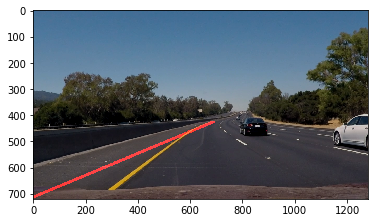

In [131]:
avg_pos_slope = 0
avg_neg_slope = 0
nFrames = 0
challenge_output = 'test_videos/modified_challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,2)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [197]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))